In [1]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14233448164870878129
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2224789915
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17503616507870012245
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
%config IPCompleter.greedy=True

In [ ]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop, Adadelta, Adamax, Adagrad
import matplotlib.pyplot as plt
import sys
import numpy as np

(xo, _), (xf, _) = mnist.load_data()

In [ ]:
pip install pydot

In [ ]:
from keras.utils.vis_utils import plot_model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # binária pois o objetivo é discriminar se é real ou fake
	return model
 
# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, show_shapes=True, show_layer_names=True) # , to_file='discriminator_plot.png'

In [ ]:
X = np.expand_dims(xo, axis=-1)
X.shape

In [ ]:
xo.shape

In [ ]:
xo_normalizado = ( xo / (255 / 2)  ) - 1 # rescalonado entre -1 e 1, isso é importante por conta de um processo que vamos fazer
xo_norm_exp = np.expand_dims(xo_normalizado, axis= 3) # colocando mais uma dimensão para o canal de cor, que no caso é cinza

In [ ]:
xo_norm_exp.shape

In [ ]:
class DCGAN():
    def __init__(self):
        self.altura = 28
        self.comprimento = 28
        self.canais = 1
        self.img_shape = (self.altura, self.comprimento, self.canais) # definindo o shape da imagem
        self.dim_randomica = 100
        
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999, amsgrad=False)
        
        # vamos definir o discriminator 
        self.discriminador = self.build_discriminator()
        self.discriminador.compile(loss= 'binary_crossentropy', metrics= ['accuracy'], optimizer= optimizer)
        
        # definindo o gerador
        self.generator = self.build_generator()
        
        # definindo o modelo completo 
        esqueleto_entrada_randomica = Input(shape= (self.dim_randomica,) ) # imagem de ruidos dada ao generator, e seu shape
        esqueleto_imagem_gerada = self.generator(esqueleto_entrada_randomica) # imagem gerada pelo generator, definindo 
        
        self.discriminador.trainable = False # impedindo o discriminador de treinar
        verificacoes = self.discriminador(esqueleto_imagem_gerada)
        
        self.gan_completa = Model(esqueleto_entrada_randomica, verificacoes)
        self.gan_completa.compile(loss= 'binary_crossentropy', optimizer= optimizer)
        
    def build_generator(self):
        modelo = Sequential()
        
        # o objetivo é finalizar com uma dimensão 28x28x1:
        modelo.add( Dense(128 * 7 * 7, activation= 'relu', input_dim= self.dim_randomica) )
        modelo.add( Reshape( (7,7,128) ) ) 
        modelo.add( UpSampling2D() )      # dobra a dimensão atual transformando 7x7x128 para 14x14x128     
        modelo.add( Conv2D(128, kernel_size= 3, padding= 'same') )
        modelo.add( BatchNormalization(momentum= 0.8 ) )
        modelo.add( Activation('relu') )
        modelo.add( UpSampling2D() )      # 28x28x128
        modelo.add( Conv2D(64, kernel_size= 3, padding= 'same') ) # 28 x 28 x 64
        modelo.add( BatchNormalization(momentum= 0.8 ) )
        modelo.add( Activation('relu') )
        modelo.add( Conv2D(self.canais, kernel_size= 3, padding= 'same' ) ) # 28 x 28 x 1, as dimensões das imagens do dataset
        modelo.add( Activation('tanh') ) # se quiser usar o sigmoid deve rescalonar os dados por 255, o Tanh deixa entre -1 e 1, nesse 
        
        ruido = Input(shape= (self.dim_randomica, ))
        imagem_gerada = modelo(ruido)
        
        return Model(ruido, imagem_gerada) # definindo quem será a entrada e a saída da rede neural
        
    def build_discriminator(self):
        
        modelo = Sequential()
        
        modelo.add( Conv2D(32, kernel_size= 3, strides= 2, input_shape= self.img_shape, activation= 'relu' ))
        modelo.add( LeakyReLU(alpha= 0.2) )
        modelo.add( Dropout(0.25) )
        modelo.add( Conv2D(64, kernel_size= 3, strides= 2, padding= 'same') )
        modelo.add( ZeroPadding2D(padding= ((0,1), (0,1)) ) ) # (top_pad, bottom_pad) , (left_pad, right_pad), adiciona uma camada de zeros nas posições definidas
        modelo.add( BatchNormalization(momentum= 0.8 ) )
        modelo.add( LeakyReLU(alpha= 0.2))
        modelo.add( Dropout(0.25) )
        modelo.add( Conv2D(128, strides= 2, kernel_size= 3, padding= 'same') )
        modelo.add( BatchNormalization(momentum= 0.8) )
        modelo.add( LeakyReLU(alpha= 0.2) )
        modelo.add( Dropout(0.25) )
        modelo.add( Conv2D(256, strides= 2, kernel_size= 3, padding= 'same') )
        modelo.add( BatchNormalization(momentum= 0.8) )
        modelo.add( LeakyReLU(alpha= 0.2) )
        modelo.add( Dropout(0.25) )
        modelo.add( Flatten() )
        modelo.add( Dense(1, activation= 'sigmoid' ) ) 
        
        imagem_entrada = Input(shape= self.img_shape)
        verificacoes = modelo(imagem_entrada)
        
        return Model(imagem_entrada, verificacoes)
        
    def treino(self, epochs, batch_size= 128, intervalo_registro= 50, x_treino= None):
        
        x_treino = xo_norm_exp.copy()
        
        # criando os gabaritos, imagens fakes, 0, imagens reais, 1
        uns = np.ones((batch_size, 1))
        zeros = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):
            
            ''' Discriminator '''
            
            # selecionando um bacth aleatório de imagens reais:
            indices = np.random.randint(0, x_treino.shape[0], batch_size )
            imagens_reais = x_treino[indices]
            
            # selecionar um batch de ruídos para gerar imagens fakes
            amostras_ruidos = np.random.normal(0, 1, (batch_size, self.dim_randomica)) # o terceiro parâmetro do np.random.normal é o shape, eu defini que será uma matriz de 128x100, ou seja 128 matrizes de 100 valores cada
            imagens_geradas = self.generator.predict(amostras_ruidos)
            
            # treinando o discriminador para saber diferenciar fake de real
            d_loss_real = self.discriminador.train_on_batch(imagens_reais, uns)
            d_loss_fake = self.discriminador.train_on_batch(imagens_geradas, zeros)
            discriminador_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            ''' Generator '''
            
            # treinando o generator para aprender a mentir para o discriminador
            generator_loss = self.gan_completa.train_on_batch(amostras_ruidos, uns)
            
            # mostrando o progresso
            print(f'{epoch} discriminador loss: {discriminador_loss[0]}, acurácia: %.2f%% , generator loss: {generator_loss}' % (100*discriminador_loss[1]))
            
            if epoch % intervalo_registro == 0:
                self.save_imgs(epoch)
            
    def save_imgs(self, epoch):
        linhas = 5
        colunas = 5
        amostras_ruidos = np.random.normal(0, 1, (linhas * colunas, self.dim_randomica))
        imagens_geradas = self.generator.predict(amostras_ruidos)
        
        # normalizando as imagens entre 0 e 1 para amostrar no matplotlib em gray
        imagens_geradas = 0.5*imagens_geradas + 0.5
        
        fig, axs = plt.subplots(linhas, colunas)
        cont = 0
        for i in range(linhas):
            for j in range(colunas):
                axs[i,j].imshow(imagens_geradas[cont, :, :, 0], cmap='gray')
                axs[i,j].axis('off')
                cont = cont + 1
        fig.savefig('C:/Users/pituc/imagens_salvas/mnist_%d.png' % epoch)
        plt.close()

In [ ]:
letra = 'filme'
numero = 1245678.98
print(f'a coisa: {letra}, %.2f%%, {numero}' % (numero))

In [ ]:
np.random.randint(0, 28, 100)

In [ ]:
np.random.normal(0, 1, (128, 100))[0].shape

In [ ]:
len(np.random.normal(0, 1, (128, 100)))

In [ ]:
np.random.normal(1, 1, 100).shape

In [ ]:
plt.hist(np.random.normal(1, 1, (100, 100)), 30)
plt.show()

In [ ]:
import time
gan_convolutional = DCGAN()
inicio = time.time()
gan_convolutional.treino(epochs= 20000, batch_size= 32, intervalo_registro= 500, x_treino= xo_norm_exp)
print(f'tempo em minutos: {(time.time() - inicio) / 60}')

In [ ]:
from keras.optimizers import Adam
import numpy as np

np.random.seed(10)

noise_dim = 100

batch_size = 16
steps_per_epoch = 3750
epochs = 10

save_path = 'fcgan-images'

img_rows, img_cols, channels = 28, 28, 1

optimizer = Adam(0.0002, 0.5)

In [ ]:
from keras.datasets import mnist
import os

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

x_train = x_train.reshape(-1, img_rows*img_cols*channels)


if not os.path.isdir(save_path):
    os.mkdir(save_path)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.advanced_activations import LeakyReLU

def create_generator():
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [ ]:
def create_discriminator():
    discriminator = Sequential()
     
    discriminator.add(Dense(1024, input_dim=img_rows*img_cols*channels))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [ ]:
discriminator = create_discriminator()
generator = create_generator()

In [ ]:
from keras.layers import Input
from keras.models import Model

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
from keras.layers import Input
from keras.models import Model

discriminator = create_discriminator()
generator = create_generator()

discriminator.trainable = False

gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
fake_x = generator.predict(noise)

In [ ]:
real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

In [ ]:
x = np.concatenate((real_x, fake_x))

In [ ]:
disc_y = np.zeros(2*batch_size)
disc_y[:batch_size] = 0.9

In [ ]:
d_loss = discriminator.train_on_batch(x, disc_y)

In [ ]:
y_gen = np.ones(batch_size)
g_loss = gan.train_on_batch(noise, y_gen)

In [ ]:
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        fake_x = generator.predict(noise)

        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')

In [ ]:
import matplotlib.pyplot as plt

def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

In [ ]:
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

In [ ]:
x_total = np.concatenate((xo,xf), axis= 0)

In [ ]:
print(x_total.shape)
def carregar_exemplos(x):
    x_exp = np.expand_dims(x, axis= -1)
    x_rescalonado = x_exp.astype('float32') / 255
    return x_rescalonado
print(carregar_exemplos(x_total).shape[0])

In [ ]:
def selecionar_imagens_reais(dataset, n_exemp):
    index_de_datdaset = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_de_datdaset]
    y = np.ones((n_exemp, 1))
    return dados_escolhidos, y
dados,_ = selecionar_imagens_reais(carregar_exemplos(x_total), 10)
plt.imshow(dados[0])

In [ ]:
def gerar_imagens_reais(dataset, n_exemp):
    index_dados_escolhidos = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_dados_escolhidos]
    y = np.ones((n_exemp,1))
    return dados_escolhidos, y

def gerar_imagens_falsas(n_samples):
    pixels_aleatorios = rand(28*28*n_samples) #indico a quantidade que eu quero, resulta no vetor de shape(numero_exemplos,1) 
    pixels_aleatorios_em_matriz = pixels_aleatorios.reshape((n_samples, 28, 28, 1))  # estou dando um shape a esse dataset que vai gerar as imagens falsas
    y = np.zeros((n_samples,1))
    return pixels_aleatorios_em_matriz, y

def carregar_exemplos():
    xo_exp = np.expand_dims(xo, axis= -1)
    xo_rescalonado = xo_exp.astype('float32') / 255
    return xo_rescalonado

def train_discriminator(model, dataset, n_batch= 256, periodos= 100):
    metade_do_batch_total = int(n_batch/2)
    for a in range(periodos):
        x_real, y_real = gerar_imagens_reais(dataset, metade_do_batch_total)
        _, real_acc = model.train_on_batch(x_real, y_real)
        
        x_fake, y_fake = gerar_imagens_falsas(metade_do_batch_total)
        _, fake_acc = model.train_on_batch(x_fake, y_fake)
        
        print(f'{a} real=%.0f%% fake=%.0f%%' % (real_acc*100, fake_acc*100))
        
modelo = define_discriminator()
dataset = carregar_exemplos()

train_discriminator(modelo, dataset)

In [ ]:
np.random.rand( 28)

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def selecionar_imagens_reais(dataset, n_exemp):
    index_de_datdaset = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_de_datdaset]
    y = np.ones((n_exemp, 1))
    return dados_escolhidos, y

def gerar_imagens_fakes(n_exemps):
    pixels_aleatorios = np.random.rand(n_exemps * 28 * 28)
    imagens_fakes = pixels_aleatorios.reshape((n_exemps, 28, 28, 1))
    zeros = np.zeros((n_exemps, 1))
    return imagens_fakes, zeros        

def train_discriminator(modelo, dados, batch = 256, epoch = 100):
    metade_batch = int(batch / 2)
    for a in range(epoch):
        batch_reais, uns = selecionar_imagens_reais(dados,metade_batch)
        _, acc_reais = modelo.train_on_batch(batch_reais, uns)
        
        batch_fakes, zeros = gerar_imagens_fakes(metade_batch)
        _, acc_fakes = modelo.train_on_batch(batch_fakes, zeros)
        
        print(f'precisão real: %.0f%%, precisão fake: %.0f%%' % (acc_reais*100, acc_fakes*100))
        
        
def carregar_exemplos(x):
    x_exp = np.expand_dims(x, axis= -1)
    x_rescalonado = x_exp.astype('float32') / 255
    return x_rescalonado
        
dados_prontos = carregar_exemplos(x_total)
modelo = define_discriminator()

train_discriminator(dados= dados_prontos, modelo= modelo)

In [ ]:
'''
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def selecionar_imagens_reais(dataset, n_exemp):
    index_de_datdaset = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_de_datdaset]
    y = np.ones((n_exemp, 1))
    return dados_escolhidos, y

def gerar_imagens_fakes(n_exemps):
    pixels_aleatorios = np.random.rand(n_exemps * 28 * 28)
    imagens_fakes = pixels_aleatorios.reshape((n_exemps, 28, 28, 1))
    zeros = np.zeros((n_exemps, 1))
    return imagens_fakes, zeros

def train_discriminator(modelo, dados, batch = 256, epoch = 100):
    metade_batch = batch / 2
    for a in range(epoch):
        batch_reais, uns = selecionar_imagens_reais(dados,metade_batch)
        _, acc_reais = modelo.train_on_batch(batch_reais, uns)
        
        batch_fakes, zeros = gerar_imagens_fakes(metade_batch)
        _, acc_fakes = modelo.train_on_batch(batch_fakes, zeros)
        
        print(f'precisão real: %.0f%%, precisão fake: %.0f%%' % (real_acc*100, fake_acc*100))
        
        
def carregar_exemplos():
    xo_exp = np.expand_dims(xo, axis= -1)
    xo_rescalonado = xo_exp.astype('float32') / 255
    return xo_rescalonado
        
dados_prontos = carregar_exemplos()
modelo = define_discriminator()

train_discriminator(dados_prontos, modelo)
'''

In [ ]:
def gerar_imagens_reais(dataset, n_exemp):
    index_dados_escolhidos = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_dados_escolhidos]
    y = np.ones((n_exemp,1))
    return dados_escolhidos, y

In [ ]:
x, y = gerar_imagens_reais(xo, 10)

In [ ]:
x.shape

In [ ]:
max(rand(28*28*2))

In [ ]:
if len(rand(28*28*2)) == 28*28*2:
    print('sim')

In [ ]:
from numpy.random import rand # gera um vetor com valores aleatórios entre 0 e 1
def gerar_imagens_falsas(n_samples):
    pixels_aleatorios = rand(28*28*n_samples) #indico a quantidade que eu quero, resulta no vetor de shape(numero_exemplos,1) 
    pixels_aleatorios_em_matriz = pixels_aleatorios.reshape((n_samples, 28, 28, 1))  # estou dando um shape a esse dataset que vai gerar as imagens falsas
    y = np.zeros((n_samples,1))
    return pixels_aleatorios_em_matriz, y

In [ ]:
x_f, _ = gerar_imagens_falsas(10)
plt.imshow(x_f[0], cmap='gray')

In [ ]:
def carregar_exemplos():
    xo_exp = np.expand_dims(xo, axis= -1)
    xo_rescalonado = xo.astype('float32') / 255
    return xo_rescalonado

In [ ]:
from numpy.random import rand
(xo,_), (xf,_) = mnist.load_data()
x = np.concatenate((xo, xf), axis= 0) 
x_verdadeiro = np.expand_dims(x, axis= -1)
uns = np.ones((len(x),1))

pixels_fakes = rand(x.shape[0]*x.shape[1]*x.shape[2])
matrz_imagens_fakes = pixels_fakes.reshape((x.shape[0], x.shape[1], x.shape[2]))
x_falso = np.expand_dims(matrz_imagens_fakes, axis= -1)
zeros = np.zeros((len(x),1))

In [ ]:
zeros.shape

In [ ]:
x_final = np.empty((x_verdadeiro.shape[0] * 2, x_verdadeiro.shape[1], x_verdadeiro.shape[2], x_verdadeiro.shape[3]))
y_final = np.empty((x_verdadeiro.shape[0] * 2, 1))
for i, j in zip(range(0, len(x_final), 2) , range(len(x_verdadeiro))):
    x_final[i] = x_verdadeiro[j]
    x_final[i+1] = x_falso[j]
    y_final[i] = uns[j]
    y_final[i+1] = zeros[j]

In [ ]:
plt.subplot(1,2,1)
plt.imshow(x_final[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(x_final[1], cmap='gray')
plt.show()

In [ ]:
# entenda train_on_batch != fit
# fit treina em epochs vezes o modelo , nos não podemos interromper o processo para fazer outra coisa, ele treina quantas epcochs quisermos
# train_on_batch treina o modelo só uma vez, podemos fazer o modelo processar outra coisa após terminar um único treino, ele treina só uma vez mas podemos definir que ele treine mais vezes
# a vantagem de usar o train_on_batch, (é importante dizer que dava para usar o fit, então em vez de usar o laço for eu faria:

'''
def train_discriminator(model, dataset, n_batch= 256, periodos= 100):
    x_real_e_fake, y_real_1_e_fake_0 = gerar_imagens_reais_e_fake(dataset, batch_total= n_batch)
    historico = model.fit(x_real_e_fake, y_real_1_e_fake_0)
'''

# o que ocorre aqui é o seguinte, o discriminador nada mais é que uma rede neural comum, ela classifica 0 para fake, 1 para real
# então podemos treina-la da mesma maneira que treinamos outras, só que para isso, não podemos entrgar batchs novos a cada treino
# mas sim já dar tudo em forma de x e y, igual nas outras vezes, aqui o x tem os fakes e reais e y tem suas classes corresponde-
# tes, já no train_on_batch colocamos primeiro um batch de reais com y real, depois na mesma epoch treinamos um batch de flasos com y falso
# essa é a única diferença,

In [ ]:
def train_discriminator(model, dataset, n_batch= 256, periodos= 100):
    metade_do_batch_total = int(n_batch/2)
    for a in range(periodos):
        x_real, y_real = gerar_imagens_reais(dataset, metade_do_batch_total)
        _, real_acc = model.train_on_batch(x_real, y_real)
        
        x_fake, y_fake = gerar_imagens_falsas(metade_do_batch_total)
        _, fake_acc = model.train_on_batch(x_fake, y_fake)
        
        print(f'{a} real=%.0f%% fake=%.0f%%' % (real_acc*100, fake_acc*100))

In [ ]:
dataset.shape

In [ ]:
def carregar_exemplos():
    xo_exp = np.expand_dims(xo, axis= -1)
    xo_rescalonado = xo.astype('float32') / 255
    return xo_rescalonado

In [ ]:
carregar_exemplos().shape

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

In [ ]:
from keras.utils.vis_utils import plot_model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def gerar_imagens_reais(dataset, n_exemp):
    index_dados_escolhidos = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_dados_escolhidos]
    y = np.ones((n_exemp,1))
    return dados_escolhidos, y

def gerar_imagens_falsas(n_samples):
    pixels_aleatorios = rand(28*28*n_samples) #indico a quantidade que eu quero, resulta no vetor de shape(numero_exemplos,1) 
    pixels_aleatorios_em_matriz = pixels_aleatorios.reshape((n_samples, 28, 28, 1))  # estou dando um shape a esse dataset que vai gerar as imagens falsas
    y = np.zeros((n_samples,1))
    return pixels_aleatorios_em_matriz, y

def carregar_exemplos():
    xo_exp = np.expand_dims(xo, axis= -1)
    xo_rescalonado = xo_exp.astype('float32') / 255
    return xo_rescalonado

def train_discriminator(model, dataset, n_batch= 256, periodos= 100):
    metade_do_batch_total = int(n_batch/2)
    for a in range(periodos):
        x_real, y_real = gerar_imagens_reais(dataset, metade_do_batch_total)
        _, real_acc = model.train_on_batch(x_real, y_real)
        
        x_fake, y_fake = gerar_imagens_falsas(metade_do_batch_total)
        _, fake_acc = model.train_on_batch(x_fake, y_fake)
        
        print(f'{a} real=%.0f%% fake=%.0f%%' % (real_acc*100, fake_acc*100))
        
modelo = define_discriminator()
dataset = carregar_exemplos()

train_discriminator(modelo, dataset)

In [ ]:
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose

In [ ]:
from keras.utils.vis_utils import plot_model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

modelo = define_generator(100)
modelo.summary()
plot_model(modelo, show_shapes=True, show_layer_names=True)

In [ ]:
def definir_modelo_generativo(dim_latentes):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7 
	model.add(Dense(n_nodes, input_dim=dim_latentes))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

def gerar_pontos_latentes(dim_latentes, n_examp):
    pixels_aleatorios = np.random.randn(dim_latentes * n_examp)
    x_input = pixels_aleatorios.reshape(n_examp, dim_latentes)
    return x_input

def gerar_imagens_fakes(modelo_gen, dim_latentes, n_exemps):
    # pixels_aleatorios = np.random.rand(n_exemps * 28 * 28)
    # imagens_fakes = pixels_aleatorios.reshape((n_exemps, 28, 28, 1))
    
    imagens_fakes = gerar_pontos_latentes(dim_latentes, n_exemps)
    predicoes = modelo_gen.predict(imagens_fakes)
    
    zeros = np.zeros((n_exemps, 1))
    return imagens_fakes, zeros    

modelo = definir_modelo_generativo(100)
imagens, _ = gerar_imagens_fakes(modelo, 100, 25)

In [ ]:
imagens

In [ ]:
from numpy.random import randn
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

In [ ]:
def definir_modelo_generativo(dim_latentes):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7 
	model.add(Dense(n_nodes, input_dim=dim_latentes))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

def gerar_pontos_latentes(dim_latentes, n_examp):
    pixels_aleatorios = np.random.randn(dim_latentes * n_examp)
    x_input = pixels_aleatorios.reshape(n_examp, dim_latentes)
    return x_input

def gerar_imagens_fakes(modelo_gen, dim_latentes, n_exemps):
    # pixels_aleatorios = np.random.rand(n_exemps * 28 * 28)
    # imagens_fakes = pixels_aleatorios.reshape((n_exemps, 28, 28, 1))
    
    imagens_fakes = gerar_pontos_latentes(dim_latentes, n_exemps)
    predicoes = modelo_gen.predict(imagens_fakes)
    
    zeros = np.zeros((n_exemps, 1))
    return predicoes, zeros    

modelo = definir_modelo_generativo(100)
imagens, _ = gerar_imagens_fakes(modelo, 100, 25)

for a in range(25):
    plt.subplot(5,5, a + 1)
    #plt.axis('off')
    plt.imshow(imagens[a, :, :, 0], cmap= 'gray_r')
    
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model

In [ ]:
from numpy.random import randn
from keras.utils.vis_utils import plot_model

def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def fazer_gan(modelo_g, modelo_d):
    modelo_d.trainable = False
    modelo_definitivo = Sequential()
    modelo_definitivo.add(modelo_g)
    modelo_definitivo.add(modelo_d)
    otimizador = Adam(learning_rate= 0.0002, beta_1= 0.5)
    modelo_definitivo.compile(loss= 'binary_crossentropy', optimizer= otimizador)
    return modelo_definitivo

modelo_g = define_generator(100)
modelo_d = define_discriminator()

modelo_definitivo = fazer_gan(modelo_g, modelo_d)
modelo_definitivo.summary()
plot_model(modelo_definitivo, show_shapes= True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def gerar_imagens_reais(dataset, n_exemp):
    index_dados_escolhidos = np.random.randint(0, dataset.shape[0], n_exemp)
    dados_escolhidos = dataset[index_dados_escolhidos]
    y = np.ones((n_exemp,1))
    return dados_escolhidos, y

def gerar_pontos_latentes(dim_latentes, n_examp):
    pixels_aleatorios = np.random.randn(dim_latentes * n_examp)
    x_input = pixels_aleatorios.reshape(n_examp, dim_latentes)
    return x_input

def gerar_imagens_fakes(modelo_gen, dim_latentes, n_exemps):
    # pixels_aleatorios = np.random.rand(n_exemps * 28 * 28)
    # imagens_fakes = pixels_aleatorios.reshape((n_exemps, 28, 28, 1))
    
    imagens_fakes = gerar_pontos_latentes(dim_latentes, n_exemps)
    predicoes = modelo_gen.predict(imagens_fakes)
    
    zeros = np.zeros((n_exemps, 1))
    return predicoes, zeros

def fazer_gan(modelo_g, modelo_d):
    modelo_d.trainable = False
    modelo_definitivo = Sequential()
    modelo_definitivo.add(modelo_g)
    modelo_definitivo.add(modelo_d)
    otimizador = Adam(learning_rate= 0.0002, beta_1= 0.5)
    modelo_definitivo.compile(loss= 'binary_crossentropy', optimizer= otimizador)
    return modelo_definitivo
    
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model    
    
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def carregar_exemplos(x):
    x_exp = np.expand_dims(x, axis= -1)
    x_rescalonado = x_exp.astype('float32') / 255
    return x_rescalonado

def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()

def sumario_do_discriminador(dataset, d_model, g_model, dim_latent, epoca):
    
    x_real, y_real = gerar_imagens_reais(dataset, 100)
    x_falso, y_falso = gerar_imagens_fakes(g_model, dim_latent, 100)
    _, acc_real = d_model.train_on_batch(x_real, y_real)
    _, acc_fake = d_model.train_on_batch(x_falso, y_falso)

    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    save_plot(x_falso, epoca)
    
    filename = 'modelo_gerador%03d.h5' % (epoca + 1)
    g_model.save(filename)
    
def treino(gan_model, d_model, g_model, dataset, dim_latent, epochs= 100, batch= 256):
    metade_batch = int(batch/2)
    batch_por_epoca = int(dataset.shape[0] / batch)
    for epoca in range(epochs):
        for n_batch in range(batch_por_epoca):
            
            x_real, y_real = gerar_imagens_reais(dataset, metade_batch) 
            x_falso, y_falso = gerar_imagens_fakes(g_model, dim_latent, metade_batch)
            x, y = np.concatenate((x_real, x_falso), axis= 0), np.vstack((y_real, y_falso))
            d_loss, _ = d_model.train_on_batch(x, y)
            
            x_gan = gerar_pontos_latentes(dim_latent, batch)
            y_gan = np.ones((batch, 1))
            g_loss = gan_model.train_on_batch(x_gan, y_gan)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoca+1, n_batch+1, batch_por_epoca, d_loss, g_loss))
        if ((epoca + 1) % 10) == 0:
            sumario_do_discriminador(dataset, d_model, g_model, dim_latent, epoca)
                

            
x_total = np.concatenate((xo, xf), axis= 0)
d_modelo = define_discriminator()
g_modelo = define_generator(100)
gan_modelo = fazer_gan(g_modelo , d_modelo)
dataset = carregar_exemplos(x_total)
            
treino(gan_modelo, d_modelo, g_modelo, dataset, 100)

In [ ]:
for a in range(0, 110, 10):
    print('%03d' % a)

In [ ]:
from keras.models import load_model

plt.figure(figsize= (20, 25))

dim_latentes = 100
n_exemp = 25
pixels_fakes = np.random.randn(dim_latentes * n_exemp)
imagens_fakes = pixels_fakes.reshape((n_exemp, dim_latentes)) 
imagens_para_cada = n_exemp
quantos_modelos = 10
imagem = 0

for vez in range(quantos_modelos):
    g_model = load_model('modelo_gerador%03d.h5' % ((vez+1) *10))
    imagens_geradas = g_model.predict(imagens_fakes)
    #n_imagens = int(imagens_para_cada * quantos_modelos)
    index = 0
    for a in range(imagens_para_cada):
        imagem = imagem + 1
        plt.subplot(imagens_para_cada, quantos_modelos, imagem)
        plt.imshow(imagens_geradas[index,:,:,0], cmap= 'gray_r')
        index = index + 1
plt.show()

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
from keras.datasets import cifar10
from keras.utils import to_categorical

In [ ]:
(xo,yo), (xf,yf) = cifar10.load_data()
xo_resc = xo.astype('float32') / 255
xf_resc = xf.astype('float32') / 255
yo_cat = to_categorical(yo)
yf_cat = to_categorical(yf)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(xo[54])

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D

modelu = Sequential()

In [ ]:
modus = Sequential()
inputa = Input(shape= (32,32,3))
x = Flatten()(inputa)
x = Dense(200, activation= 'relu')(x)
x = Dense(150, activation= 'relu')(x)
out = Dense(10, activation= 'softmax')(x)
modus = Model(inputa, out)
modus.summary()

In [ ]:
modelu.add(Dense(200, activation= 'relu', input_shape= (32,32,3)))
modelu.add(Flatten())
modelu.add(Dense(150, activation= 'relu'))
modelu.add(Dense(10, activation= 'softmax'))
modelu.summary()

In [ ]:
input_shape = Input(shape= (32,32,3))
x = Flatten()(input_shape)
x = Dense(200, activation= 'relu')(x)
x = Dense(150, activation= 'relu')(x)
output_layer = Dense(10, activation= 'softmax')(x)
model = Model(input_shape, output_layer)

In [ ]:
model.summary()

In [ ]:
from keras.optimizers import Adam, RMSprop

In [ ]:
otimizador = Adam(learning_rate= 0.0005)

modelu.compile(loss= 'categorical_crossentropy', optimizer= otimizador, metrics= ['accuracy'])
model.compile(loss= 'categorical_crossentropy', optimizer= otimizador, metrics= ['accuracy'])

In [ ]:
historico = model.fit(xo_resc, yo_cat, epochs= 100, batch_size= 32, validation_data= (xf_resc, yf_cat), verbose= 1, shuffle= True)

In [ ]:
probabilidades = model.predict(xf_resc)
np.argmax(probabilidades, axis= -1)

In [ ]:
np.argmax(yf_cat, axis= -1)

In [ ]:
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

probabilidades = model.predict(xf_resc)
maior_probabilidades = np.argmax(probabilidades, axis= -1)
predicoes = classes[maior_probabilidades]

valores_reais = np.argmax(yf_cat, axis= -1)
reais         = classes[valores_reais]

In [ ]:
import numpy as np
np.argmax([
    
    [20,1,4],
    [30,1,1],
    [4,56,17]
    ,
    
    [2,1,100],
    [10,5,78],
    [11,5,6]
    
], axis= -1)   # pega o maior valor, axis= None define a ordem a partir da contagem dos números
     # axis= 0 pega as colunas, axis= -1/1 pega as linhas

In [ ]:
print('oi')

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(xf_resc)), n_to_show)
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, idx in enumerate(indices):
    img = xf_resc[idx];
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(predicoes[idx]), fontsize=10
    , ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(reais[idx]), fontsize=10
    , ha='center', transform=ax.transAxes)
    ax.imshow(img)


In [ ]:
from keras.layers import BatchNormalization, Dropout, LeakyReLU, Dense, Flatten, Input, Conv2D, MaxPooling2D
from keras.models import Sequential, Model

In [ ]:
convolucao = Sequential()

In [ ]:
inputac = Input(shape= (32,32,3))
c = Conv2D(filters= 32, kernel_size= 3, strides= (1,1), padding= 'same')(inputac)
c = BatchNormalization()(c)
c = LeakyReLU()(c)

c = Conv2D(32,  kernel_size= 3, strides= (1,1), padding= 'same')(c)
c = BatchNormalization()(c)
c = LeakyReLU()(c)

c = Conv2D(filters= 64, kernel_size= 3, strides= (1,1), padding= 'same')(c)
c = BatchNormalization()(c)
c = LeakyReLU()(c)

c = Conv2D(filters= 64, kernel_size= 3, strides= (1,1), padding= 'same')(c)
c = BatchNormalization()(c)
c = LeakyReLU()(c)

c = Flatten()(c)

c = Dense(128, activation= 'relu')(c)
c = BatchNormalization()(c)
c = LeakyReLU()(c)
c = Dropout(rate= 0.5)(c)

outt = Dense(10, activation= 'softmax')(c)

modelo_convolucao = Model(inputac, outt)
modelo_convolucao.summary() 

In [ ]:
from keras.optimizers import Adam, RMSprop
otimizador = Adam()
modelo_convolucao.compile(loss= 'categorical_crossentropy', optimizer= otimizador, metrics= ['accuracy'])

In [ ]:
# as médias e desvios padrões do BatchNormalization são para cada canal, mas esses parâmetros (e o deslocamento e a escala) são 
# usados os resultados de cada canal e de outros canais ou a cada canal nos vamos normalizar os valores dos kernels ?

In [ ]:
xo_resc = xo.astype('float32') / 255
xf_resc = xf.astype('float32') / 255
yo_cat = to_categorical(yo)
yf_cat = to_categorical(yf)

In [ ]:
historico = modelo_convolucao.fit(xo_resc, yo_cat, batch_size= 50, epochs= 10, verbose= 1, validation_data= (xf_resc, yf_cat))

In [ ]:
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

probabilidades = model.predict(xf_resc)
maior_probabilidades = np.argmax(probabilidades, axis= -1)
predicoes = classes[maior_probabilidades]

valores_reais = np.argmax(yf_cat, axis= -1)
reais         = classes[valores_reais]

In [ ]:
np.array(['oi'])

In [ ]:
import numpy as np
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

probabilidades = modelo_convolucao.predict(xf_resc)
probabilidade_maior = np.argmax(probabilidades, axis= -1)
predicoes = classes[probabilidade_maior]

valores_reais = np.argmax(yf_cat, axis= -1)
reais = classes[valores_reais]

In [ ]:
n_to_show = 10
indices = np.random.choice(range(len(xf_resc)), n_to_show)
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, idx in enumerate(indices):
    img = xf_resc[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(predicoes[idx]), fontsize=10
    , ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(reais[idx]), fontsize=10
    , ha='center', transform=ax.transAxes)
    ax.imshow(img)


In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

from utils.callbacks import CustomCallback, step_decay_schedule

import numpy as np
import json
import os
import pickle


class Autoencoder():
    def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False
        ):

        self.name = 'autoencoder'

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self._build()

    def _build(self):

        ### THE ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

            if self.use_batch_norm:
                x = BatchNormalization()(x)

            if self.use_dropout:
                x = Dropout(rate = 0.25)(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        encoder_output= Dense(self.z_dim, name='encoder_output')(x)

        self.encoder = Model(encoder_input, encoder_output)


        ### THE DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:
                x = LeakyReLU()(x)
                
                if self.use_batch_norm:
                    x = BatchNormalization()(x)
                
                if self.use_dropout:
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        ### THE FULL AUTOENCODER
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)


    def compile(self, learning_rate):
        self.learning_rate = learning_rate

        optimizer = Adam(lr=learning_rate)

        def r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

        self.model.compile(optimizer=optimizer, loss = r_loss)

    def save(self, folder):

        if not os.path.exists(folder):
            os.makedirs(folder)
            os.makedirs(os.path.join(folder, 'viz'))
            os.makedirs(os.path.join(folder, 'weights'))
            os.makedirs(os.path.join(folder, 'images'))

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pickle.dump([
                self.input_dim
                , self.encoder_conv_filters
                , self.encoder_conv_kernel_size
                , self.encoder_conv_strides
                , self.decoder_conv_t_filters
                , self.decoder_conv_t_kernel_size
                , self.decoder_conv_t_strides
                , self.z_dim
                , self.use_batch_norm
                , self.use_dropout
                ], f)

        self.plot_model(folder)

        


    def load_weights(self, filepath):
        self.model.load_weights(filepath)

    
    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):

        custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
        lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

        #checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

        callbacks_list = [checkpoint2, custom_callback, lr_sched]

        self.model.fit(     
            x_train
            , x_train
            , batch_size = batch_size
            , shuffle = True
            , epochs = epochs
            , initial_epoch = initial_epoch
            , callbacks = callbacks_list
        )
    '''
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)
    '''

In [ ]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

In [ ]:
(xo,_), (xf,_) = mnist.load_data()

In [ ]:
np.prod([[10,10, 10],[2,3,4]], axis= 1) # multiplica tensores(valores escalares, vetores e marizes), None multiplica tudo, 0 multiplica colunas, 1 multiplica as linhas

In [ ]:
xo.shape

In [ ]:
dim_entrada = (28,28,1)
n_camadas_codificador = 4
filtro_codificador_convolucional = [32, 64, 64, 64]  #encoder_conv_filters
tamanho_kernel_codificador_convolucional = [3,3,3,3]  #encoder_conv_kernel_size
strides_codificadores_convolucionais = [1,2,2,1] #encoder_conv_strides
z_dim = 2


#n_filtros_decodificadores_transpostos = decoder_conv_t_filters
#tamanho_kernel_decodificador_convolucional_transposto = decoder_conv_t_kernel_size
#strides_convolucionais_transpostos_decodificadores = decoder_conv_t_strides

In [ ]:
entrada_codificador = Input(shape = dim_entrada, name= 'entrada_codificador')
x = entrada_codificador

for a in range(n_camadas_codificador): # criar as camadas do codificador
    conv_layer = Conv2D(
        filters = filtro_codificador_convolucional[a],
        kernel_size = tamanho_kernel_codificador_convolucional[a],
        strides= strides_codificadores_convolucionais[a],
        padding= 'same',
        name= 'codificador_convolucional_' + str(a)
    )
    
    x = conv_layer(x)
    x = LeakyReLU()(x)                       
    
shape_antes_do_Flatten = K.int_shape(x)[1:]
x = Flatten()(x)

saida_codificador = Dense(z_dim, name= 'saida_codificador')(x)

modelo_codificador = Model(entrada_codificador, saida_codificador)

In [ ]:
'''
entrada_cod = Input(shape= (28,28,1), name= 'entrada_cod')
a = entrada_cod
n_de_layers = 3
for n in range(n_de_layers):
    
    camada = Conv2D(
        filters= [32,64,64,128][n],
        kernel_size= [3,3,3,3][n],
        strides= [1,2,2,1][n],
        padding= 'same',
        name= 'Conv2D_n_' + str(n)
    )
    
    a = camada(a)
    a = LeakyReLU()(a)


shape_antes_do_flatten = K.int_shape(x)[1:]
a = Flatten()(a)
saida_cod = Dense(z_dim, name= 'saida_cod')(a)
modelo_a = Model(entrada_cod, saida_cod)
'''



In [ ]:
((9 * 64) + 1) * 64

In [ ]:
49 * 64 * 2 + 2

In [ ]:
# o cálculo do número de parâmetros/pesos em cada layer é: área_do_kernel * canais_lidos_pelo_feature_map * quant_de_feature_maps
# (numero_imagens, width_feature, height_feature, numero_de_features) , numero_de_features = numero_de_camdas_lidos_por_feature_map
# os pesos do kernel de cada feature_map/canal_lido são diferentes dos pesos do kernel do outro feature_map/canal_lido

In [ ]:
modelo_codificador.summary() 

In [ ]:
n_camadas_decodificador = 4
n_filtros_decodificadores_transpostos = [64, 64, 32, 1] #decoder_conv_t_filters 
tamanho_kernel_decodificador_convolucional_transposto = [3,3,3,3] #decoder_conv_t_kernel_size
strides_convolucionais_transpostos_decodificadores = [1, 2, 2, 1] #decoder_conv_t_strides
# temos Input 2 neur, densa 3136 neur, reshape 7x7x64, (aqui começa o for) conv 7x7x64, conv 14x14x64, conv 28x28x32, conv 28x28x1


In [ ]:
entrada_decodificador = Input(shape = (z_dim,), name= 'entrada_decodificador') # o codificador termina com uma camada densa de z_dim quantidade de neurônios
y = Dense(np.prod(shape_antes_do_Flatten))(entrada_decodificador)   # e portanto o decodificador tem que começar com uma camada densa que tenha a mesma entrada da saída do codificador e que tenha a mesma quantidade de neurônios que tinha antes do Flatten
y = Reshape(shape_antes_do_Flatten)(y) # nos definimos o reshape, antes de partir para o Conv, com base no shape do codificador antes de ir para o Flatten

#  exemplo de output de codificador e input de decodificador: 
# 10 layers de 11x10, flatten de 1100 neur, densa de z_dim neur, (codi)
# input de z_dim neur, densa de 1100 neur (np.prod(shape antes do flatten)), Reshape de 10 layers de 11 x 10     

for a in range(n_camadas_decodificador):
    camada_convolucional_transposta = Conv2DTranspose(
        filters = n_filtros_decodificadores_transpostos[a],
        kernel_size = tamanho_kernel_decodificador_convolucional_transposto[a],
        strides= strides_convolucionais_transpostos_decodificadores[a],
        padding= 'same',
        name= 'camada_convolucional_transposta_' + str(a)
        
    )
    
    y = camada_convolucional_transposta(y)
    
    if 
    
    if a < (n_camadas_decodificador - 1):
        y = LeakyReLU()(y)
    else:
        y = Activation('sigmoid')(y)
        
saida_decodificador = y
modelo_decodificador = Model(entrada_decodificador, saida_decodificador)

In [ ]:
3136 * 3

In [ ]:
modelo_decodificador.summary()

In [ ]:
modelo_input = entrada_codificador
modelo_output = modelo_decodificador(saida_codificador)

modelo = Model(modelo_input, modelo_output)

In [ ]:
def r_loss(y_real, y_pred):
    return K.mean(K.square(y_real - y_pred), axis = [1,2,3])


otimizador = RMSprop()
modelo.compile(loss= r_loss, optimizer= otimizador)

In [ ]:
xo_aumentada = np.expand_dims(xo, axis= -1)
xo_rescalonado = xo_aumentada / 255

In [ ]:
modelo.fit(xo_rescalonado, xo_rescalonado, epochs= 10, batch_size= 32, verbose= 1, shuffle= True)

In [ ]:
xf_aumentada = np.expand_dims(xf, axis= -1)
xf_rescalonado = xf_aumentada / 255

In [ ]:
xf_rescalonado[0].shape

In [ ]:
xf[0].shape

In [ ]:
import matplotlib.pyplot as plt
imagem = modelo.predict(xf_rescalonado[0:1])

In [ ]:
imagem[0].shape

In [ ]:
plt.imshow(imagem[0], cmap='gray')

In [ ]:
plt.imshow(xf[0], cmap= 'gray')

In [ ]:
modelo.predict(xf[6:7])

In [ ]:
index_imagem = 50
numero_posterior = index_imagem + 1

imagem = modelo.predict(xf_rescalonado[index_imagem:numero_posterior])

plt.subplot(1,2,1)
plt.imshow(imagem[0], cmap= 'gray')

plt.subplot(1,2,2)
plt.imshow(xf[index_imagem], cmap='gray')

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model

In [ ]:
z_dim = 200
shape_imagem = (128,128,3)
usar_batch_normalization = True
usar_dropout = True
entrada_cod = Input(shape= shape_imagem, name= 'entrada_cod')
a = entrada_cod
n_layers = 4
for n in range(n_layers):
    camada = Conv2D(
        filters= [32,64,64,128][n],
        kernel_size= [3,3,3,3][n],
        strides= [2,2,2,2][n],
        padding= 'same',
        name= 'camada_convolucional_n_' + str(n)
    )
    
    a = camada(a)
    if usar_batch_normalization:
        a = BatchNormalization()(a)
        
    a = LeakyReLU()(a)
    
    if usar_dropout:
        a = Dropout(rate= 0.25)(a)
        
shape_antes_flatten = K.int_shape(a)[1:]
a = Flatten()(a)

mu = Dense(z_dim, name='mu')(a)
log_var = Dense(z_dim, name= 'log_var')(a)

codificador_mu_log_var = Model(entrada_cod, (mu, log_var))

def dando_exemplos(args):
    mu, log_var = args
    epsilon = K.random_normal(shape= K.shape(mu), mean= 0, stddev= 1) # K.random_normal faz uma distribuição normal sendo que ele retorna um array com o shape necessário, e os valores são os escolhidos na distribuição gaussiana
    return mu + K.exp(log_var/2) * epsilon

saida_cod = Lambda(dando_exemplos, name= 'saida_dec')([mu, log_var]) # ele vai enviar esta lista com as camadas da média e 
# da variância em log para a função, a função pega os valores de média e desvio padrão e devolve o z 
# o qual é um ponto aleatório da distribuição normal

modelo_cod = Model(entrada_cod, saida_cod)

In [ ]:
modelo_cod.summary()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize= (8,15))
plot_model(modelo_cod, show_shapes= True)

In [ ]:
n_camadas_decodificador = 4
n_filtros_decodificadores_transpostos = [64, 64, 32, 3] #decoder_conv_t_filters 
tamanho_kernel_decodificador_convolucional_transposto = [3,3,3,3] #decoder_conv_t_kernel_size
strides_convolucionais_transpostos_decodificadores = [2, 2, 2, 2] #decoder_conv_t_strides
# temos Input 2 neur, densa 3136 neur, reshape 7x7x64, (aqui começa o for) conv 7x7x64, conv 14x14x64, conv 28x28x32, conv 28x28x1

In [ ]:
entrada_dec = Input(shape = (z_dim,), name= 'entrada_decodificador') 
y = Dense(np.prod(shape_antes_flatten))(entrada_dec)   
y = Reshape(shape_antes_flatten)(y) 


for a in range(n_camadas_decodificador):
    camada_convolucional_transposta = Conv2DTranspose(
        filters = n_filtros_decodificadores_transpostos[a],
        kernel_size = tamanho_kernel_decodificador_convolucional_transposto[a],
        strides= strides_convolucionais_transpostos_decodificadores[a],
        padding= 'same',
        name= 'camada_convolucional_transposta_' + str(a)
        
    )
    
    y = camada_convolucional_transposta(y)
    
    if usar_batch_normalization and a < (n_camadas_decodificador - 1):
        y = BatchNormalization()(y)
    
    if a < (n_camadas_decodificador - 1):
        y = LeakyReLU()(y)
        
    if usar_dropout and a < (n_camadas_decodificador - 1):
        y = Dropout(rate= 0.25)(y)
        
    else:
        y = Activation('sigmoid')(y)
        
saida_decr = y
modelo_dec = Model(entrada_dec, saida_decr)

In [ ]:
modelo_dec.summary()

In [ ]:
plot_model(modelo_dec, show_shapes= True)

In [ ]:
modelo_input = entrada_cod
modelo_output = modelo_dec(saida_cod)
modelo_definitivo = Model(modelo_input, modelo_output)

In [ ]:
otimizador = RMSprop(0.0005)
fator_r_loss = 10000
batch= 32
epocas = 5
def vae_r_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis= [1,2,3])
    return fator_r_loss * r_loss

def vae_kl_loss(y_true, y_pred):
    kl_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis= 1 )
    return kl_loss

def vae_loss(y_true, y_pred):
    r_loss = vae_r_loss(y_true, y_pred)
    kl_loss = vae_kl_loss(y_true, y_pred)
    return r_loss + kl_loss

modelo_definitivo.compile(optimizer=otimizador, loss = vae_loss, metrics = [vae_r_loss, vae_kl_loss])

In [ ]:
import cv2
import os

In [ ]:
imagens = os.listdir('C:/Users/pituc/Downloads/archive (8)/img_align_celeba/img_align_celeba')
len(imagens)

In [ ]:
imagem_teste = cv2.imread('C:/Users/pituc/Downloads/archive (8)/img_align_celeba/img_align_celeba/' + imagens[10000])
imagem_teste = cv2.cvtColor(imagem_teste, cv2.COLOR_BGR2RGB )

In [ ]:
imagem_teste.shape

In [ ]:
reshape_teste = cv2.resize(imagem_teste, (128,128), interpolation= cv2.INTER_AREA)

plt.imshow(reshape_teste)
plt.show()

In [ ]:
lista_de_imagens = np.empty(shape= (2000, 128, 128, 3))

In [ ]:
img = imagens[0]
imagem = cv2.imread('C:/Users/pituc/Downloads/archive (8)/img_align_celeba/img_align_celeba/' + img)
imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB) # cv2.cvtColor(imagem_teste, cv2.COLOR_BGR2RGB )
imagem_resize = cv2.resize(imagem_rgb, (128,128), interpolation= cv2.INTER_AREA)

In [ ]:
norm = imagem_resize/255
lista_de_imagens[0] = np.reshape(norm, (128, 128, 3))
plt.imshow(lista_de_imagens[0])
plt.show()

In [ ]:
n_fotos = 2000
lista_de_imagens = np.empty(shape= (n_fotos, 128, 128, 3))
for index, img in zip(range(len(imagens[:n_fotos])), imagens[:n_fotos]):
    imagem = cv2.imread('C:/Users/pituc/Downloads/archive (8)/img_align_celeba/img_align_celeba/' + img)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB) 
    imagem_resize = cv2.resize(imagem_rgb, (128,128), interpolation= cv2.INTER_AREA)
    norm = imagem_resize/255
    lista_de_imagens[index] = np.reshape(norm, (128, 128, 3))

In [ ]:
lista_de_imagens.shape

In [ ]:
INPUT_DIM = (128,128,3)
INPUT_DIM[:2]

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
dados_finais = datagen.flow_from_directory('C:/Users/pituc/Downloads/archive (8)/img_align_celeba/img_align_celeba/', 
                                           target_size = INPUT_DIM[:2],
                                           batch_size = 32,
                                           shuffle= True,
                                           class_mode = 'input',
                                           subset = "training"
                                          )

In [ ]:
type(dados_finais)

In [ ]:
batch = 32
steps_per_epoch = int(len(lista_de_imagens) / batch)
modelo_definitivo.fit(lista_de_imagens,lista_de_imagens, batch_size= 20, epochs= 30)

In [ ]:
quant_para_demonstrar = 3
novos_z = np.random.normal(size= (quant_para_demonstrar, z_dim))

reconstrucao = modelo_dec.predict(np.array(novos_z))
plt.figure(figsize=(18, 5))

for a in range(quant_para_demonstrar):
    plt.subplot(3,1, a + 1)
    plt.imshow(reconstrucao[a, :, :, :])
plt.show()

In [ ]:
n_de_convs_dis = 4

In [ ]:
(1664 - 64) / 64

In [ ]:
(5 * 5 * 64) + 64

In [ ]:
64 * ((64 * 5 * 5) + 64) 

In [ ]:
from keras.initializers import RandomNormal
from keras.layers import ReLU, UpSampling2D

In [ ]:
entrada_discriminador = Input(shape= (28,28,1), name= 'entrada_discriminador')
x = entrada_discriminador
inicializador_kernel = RandomNormal(mean= 0, stddev= 0.02)
for n in range(n_de_convs_dis):
    if n == 2:
        matriz_pre = K.int_shape(x)[1:]
    conv = Conv2D(
        filters= [64, 64, 128, 128][n],
        kernel_size= [5, 5, 5, 5][n],
        strides= [2, 2, 2, 1][n],
        padding= 'same',
        name= 'camada_convolucional_' + str(n),
    
    )
    
    x = conv(x)
    
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(rate= 0.25)(x)
   
        

x = Flatten()(x)
saida_discriminador = Dense(1, activation= 'sigmoid', kernel_initializer= inicializador_kernel, name= 'camada_densa_saida_discriminador')(x)
discriminador = Model(entrada_discriminador, saida_discriminador)

In [ ]:
discriminador.compile(optimizer= RMSprop(learning_rate= 0.0008), loss= 'binary_crossentropy', metrics= ['accuracy'] )

In [ ]:
64 * ((25 * 64) + 1)

In [ ]:
discriminador.summary() # lembre-se que o bias não é por canal mas por conjunto de canais que se conectam com o próximo feature layer, ou seja é um bias por feature layer que está sendo formado

In [ ]:
(3136 * 100) + 3136

In [ ]:
np.prod(matriz_pre)

In [ ]:
128 * ((64 * 5*5) + 64)

In [ ]:
n_de_convs_gera = 4
entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
y = entrada_gerador
y = Dense(np.prod(matriz_pre), kernel_initializer= inicializador_kernel)(y)

y = BatchNormalization(momentum= 0.9)(y)

y = ReLU()(y)

y = Reshape(matriz_pre)(y)

for n in range(n_de_convs_gera):
    if n < (n_de_convs_gera - 2):
        y = UpSampling2D()(y)
        
    conv_tran = Conv2D(
        filters= [128, 64, 64, 1][n],
        kernel_size= [5,5,5,5][n],
        strides= (1,1),
        padding= 'same',
        name= 'camada_convolucional_' + str(n)
    )
    
    y = conv_tran(y)
    if n < (n_de_convs_gera - 1):
        y = BatchNormalization(momentum= 0.9)(y)
        y = ReLU()(y)
    else:
        y = Activation('tanh')(y)
    
saida_gerador = y

gerador = Model(entrada_gerador, saida_gerador)

In [ ]:
gerador.summary()

In [ ]:
discriminador.trainable = True

In [ ]:
def fazer_gan(m_discriminador):
    #m_discriminador.compile(optimizer= RMSprop(learning_rate= 0.0008), loss= 'binary_crossentropy', metrics= ['accuracy'] )
    m_discriminador.trainable = False
    entrada_modelo = Input(shape= (100,), name= 'entrada_modelo')
    saida_modelo = discriminador(gerador(entrada_modelo))
    modelo_gan = Model(entrada_modelo, saida_modelo)
    modelo_gan.compile(optimizer= RMSprop(learning_rate= 0.0004), loss= 'binary_crossentropy', metrics= ['accuracy'])
    return modelo_gan

In [ ]:
modelo_gan = fazer_gan(discriminador)
modelo_gan.summary()

In [ ]:
np.prod(matriz_pre)

In [ ]:
matriz_pre

In [ ]:

entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
x = entrada_gerador
x = Dense(np.prod(matriz_pre), kernel_initializer= RandomNormal(stddev=0.02))
x = BatchNormalization()(x)
x = ReLU()(x)
x = Reshape(matriz_pre)(x)
n_camadas_gerador = 4

for a in range(n_camadas_gerador):
    if a < n_camadas_gerador - 2:
        x = UpSampling2D()(x)
    camada = Conv2D(filters= [128, 64, 64, 1][a],
                    kernel_size= [5,5,5,5][a],
                    strides= (1,1),
                    padding= 'same',
                    name= 'camada_conv_gerador_' + str(a)
                   )
    x = camada(x)
    if a < n_camadas_gerador - 1:
        x = BatchNormalization()(x)
        x = ReLU()(x)
    else:
        x = Activation('tanh')(x)

In [ ]:
from keras.datasets import mnist

(xo, _), (xf,_) = mnist.load_data()

xo = np.expand_dims(xo, axis= -1)
xo = xo / 255

xf = np.expand_dims(xf, axis= -1)
xf = xf / 255

In [ ]:
xo.shape

In [ ]:
batch_size = 64
epocas= 1000
def treinando_discriminador(treino, batch_size):
    discriminador.trainable= True
    reais = np.ones((batch_size, 1))
    falsos = np.zeros((batch_size, 1))
    
    index_escolhidos = np.random.randint(0, treino.shape[0] ,batch_size)
    imagens_reais = xo[index_escolhidos]
    d_loss_real, d_acc_real = discriminador.train_on_batch(imagens_reais, reais)
    
    pixels_aleatorios = np.random.normal(0, 1, size= (batch_size, 100)) # são 64 imagens reais, sendo que cada imagem tem 100 pixels falsos respectivo da entrada do gerador: Input(shape= (100,))
    imagens_geradas = gerador.predict(pixels_aleatorios)
    d_loss_falso, d_acc_falso = discriminador.train_on_batch(imagens_geradas, falsos)
    
    print(f'd_loss_real: {d_loss_real}, d_loss_falso; {d_loss_falso} ')
    return (d_loss_real, d_acc_real ,d_loss_falso, d_acc_falso)

def treinando_gan(batch_size, epoca):
    discriminador.trainable= False
    metas = np.ones((batch_size, 1))
    pixels_aleatorios = np.random.normal(0, 1, size= (batch_size, 100))
    g_loss, g_acc = modelo_gan.train_on_batch(pixels_aleatorios, metas)
    print(f'epoca: {epoca+1}, g_loss: {g_loss}')
    return (g_loss, g_acc)
    
    
d_loss_real_lista = list()
d_acc_real_lista = list() 
d_loss_falso_lista = list()
d_acc_falso_lista = list()
g_loss_lista = list()
g_acc_lista = list()

for epoch in range(epocas):
    d_loss_real, d_acc_real, d_loss_falso, d_acc_falso = treinando_discriminador(xo, batch_size)
    
    g_loss, g_acc = treinando_gan(batch_size, epoch)
    
    
    d_loss_real_lista.append(d_loss_real)
    d_acc_real_lista.append(d_acc_real)
    
    d_loss_falso_lista.append(d_loss_falso)
    d_acc_falso_lista.append(d_acc_falso)
    
    g_loss_lista.append(g_loss)
    g_acc_lista.append(g_acc)

In [ ]:
loss_real_discriminador = d_loss_real_lista
loss_falso_discriminador  = d_loss_falso_lista

epochs = range(1, len(loss_real_discriminador) + 1)

#plt.plot(epochs , loss_real_discriminador , '-b', label= 'real')
plt.plot(epochs , loss_falso_discriminador, '-g', label= 'falso')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
loss_real_discriminador = d_loss_real_lista
loss_falso_discriminador  = d_acc_falso_lista

epochs = range(1, len(loss_real_discriminador) + 1)

plt.plot(epochs , d_loss_real_lista , '-b', label= 'loss')
plt.plot(epochs , d_loss_falso_lista, '-g', label= 'acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
g_loss_lista

In [ ]:
epochs = range(1, len(g_loss_lista) + 1)

plt.plot(epochs , g_acc_lista , '-b', label= 'acc')
plt.plot(epochs , g_loss_lista, '-g', label= 'loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
imagem.shape

In [ ]:
imagem[0].shape

In [ ]:
plt.imshow(imagem[0], cmap= 'gray')

In [ ]:
discriminador.predict(imagem)

In [ ]:
discriminador.predict(xo[:1])

In [ ]:
pixels_aleatorios = np.random.normal(0, 1, size= (1, 100))
pixels_aleatorios[0]

In [ ]:
discriminador.predict(xo[:1])

In [ ]:
pixels_aleatorios = np.random.normal(0, 1, size= (2, 100)) # são 64 imagens reais, sendo que cada imagem tem 100 pixels falsos respectivo da entrada do gerador: Input(shape= (100,))
imagens_geradas = gerador.predict(pixels_aleatorios)

discriminador.predict(imagens_geradas)

In [ ]:
np.random.normal(0, 1, size= (64, 100))

In [ ]:
literatura = os.listdir('C:/Users/pituc/ml_e_ia_literatura')

In [ ]:
literatura

In [ ]:
'''
output = ((input - kernel_size + 2 * padding) / stride) + 1
'''

In [ ]:
def calcular_tamanho_do_feature_map(shape_imagem, kernel_size, padding= 0, stride= 1):
    valor = ((shape_imagem - kernel_size + 2 * padding) / stride) + 1
    if valor - int(valor) != 0:
        return int(valor) + 1
    else:
        return int(valor)

In [ ]:
calcular_tamanho_do_feature_map(28, 5, 1, 2)

In [ ]:
calcular_tamanho_do_feature_map(28, 3, 1, 1)

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
%config IPCompleter.greedy=True

In [ ]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ReLU, UpSampling2D
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt

In [ ]:
from keras.initializers import RandomNormal

In [ ]:
calcular_tamanho_do_feature_map(28, 5, 1, 1)

In [ ]:
calcular_tamanho_do_feature_map(26, 5, 1, 2)

In [ ]:
calcular_tamanho_do_feature_map(8, 5, 1, 2)

In [ ]:
n_camadas_critico = 4
entrada_critico = Input(shape= (32,32,3), name= 'entrada_critico')
x = entrada_critico

for n in range(n_camadas_critico):
    camada = Conv2D(filters= [32,64,64,128][n],
                    kernel_size= [5,5,5,5][n],
                    strides= [2,2,2,1][n],
                    padding= 'same',
                    name= 'camada_convolucional_' + str(n),
                    kernel_initializer= RandomNormal(stddev= 0.02)
                   )
    x = camada(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = Dropout(rate= 0.25)(x)


shape_pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
saida_critico = Dense(1, activation= None, kernel_initializer= RandomNormal(stddev= 0.02), name= 'saida_critico' )(x)
critico = Model(entrada_critico, saida_critico)

In [ ]:
critico.summary()

In [ ]:
28 * 32

In [ ]:
critico.summary()

In [ ]:
shape_pre_flatten

In [ ]:
calcular_tamanho_do_feature_map(28, 3, 1, 1)

In [ ]:
n_camadas_gerador = 4
entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
y = entrada_gerador
y = Dense(np.prod(shape_pre_flatten), kernel_initializer= RandomNormal(stddev=0.02))(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)

y = Reshape(shape_pre_flatten)(y)

for n in range(n_camadas_gerador):
    if n < n_camadas_gerador - 1:
        y = UpSampling2D()(y)
        camada = Conv2D(filters= [128, 64, 32, 3][n],
                        kernel_size= [5,5,5,5][n],
                        strides= [1,1,1,1][n],
                        padding= 'same',
                        name= 'camada_convolucional_gerador_' + str(n),
                        kernel_initializer= RandomNormal(stddev= 0.02)
                       )
        y = camada(y)
    
    else:
        camada = Conv2DTranspose(filters= [128, 64, 32, 3][n], 
                                 kernel_size= [5,5,5,5][n],
                                 strides= [1,1,1,1][n],
                                 padding = 'same'
                                )
        y = camada(y)
    
    
    if n < n_camadas_gerador - 1:
        y = BatchNormalization()(y)
        y = LeakyReLU()(y)
        #y = Dropout(rate= 0.25)(y)
    else:
        y = Activation('tanh')(y)
        
saida_gerador = y
gerador = Model(entrada_gerador, saida_gerador)

In [ ]:
gerador.summary()

In [ ]:

critico.trainable = False
entrada_gan = Input(shape= (100,), name= 'entrada_gan')
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)
critico.trainable = True

In [ ]:
def wasserstein(y_reais, y_predicoes):
    return -K.mean(y_reais * y_predicoes)


critico.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein)
modelo_gan.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein )

In [ ]:
from keras.datasets import cifar10

In [ ]:
(xo,_), (xf,_) = cifar10.load_data()

#xo = np.expand_dims(xo, axis= -1)
xo = xo / 255

#xf = np.expand_dims(xf, axis= -1)
xf = xf / 255

In [ ]:
plt.imshow(xo[0])

In [ ]:
xo.shape

In [ ]:
def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)
(xo_cavalo, yo) = load_cifar(7, 10)

In [ ]:
(xo_cavalo, yo) = load_cifar(7, 10)

In [ ]:
yo[0]

In [ ]:
plt.imshow(xo_cavalo[0])

In [ ]:
epochs = range(1, len(loss_crt_v_lista) + 1)

plt.plot(epochs , loss_crt_v_lista , '-b', label= 'critico_v')
plt.plot(epochs , loss_crt_f_lista, '-g', label= 'critico_f')
plt.plot(epochs , loss_gan_lista , '-r', label= 'gan')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
epochs = range(1, len(loss_crt_v_lista) + 1)

plt.plot(epochs , loss_crt_v_lista , '-b', label= 'critico_v')
plt.plot(epochs , loss_crt_f_lista, '-g', label= 'critico_f')
plt.plot(epochs , loss_gan_lista , '-r', label= 'gan')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
epochs = range(1, len(loss_crt_v_lista) + 1)

plt.plot(epochs , loss_crt_v_lista , '-b', label= 'critico_v')
plt.plot(epochs , loss_crt_f_lista, '-g', label= 'critico_f')
plt.plot(epochs , loss_gan_lista , '-r', label= 'gan')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
uns = np.ones(shape= (batch_size, 100))
uns

In [ ]:
index_imagens_reais = np.random.randint(0, xo.shape[0], 128)
index_imagens_reais

In [ ]:
critic_input = Input(shape=(32,32,3), name='critic_input')

critic_batch_norm_momentum = None
critic_dropout_rate = None
x = critic_input
n_layers_critic = 4
for i in range(n_layers_critic):

    x = Conv2D(
        filters = [32,64,128,128][i]
        , kernel_size = [5,5,5,5][i]
        , strides = [2,2,2,1][i]
        , padding = 'same'
        , name = 'critic_conv_' + str(i)
        , kernel_initializer = RandomNormal(stddev= 0.02)
        )(x)

    if critic_batch_norm_momentum and i > 0:
        x = BatchNormalization(momentum = critic_batch_norm_momentum)(x)

    x = LeakyReLU()(x)

    if critic_dropout_rate:
        x = Dropout(rate = critic_dropout_rate)(x)

pre_faltten
x = Flatten()(x)

# x = Dense(512, kernel_initializer = self.weight_init)(x)

# x = self.get_activation(self.critic_activation)(x)

critic_output = Dense(1, activation=None
, kernel_initializer = RandomNormal(stddev= 0.02)
)(x)

critic = Model(critic_input, critic_output)

In [ ]:
critic.summary()

In [ ]:
generator_input = Input(shape=(100,), name='generator_input')

y = generator_input

y = Dense(np.prod((4, 4, 128))
,kernel_initializer = RandomNormal(stddev= 0.02)
)(y)

generator_batch_norm_momentum = True
if generator_batch_norm_momentum:
    y = BatchNormalization(momentum= 0.8)(y)

y = LeakyReLU()(y)

y = Reshape((4, 4, 128))(y)

#if self.generator_dropout_rate:
#    x = Dropout(rate = self.generator_dropout_rate)(x)
n_layers_generator = 4
for i in range(n_layers_generator):

    if [2,2,2,1][i] == 2:
        y = UpSampling2D()(y)
        y = Conv2D(
        filters = [128,64,32,3][i]
        , kernel_size = [5,5,5,5][i]
        , padding = 'same'
        , name = 'generator_conv_' + str(i)
        , kernel_initializer = RandomNormal(stddev= 0.02)
        )(y)
    else:

        y = Conv2DTranspose(
            filters = [128,64,32,3][i]
            , kernel_size = [5,5,5,5][i]
            , padding = 'same'
            , strides = [1,1, 1,1][i]
            , name = 'generator_conv_' + str(i)
            , kernel_initializer = RandomNormal(stddev= 0.02)
            )(y)

    if i < n_layers_generator - 1:

        y = BatchNormalization(momentum = 0.8)(y)

        y = LeakyReLU()(y)

    else:
        y = Activation('tanh')(y)


generator_output = y

generator = Model(generator_input, generator_output)

In [ ]:
generator.summary()

In [ ]:
n_camadas_critico = 4
entrada_critico = Input(shape= (32,32,3), name= 'entrada_critico')
x = entrada_critico

for n in range(n_camadas_critico):
    camada = Conv2D(filters= [32,64,128,128][n],
                    kernel_size= [5,5,5,5][n],
                    strides= [2,2,2,1][n],
                    padding= 'same',
                    name= 'camada_convolucional_' + str(n),
                    kernel_initializer= RandomNormal(stddev= 0.02)
                   )
    
    x = camada(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = Dropout(rate= 0.25)(x)


shape_pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
saida_critico = Dense(1, activation= None, kernel_initializer= RandomNormal(stddev= 0.02), name= 'saida_critico' )(x)
critico = Model(entrada_critico, saida_critico)

In [ ]:
critico.summary()

In [ ]:
n_camadas_gerador = 4
entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
y = entrada_gerador
y = Dense(np.prod(shape_pre_flatten), kernel_initializer= RandomNormal(stddev=0.02))(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)

y = Reshape(shape_pre_flatten)(y)

for n in range(n_camadas_gerador):
    if n < n_camadas_gerador - 1:
        y = UpSampling2D()(y)
        camada = Conv2D(filters= [128, 64, 32, 3][n],
                        kernel_size= [5,5,5,5][n],
                        strides= [1,1,1,1][n],
                        padding= 'same',
                        name= 'camada_convolucional_gerador_' + str(n),
                        kernel_initializer= RandomNormal(stddev= 0.02)
                       )
    else:
        camada = Conv2DTranspose(filters= [128, 64, 32, 3][n], 
                                 kernel_size= [5,5,5,5][n],
                                 strides= [1,1,1,1][n],
                                 padding = 'same'
                                )
        
    y = camada(y)
    if n < n_camadas_gerador - 1:
        y = BatchNormalization(momentum= 0.8)(y)
        y = LeakyReLU()(y)
        #y = Dropout(rate= 0.25)(y)
    else:
        y = Activation('tanh')(y)
    
saida_gerador = y
gerador = Model(entrada_gerador, saida_gerador)


In [ ]:
gerador.summary()

In [ ]:
def wasserstein(y_reais, y_predicoes):
    return -K.mean(y_reais * y_predicoes)

critico.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein)

critico.trainable = False

entrada_gan = Input(shape= (100,), name= 'entrada_gan')
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)

modelo_gan.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein )

critico.trainable = True

In [ ]:
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import numpy as np
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ReLU, UpSampling2D
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal
import matplotlib.pyplot as plt
from keras.datasets import cifar10

n_camadas_critico = 4
entrada_critico = Input(shape= (32,32,3), name= 'entrada_critico')
x = entrada_critico

for n in range(n_camadas_critico):
    camada = Conv2D(filters= [32,64,128,128][n],
                    kernel_size= [5,5,5,5][n],
                    strides= [2,2,2,1][n],
                    padding= 'same',
                    name= 'camada_convolucional_' + str(n),
                    kernel_initializer= RandomNormal(stddev= 0.02)
                   )
    
    x = camada(x)
    #x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    #x = Dropout(rate= 0.25)(x)


shape_pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
saida_critico = Dense(1, activation= None, kernel_initializer= RandomNormal(stddev= 0.02), name= 'saida_critico' )(x)
critico = Model(entrada_critico, saida_critico)

n_camadas_gerador = 4
entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
y = entrada_gerador
y = Dense(np.prod(shape_pre_flatten), kernel_initializer= RandomNormal(stddev=0.02))(y)
y = BatchNormalization()(y)
y = LeakyReLU()(y)

y = Reshape(shape_pre_flatten)(y)

for n in range(n_camadas_gerador):
    if n < n_camadas_gerador - 1:
        y = UpSampling2D()(y)
        camada = Conv2D(filters= [128, 64, 32, 3][n],
                        kernel_size= [5,5,5,5][n],
                        strides= [1,1,1,1][n],
                        padding= 'same',
                        name= 'camada_convolucional_gerador_' + str(n),
                        kernel_initializer= RandomNormal(stddev= 0.02)
                       )
    else:
        camada = Conv2DTranspose(filters= [128, 64, 32, 3][n], 
                                 kernel_size= [5,5,5,5][n],
                                 strides= [1,1,1,1][n],
                                 padding = 'same'
                                )
        
    y = camada(y)
    if n < n_camadas_gerador - 1:
        y = BatchNormalization(momentum= 0.8)(y)
        y = LeakyReLU()(y)
        #y = Dropout(rate= 0.25)(y)
    else:
        y = Activation('tanh')(y)
    
saida_gerador = y
gerador = Model(entrada_gerador, saida_gerador)


'''
critico.trainable = False
entrada_gan = Input(shape= (100,), name= 'entrada_gan')
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)
critico.trainable = True

def wasserstein(y_reais, y_predicoes):
    return -K.mean(y_reais * y_predicoes)


critico.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein)
modelo_gan.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein )
'''

def wasserstein(y_reais, y_predicoes):
    return -K.mean(y_reais * y_predicoes)

critico.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein)

critico.trainable = False

entrada_gan = Input(shape= (100,), name= 'entrada_gan')
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)

modelo_gan.compile(optimizer= RMSprop(learning_rate= 0.00005), loss=  wasserstein )

critico.trainable = True

def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)

(xo_cavalo, yo) = load_cifar(7, 10)

batch_size= 128
epochs = 6000
clip_threshold = 0.01
def treinar_critico():
    
    #critico.trainable = True
    
    reais = np.ones(shape= (batch_size,1))
    falsos = -np.ones(shape= (batch_size, 1))    
    
    index_imagens_reais = np.random.randint(0, xo_cavalo.shape[0], batch_size)
    imagens_escolhidos = xo_cavalo[index_imagens_reais]
    
    pixels_aleatorios = np.random.normal(size= (batch_size, 100))
    imagens_fakes = gerador.predict(pixels_aleatorios)
    
    loss_crt_v = critico.train_on_batch(imagens_escolhidos, reais)
    loss_crt_f = critico.train_on_batch(imagens_fakes, falsos)
    
    print(f'loss_crt_v: {loss_crt_v}, loss_crt_f: {loss_crt_f}')
    
    for l in critico.layers:    # pego as camadas  
        pesos = l.get_weights() # pegos os pesos de cada camada, valores dos kernels e bias de cada feature map
        pesos_Lipschitz = [np.clip(w, -clip_threshold, clip_threshold) for w in pesos] # a função np.clip faz o que está descrito na célula anterior
        l.set_weights(pesos_Lipschitz) # colocamos os pesos_Lipschitz como os novos pesos da camada  
    
    return loss_crt_v, loss_crt_f


def treinar_gan():
    #critico.trainable = False
    pixels_aleatorios = np.random.normal(size= (batch_size, 100))
    uns = np.ones(shape= (batch_size, 1))
    loss_gan = modelo_gan.train_on_batch(pixels_aleatorios, uns)
    
    print(f'loss_gan: {loss_gan}')
    return loss_gan

loss_crt_v_lista = list()

loss_crt_f_lista = list()

loss_gan_lista = list()
   
imagem_cavalo_lista_2 = list() 
    
def treinar():
    for a in range(5):
        loss_crt_v, loss_crt_f = treinar_critico()
    loss_gan = treinar_gan()
    
    loss_crt_v_lista.append(loss_crt_v)
    
    loss_crt_f_lista.append(loss_crt_f)
   
    loss_gan_lista.append(loss_gan)
    
  # piroca   
    
def exemplo_de_imagens(arq, epoca):
    l = c = 5
    
    ruido = np.random.normal(0,1 , (l*c,100))
    imagens_geradas = gerador.predict(ruido)   
     
    imagens_geradas = 0.5 * (imagens_geradas + 1)
    imagens_geradas = np.clip(0,1 ,imagens_geradas)
    
    fig, axs = plt.subplots(l, c, figsize = (15,15) )
    
    index= 0
    for i in range(l):
        for j in range(c):
            axs[i][j].imshow( np.squeeze(imagens_geradas[index, :, :, :]), cmap = 'gray_r'  )
            axs[i][j].axis('off')
            index = index + 1
            
    fig.savefig(os.path.join( arq, "images/sample_%d.png" % epoca ))
    plt.close()
    

def salvar_modelo(arq):
    modelo_gan.save(os.path.join(arq, 'modelo_gan.h5'))
    critico.save(os.path.join(arq, 'critico.h5'))
    gerador.save(os.path.join(arq, 'gerador.h5'))

printar_a_tantas_epocas = 100
folder = 'C:/Users/pituc/modelos_wgan'
imagens_epoca = 0
for epoca in range(epochs + 1):
    print('////////////////////////////')
    print(f'epoca: {epoca}')
    print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\')
    treinar()
    
    imagens_epoca = imagens_epoca + 1
    if imagens_epoca == 100:
        #pixels_aleatorios = np.random.normal(size= (1, 100))
        #imagem_cavalo = gerador.predict(pixels_aleatorios)
        #imagem_cavalo_lista_2.append(imagem_cavalo)
        
        exemplo_de_imagens(folder, epoca)
        modelo_gan.save_weights(os.path.join(folder, 'weights/weights-%d.h5' % (epoca)))
        salvar_modelo(folder)
        imagens_epoca = 0
        
       
        

In [ ]:
import keras
modelo_carregado = keras.models.load_model('C:/Users/pituc/modelos_wgan/gerador.h5')

In [ ]:
ruido_teste = np.random.normal(0, 1, (5,100))
imagem_cavalo = modelo_carregado.predict(ruido_teste)  
plt.imshow(imagem_cavalo[0])

In [ ]:
plt.imshow(imagem_cavalo[3])

In [ ]:
np.clip([-0.3,2,3,-5,4,10], 1, 3)

In [ ]:
batch_size= 128
epochs = 6000
clip_threshold = 0.01
def treinar_critico():
    
    critico.trainable = True
    
    reais = np.ones(shape= (batch_size,1))
    falsos = -np.ones(shape= (batch_size, 1))    
    
    index_imagens_reais = np.random.randint(0, xo_cavalo.shape[0], batch_size)
    imagens_escolhidos = xo_cavalo[index_imagens_reais]
    
    pixels_aleatorios = np.random.normal(size= (batch_size, 100))
    imagens_fakes = gerador.predict(pixels_aleatorios)
    
    loss_crt_v = critico.train_on_batch(imagens_escolhidos, reais)
    loss_crt_f = critico.train_on_batch(imagens_fakes, falsos)
    
    print(f'loss_crt_v: {loss_crt_v}, loss_crt_f: {loss_crt_f}')
    
    for l in critico.layers:    # pego as camadas  
        pesos = l.get_weights() # pegos os pesos de cada camada, valores dos kernels e bias de cada feature map
        pesos_Lipschitz = [np.clip(w, -clip_threshold, clip_threshold) for w in pesos] # a função np.clip faz o que está descrito na célula anterior
        l.set_weights(pesos_Lipschitz) # colocamos os pesos_Lipschitz como os novos pesos da camada  
    
    return loss_crt_v, loss_crt_f


def treinar_gan():
    critico.trainable = False
    pixels_aleatorios = np.random.normal(size= (batch_size, 100))
    uns = np.ones(shape= (batch_size, 1))
    loss_gan = modelo_gan.train_on_batch(pixels_aleatorios, uns)
    
    print(f'loss_gan: {loss_gan}')
    return loss_gan

loss_crt_v_lista = list()

loss_crt_f_lista = list()

loss_gan_lista = list()
   
imagem_cavalo_lista_2 = list() 
    
def treinar():
    for a in range(5):
        loss_crt_v, loss_crt_f = treinar_critico()
    loss_gan = treinar_gan()
    
    loss_crt_v_lista.append(loss_crt_v)
    
    loss_crt_f_lista.append(loss_crt_f)
   
    loss_gan_lista.append(loss_gan)
    
n = 0
for epoca in range(epochs):
    print('////////////////////////////')
    print(f'epoca: {epoca}')
    print('\\\\\\\\\\\\\\\\\\\\\\\\\\\\')
    treinar()
    
    n = n + 1
    if n == 100:
        pixels_aleatorios = np.random.normal(size= (1, 100))
        imagem_cavalo = gerador.predict(pixels_aleatorios)
        imagem_cavalo_lista_2.append(imagem_cavalo)
        n = 0
        
        
        

In [ ]:
plt.imshow(imagem_cavalo_lista_2[50][0])

In [ ]:
plt.figure(figsize= (12,12))
plt.imshow(imagem_cavalo_lista_2[59][0])

In [ ]:
pixels_aleatorios = np.random.normal(size= (1, 100))
imagem_cavalo = gerador.predict(pixels_aleatorios)
plt.imshow(imagem_cavalo[0])

In [ ]:
plt.imshow(imagem_cavalo_lista[40][0])

In [ ]:
for a in range(9):
    print((a+1) * 10)

In [ ]:
plt.imshow(imagem_cavalo_lista_2[10][0])

In [ ]:
cv2.convertTo()

In [ ]:
imagem_cavalo_lista_2[10][0].shape

In [ ]:
from PIL import Image 
import PIL 

In [ ]:
image_cv2= cv2.imread('C:/Users/pituc/Downloads/' + 'imagem_da_epoca_' + str(1000) + '.png')

In [ ]:
imagem_hum = imagem_rgb * 255
plt.imshow(imagem_hum)

In [ ]:
imagem_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
plt.imshow(imagem_rgb)

In [ ]:
imagem_hum = cv2.convertTo(image_cv2, CV_8UC3, 255.0) 

In [ ]:
cv2.imwrite('C:/Users/pituc/Downloads/' + 'imagem_da_epoca_' + str(1000) + '.png', imagem_cavalo_lista_2[10][0] )

In [ ]:
import cv2
imagem_cavalo_lista_2
numero_epoca = range(0, 61, 10)
for img in numero_epoca:
    if img == 60:
        img = 59
    cv2.imwrite('C:/Users/pituc/Downloads/' + 'imagem_da_epoca_' + str(img*100) + '.png', imagem_cavalo_lista_2[img][0] )

In [ ]:
imagem_cavalo_lista_2 = imagem_cavalo_lista[30:]

In [ ]:
for img in range(0, 61, 10):
    print(img)

In [ ]:
i = 0
for img in range(0, 51, 10):
    i = i + 1
    plt.subplot(3,2,i)
    plt.imshow(imagem_cavalo_lista_2[img][0])

In [ ]:
plt.imshow(imagem_cavalo_lista[30][0])

In [ ]:
plt.figure(figsize= (10,15))
for a in range(6):
    plt.subplot(2,3,a + 1)
    imagem = a * 10
    if a == 5:
        imagem = 59
    plt.imshow(imagem_cavalo_lista[imagem][0])
plt.show()

In [ ]:
len(imagem_cavalo_lista)
plt.imshow(imagem_cavalo_lista[89][0])

In [ ]:
plt.imshow(imagem_cavalo_lista[29][0])

In [ ]:
imagem_tela = np.random.normal(0, 1, size= (1,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida[0])

In [ ]:
imagem_tela = np.random.normal(0, 1, size= (1,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida[0])

In [ ]:
imagem_tela = np.random.normal(0, 1, size= (1,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida[0])

In [ ]:
imagem_tela = np.random.normal(0, 1, size= (1,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida[0])

In [ ]:
imagem_tela = np.random.normal(0, 1, size= (1,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida[0])

In [ ]:
n = 0
for coisa in range(3000):
    n = n + 1
    if n == 100:
        print(coisa + 1)
        n = 0

In [ ]:
imagem_tela

In [ ]:
import matplotlib.pyplot as plt
imagem_tela = np.random.normal(0, 1, size= (128,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida)

In [ ]:
critico.layers

In [ ]:
critico.layers[1].get_weights()[0].shape

In [ ]:
pes[1]

In [ ]:
pes = critico.layers[1].get_weights()
pes[0]

In [ ]:
(x_train, y_train) = load_data()

In [ ]:
(x_train, y_train) = load_cifar(label, 10)

In [ ]:
x_train[0].shape[0]

In [ ]:
xo.shape

In [ ]:
RUN_ID = '0002'
DATA_NAME = 'horses'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [ ]:
gan.save(RUN_FOLDER)

In [ ]:
gan.train(     
    xo_cavalo
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
   
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 3000
PRINT_EVERY_N_BATCHES = 5
N_CRITIC = 5
CLIP_THRESHOLD = 0.01


In [ ]:
gan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )


In [ ]:
imagem_tela = np.random.normal(0, 1, size= (128,100))
imagem_predizida = gerador.predict(imagem_tela)
plt.imshow(imagem_predizida[0])

In [ ]:
ruido = np.random.normal(0, 1, (batch_size, 100))
hum = gerador.predict(ruido) 
plt.imshow(hum[0]) # expected generator_input to have shape (100,) but got array with shape (1,)

In [ ]:
ruido = np.random.normal(0, 1, (128, 100))
ruido.shape

In [ ]:
gerador.predict(ruido)

In [ ]:
for a in range(EPOCHS + 1):
    if a % 200 == 0:
        print(a)

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
%config IPCompleter.greedy=True

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt

In [ ]:
plot_model()

In [ ]:
gan.train(     
    xo_cavalo
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = run_folder
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , clip_threshold = CLIP_THRESHOLD
)

In [ ]:
from keras.datasets import cifar10
def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)
(xo_cavalo, yo) = load_cifar(7, 10)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 100
N_CRITIC = 5
CLIP_THRESHOLD = 0.01

In [ ]:
gan = WGAN(input_dim = (32,32,3)
            , critic_conv_filters = [32,64,128,128]
            , critic_conv_kernel_size = [5,5,5,5]
            , critic_conv_strides = [2,2,2,1]
            , critic_batch_norm_momentum = None
            , critic_activation = 'leaky_relu'
            , critic_dropout_rate = None
            , critic_learning_rate = 0.00005
            , generator_initial_dense_layer_size = (4, 4, 128)
            , generator_upsample = [2,2, 2,1]
            , generator_conv_filters = [128,64,32,3]
            , generator_conv_kernel_size = [5,5,5,5]
            , generator_conv_strides = [1,1, 1,1]
            , generator_batch_norm_momentum = 0.8
            , generator_activation = 'leaky_relu'
            , generator_dropout_rate = None
            , generator_learning_rate = 0.00005
            , optimiser = 'rmsprop'
            , z_dim = 100
            )
gan.save(run_folder)

In [ ]:
folder = 'C:/Users/pituc'
run_folder = 'C:/Users/pituc/modelos_livro'

In [ ]:
os.path.exists(folder)

In [ ]:
os.mkdir(os.path.join(folder, 'modelos_livro')) 
# os.mkdir (make directory) cria um diretório novo, mas ele precisa de um diretório já existente para funcionar, senão não encontra

In [ ]:
os.path.exists(run_folder)

In [ ]:
os.mkdir(os.path.join(run_folder, 'viz'))
os.mkdir(os.path.join(run_folder, 'images'))
os.mkdir(os.path.join(run_folder, 'weights')) 

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt


class WGAN():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

    
        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def wasserstein(self, y_true, y_pred):
        return - K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)

        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)



    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size)
        ,kernel_initializer = self.weight_init
        )(x)

        
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
            
            else:
                x = Activation('tanh')(x)


        generator_output = x

        self.generator = Model(generator_input, generator_output)


    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):
        
        ### COMPILE critic

        self.critic.compile(
            optimizer=self.get_opti(self.critic_learning_rate) 
            , loss = self.wasserstein
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.critic, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.critic(self.generator(model_input))
        self.model = Model(model_input, model_output)
        
        self.model.compile(
            optimizer=self.get_opti(self.generator_learning_rate)
            , loss=self.wasserstein
            )

        self.set_trainable(self.critic, True)



    
    def train_critic(self, x_train, batch_size, clip_threshold, using_generator):

        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real =   self.critic.train_on_batch(true_imgs, valid)
        d_loss_fake =   self.critic.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
            l.set_weights(weights)

        # for l in self.critic.layers:
        
        #     weights = l.get_weights()
        #     if 'batch_normalization' in l.get_config()['name']:
        #         pass
        #         # weights = [np.clip(w, -0.01, 0.01) for w in weights[:2]] + weights[2:]
        #     else:
        #         weights = [np.clip(w, -0.01, 0.01) for w in weights]
            
        #     l.set_weights(weights)

        return [d_loss, d_loss_real, d_loss_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
        , n_critic = 5
        , clip_threshold = 0.01
        , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            for _ in range(n_critic):
                d_loss = self.train_critic(x_train, batch_size, clip_threshold, using_generator)

            g_loss = self.train_generator(batch_size)
               
            # Plot the progress
            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)]  [G loss: %.3f] " % (epoch, d_loss[0], d_loss[1], d_loss[2], g_loss))
            
            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)
            
            self.epoch+=1

    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()

    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.z_dim
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
%config IPCompleter.greedy=True

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
%config IPCompleter.greedy=True

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt
import keras

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt
import keras

In [ ]:
def calcular_tamanho_do_feature_map(shape_imagem, kernel_size, padding= 0, stride= 1):
    valor = ((shape_imagem - kernel_size + 2 * padding) / stride) + 1
    if valor - int(valor) != 0:
        return int(valor) 
    else:
        return int(valor)
    
calcular_tamanho_do_feature_map(32, 3, 1, 2)

In [ ]:
input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512] 
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002 # adam para compilar learning rate
        , optimiser = 'adam'
        , grad_weight = 10  
        , z_dim = 100
        , batch_size = BATCH_SIZE

In [ ]:
entrada_critico = Input(shape= (32,32,3), name= 'entrada_critico')
x = entrada_critico

n_camadas_critico = 4
for n in range(n_camadas_critico):
    camada = Conv2D(filters= [64,128,256,512][n], # [64,128,256,512]
                    kernel_size = [5,5,5,5][n],   # [5,5,5,5]
                    strides= [2,2,2,2][n],        # [2,2,2,2] 
                    padding= 'same',
                    kernel_initializer= RandomNormal(0, 0.02) 
        
    )
    x = camada(x)
    x = LeakyReLU()(x)
    
shape_pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
saida_critico = Dense(1, activation = None,kernel_initializer= RandomNormal(0, 0.02), name= 'saida_critico')(x)
critico = Model(entrada_critico, saida_critico)

In [ ]:
critico.summary()

In [ ]:
entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
x = entrada_gerador
x = Dense(np.prod(shape_pre_flatten))(x)
x = LeakyReLU()(x)
x = Reshape(shape_pre_flatten)(x)

n_camadas_gerador = 4
for n in range(n_camadas_gerador):
    if [1,1,1,1][n] == 2:
        x = UpSampling2D()(x)
        x = Conv2D(filters= [256,128,64,3][n],
                   kernel_size= [3,3,3,3][n],
                   strides= [1,1,1,1][n],
                   padding= 'same',
                   kernel_initializer= RandomNormal(0, 0.02)    
        )(x)
    
    else:
        x = Conv2DTranspose(filters= [256,128,64,3][n], # [256,128,64,3]
                   kernel_size= [5,5,5,5][n],           # [5,5,5,5]
                   strides= [2,2,2,2][n],               # [2,2,2,2]
                   padding= 'same',
                   kernel_initializer= RandomNormal(0, 0.02))(x)
        
    
    if n < n_camadas_gerador - 1:
        x = LeakyReLU()(x)
    else:
        x = Activation('tanh')(x)
        
saida_gerador = x
gerador = Model(entrada_gerador, saida_gerador)

In [ ]:
gerador.summary()

In [ ]:
from keras.datasets import cifar10
def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)
(xo, yo) = load_cifar(7, 10)

In [ ]:
xo_cavalo.shape

In [ ]:
plt.imshow(xo_cavalo[0])

In [ ]:
xo_cavalo = xo

In [ ]:
from keras.layers.merge import _Merge

In [ ]:
class pesos_medios_randomicos(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1,1,1 ))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


In [ ]:
from functools import partial

In [ ]:
def wasserstein(y_real, y_pred):
    return -K.mean(y_real * y_pred)
def perca_com_penalidade_gradiente(y_real, y_pred, exemplos_interpolados):
    gradientes = K.gradients(y_pred, exemplos_interpolados)[0]
    gradiente_quadratico = K.square(gradientes)
    somatorio_dos_quadrados_gradiente = K.sum(gradiente_quadratico, axis= np.arange(1, len(gradiente_quadratico.shape)))
    gradient_l2_norm = K.sqrt(somatorio_dos_quadrados_gradiente)
    penalidade_com_gradiente = K.square(1 - gradient_l2_norm)
    return K.mean(penalidade_com_gradiente)

In [ ]:
batch_size = 128

    
gerador.trainable = False  

entrada_real = Input(shape= (32,32,3)) 
entrada_z_dim = Input(shape= (100,))   
entrada_falsa = gerador(entrada_z_dim) 

saida_real = critico(entrada_real)
saida_falsa = critico(entrada_falsa)

imagem_interpolada = pesos_medios_randomicos(batch_size)([entrada_real, entrada_falsa]) 
imagem_interpolada_validade = critico(imagem_interpolada)  

#modelo_critico = Model(inputs= [entrada_real, entrada_z_dim], outputs= [saida_real, saida_falsa, imagem_interpolada_validade])

funcao_de_perca_com_gradiente = partial(perca_com_penalidade_gradiente, exemplos_interpolados= imagem_interpolada)
funcao_de_perca_com_gradiente.__name__ = 'penalidade_gradiente'

modelo_critico = Model(inputs= [entrada_real, entrada_z_dim], outputs= [saida_real, saida_falsa, imagem_interpolada_validade])

modelo_critico.compile(loss= [wasserstein, wasserstein, funcao_de_perca_com_gradiente], optimizer= Adam(learning_rate= 0.0002, beta_1=0.5), loss_weights= [1,1, 10])  # as configurações do Adam não haviam agora eu coloquei umas

gerador.trainable = True
critico.trainable = False

entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))
modelo_gan = Model(entrada_gan, saida_gan)   #0.0002 # adam para compilar learning rate

modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate= 0.0002, beta_1=0.5)) # 0.005 valor anterior

critico.trainable = True

#pomba

In [14]:
gerador.trainable= False                                     

entrada_real = Input(shape= (64, 64, 3))
z_dim = Input(shape= (100,))
entrada_falso = gerador(z_dim)

saida_real = critico(entrada_real)
saida_falso = critico(entrada_falso)

imagem_interpolada_saida = pesos_medios_randomicos(batch_size)([entrada_real, entrada_falso])
validade_imagem_interpolada = critico(imagem_interpolada_saida)

partial_perca_grad = partial(funcao_de_perca_com_gradiente, imagem_interpolada= imagem_interpolada_saida)
partial_perca_grad.__name__ = 'partial_perca_grad'

modelo_critico = Model(inputs= [entrada_real, z_dim], outputs= [saida_real, saida_falso, validade_imagem_interpolada])

modelo_critico.compile(loss= [wasserstein, wasserstein, partial_perca_grad], optimizer= Adam(learning_rate=0.0002, beta_1=0.5), loss_weights= [1,1,10])

#critico.trainale= False
#gerador.trainable= True  
# segunda mudança, ativa os parâmetros do gerador antes do crítico, antes;
'''
critico.trainale= False
gerador.trainable= True 
'''
gerador.trainable = True
critico.trainable = False

entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)
modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

critico.trainale= True



In [ ]:
critico.trainale= False
gerador.trainable= True


oi_entrada = Input(shape= (100,))
img_oi = gerador(oi_entrada)
oi_saida = critico(img_oi)
modelo_pitoco = Model(oi_entrada, oi_saida)
modelo_pitoco.compile(loss= wasserstein, optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

critico.trainale= True
modelo_pitoco.summary()

In [ ]:
modelo_gan.summary()

In [15]:
modelo_gan.summary() # descobri o problema !, a gan deve ter apenas os parâmetros do gerador ligados

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         5168003   
_________________________________________________________________
model_1 (Model)              (None, 1)                 4314753   
Total params: 9,482,756
Trainable params: 5,150,723
Non-trainable params: 4,332,033
_________________________________________________________________


In [13]:
gan.model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_4 (Model)              (None, 64, 64, 3)         5168003   
_________________________________________________________________
model_3 (Model)              (None, 1)                 4314753   
Total params: 5,168,003
Trainable params: 5,150,723
Non-trainable params: 17,280
_________________________________________________________________


C:\Users\pituc\anacondabr\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
plot_model(modelo_gan, show_shapes= True)

In [ ]:
plot_model(modelo_critico, show_shapes= True)

In [ ]:
plot_model(modelo_critico, show_shapes= True)

In [ ]:
import cv2

In [ ]:
imagem_rgb_reshape.shape

In [ ]:
arq = 'C:/Users/pituc/Downloads/archive_(9)/img_align_celeba/img_align_celeba'
def trazer_mais_imagens(batch_size):
    index = 0
    celebridades = np.zeros(shape= (batch_size, 64, 64, 3))
    n_de_imagens = batch_size
    index_imagem = np.random.randint(0, len(os.listdir(arq)), n_de_imagens)
    nomes_imagem = np.array(os.listdir(arq))[index_imagem]  # para que peguemos os index precisamos que tanto a lista de index quanto a lista de imagens sejam arrays numpy pois vai dar erro se for uma lista python comum
    for img in nomes_imagem:
        imagem = cv2.imread(arq + '/' + img)
        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        celebridade = cv2.resize(imagem_rgb, (64,64), interpolation= cv2.INTER_AREA)
        celebridades[index] = celebridade / 255
        index = index + 1
    return celebridades

In [ ]:
def treinar_modelo_critico():
    
    #celebridades = trazer_mais_imagens(batch_size)
    
    index_reais = np.random.randint(0, xo_cavalo.shape[0], batch_size)
    reais = xo_cavalo[index_reais]
    #reais = celebridades
    falsos = np.random.normal(0, 1, size= (batch_size,100)) # o motivo de não usarmos o gerador aqui é que ele já está implementado na rededo modelo_critico, quando receber os falsos ele vai direto para o gerador
    
    valido = np.ones((batch_size,1))
    n_valido = -np.ones((batch_size,1))
    dummy = np.zeros((batch_size,1))
    
    d_loss = modelo_critico.train_on_batch([reais, falsos], [valido, n_valido, dummy])
    return d_loss

def treinar_wgan_gp():
    noise = np.random.normal(0,1,size= (batch_size, 100))
    valido = np.ones((batch_size, 1))
    gan_loss = modelo_gan.train_on_batch(noise, valido)
    return gan_loss

In [ ]:
d_loss_lista = list()
gan_loss_lista = list()
def treinar():
    for n in range(5):
        d_loss = treinar_modelo_critico()
        print(f'd_loss: {d_loss}')
        d_loss_lista.append(d_loss)
        
    gan_loss = treinar_wgan_gp()
    print(f'gan_loss: {gan_loss}')
    gan_loss_lista.append(gan_loss)

In [ ]:
def salvar_fotos():
    l = c = 5
    
    noise = np.random.normal(0, 1, size= (l * c, 100))
    imagens_geradas = gerador.predict(noise)
    
    imagens_geradas = 0.5 * (imagens_geradas + 1)
    imagens_geradas = np.clip(imagens_geradas, 0, 1)
    
    fig, axs = plt.subplots(l, c, figsize= (15,15))
    
    index = 0
    for i in range(l):
        for j in range(c):
            axs[i][j].imshow(np.squeeze(imagens_geradas[index, :, :, :]), cmap= 'gray_r')
            axs[i][j].axis('off')
            index = index + 1
    fig.savefig('C:/Users/pituc/modelos_wgan_gp/imagens_3/exemplo_%d.png' % epoca)
    plt.close()

In [ ]:
arq = 'C:/Users/pituc'
diretorio = 'modelos_wgan_gp'
os.mkdir(os.path.join(arq, diretorio))
os.mkdir(os.path.join(os.path.join(arq, diretorio) ,'imagens'))
os.mkdir(os.path.join(os.path.join(arq, diretorio) ,'modelos_gerador'))
os.mkdir(os.path.join(os.path.join(arq, diretorio) ,'modelos_gan'))
os.mkdir(os.path.join(os.path.join(arq, diretorio) ,'modelos_critico'))

In [ ]:
noise = np.random.normal(0, 1, size= (2, 100))
imagens_geradas = gerador.predict(noise)
plt.imshow(imagens_geradas[0])

In [ ]:
numero = 0
for epoca in range(6000):
    print('///////////////////////////////////')
    print(f'epoca: {epoca}')
    print('///////////////////////////////////')
    treinar()
    numero = numero + 1
    if numero == 100:
        gerador.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_gerador/modelo_gerador_{epoca + 1}')
        modelo_critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_critico/modelo_critico_{epoca + 1}' )
        modelo_gan.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_gan/modelo_gan_{epoca + 1}' )
        salvar_fotos()
        
        numero = 0

In [ ]:
d_loss_lista 
gan_loss_lista

In [ ]:
epochs = range(1, len(d_loss_lista) + 1)

plt.plot(epochs , d_loss_lista , '-b', label= 'critico')
#plt.plot(epochs , gan_loss_lista , '-r', label= 'gan')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
from functools import partial

In [20]:
class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self
        , input_dim
        , critic_conv_filters
        , critic_conv_kernel_size
        , critic_conv_strides
        , critic_batch_norm_momentum
        , critic_activation
        , critic_dropout_rate
        , critic_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , grad_weight
        , z_dim
        , batch_size
        ):

        self.name = 'gan'

        self.input_dim = input_dim
        self.critic_conv_filters = critic_conv_filters
        self.critic_conv_kernel_size = critic_conv_kernel_size
        self.critic_conv_strides = critic_conv_strides
        self.critic_batch_norm_momentum = critic_batch_norm_momentum
        self.critic_activation = critic_activation
        self.critic_dropout_rate = critic_dropout_rate
        self.critic_learning_rate = critic_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.z_dim = z_dim

        self.n_layers_critic = len(critic_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02) # 'he_normal' #RandomNormal(mean=0., stddev=0.02)
        self.grad_weight = grad_weight
        self.batch_size = batch_size


        self.d_losses = []
        self.g_losses = []
        self.epoch = 0

        self._build_critic()
        self._build_generator()

        self._build_adversarial()

    def gradient_penalty_loss(self, y_true, y_pred, interpolated_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, interpolated_samples)[0]

        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)

    def wasserstein(self, y_true, y_pred):
        return -K.mean(y_true * y_pred)

    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def _build_critic(self):

        ### THE critic
        critic_input = Input(shape=self.input_dim, name='critic_input')

        x = critic_input

        for i in range(self.n_layers_critic):

            x = Conv2D(
                filters = self.critic_conv_filters[i]
                , kernel_size = self.critic_conv_kernel_size[i]
                , strides = self.critic_conv_strides[i]
                , padding = 'same'
                , name = 'critic_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.critic_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.critic_batch_norm_momentum)(x)

            x = self.get_activation(self.critic_activation)(x)

            if self.critic_dropout_rate:
                x = Dropout(rate = self.critic_dropout_rate)(x)
            
        
        self.pre_flatten = K.int_shape(x)[1:]
        x = Flatten()(x)

        # x = Dense(512, kernel_initializer = self.weight_init)(x)

        # x = self.get_activation(self.critic_activation)(x)
        
        critic_output = Dense(1, activation=None
        , kernel_initializer = self.weight_init
        )(x)

        self.critic = Model(critic_input, critic_output)

    def _build_generator(self):

        ### THE generator

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.pre_flatten), kernel_initializer = self.weight_init)(x)
        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)
        
        x = self.get_activation(self.generator_activation)(x)

        x = Reshape(self.pre_flatten)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                
            else:
                x = Activation('tanh')(x)

        generator_output = x
        self.generator = Model(generator_input, generator_output)




    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(lr=lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(lr=lr)
        else:
            opti = Adam(lr=lr)

        return opti


    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val

    def _build_adversarial(self):
                
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.set_trainable(self.generator, False)

        # Image input (real sample)
        real_img = Input(shape=self.input_dim)

        # Fake image
        z_disc = Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # critic determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'interpolated_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self.wasserstein,self.wasserstein, partial_gp_loss]
            ,optimizer=self.get_opti(self.critic_learning_rate)
            ,loss_weights=[1, 1, self.grad_weight]
            )
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)
        
        

    def train_critic(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32) # Dummy gt for gradient penalty

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
    
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))

        d_loss = self.critic_model.train_on_batch([true_imgs, noise], [valid, fake, dummy])
        return d_loss

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1), dtype=np.float32)
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 10
    , n_critic = 5
    , using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            if epoch % 100 == 0:
                critic_loops = 5
            else:
                critic_loops = n_critic

            for _ in range(critic_loops):
                d_loss = self.train_critic(x_train, batch_size, using_generator)

            g_loss = self.train_generator(batch_size)

            
            print ("%d (%d, %d) [D loss: (%.1f)(R %.1f, F %.1f, G %.1f)] [G loss: %.1f]" % (epoch, critic_loops, 1, d_loss[0], d_loss[1],d_loss[2],d_loss[3],g_loss))
            


            self.d_losses.append(d_loss)
            self.g_losses.append(g_loss)

            # If at save interval => save generated image samples
            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                gerador.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_geradores_celeb/gerador_{epoch}' )
                critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_criticos_celeb/critico_{epoch}')
                modelo_critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_model_criticos_celeb/model_critico_{epoch}')
                # pombao
                #self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                #self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                #self.save_model(run_folder)
                

            self.epoch+=1
            
    def salvar_modelos(epoca):
        gerador.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_geradores_celeb/gerador_{epoca}' )
        critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_criticos_celeb/critico_{epoca}')
        modelo_critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_model_criticos_celeb/model_critico_{epoca}')


    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        #Rescale images 0 - 1

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray_r')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "imagens_celebs/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.critic, to_file=os.path.join(run_folder ,'viz/critic.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



            
    def save(self, folder):

            with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
                pickle.dump([
                    self.input_dim
                    , self.critic_conv_filters
                    , self.critic_conv_kernel_size
                    , self.critic_conv_strides
                    , self.critic_batch_norm_momentum
                    , self.critic_activation
                    , self.critic_dropout_rate
                    , self.critic_learning_rate
                    , self.generator_initial_dense_layer_size
                    , self.generator_upsample
                    , self.generator_conv_filters
                    , self.generator_conv_kernel_size
                    , self.generator_conv_strides
                    , self.generator_batch_norm_momentum
                    , self.generator_activation
                    , self.generator_dropout_rate
                    , self.generator_learning_rate
                    , self.optimiser
                    , self.grad_weight
                    , self.z_dim
                    , self.batch_size
                    ], f)

            self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.critic.save(os.path.join(run_folder, 'critic.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pickle.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [ ]:
celebridades.shape

In [21]:
BATCH_SIZE = 64
IMAGE_SIZE = 64

In [22]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512]
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

In [23]:
gan.model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_14 (Model)             (None, 64, 64, 3)         5168003   
_________________________________________________________________
model_13 (Model)             (None, 1)                 4314753   
Total params: 5,168,003
Trainable params: 5,150,723
Non-trainable params: 17,280
_________________________________________________________________


C:\Users\pituc\anacondabr\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
gan.critic_model.summary()

In [ ]:
plot_model(gan.critic_model, show_shapes= True)

In [ ]:
plot_model(gan.critic, show_shapes= True)

In [ ]:
gerador_do_cara = plot_model(gan.generator , show_shapes= True)

In [ ]:
plot_model(modelo_critico, show_shapes= True)

In [ ]:
import cv2

In [ ]:
plot_model(gan.critic_model, show_shapes= True, to_file= 'C:/Users/pituc/Downloads/critico_modelo_do_cara.png') 

In [ ]:
plot_model(gan.critic_model, show_shapes= True, to_file= 'C:/Users/pituc/Downloads/critico_modelo_do_cara.png') 
plot_model(gan.critic, show_shapes= True, to_file= 'C:/Users/pituc/Downloads/critico_do_cara.png')
plot_model(gan.generator , show_shapes= True, to_file= 'C:/Users/pituc/Downloads/gerador_do_cara.png')
plot_model(gan.model , show_shapes= True, to_file= 'C:/Users/pituc/Downloads/gan_do_cara.png') # não se esqueça do .png

In [ ]:
plot_model(modelo_critico, show_shapes= True, to_file= 'C:/Users/pituc/Downloads/modelo_critico_meu.png') 
plot_model(critico, show_shapes= True, to_file= 'C:/Users/pituc/Downloads/critico_meu.png')
plot_model(gerador , show_shapes= True, to_file= 'C:/Users/pituc/Downloads/gerador_meu.png')
plot_model(modelo_gan  , show_shapes= True, to_file= 'C:/Users/pituc/Downloads/gan_meu.png')

In [ ]:
def _build_adversarial(self):
                
        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.set_trainable(self.generator, False)

        # Image input (real sample)
        real_img = Input(shape=self.input_dim)

        # Fake image
        z_disc = Input(shape=(self.z_dim,))
        fake_img = self.generator(z_disc)

        # critic determines validity of the real and fake images
        fake = self.critic(fake_img)
        valid = self.critic(real_img)

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img, fake_img])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_img)

        # Use Python partial to provide loss function with additional
        # 'interpolated_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          interpolated_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, z_disc],
                            outputs=[valid, fake, validity_interpolated])

        self.critic_model.compile(
            loss=[self.wasserstein,self.wasserstein, partial_gp_loss]
            ,optimizer=self.get_opti(self.critic_learning_rate)
            ,loss_weights=[1, 1, self.grad_weight]
            )
        
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)

In [ ]:
modelo_critico.summary()

In [ ]:
gan.critic_model.summary()

In [ ]:
gan.model.summary()

In [ ]:
self.set_trainable(self.critic, False)
        self.set_trainable(self.generator, True)

        # Sampled noise for input to generator
        model_input = Input(shape=(self.z_dim,))
        # Generate images based of noise
        img = self.generator(model_input)
        # Discriminator determines validity
        model_output = self.critic(img)
        # Defines generator model
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate)
        , loss=self.wasserstein
        )

        self.set_trainable(self.critic, True)

In [ ]:
critico.trainale= False
gerador.trainable= True

entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)
modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

critico.trainale= True

In [ ]:
critico.trainale= False
gerador.trainable= True


oi_entrada = Input(shape= (100,))
img_oi = gerador(oi_entrada)
oi_saida = critico(img_oi)
modelo_pitoco = Model(oi_entrada, oi_saida)
modelo_pitoco.compile(loss= wasserstein, optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

critico.trainale= True
modelo_pitoco.summary()

In [ ]:
5168003   + 4314753   

In [ ]:
modelo_pitoco.summary() # aqui os parâmetros dos gerador e crítico juntos somam a quantidade total de parâmetros

In [ ]:
# os parâmetros não-treináveis são inteiramente do gerador

In [ ]:
gan.model.save('C:/Users/pituc/Downloads/gan_livro')
modelo_gan.save('C:/Users/pituc/Downloads/gan_minha')

In [ ]:
gan.model.summary() # os parâmetros do gerador são a mesma quantidade dos parâmetros totais, como se os do crítico não fizessem parte da gan

In [ ]:
9465476 - 5150723

In [ ]:
modelo_gan.summary() # pitoco

In [ ]:
gerador.trainable= False                                     

entrada_real = Input(shape= (64, 64, 3))
z_dim = Input(shape= (100,))
entrada_falso = gerador(z_dim)

saida_real = critico(entrada_real)
saida_falso = critico(entrada_falso)

imagem_interpolada_saida = pesos_medios_randomicos(batch_size)([entrada_real, entrada_falso])
validade_imagem_interpolada = critico(imagem_interpolada_saida)

partial_perca_grad = partial(funcao_de_perca_com_gradiente, imagem_interpolada= imagem_interpolada_saida)
partial_perca_grad.__name__ = 'partial_perca_grad'

modelo_critico = Model(inputs= [entrada_real, z_dim], outputs= [saida_real, saida_falso, validade_imagem_interpolada])

modelo_critico.compile(loss= [wasserstein, wasserstein, partial_perca_grad], optimizer= Adam(learning_rate=0.0002, beta_1=0.5), loss_weights= [1,1,10])

critico.trainale= False
gerador.trainable= True

entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)
modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

critico.trainale= True

critico.trainale= False
gerador.trainable= True

In [ ]:
EPOCHS = 6001
PRINT_EVERY_N_BATCHES = 100
N_CRITIC = 5
BATCH_SIZE = 64

In [ ]:
import cv2
arq = 'C:/Users/pituc/Downloads/archive_(9)/img_align_celeba/img_align_celeba'
def trazer_mais_imagens(batch_size):
    n = 0
    index = 0
    celebridades = np.zeros(shape= (batch_size, 64, 64, 3))
    n_de_imagens = batch_size
    index_imagem = np.random.randint(0, len(os.listdir(arq)), n_de_imagens)
    nomes_imagem = np.array(os.listdir(arq))[index_imagem]  # para que peguemos os index precisamos que tanto a lista de index quanto a lista de imagens sejam arrays numpy pois vai dar erro se for uma lista python comum
    for img in nomes_imagem:
        imagem = cv2.imread(arq + '/' + img)
        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        celebridade = cv2.resize(imagem_rgb, (64,64), interpolation= cv2.INTER_AREA)
        celebridades[index] = celebridade / 255
        index = index + 1
        n = n + 1
        if n == 100:
            print(index)
            n = 0
    return celebridades

In [ ]:
x_train = celebridades.copy()

In [ ]:
x_train = x_train * 255

In [ ]:
x_train = (x_train - 127.5) / 127.5

In [ ]:
plt.imshow(x_train[0])

In [ ]:
plt.imshow(x_train[0])

In [ ]:
RUN_FOLDER = 'C:/Users/pituc/modelos_wgan_gp'

In [ ]:
gan.train(     
    x_train
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = False
)

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 32

In [ ]:
alpha = K.random_uniform((BATCH_SIZE, 1, 1, 1))
alpha.shape

In [ ]:
n_layers_generator = n_layers_critic = 4
z_dim = 100
input_dim = (32,32,3)



critic_input = Input(shape=input_dim, name='critic_input')  # [64,128,256,512] [5,5,5,5] LeakyReLU(alpha = 0.2)(x) [2,2,2,2]

x = critic_input

for i in range(n_layers_critic):

    x = Conv2D(
        filters = [64,128,256,512][i]
        , kernel_size = [5,5,5,5][i]
        , strides = [2,2,2,2][i]
        , padding = 'same'
        , name = 'critic_conv_' + str(i)
        , kernel_initializer = RandomNormal(mean=0., stddev=0.02)
        )(x)

    #if critic_batch_norm_momentum and i > 0:
    #    x = BatchNormalization(momentum = critic_batch_norm_momentum)(x)

    x = LeakyReLU(alpha = 0.2)(x)

    #if critic_dropout_rate:
    #    x = Dropout(rate = critic_dropout_rate)(x)
    

pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)

# x = Dense(512, kernel_initializer = self.weight_init)(x)

# x = self.get_activation(self.critic_activation)(x)

critic_output = Dense(1, activation=None
, kernel_initializer = RandomNormal(mean=0., stddev=0.02)
)(x)

critic = Model(critic_input, critic_output)











generator_input = Input(shape=(z_dim,), name='generator_input')

y = generator_input

y = Dense(np.prod(pre_flatten), kernel_initializer = RandomNormal(mean=0., stddev=0.02))(y)
#if generator_batch_norm_momentum:
#    x = BatchNormalization(momentum = generator_batch_norm_momentum)(x)

y = LeakyReLU(alpha = 0.2)(y)

y = Reshape(pre_flatten)(y)

#if generator_dropout_rate:
#    x = Dropout(rate = generator_dropout_rate)(x)

for i in range(n_layers_generator):

    if [1,1,1,1][i] == 2:
        y = UpSampling2D()(y)
        y = Conv2D(
        filters = [256,128,64,3][i]
        , kernel_size = [5,5,5,5][i]
        , padding = 'same'
        , name = 'generator_conv_' + str(i)
        , kernel_initializer =  RandomNormal(mean=0., stddev=0.02)
        )(y)
    else:

        y = Conv2DTranspose(
            filters = [256,128,64,3][i]
            , kernel_size = [5,5,5,5][i]
            , padding = 'same'
            , strides = [2,2,2,2][i]
            , name = 'generator_conv_' + str(i)
            , kernel_initializer = RandomNormal(mean=0., stddev=0.02)
            )(y)

    if i < n_layers_generator - 1:

        #if generator_batch_norm_momentum:
        #    x = BatchNormalization(momentum = generator_batch_norm_momentum)(x)

        y = LeakyReLU(alpha = 0.2)(y)

    else:
        y = Activation('tanh')(y)

generator_output = y
generator = Model(generator_input, generator_output)

In [ ]:
critic.summary()

In [ ]:
plot_model(critic, show_shapes= True)

In [ ]:
generator.summary()

In [ ]:
plot_model(generator, show_shapes= True)

In [ ]:
gan = WGANGP(input_dim = (IMAGE_SIZE,IMAGE_SIZE,3)
        , critic_conv_filters = [64,128,256,512] 
        , critic_conv_kernel_size = [5,5,5,5]
        , critic_conv_strides = [2,2,2,2]
        , critic_batch_norm_momentum = None
        , critic_activation = 'leaky_relu'
        , critic_dropout_rate = None
        , critic_learning_rate = 0.0002
        , generator_initial_dense_layer_size = (4, 4, 512)
        , generator_upsample = [1,1,1,1]
        , generator_conv_filters = [256,128,64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [2,2,2,2]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'leaky_relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0002
        , optimiser = 'adam'
        , grad_weight = 10  
        , z_dim = 100
        , batch_size = BATCH_SIZE
        )

In [ ]:
idx = np.random.randint(0, xo_cavalo.shape[0], 64)
true_imgs = xo_cavalo[idx]
true_imgs.shape

In [ ]:
EPOCHS = 6000
PRINT_EVERY_N_BATCHES = 100
N_CRITIC = 5
BATCH_SIZE = 64

In [ ]:
from keras.datasets import cifar10
def load_cifar(label, num):
    if num == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    else:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode = 'fine')

    train_mask = [y[0]==label for y in y_train]
    test_mask = [y[0]==label for y in y_test]

    x_data = np.concatenate([x_train[train_mask], x_test[test_mask]])
    y_data = np.concatenate([y_train[train_mask], y_test[test_mask]])

    x_data = (x_data.astype('float32') - 127.5) / 127.5
 
    return (x_data, y_data)
(xo_cavalo, yo) = load_cifar(7, 10)

In [ ]:
plt.imshow(xo_cavalo[0])

In [ ]:
xo_cavalo.shape

In [ ]:
RUN_FOLDER = 'C:/Users/pituc/modelos_wgan_gp'

In [ ]:
def treinar_modelo_critico():
    
    #celebridades = trazer_mais_imagens(batch_size)
    
    index_reais = np.random.randint(0, xo_cavalo.shape[0], batch_size)
    reais = xo_cavalo[index_reais]
    #reais = celebridades
    falsos = np.random.normal(0, 1, size= (batch_size,100)) # o motivo de não usarmos o gerador aqui é que ele já está implementado na rededo modelo_critico, quando receber os falsos ele vai direto para o gerador
    
    valido = np.ones((batch_size,1))
    n_valido = -np.ones((batch_size,1))
    dummy = np.zeros((batch_size,1))
    
    d_loss = modelo_critico.train_on_batch([reais, falsos], [valido, n_valido, dummy])
    return d_loss

In [ ]:
gan.train(     
    xo_cavalo
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER 
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , n_critic = N_CRITIC
    , using_generator = False
)

In [ ]:
for epoch in range(self.epoch, self.epoch + epochs):    

    if epoch % 100 == 0:
        critic_loops = 5
    else:
        critic_loops = n_critic

    for _ in range(critic_loops):
        d_loss = self.train_critic(x_train, batch_size, using_generator)

    g_loss = self.train_generator(batch_size)


    print ("%d (%d, %d) [D loss: (%.1f)(R %.1f, F %.1f, G %.1f)] [G loss: %.1f]" % (epoch, critic_loops, 1, d_loss[0], d_loss[1],d_loss[2],d_loss[3],g_loss))



    self.d_losses.append(d_loss)
    self.g_losses.append(g_loss)

    # If at save interval => save generated image samples
    if epoch % print_every_n_batches == 0:
        self.sample_images(run_folder)
        #self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
        #self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
        self.save_model(run_folder)

In [ ]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
%config IPCompleter.greedy=True

In [ ]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt
import keras

In [ ]:
entrada_critico = Input(shape= (64,64,3), name='entrada_critico')
x = entrada_critico
n_camadas_critico = 4
for n in range(n_camadas_critico):
    x = Conv2D(filters= [64, 128, 256, 512][n],
                        kernel_size= [5,5,5,5][n],
                        strides= [2,2,2,2][n],
                        padding= 'same',
                        kernel_initializer= RandomNormal(0, 0.02)
    )(x)
    
    
    
shape_pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
saida_critico = Dense(1, activation= None, kernel_initializer= RandomNormal(0, 0.02), name= 'saida_critico' )(x)
critico = Model(entrada_critico, saida_critico)

In [ ]:
entrada_gerador = Input(shape= (100,) ,name= 'entrada_gerador')
y = entrada_gerador
y = Dense(np.prod(shape_pre_flatten))(y)
y = LeakyReLU(alpha= 0.2)(y)
y = Reshape(shape_pre_flatten)(y)

n_camadas_gerador = 4

for n in range(n_camadas_gerador):
    y = Conv2DTranspose(filters= [256, 128, 64, 3][n],
                        kernel_size= [5,5,5,5][n],
                        strides= [2,2,2,2][n],
                        padding= 'same',
                        kernel_initializer= RandomNormal(0, 0.02)
    )(y)
    
    if n < n_camadas_critico - 1:
        y = LeakyReLU(alpha= 0.2)(y)
    else:
        y = Activation('tanh')(y)
    
    
y = saida_gerador
gerador = Model(entrada_gerador, saida_gerador)

In [ ]:
class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [ ]:
class camadafazerinterpolador(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1,1,1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
    
def perca_gradiente(y_real, y_pred, imagens_interpoladas): # 
    gradientes = K.gradients(y_pred, imagens_interpoladas)[0]
    gradiente_quadrado = K.square(gradientes)
    somatorio_grad_quadra = K.sum(gradiente_quadrado, axis= np.arange(1, len(gradiente_quadrado.shape)))
    gradiente_l2_norm = K.sqrt(somatorio_grad_quadra)
    penalidade_grad = K.square(1 - gradiente_l2_norm)
    return K.mean(penalidade_grad)
def wasserstein(y_real, y_pred):
    return -K.mean(y_real * y_pred)

In [ ]:
batch_size = 64

gerador.trainable = False

entrada_reais = Input(shape= (64,64, 3))
z_disco = Input(shape= (100,))
entrada_falso = gerador(z_disco)

valido = critico(entrada_reais)
falso = critico(entrada_falso)

imagem_interpolada = camadafazerinterpolador(batch_size)([entrada_reais, entrada_falso])
validade_interpolada = critico(imagem_interpolada)

penalidade_com_gradiente = partial(perca_gradiente, imagens_interpoladas= imagem_interpolada)

modelo_critico = Model(inputs= [entrada_reais, entrada_falso], outputs= [valido, falso, validade_interpolada])
modelo_critico.compile(loss= [wasserstein, wasserstein, penalidade_com_gradiente], optimizer= Adam(learning_rate= 0.0002, beta_1=0.5), loss_weights= [1,1, 10])

gerador.trainable = True
critico.trainable = False

entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))

modelo_gan = Model(entrada_gan, saida_gan)
modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate= 0.0002, beta_1=0.5))

In [ ]:
import cv2
arq = 'C:/Users/pituc/Downloads/archive_(9)/img_align_celeba/img_align_celeba'
def trazer_mais_imagens(batch_size):
    n = 0
    index = 0
    celebridades = np.zeros(shape= (batch_size, 64, 64, 3))
    n_de_imagens = batch_size
    index_imagem = np.random.randint(0, len(os.listdir(arq)), n_de_imagens)
    nomes_imagem = np.array(os.listdir(arq))[index_imagem]  # para que peguemos os index precisamos que tanto a lista de index quanto a lista de imagens sejam arrays numpy pois vai dar erro se for uma lista python comum
    for img in nomes_imagem:
        imagem = cv2.imread(arq + '/' + img)
        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        celebridade = cv2.resize(imagem_rgb, (64,64), interpolation= cv2.INTER_AREA)
        celebridades[index] = celebridade / 255
        index = index + 1
        n = n + 1
        if n == 100:
            print(index)
            n = 0
    return celebridades

In [ ]:
"""
index = 0
celebridades = np.zeros(shape= (3000, 64, 64, 3))
n_de_imagens = 3000
index_imagem = np.random.randint(0, len(os.listdir(arq)), n_de_imagens)
nomes_imagem = np.array(os.listdir(arq))[index_imagem]
"""

In [ ]:
'''
for img in nomes_imagem:
    imagem = cv2.imread(arq + '/' + img)
    imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
    celebridade = cv2.resize(imagem_rgb, (64,64), interpolation= cv2.INTER_AREA)
    celebridades[index] = celebridade / 255
    index = index + 1
'''

In [ ]:
celebridades_3000 = celebridades
plt.imshow(celebridades[2030])

In [ ]:
if using_generator:
    true_imgs = next(x_train)[0]
    if true_imgs.shape[0] != batch_size:
        true_imgs = next(x_train)[0]
else:
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = x_train[idx]

In [ ]:
def treinar_modelo_critico():
    
    valido = np.ones((batch_size, 1))
    falsos = - np.ones((batch_size, 1))
    dummy = np.zeros((batch_size, 1))
    
    index_reais = np.random.randint(0, celebridades.shape[0], batch_size)
    reais_img = celebridades[index_reais]
    
    noise = np.random.normal(0, 1, (batch_size, 100))
    
    d_loss = modelo_critico.train_on_batch([reais_img, noise], [valido, falsos, dummy])
    return d_loss
def treinar_gan():
    
    valido = np.ones((batch_size, 1))
    noise = np.random.normal(0, 1, (batch_size, 100))
    gan_loss = modelo_gan.train_on_batch(noise, valido)
    return gan_loss

In [ ]:
d_loss_lista = list()
gan_loss_lista = list()
def treinar():
    for a in range(5):
        d_loss = treinar_modelo_critico()
        d_loss_lista.append(d_loss)
        print(f'd_loss: {d_loss}')
    gan_loss = treinar_gan()
    gan_loss_lista.append(gan_loss)
    print(f'gan_loss: {gan_loss}')

In [ ]:
def salvar_imagens(epoca):
    c = l = 5
    
    noise = np.random.normal(0, 1, (c*l, 100))
    imagens_geradas = gerador.predict(noise)
    
    imagens_geradas = 0.5 * (imagens_geradas + 1)
    imagens_geradas = np.clip(imagens_geradas, 0, 1)
    
    fig, axs = plt.subplots(l, c, figsize= (15,15))
    index = 0
    for i in range(l):
        for j in range(c):
            axs[i][j].imshow(np.squeeze(imagens_geradas[index, :, :, :]), cmap= 'gray_r')
            axs[i][j].axis('off')
            index = index + 1
    fig.savefig(f'C:/Users/pituc/modelos_wgan_gp/imagens_rostos/rostos_epoca_{epoca}')
    plt.close()
    
def salvar_modelos(epoca):
    gerador.save(f'C:/Users/pituc/modelos_wgan_gp/geradores_rostos/gerador_{epoca}')
    critico.save(f'C:/Users/pituc/modelos_wgan_gp/criticos_rostos/critico_{epoca}')

In [ ]:
numero = 0
for epoca in range(6000):
    print('///////////////////////')
    print(f'epoca: {epoca}')
    print('///////////////////////')
    treinar()
    numero = numero + 1
    if numero == 100:
        numero = 0
        salvar_imagens(epoca + 1)
        salvar_modelos(epoca + 1)

In [ ]:
import cv2

arq = 'C:/Users/pituc/Downloads/archive_(9)/img_align_celeba/img_align_celeba'
img = os.listdir(arq)[10]
imagem = cv2.imread(os.path.join(arq, img))
imagem.shape

In [3]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [4]:
'''

OK

'''
entrada_critico = Input(shape= (64,64,3), name= 'entrada_critico')
x = entrada_critico
n_camadas_critico = 4

for n in range(n_camadas_critico):
    x = Conv2D(filters= [64, 128, 256, 512][n],
                        kernel_size= [5, 5, 5, 5][n],
                        strides= [2, 2, 2, 2][n],
                        padding= 'same',
                        kernel_initializer= RandomNormal(stddev= 0.02)
                       )(x)
    x = LeakyReLU(alpha= 0.2)(x)   # MODIFICAÇÃO 1(ÚNICA ATÉ AGORA): alpha= 0.2 (o padrão é 0.3)

shape_pre_flatten = K.int_shape(x)[1:]
x = Flatten()(x)
saida_critico = Dense(1, activation= None, kernel_initializer= RandomNormal(stddev= 0.02), name= 'saida_critico')(x)
critico = Model(entrada_critico, saida_critico)

In [ ]:
shape_pre_flatten

In [ ]:
critico.summary()

In [5]:
'''

OK

'''
entrada_gerador = Input(shape= (100,), name= 'entrada_gerador')
y = entrada_gerador
y = Dense(np.prod(shape_pre_flatten), kernel_initializer= RandomNormal(stddev= 0.02) )(y)
y = BatchNormalization(momentum= 0.9)(y)
y = LeakyReLU(alpha= 0.2)(y)
y = Reshape(shape_pre_flatten)(y)

n_camadas_gerador = 4
for n in range(n_camadas_gerador):
    y = Conv2DTranspose(filters= [256, 128, 64, 3][n],
                        kernel_size= [5,5,5,5][n],
                        strides= [2,2,2,2][n],
                        padding= 'same',
                        kernel_initializer= RandomNormal(0, 0.02)
                       )(y)
    if n < n_camadas_gerador - 1:
        y = BatchNormalization(momentum= 0.9)(y)
        y = LeakyReLU(alpha= 0.2)(y) 
    else:
        y = Activation('tanh')(y)
        
saida_gerador = y
gerador = Model(entrada_gerador, saida_gerador)

In [ ]:
gerador.summary()

In [6]:
'''

OK

'''
class pesos_medios_randomicos(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1,1,1 ))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

In [7]:
'''

OK

'''
def funcao_de_perca_com_gradiente(y_real, y_pred, imagem_interpolada):
    gradientes = K.gradients(y_pred, imagem_interpolada)[0]
    gradiente_quadratico = K.square(gradientes)
    somatorio_dos_quadrados_gradiente = K.sum(gradiente_quadratico, axis= np.arange(1, len(gradiente_quadratico.shape)))
    gradient_l2_norm = K.sqrt(somatorio_dos_quadrados_gradiente)
    penalidade_com_gradiente = K.square(1 - gradient_l2_norm)
    return K.mean(penalidade_com_gradiente)
    
def wasserstein(y_real, y_pred):
    return -K.mean(y_real * y_pred)

In [8]:
from functools import partial

In [9]:
batch_size = 64

ERROR! Session/line number was not unique in database. History logging moved to new session 806


In [ ]:
gerador.trainable = False  

entrada_real = Input(shape= (32,32,3)) 
entrada_z_dim = Input(shape= (100,))   
entrada_falsa = gerador(entrada_z_dim) 

saida_real = critico(entrada_real)
saida_falsa = critico(entrada_falsa)

imagem_interpolada = pesos_medios_randomicos(batch_size)([entrada_real, entrada_falsa]) 
imagem_interpolada_validade = critico(imagem_interpolada)  

#modelo_critico = Model(inputs= [entrada_real, entrada_z_dim], outputs= [saida_real, saida_falsa, imagem_interpolada_validade])

funcao_de_perca_com_gradiente = partial(perca_com_penalidade_gradiente, exemplos_interpolados= imagem_interpolada)
funcao_de_perca_com_gradiente.__name__ = 'penalidade_gradiente'

modelo_critico = Model(inputs= [entrada_real, entrada_z_dim], outputs= [saida_real, saida_falsa, imagem_interpolada_validade])

modelo_critico.compile(loss= [wasserstein, wasserstein, funcao_de_perca_com_gradiente], optimizer= Adam(learning_rate= 0.0002, beta_1=0.5), loss_weights= [1,1, 10])  # as configurações do Adam não haviam agora eu coloquei umas

gerador.trainable = True
critico.trainable = False

entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))
modelo_gan = Model(entrada_gan, saida_gan)   #0.0002 # adam para compilar learning rate

modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate= 0.0002, beta_1=0.5)) # 0.005 valor anterior

critico.trainable = True

In [34]:
def congelar_descongelar_pesos(modelo, estado):
    modelo.trainable = estado
    for camada in modelo.layers:
        camada.trainable = estado

ERROR! Session/line number was not unique in database. History logging moved to new session 807


In [38]:
'''

OK
      continuação
'''

congelar_descongelar_pesos(gerador, False)

entrada_real = Input(shape= (64, 64, 3))
z_dim = Input(shape= (100,))
entrada_falso = gerador(z_dim)

saida_real = critico(entrada_real)
saida_falso = critico(entrada_falso)

imagem_interpolada_saida = pesos_medios_randomicos(batch_size)([entrada_real, entrada_falso])
validade_imagem_interpolada = critico(imagem_interpolada_saida)

partial_perca_grad = partial(funcao_de_perca_com_gradiente, imagem_interpolada= imagem_interpolada_saida)
partial_perca_grad.__name__ = 'partial_perca_grad'

modelo_critico = Model(inputs= [entrada_real, z_dim], outputs= [saida_real, saida_falso, validade_imagem_interpolada])

modelo_critico.compile(loss= [wasserstein, wasserstein, partial_perca_grad], optimizer= Adam(learning_rate=0.0002, beta_1=0.5), loss_weights= [1,1,10])


# antes era:   , e cagava as imagens

congelar_descongelar_pesos(critico, False)    # DESCOBRI FINALMENTE A DIFERENÇA, EU DEVO ALÉM DE CONGELAR O MODELO
congelar_descongelar_pesos(gerador, True)     # TAMBÉM CONGELAR AS CAMADAS USANDO DO LAÇO "FOR" COM MODELO.LAYERS

'''
gerador.trainable= True 
critico.trainale= False
'''


entrada_gan = Input(shape= (100,))
saida_gan = critico(gerador(entrada_gan))


modelo_gan = Model(entrada_gan, saida_gan)
modelo_gan.compile(loss= wasserstein, optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

congelar_descongelar_pesos(critico, True)
#pomba

In [39]:
gan.model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_14 (Model)             (None, 64, 64, 3)         5168003   
_________________________________________________________________
model_13 (Model)             (None, 1)                 4314753   
Total params: 5,168,003
Trainable params: 5,150,723
Non-trainable params: 17,280
_________________________________________________________________


C:\Users\pituc\anacondabr\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [40]:
modelo_gan.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 64, 64, 3)         5168003   
_________________________________________________________________
model_1 (Model)              (None, 1)                 4314753   
Total params: 5,168,003
Trainable params: 5,150,723
Non-trainable params: 17,280
_________________________________________________________________


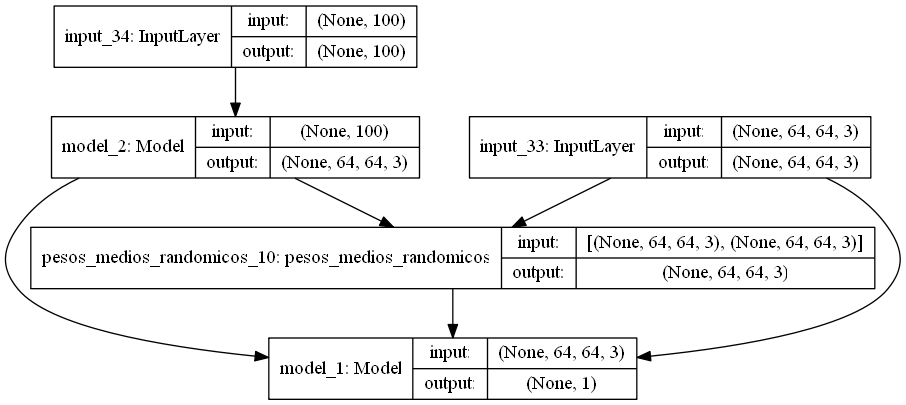

In [41]:
plot_model(modelo_critico, show_shapes= True)

In [ ]:
arq = 'C:/Users/pituc/Downloads/archive_(9)/img_align_celeba/img_align_celeba'
len(os.listdir(arq))

In [ ]:
def load_celeb(data_name, image_size, batch_size):
    data_folder = os.path.join("C:/Users/pituc/Downloads/archive_(9)/img_align_celeba", 'img_align_celeba')

    data_gen = ImageDataGenerator(preprocessing_function=lambda x: (x.astype('float32') - 127.5) / 127.5)

    x_train = data_gen.flow_from_directory(data_folder
                                            , target_size = (image_size,image_size)
                                            , batch_size = batch_size
                                            , shuffle = True
                                            , class_mode = 'input'
                                            , subset = "training"
                                                )

    return x_train

In [ ]:
x_train = load_celeb

In [ ]:
using_generator = True
if using_generator:
    true_imgs = next(x_train)[0]
    if true_imgs.shape[0] != batch_size:
        true_imgs = next(x_train)[0]

In [42]:
arq = 'C:/Users/pituc/Downloads/archive_(9)/img_align_celeba/img_align_celeba'
def trazer_mais_imagens(batch_size):
    n = 0
    index = 0
    celebridades = np.zeros(shape= (batch_size, 64, 64, 3))
    n_de_imagens = batch_size
    index_imagem = np.random.randint(0, len(os.listdir(arq)), n_de_imagens)
    nomes_imagem = np.array(os.listdir(arq))[index_imagem]  # para que peguemos os index precisamos que tanto a lista de index quanto a lista de imagens sejam arrays numpy pois vai dar erro se for uma lista python comum
    for img in nomes_imagem:
        imagem = cv2.imread(arq + '/' + img)
        imagem_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
        celebridade = cv2.resize(imagem_rgb, (64,64), interpolation= cv2.INTER_AREA)
        celebridades[index] = celebridade / 255
        index = index + 1
        n = n + 1
        if n == 100:
            print(index)
            n = 0
    return celebridades

In [43]:
import cv2
celebridades = trazer_mais_imagens(6000)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000


In [45]:
celebridades.shape

(6000, 64, 64, 3)

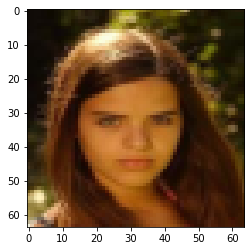

In [46]:
plt.imshow(celebridades[68])

In [47]:
'''

OK

'''
def treinar_modelo_critico():
    validos = np.ones(shape= (batch_size, 1))
    nao_validos = -np.ones(shape= (batch_size, 1))
    dummy = np.zeros(shape= (batch_size, 1))
    
    index_reais = np.random.randint(0, celebridades.shape[0], batch_size)
    imagens_reais = celebridades[index_reais]
    noise = np.random.normal(size= (batch_size, 100))
    #imagens_falsas = gerador.predict(noise)
    
    loss_critico = modelo_critico.train_on_batch([imagens_reais, noise], [validos, nao_validos, dummy]) # NÃO ESQUECE PORRA!!! DETRO DO MODELO_CRITICO JÁ TEM UM GERADOR QUE VAI PEGAR O NOISE, NÃO É PARA DAR A IMAGEM GERADA 
    return loss_critico

def treinar_gan():
    noise = np.random.normal(size= (batch_size, 100))
    #imagens_falsas = gerador.predict(noise)
    validos = np.ones(shape= (batch_size, 1))
    
    loss_gan = modelo_gan.train_on_batch(noise, validos)
    return loss_gan

In [48]:
'''

OK

'''
loss_critico_lista = list()
loss_gan_lista = list()

def treinar():
    for a in range(5):
        loss_critico = treinar_modelo_critico()
        loss_critico_lista.append(loss_critico)
        print(f'loss_critico: {loss_critico}')
    loss_gan = treinar_gan()  
    loss_gan_lista.append(loss_gan)
    print(f'loss_gan: {loss_gan}')

In [49]:
arquivo = 'C:/Users/pituc/modelos_wgan_gp'

In [50]:
modelos_criticos_celeb = 'C:/Users/pituc/modelos_wgan_gp/modelos_criticos_celeb'
modelos_geradores_celeb = 'C:/Users/pituc/modelos_wgan_gp/modelos_geradores_celeb'
modelos_model_criticos_celeb = 'C:/Users/pituc/modelos_wgan_gp/modelos_model_criticos_celeb'

In [51]:
'''

OK

'''
def salvar_modelos(epoca):
    gerador.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_geradores_celeb/gerador_{epoca}' )
    critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_criticos_celeb/critico_{epoca}')
    modelo_critico.save(f'C:/Users/pituc/modelos_wgan_gp/modelos_model_criticos_celeb/model_critico_{epoca}')

def salvar_imagens(epoca):
    c = l = 5
    
    noise = np.random.normal(size= (c*l , 100))
    imagens_geradas = gerador.predict(noise)
    
    imagens_geradas = 0.5 * (imagens_geradas + 1)
    imagens_geradas = np.clip(imagens_geradas, 0, 1)
    
    fig, axs = plt.subplots(l, c, figsize= (15,15))
    index = 0
    for i in range(l):
        for j in range(c):
            axs[i][j].imshow(np.squeeze(imagens_geradas[index, :, :, :]), cmap= 'gray_r')
            axs[i][j].axis('off')
            index = index + 1
    fig.savefig(f'C:/Users/pituc/modelos_wgan_gp/imagens_celebs/imagens_geradas_{epoca}')
    plt.close()

In [52]:
'''

OK

'''
epocas = 6000
n = 0
for epoca in range(epocas + 1):
    print(f'época: {epoca}')
    treinar()
    n = n + 1
    if n == 100:
        n = 0
        salvar_imagens(epoca + 1)
        salvar_modelos(epoca + 1)

época: 0
loss_critico: [8.243994, 0.075338796, -0.017118484, 0.81857735]


C:\Users\pituc\anacondabr\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


loss_critico: [7.4888253, -0.43633395, -0.0681708, 0.799333]
loss_critico: [6.1039877, -1.2702769, -0.20302407, 0.7577289]
loss_critico: [3.1724532, -3.096743, -0.54326224, 0.68124586]
loss_critico: [-3.4252882, -7.486584, -1.2674906, 0.5328787]
loss_gan: 2.7013192176818848
época: 1


C:\Users\pituc\anacondabr\envs\tensorflow\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


loss_critico: [-14.477081, -16.279625, -0.8118681, 0.2614413]
loss_critico: [-34.45501, -32.536793, -1.9820225, 0.006380598]
loss_critico: [-65.46634, -67.63559, -4.18902, 0.6358265]
loss_critico: [-76.89523, -114.77203, -8.356148, 4.6232953]
loss_critico: [-83.1545, -143.80145, -12.05916, 7.270611]
loss_gan: 13.635501861572266
época: 2
loss_critico: [-75.6293, -129.45908, 1.0872395, 5.274254]
loss_critico: [-91.89009, -115.00634, -6.8688583, 2.9985108]
loss_critico: [-85.85988, -109.700386, -12.462597, 3.63031]
loss_critico: [-98.523735, -130.70932, -13.174845, 4.5360436]
loss_critico: [-106.567154, -165.36142, -6.576329, 6.537059]
loss_gan: 4.957967758178711
época: 3
loss_critico: [-93.03619, -153.04765, 6.6512527, 5.3360205]
loss_critico: [-88.368416, -116.50294, -0.49611744, 2.8630636]
loss_critico: [-83.20607, -221.34021, 20.564878, 11.756926]
loss_critico: [-64.650085, -60.171967, -13.36694, 0.8888826]
loss_critico: [-93.15538, -132.25365, 3.302213, 3.5796056]
loss_gan: -16.29853

loss_critico: [-25.682001, -57.47482, 23.171751, 0.8621069]
loss_critico: [-29.033817, -52.259094, 15.171942, 0.80533326]
loss_critico: [-28.184254, -64.43033, 27.667366, 0.8578708]
loss_gan: -12.860788345336914
época: 26
loss_critico: [-24.98674, -51.55871, 16.600925, 0.99710417]
loss_critico: [-24.874126, -59.148247, 20.592813, 1.3681309]
loss_critico: [-26.99573, -18.213581, -16.867743, 0.8085592]
loss_critico: [-27.806664, -37.9368, 3.1323504, 0.69977844]
loss_critico: [-28.22727, -62.402065, 25.309214, 0.88655794]
loss_gan: -12.971837997436523
época: 27
loss_critico: [-21.958076, -51.09712, 18.309578, 1.0829464]
loss_critico: [-27.300459, -47.335457, 11.960211, 0.80747855]
loss_critico: [-26.536451, -52.85063, 16.467476, 0.98467046]
loss_critico: [-26.042324, -81.19168, 43.634556, 1.1514802]
loss_critico: [-29.05236, -31.174368, -5.2029715, 0.7324979]
loss_gan: 3.9802722930908203
época: 28
loss_critico: [-26.490067, -34.22279, -0.40888694, 0.81416094]
loss_critico: [-27.116869, -4

loss_critico: [-9.998975, -56.356293, 43.445774, 0.29115438]
loss_critico: [-10.334521, -45.479813, 33.314507, 0.1830785]
loss_critico: [-12.477178, -25.782635, 12.189625, 0.111583225]
loss_gan: -3.8934743404388428
época: 50
loss_critico: [-8.10544, -17.977114, 8.16927, 0.17024037]
loss_critico: [-8.96604, -23.830051, 13.147225, 0.17167865]
loss_critico: [-10.892203, -42.747246, 29.97803, 0.1877013]
loss_critico: [-11.831165, -39.72531, 26.010704, 0.18834415]
loss_critico: [-12.5990095, -37.691406, 23.2314, 0.18609972]
loss_gan: -14.133551597595215
época: 51
loss_critico: [-9.247129, -29.457829, 18.252007, 0.1958692]
loss_critico: [-9.67016, -28.929707, 17.56361, 0.16959366]
loss_critico: [-11.666144, -27.611923, 14.445204, 0.15005751]
loss_critico: [-13.371775, -21.943092, 6.9535604, 0.16177575]
loss_critico: [-13.785305, -25.84145, 10.10173, 0.19544148]
loss_gan: -8.669602394104004
época: 52
loss_critico: [-9.335824, -26.409771, 14.256941, 0.28170064]
loss_critico: [-11.4617405, -20.

loss_critico: [-11.595382, -59.218765, 45.33786, 0.22855234]
loss_critico: [-12.551062, -50.557346, 35.836914, 0.21693704]
loss_critico: [-13.117594, -55.48746, 40.01832, 0.23515487]
loss_critico: [-12.821371, -61.371758, 45.547375, 0.30030113]
loss_gan: -41.73147201538086
época: 74
loss_critico: [-9.359911, -58.256783, 45.71145, 0.3185423]
loss_critico: [-12.852243, -71.169624, 55.929497, 0.23878843]
loss_critico: [-11.181047, -86.57614, 70.89314, 0.45019513]
loss_critico: [-12.995474, -62.597496, 47.285126, 0.23168969]
loss_critico: [-10.191715, -42.37869, 29.930468, 0.22565064]
loss_gan: -37.75437927246094
época: 75
loss_critico: [-10.23869, -54.085808, 41.41557, 0.24315481]
loss_critico: [-11.53407, -48.56372, 34.612473, 0.24171779]
loss_critico: [-12.133394, -52.86521, 38.893864, 0.18379535]
loss_critico: [-9.416239, -72.78737, 60.96065, 0.24104783]
loss_critico: [-12.050926, -51.748207, 37.825043, 0.18722385]
loss_gan: -32.33404541015625
época: 76
loss_critico: [-7.9307604, -45.9

loss_critico: [-7.9021077, -47.940437, 38.064987, 0.19733423]
loss_critico: [-10.359848, -54.395023, 42.59838, 0.14367941]
loss_critico: [-9.964253, -57.035706, 45.69442, 0.13770323]
loss_critico: [-9.430309, -56.959538, 46.07895, 0.14502788]
loss_gan: -27.93402862548828
época: 98
loss_critico: [-7.320027, -40.902264, 31.665844, 0.19163927]
loss_critico: [-6.993597, -32.21358, 23.38271, 0.18372747]
loss_critico: [-8.687214, -42.766113, 33.040863, 0.10380366]
loss_critico: [-8.91175, -44.82174, 34.978775, 0.093121395]
loss_critico: [-8.900418, -53.208153, 43.202744, 0.1104991]
loss_gan: -53.30206298828125
época: 99
loss_critico: [-7.6121635, -64.756, 55.742813, 0.14010203]
loss_critico: [-7.356387, -68.7726, 60.103912, 0.13122986]
loss_critico: [-9.44231, -61.78032, 51.267612, 0.10703969]
loss_critico: [-9.3089485, -52.86315, 42.230713, 0.13234897]
loss_critico: [-10.670469, -63.390377, 51.604706, 0.11152017]
loss_gan: -50.65031051635742
época: 100
loss_critico: [-8.387167, -62.759705, 

loss_critico: [-8.865309, -73.39673, 63.118412, 0.14130074]
loss_critico: [-9.404474, -56.09327, 44.779694, 0.1909101]
loss_critico: [-9.510325, -54.370316, 43.01065, 0.18493396]
loss_gan: -51.771080017089844
época: 122
loss_critico: [-7.695633, -62.53772, 53.441837, 0.14002496]
loss_critico: [-7.9929523, -65.403564, 56.065113, 0.13454989]
loss_critico: [-8.801966, -76.70331, 66.87899, 0.102235235]
loss_critico: [-9.29779, -75.242874, 64.85869, 0.10863959]
loss_critico: [-9.277794, -65.59213, 55.13582, 0.11785199]
loss_gan: -49.460575103759766
época: 123
loss_critico: [-8.857963, -61.732628, 51.26949, 0.16051757]
loss_critico: [-8.091072, -45.564453, 35.2109, 0.2262482]
loss_critico: [-8.866844, -48.105186, 37.729507, 0.1508835]
loss_critico: [-8.948347, -51.538086, 41.35489, 0.12348496]
loss_critico: [-9.795478, -58.990612, 48.191154, 0.100397944]
loss_gan: -38.16944885253906
época: 124
loss_critico: [-6.323333, -47.866703, 39.978333, 0.15650377]
loss_critico: [-8.383045, -65.27173, 5

loss_critico: [-10.337743, -79.11639, 67.25202, 0.15266214]
loss_critico: [-8.502457, -67.54304, 57.309418, 0.17311636]
loss_gan: -68.82109069824219
época: 146
loss_critico: [-7.6264424, -79.374954, 70.39688, 0.13516307]
loss_critico: [-9.164905, -69.04648, 58.43168, 0.14498946]
loss_critico: [-9.1671, -57.76826, 46.90242, 0.16987412]
loss_critico: [-8.335427, -56.476166, 46.674244, 0.14664945]
loss_critico: [-9.536112, -64.5721, 54.00945, 0.10265371]
loss_gan: -52.603797912597656
época: 147
loss_critico: [-8.186828, -63.41439, 54.14752, 0.10800448]
loss_critico: [-9.726149, -58.362213, 47.370087, 0.12659782]
loss_critico: [-6.650775, -45.462357, 36.198605, 0.26129773]
loss_critico: [-9.430252, -56.463142, 45.809784, 0.12231059]
loss_critico: [-9.52546, -65.512955, 54.811237, 0.11762568]
loss_gan: -51.662654876708984
época: 148
loss_critico: [-7.843535, -61.882866, 52.76318, 0.12761512]
loss_critico: [-8.408045, -80.227745, 70.624374, 0.119532615]
loss_critico: [-9.719917, -67.83922, 5

loss_critico: [-8.551374, -74.2834, 64.46513, 0.12668931]
loss_gan: -61.8482666015625
época: 170
loss_critico: [-6.446165, -72.94091, 64.82038, 0.16743642]
loss_critico: [-8.107014, -81.2837, 72.52116, 0.065552905]
loss_critico: [-6.706805, -90.08473, 82.4155, 0.096242994]
loss_critico: [-8.820582, -84.01998, 74.3513, 0.08480956]
loss_critico: [-8.709375, -79.51314, 69.87599, 0.09277708]
loss_gan: -69.89236450195312
época: 171
loss_critico: [-7.6999154, -79.86271, 71.03844, 0.11243567]
loss_critico: [-7.8589635, -78.27319, 69.283905, 0.11303249]
loss_critico: [-8.640588, -82.21729, 72.52951, 0.104719445]
loss_critico: [-7.5856214, -83.94852, 75.24727, 0.111562684]
loss_critico: [-8.046653, -69.365845, 60.140877, 0.11783149]
loss_gan: -59.14927291870117
época: 172
loss_critico: [-7.1438627, -69.07208, 60.889946, 0.1038274]
loss_critico: [-7.637721, -73.58085, 64.973175, 0.09699528]
loss_critico: [-7.414532, -67.27055, 58.96828, 0.08877407]
loss_critico: [-8.262387, -64.448, 55.328766, 0

loss_critico: [-7.0355973, -83.67612, 75.82948, 0.081103675]
loss_critico: [-7.383895, -83.544525, 75.26483, 0.08957988]
loss_critico: [-7.4822197, -83.73462, 75.41555, 0.08368492]
loss_critico: [-7.574478, -79.81389, 71.03766, 0.12017515]
loss_critico: [-7.0706105, -76.20932, 67.91562, 0.12230906]
loss_gan: -70.79247283935547
época: 195
loss_critico: [-7.4643874, -79.65747, 71.1058, 0.10872865]
loss_critico: [-7.126434, -81.995285, 73.960526, 0.09083258]
loss_critico: [-7.6363025, -90.54666, 81.93181, 0.09785503]
loss_critico: [-6.3185606, -85.60826, 78.39459, 0.08951081]
loss_critico: [-6.2880354, -71.6128, 63.271557, 0.2053208]
loss_gan: -66.43147277832031
época: 196
loss_critico: [-6.229414, -75.386314, 68.11377, 0.104313076]
loss_critico: [-6.150555, -82.90969, 75.6994, 0.1059734]
loss_critico: [-6.841741, -78.77994, 71.299225, 0.063897185]
loss_critico: [-7.1872625, -76.09598, 68.38113, 0.052758887]
loss_critico: [-7.1469665, -79.36467, 71.49182, 0.07258819]
loss_gan: -71.6696166

loss_critico: [-7.39242, -95.03366, 86.81694, 0.082430065]
loss_critico: [-3.5674067, -90.86924, 86.24908, 0.10527564]
loss_critico: [-6.9954696, -63.16098, 55.001083, 0.11644274]
loss_critico: [-7.914736, -57.560062, 48.2123, 0.14330271]
loss_gan: -46.08303451538086
época: 219
loss_critico: [-5.8165355, -55.397255, 48.16222, 0.14184994]
loss_critico: [-5.905346, -54.960022, 48.076195, 0.09784812]
loss_critico: [-5.9565663, -59.36837, 52.8788, 0.053300418]
loss_critico: [-7.404151, -66.92958, 59.16516, 0.036026858]
loss_critico: [-6.2931576, -71.48067, 64.77668, 0.041082945]
loss_gan: -57.82014846801758
época: 220
loss_critico: [-3.8674238, -65.18311, 60.483185, 0.08325045]
loss_critico: [-5.348373, -78.778946, 73.063484, 0.03670887]
loss_critico: [-5.8690195, -94.45987, 88.04814, 0.05427082]
loss_critico: [-8.259618, -94.883095, 86.07332, 0.055015855]
loss_critico: [-5.7210646, -106.87926, 100.08629, 0.10719041]
loss_gan: -88.79817199707031
época: 221
loss_critico: [-5.5797276, -96.28

loss_critico: [-7.278653, -87.26088, 79.20618, 0.077604964]
loss_critico: [-5.1301746, -91.33704, 85.168686, 0.1038183]
loss_critico: [-5.8856864, -80.17124, 73.577896, 0.07076594]
loss_critico: [-5.5310316, -68.9338, 62.418552, 0.098421596]
loss_gan: -65.88276672363281
época: 243
loss_critico: [-5.7790875, -72.751144, 66.53435, 0.043770935]
loss_critico: [-5.9580555, -76.59263, 70.22198, 0.041259564]
loss_critico: [-6.8546247, -80.86714, 73.2251, 0.07874192]
loss_critico: [-5.5860243, -88.308044, 81.88008, 0.084193915]
loss_critico: [-7.314698, -82.89093, 74.83579, 0.074043944]
loss_gan: -81.29278564453125
época: 244
loss_critico: [-5.7333784, -88.564575, 82.16281, 0.06683858]
loss_critico: [-6.849448, -82.74123, 75.27734, 0.061443433]
loss_critico: [-6.7537117, -77.798416, 70.159805, 0.088489935]
loss_critico: [-6.0365295, -75.508896, 68.30319, 0.116917446]
loss_critico: [-7.071515, -86.71279, 79.01882, 0.062245447]
loss_gan: -77.99537658691406
época: 245
loss_critico: [-4.626632, -8

loss_critico: [-6.0989833, -87.64509, 80.9742, 0.057190746]
loss_critico: [-5.4262543, -90.901024, 83.714554, 0.17602158]
loss_critico: [-5.3725405, -89.84691, 84.11345, 0.0360919]
loss_critico: [-5.821618, -81.30597, 75.14859, 0.03357609]
loss_gan: -67.98442077636719
época: 267
loss_critico: [-4.727765, -73.836624, 68.63528, 0.04735823]
loss_critico: [-4.5682144, -65.15365, 59.44695, 0.11384849]
loss_critico: [-4.7525415, -72.689575, 66.76326, 0.1173774]
loss_critico: [-6.081539, -69.26193, 62.94646, 0.023393266]
loss_critico: [-6.434594, -72.3511, 65.59549, 0.03210134]
loss_gan: -69.49151611328125
época: 268
loss_critico: [-4.542904, -76.14824, 71.03508, 0.057025544]
loss_critico: [-5.1970243, -67.3205, 61.460957, 0.06625223]
loss_critico: [-8.277866, -68.53961, 59.492744, 0.07690007]
loss_critico: [-2.9962463, -58.17857, 53.408325, 0.17739983]
loss_critico: [-6.4384494, -67.24038, 60.19895, 0.060297836]
loss_gan: -58.916751861572266
época: 269
loss_critico: [-3.960543, -64.65125, 60

loss_critico: [-5.2631893, -84.67638, 78.92583, 0.048736013]
loss_critico: [-5.425818, -75.83501, 70.03939, 0.036979817]
loss_critico: [-5.6570215, -76.849686, 70.00246, 0.119020745]
loss_critico: [-6.285661, -75.30539, 68.44765, 0.057208117]
loss_gan: -67.86642456054688
época: 291
loss_critico: [-5.6009474, -75.62344, 69.26903, 0.07534687]
loss_critico: [-6.1118784, -74.75638, 68.12015, 0.05243521]
loss_critico: [-5.2403197, -73.39192, 67.589226, 0.05623764]
loss_critico: [-5.6848383, -77.66271, 71.14073, 0.083714195]
loss_critico: [-6.063768, -87.33446, 80.58005, 0.06906418]
loss_gan: -84.42447662353516
época: 292
loss_critico: [-4.714174, -90.9499, 85.75032, 0.048540346]
loss_critico: [-6.162721, -85.14324, 78.24419, 0.07363343]
loss_critico: [-5.373032, -82.5569, 76.37889, 0.08049771]
loss_critico: [-6.408595, -79.22349, 71.93335, 0.088154316]
loss_critico: [-5.9551744, -74.04807, 66.81925, 0.12736465]
loss_gan: -67.87147521972656
época: 293
loss_critico: [-5.241791, -74.02313, 68.

loss_critico: [-5.8542166, -72.54939, 66.1924, 0.05027782]
loss_critico: [-5.5736423, -73.19529, 67.13965, 0.0481999]
loss_critico: [-6.4147396, -79.925, 73.18393, 0.032633416]
loss_critico: [-6.292112, -91.468506, 84.45598, 0.072041556]
loss_gan: -91.01979064941406
época: 315
loss_critico: [-1.9210839, -96.11316, 93.2374, 0.095467895]
loss_critico: [-5.3106756, -77.096985, 71.2897, 0.04966057]
loss_critico: [-5.5552144, -73.670456, 67.52308, 0.059216265]
loss_critico: [-5.465666, -69.16231, 63.10306, 0.059358]
loss_critico: [-5.9151855, -69.334595, 62.93273, 0.04866777]
loss_gan: -62.125213623046875
época: 316
loss_critico: [-4.9680576, -69.073296, 63.579643, 0.052559495]
loss_critico: [-4.512089, -62.970245, 57.551235, 0.09069212]
loss_critico: [-5.1337156, -64.65939, 58.662334, 0.08633435]
loss_critico: [-5.2160797, -69.27934, 63.488987, 0.057427585]
loss_critico: [-6.173675, -77.16139, 70.773026, 0.021469159]
loss_gan: -72.90880584716797
época: 317
loss_critico: [-4.5042634, -79.10

loss_critico: [-5.4188576, -71.90593, 66.24797, 0.023910163]
loss_critico: [-6.0170836, -71.953094, 65.46599, 0.047002252]
loss_critico: [-5.467128, -68.68049, 62.706818, 0.050654292]
loss_critico: [-5.0769014, -67.88083, 62.141136, 0.066279136]
loss_gan: -65.08047485351562
época: 339
loss_critico: [-4.967207, -72.16022, 66.59341, 0.059960373]
loss_critico: [-5.1914816, -80.09332, 74.55739, 0.03444528]
loss_critico: [-5.929863, -82.13748, 75.71765, 0.048996754]
loss_critico: [-5.944842, -78.754005, 71.59018, 0.12189843]
loss_critico: [-6.082106, -77.462204, 70.69691, 0.06831907]
loss_gan: -70.17266845703125
época: 340
loss_critico: [-4.927622, -76.7841, 71.34476, 0.05117245]
loss_critico: [-5.2992454, -92.91551, 87.10962, 0.050664764]
loss_critico: [-2.7918944, -92.9662, 89.16794, 0.10063692]
loss_critico: [-6.3153543, -85.89096, 79.16981, 0.040579878]
loss_critico: [-6.3651533, -88.61476, 81.68225, 0.056735694]
loss_gan: -84.24705505371094
época: 341
loss_critico: [-5.100684, -91.4118

loss_critico: [-6.7602, -80.28565, 73.25397, 0.027148472]
loss_critico: [-6.5414276, -92.80047, 85.26811, 0.099092886]
loss_critico: [-4.666365, -95.1205, 89.10457, 0.13495651]
loss_critico: [-3.6544251, -83.08258, 78.56665, 0.08615051]
loss_gan: -64.72001647949219
época: 363
loss_critico: [-4.5686846, -70.994484, 66.02568, 0.040011875]
loss_critico: [-4.688207, -64.39682, 59.379005, 0.032960765]
loss_critico: [-5.252449, -71.53099, 65.992355, 0.028618626]
loss_critico: [-5.180307, -80.68552, 75.0105, 0.04947112]
loss_critico: [-6.118052, -83.84373, 76.73941, 0.09862646]
loss_gan: -75.5908432006836
época: 364
loss_critico: [-3.3583639, -80.5048, 76.69026, 0.045617312]
loss_critico: [-5.378533, -72.59592, 66.97506, 0.024232414]
loss_critico: [-4.999395, -75.00233, 69.68821, 0.031472273]
loss_critico: [-5.2881074, -77.3986, 71.44803, 0.066246174]
loss_critico: [-5.7059307, -73.01822, 66.66715, 0.06451359]
loss_gan: -66.991943359375
época: 365
loss_critico: [-4.71406, -73.4156, 67.891464,

loss_critico: [-5.1370277, -75.47627, 70.04752, 0.029172126]
loss_critico: [-6.4869795, -83.487656, 76.46698, 0.053369623]
loss_critico: [-5.2018466, -89.01356, 82.94594, 0.08657727]
loss_critico: [-5.155201, -88.18526, 82.16429, 0.08657648]
loss_gan: -81.77993774414062
época: 387
loss_critico: [-5.012923, -89.29498, 83.71509, 0.056697235]
loss_critico: [-6.0425434, -94.04162, 87.30671, 0.06923659]
loss_critico: [-3.988119, -95.58975, 90.535095, 0.10665381]
loss_critico: [-1.4744309, -78.53023, 76.48291, 0.05728866]
loss_critico: [-5.4844484, -67.35741, 61.564735, 0.030822283]
loss_gan: -59.9488525390625
época: 388
loss_critico: [-4.7384305, -65.91756, 60.823586, 0.035554055]
loss_critico: [-6.000445, -71.90837, 65.27945, 0.062847674]
loss_critico: [-4.40593, -77.052155, 72.14838, 0.049784817]
loss_critico: [-4.982551, -76.013885, 70.734245, 0.029708892]
loss_critico: [-6.4357576, -72.51232, 65.466705, 0.060985837]
loss_gan: -71.88369750976562
época: 389
loss_critico: [-4.2444353, -77.

loss_critico: [-4.9992175, -67.37578, 61.77175, 0.060480945]
loss_critico: [-4.6128716, -65.49342, 60.324833, 0.055571888]
loss_critico: [-5.1254344, -65.4919, 59.936222, 0.043024123]
loss_critico: [-5.0760164, -67.13584, 61.6325, 0.0427325]
loss_critico: [-5.2636867, -69.48181, 63.516907, 0.070121795]
loss_gan: -67.81017303466797
época: 411
loss_critico: [-4.460363, -73.48035, 68.721695, 0.029828876]
loss_critico: [-5.3072333, -76.22073, 70.63748, 0.027601844]
loss_critico: [-5.107683, -68.81048, 62.71585, 0.0986944]
loss_critico: [-5.2386613, -70.24361, 64.435776, 0.05691697]
loss_critico: [-5.5560403, -69.916725, 63.682, 0.067868575]
loss_gan: -63.329917907714844
época: 412
loss_critico: [-4.880413, -69.91505, 64.49089, 0.054374307]
loss_critico: [-5.8878345, -72.52983, 66.21527, 0.04267253]
loss_critico: [-4.495297, -69.3859, 64.284164, 0.060644098]
loss_critico: [-5.7248125, -73.77932, 67.566635, 0.048787225]
loss_critico: [-5.4950676, -85.23851, 78.94118, 0.080226496]
loss_gan: -

loss_critico: [-3.7877884, -60.32865, 55.43299, 0.1107872]
loss_critico: [-4.871888, -71.74992, 66.54357, 0.03344639]
loss_critico: [-5.836955, -75.53125, 69.088524, 0.060577117]
loss_critico: [-4.602793, -71.47813, 66.00241, 0.087292224]
loss_critico: [-5.817765, -75.959625, 69.753525, 0.03883351]
loss_gan: -78.83320617675781
época: 435
loss_critico: [-6.2834673, -86.58899, 79.89694, 0.04085798]
loss_critico: [-4.222118, -92.32706, 87.54224, 0.056270253]
loss_critico: [-4.690834, -93.715576, 87.81677, 0.12079699]
loss_critico: [-4.4965773, -86.8101, 81.558044, 0.07554751]
loss_critico: [-4.208572, -74.80203, 70.03662, 0.05568396]
loss_gan: -64.43399047851562
época: 436
loss_critico: [-4.756983, -70.24165, 65.15411, 0.033055697]
loss_critico: [-4.6302705, -71.97793, 67.05194, 0.02957169]
loss_critico: [-5.8420763, -74.72984, 68.59781, 0.028995823]
loss_critico: [-5.1666565, -80.03561, 74.42087, 0.044808175]
loss_critico: [-5.2977786, -83.7847, 77.919754, 0.0567166]
loss_gan: -78.087280

loss_critico: [-3.6780465, -64.201996, 60.20867, 0.03152779]
loss_critico: [-4.6611414, -61.411526, 56.427437, 0.032294743]
loss_critico: [-5.320535, -59.56742, 53.84176, 0.040512722]
loss_critico: [-3.7132993, -57.923836, 53.114674, 0.109586276]
loss_critico: [-5.3488965, -65.70249, 60.040424, 0.03131707]
loss_gan: -65.12918090820312
época: 459
loss_critico: [-4.163918, -70.589066, 66.02269, 0.04024577]
loss_critico: [-4.969428, -70.262245, 64.84795, 0.044486314]
loss_critico: [-4.813485, -73.936424, 68.60684, 0.05160968]
loss_critico: [-4.67876, -71.74394, 66.41175, 0.06534316]
loss_critico: [-5.6749268, -77.00041, 71.001274, 0.0324211]
loss_gan: -71.81189727783203
época: 460
loss_critico: [-4.4133, -77.629135, 72.7124, 0.05034326]
loss_critico: [-4.640997, -78.69913, 73.624435, 0.04336951]
loss_critico: [-4.6601524, -82.40825, 76.9729, 0.0775196]
loss_critico: [-5.28256, -75.28548, 69.10498, 0.08979365]
loss_critico: [-5.1435456, -76.11656, 70.31429, 0.06587233]
loss_gan: -74.603057

loss_critico: [-3.5891545, -85.783844, 81.70267, 0.049202226]
loss_critico: [-5.4258723, -80.29076, 74.32328, 0.05416036]
loss_critico: [-5.7998266, -83.65219, 77.279175, 0.057319]
loss_critico: [-5.472926, -89.46851, 83.48516, 0.05104263]
loss_critico: [-6.204599, -87.16318, 80.21405, 0.07445281]
loss_gan: -82.41546630859375
época: 483
loss_critico: [-2.639641, -87.933945, 84.771484, 0.05228193]
loss_critico: [-3.1936448, -76.507, 73.06308, 0.025027927]
loss_critico: [-4.954339, -69.39394, 64.270706, 0.016889844]
loss_critico: [-4.4834037, -71.605316, 66.74638, 0.037552863]
loss_critico: [-4.8819413, -67.00526, 61.160004, 0.09633115]
loss_gan: -57.57670974731445
época: 484
loss_critico: [-3.772158, -62.96958, 58.44666, 0.07507645]
loss_critico: [-3.283162, -59.485886, 55.858734, 0.034398932]
loss_critico: [-4.661911, -67.95658, 62.892273, 0.04023972]
loss_critico: [-5.320101, -67.86511, 62.180687, 0.036432482]
loss_critico: [-5.3101325, -69.32447, 63.58201, 0.04323298]
loss_gan: -66.4

loss_critico: [-3.5887907, -60.445175, 56.603592, 0.025279254]
loss_critico: [-4.5581064, -63.369827, 58.720043, 0.009167772]
loss_critico: [-5.2637033, -69.00821, 63.588768, 0.015573796]
loss_critico: [-6.0047765, -72.84136, 66.30665, 0.052993737]
loss_critico: [-5.5894017, -75.59418, 69.15385, 0.08509287]
loss_gan: -68.58930969238281
época: 507
loss_critico: [-4.503433, -75.21566, 69.95039, 0.0761833]
loss_critico: [-4.8103585, -67.50151, 62.087334, 0.06038183]
loss_critico: [-4.635877, -67.39148, 62.23032, 0.052528232]
loss_critico: [-4.8055654, -67.36508, 62.00385, 0.05556672]
loss_critico: [-5.4185047, -70.35889, 64.534546, 0.040583625]
loss_gan: -64.4436264038086
época: 508
loss_critico: [-4.5936184, -70.55569, 65.4256, 0.053647026]
loss_critico: [-4.5630007, -74.13371, 69.28067, 0.029004201]
loss_critico: [-4.796575, -72.8376, 67.548874, 0.04921516]
loss_critico: [-5.931492, -76.86998, 70.21571, 0.07227747]
loss_critico: [-5.467642, -80.6983, 74.612335, 0.0618326]
loss_gan: -74.

loss_critico: [-4.443203, -72.97058, 67.88895, 0.063843146]
loss_critico: [-4.2587023, -74.66559, 69.57201, 0.08348799]
loss_critico: [-5.165497, -68.80084, 63.033623, 0.060172252]
loss_critico: [-5.2300563, -73.10219, 67.38447, 0.048766382]
loss_critico: [-5.7261486, -78.93715, 72.76688, 0.044412445]
loss_gan: -73.22035217285156
época: 531
loss_critico: [-3.0441334, -77.84199, 74.10626, 0.069159195]
loss_critico: [-4.1896143, -72.699844, 68.20549, 0.030473972]
loss_critico: [-4.719096, -64.584175, 59.373753, 0.049132627]
loss_critico: [-5.741169, -61.682594, 55.565784, 0.03756408]
loss_critico: [-4.5195055, -53.012527, 47.555286, 0.09377356]
loss_gan: -50.87218475341797
época: 532
loss_critico: [-4.566718, -56.673584, 51.247025, 0.08598411]
loss_critico: [-4.834144, -56.217407, 51.044907, 0.03383565]
loss_critico: [-5.380462, -59.441048, 53.755486, 0.030509993]
loss_critico: [-1.5539633, -47.186317, 44.44593, 0.11864237]
loss_critico: [-4.751228, -62.168606, 57.234306, 0.01830716]
los

loss_critico: [-4.4195666, -86.78391, 81.90461, 0.04597365]
loss_critico: [-4.341903, -88.984665, 84.12816, 0.051460326]
loss_critico: [-3.485871, -78.634315, 74.36124, 0.07872078]
loss_critico: [-5.737696, -66.549126, 60.20082, 0.061060842]
loss_critico: [-4.0785666, -66.845764, 62.407013, 0.036018487]
loss_gan: -61.49702453613281
época: 555
loss_critico: [-4.64261, -67.17943, 62.1356, 0.04012168]
loss_critico: [-4.0590672, -62.94137, 58.3423, 0.054000027]
loss_critico: [-4.6724515, -63.47999, 58.404495, 0.04030414]
loss_critico: [-6.0786495, -57.58573, 50.54273, 0.09643537]
loss_critico: [-5.132938, -56.997177, 50.90911, 0.09551284]
loss_gan: -48.43697738647461
época: 556
loss_critico: [-5.303761, -55.463272, 49.38524, 0.07742724]
loss_critico: [-4.4034195, -51.853073, 46.51548, 0.09341735]
loss_critico: [-5.623759, -54.413376, 48.333412, 0.04562048]
loss_critico: [-5.035858, -55.837494, 50.483887, 0.03177488]
loss_critico: [-5.2076993, -58.11275, 52.40551, 0.049954157]
loss_gan: -49

loss_critico: [-3.0857508, -67.10782, 63.748573, 0.027349442]
loss_critico: [-5.204458, -77.59883, 72.297066, 0.00973071]
loss_critico: [-4.7564297, -91.693535, 86.25995, 0.06771563]
loss_critico: [-4.2667136, -87.74853, 82.221725, 0.12600884]
loss_critico: [-3.6149526, -78.07008, 73.7973, 0.06578287]
loss_gan: -65.78046417236328
época: 579
loss_critico: [-4.161685, -70.613144, 66.20952, 0.024194028]
loss_critico: [-4.5199404, -67.92866, 63.238144, 0.01705733]
loss_critico: [-4.1777344, -67.916, 63.38474, 0.035352726]
loss_critico: [-4.8774495, -60.432102, 54.994965, 0.05596883]
loss_critico: [-5.710753, -64.18559, 58.104614, 0.037022546]
loss_gan: -56.10585021972656
época: 580
loss_critico: [-3.2678585, -61.15737, 57.34687, 0.054264266]
loss_critico: [-5.3487887, -67.6676, 62.081264, 0.023754925]
loss_critico: [-3.7141056, -67.129005, 63.06707, 0.034782983]
loss_critico: [-3.7212703, -59.278, 54.931885, 0.062484473]
loss_critico: [-4.9081903, -48.983677, 43.321335, 0.07541518]
loss_ga

loss_critico: [-4.4159307, -75.892204, 71.237976, 0.02382974]
loss_critico: [-4.431531, -78.54707, 73.779495, 0.033604726]
loss_critico: [-5.1817894, -73.70795, 68.15333, 0.037282933]
loss_critico: [-5.1112304, -74.25686, 68.32662, 0.08190065]
loss_critico: [-5.3673472, -75.58493, 69.8198, 0.03977819]
loss_gan: -69.14231872558594
época: 603
loss_critico: [-3.024622, -73.43838, 69.68704, 0.072671324]
loss_critico: [-4.9869146, -62.621128, 57.053856, 0.058035754]
loss_critico: [-4.568341, -62.76861, 57.765892, 0.043437522]
loss_critico: [-4.3665743, -66.83717, 61.78203, 0.0688571]
loss_critico: [-4.6842446, -70.932175, 65.78723, 0.04606987]
loss_gan: -54.54039001464844
época: 604
loss_critico: [-4.320075, -60.741043, 55.83177, 0.058919646]
loss_critico: [-4.1441364, -53.860416, 48.514816, 0.120146394]
loss_critico: [-5.342401, -58.266975, 52.13643, 0.078814544]
loss_critico: [-5.702815, -58.42493, 52.299137, 0.04229784]
loss_critico: [-4.6129565, -55.510563, 50.40178, 0.049582705]
loss_g

loss_critico: [-4.7159696, -62.129845, 56.649014, 0.07648614]
loss_critico: [-0.84408903, -50.6564, 48.339012, 0.14732976]
loss_critico: [-5.034525, -63.52751, 58.35679, 0.013619814]
loss_critico: [-4.7147145, -62.12791, 57.235023, 0.01781727]
loss_critico: [-4.3443503, -57.42179, 52.737263, 0.034017812]
loss_gan: -49.66767883300781
época: 627
loss_critico: [-5.5872035, -56.554977, 50.600533, 0.036724135]
loss_critico: [-3.0304976, -46.911953, 43.069695, 0.08117609]
loss_critico: [-5.0408287, -51.897285, 46.388573, 0.046788417]
loss_critico: [-5.4603767, -55.650433, 49.521736, 0.066831954]
loss_critico: [-3.6639745, -48.965088, 43.91016, 0.13909534]
loss_gan: -46.88149642944336
época: 628
loss_critico: [-4.1305656, -52.39698, 47.979786, 0.02866288]
loss_critico: [-3.7510893, -58.36917, 54.538376, 0.007970606]
loss_critico: [-4.388256, -69.70632, 65.10817, 0.0209896]
loss_critico: [-4.5666876, -71.77339, 66.45556, 0.07511453]
loss_critico: [-4.1735134, -69.543884, 65.20102, 0.016935147]

loss_critico: [-3.785934, -48.5363, 43.7057, 0.10446667]
loss_critico: [-4.3148155, -45.507957, 40.48436, 0.07087822]
loss_critico: [-1.941432, -46.89379, 44.38441, 0.05679483]
loss_critico: [-5.461494, -58.413895, 52.762993, 0.018940777]
loss_critico: [-4.8915215, -60.08634, 54.856102, 0.033871837]
loss_gan: -54.14752197265625
época: 651
loss_critico: [-3.289962, -59.53916, 55.58377, 0.066542886]
loss_critico: [-4.354919, -59.27179, 54.714996, 0.020187404]
loss_critico: [-4.0722065, -58.51722, 53.96707, 0.04779413]
loss_critico: [-5.2369347, -65.87283, 60.332638, 0.030326072]
loss_critico: [-5.2822666, -64.48224, 58.70515, 0.049482152]
loss_gan: -55.346954345703125
época: 652
loss_critico: [-2.673389, -60.63967, 57.30434, 0.0661942]
loss_critico: [-4.0285516, -56.407288, 52.17196, 0.02067772]
loss_critico: [-5.0059566, -56.054306, 50.553703, 0.0494646]
loss_critico: [-4.8463893, -59.147842, 53.52774, 0.077371255]
loss_critico: [-4.2489867, -51.494526, 46.054108, 0.11914314]
loss_gan: 

loss_critico: [-2.8093252, -66.24706, 63.162613, 0.027512463]
loss_critico: [-3.6395226, -52.87941, 48.816746, 0.04231416]
loss_critico: [-4.540577, -57.63685, 52.539738, 0.055653363]
loss_critico: [-4.509784, -62.656227, 57.72473, 0.042171154]
loss_critico: [-5.0046678, -68.90364, 63.48746, 0.04115119]
loss_gan: -67.893798828125
época: 675
loss_critico: [-2.7996902, -72.09602, 68.80102, 0.049531545]
loss_critico: [-4.0162525, -66.61773, 62.356876, 0.024460033]
loss_critico: [-4.6514587, -59.347916, 54.32234, 0.03741188]
loss_critico: [-4.9191923, -59.037506, 53.737946, 0.038036816]
loss_critico: [-4.601169, -57.361366, 52.12545, 0.063474715]
loss_gan: -50.57469177246094
época: 676
loss_critico: [-3.6332474, -56.31923, 51.93276, 0.07532233]
loss_critico: [-5.378808, -63.85776, 58.244865, 0.02340879]
loss_critico: [-4.975406, -67.47351, 62.070587, 0.04275173]
loss_critico: [-4.3421516, -65.17879, 59.981056, 0.08555794]
loss_critico: [-4.6914625, -62.702553, 57.345917, 0.066517346]
loss_

loss_critico: [-4.0505133, -56.783485, 52.419575, 0.03133972]
loss_critico: [-4.601818, -57.768574, 52.87342, 0.029333476]
loss_critico: [-4.566654, -59.665405, 54.654526, 0.044422537]
loss_critico: [-4.9120007, -62.854534, 57.663773, 0.027876085]
loss_critico: [-4.6853824, -64.503815, 59.40171, 0.041672163]
loss_gan: -58.661712646484375
época: 699
loss_critico: [-3.9152908, -63.772514, 59.382843, 0.04743804]
loss_critico: [-4.349687, -60.81678, 56.099033, 0.036805954]
loss_critico: [-4.2738533, -54.223694, 49.309612, 0.0640228]
loss_critico: [-4.356768, -54.76355, 49.96498, 0.044180058]
loss_critico: [-4.1907487, -63.67266, 59.2438, 0.023811083]
loss_gan: -55.06285095214844
época: 700
loss_critico: [-3.221119, -60.264847, 56.57984, 0.04638862]
loss_critico: [-4.6234527, -58.736805, 53.638924, 0.047442883]
loss_critico: [-5.1546097, -59.15145, 53.685608, 0.03112336]
loss_critico: [-4.049351, -56.5298, 51.563316, 0.09171329]
loss_critico: [-5.385051, -63.9749, 58.10206, 0.048779003]
los

loss_critico: [-3.695542, -68.358635, 64.30223, 0.036086194]
loss_critico: [-5.07552, -66.82636, 61.50439, 0.024645176]
loss_critico: [-5.7756124, -69.86188, 63.688793, 0.039747197]
loss_critico: [-3.5636609, -76.893585, 72.54585, 0.07840717]
loss_critico: [-5.3483434, -72.787674, 66.95324, 0.048609097]
loss_gan: -61.090816497802734
época: 723
loss_critico: [-2.647224, -65.88748, 62.796173, 0.044408455]
loss_critico: [-3.9062953, -54.88565, 50.38288, 0.059647404]
loss_critico: [-4.2656903, -52.569176, 47.70647, 0.05970148]
loss_critico: [-4.6362085, -56.723984, 51.765812, 0.032196328]
loss_critico: [-4.8102107, -56.503223, 51.344616, 0.034839697]
loss_gan: -49.698219299316406
época: 724
loss_critico: [-3.3207421, -54.986313, 50.961792, 0.070377864]
loss_critico: [-4.6587915, -52.650757, 47.62024, 0.037172608]
loss_critico: [-4.5562572, -51.87065, 46.68413, 0.06302622]
loss_critico: [-5.742662, -54.157936, 47.815834, 0.05994403]
loss_critico: [-4.123743, -49.639748, 44.53144, 0.09845637

loss_critico: [-2.506452, -49.874565, 46.673378, 0.069473505]
loss_gan: -53.60536193847656
época: 746
loss_critico: [-4.26948, -59.114998, 54.61188, 0.023363631]
loss_critico: [-4.4790354, -62.907784, 58.178623, 0.025012478]
loss_critico: [-5.2814555, -56.11477, 50.15451, 0.06788031]
loss_critico: [-4.9759293, -48.83322, 42.607174, 0.12501182]
loss_critico: [-4.0927844, -50.760975, 45.932213, 0.07359776]
loss_gan: -51.60606384277344
época: 747
loss_critico: [-4.2679715, -56.968887, 52.379265, 0.032165084]
loss_critico: [-4.1667385, -60.549377, 56.170856, 0.021178255]
loss_critico: [-4.0316706, -58.762238, 54.198936, 0.053163074]
loss_critico: [-4.7374063, -62.934067, 57.84489, 0.03517699]
loss_critico: [-4.2617693, -71.06381, 66.6389, 0.016314201]
loss_gan: -68.89927673339844
época: 748
loss_critico: [-3.8148403, -74.38075, 69.99921, 0.05667057]
loss_critico: [-3.9113853, -70.37928, 66.08647, 0.038142327]
loss_critico: [-4.3743925, -65.211975, 60.53073, 0.030685123]
loss_critico: [-4.2

loss_critico: [-4.5942683, -51.703785, 46.65201, 0.045750484]
loss_critico: [-4.5560613, -53.144867, 48.114365, 0.04744409]
loss_gan: -53.14814758300781
época: 770
loss_critico: [-4.788261, -58.70244, 53.61772, 0.029645603]
loss_critico: [-4.6090693, -58.86632, 53.761948, 0.04953047]
loss_critico: [-5.113987, -53.25194, 47.420624, 0.07173307]
loss_critico: [-4.908035, -51.606205, 46.038906, 0.0659264]
loss_critico: [-4.238487, -54.14011, 49.638153, 0.026347004]
loss_gan: -45.23460388183594
época: 771
loss_critico: [-4.122397, -49.90747, 45.35297, 0.04321035]
loss_critico: [-4.463709, -46.03882, 40.96864, 0.060647033]
loss_critico: [-4.8107443, -48.136837, 42.838448, 0.048764534]
loss_critico: [-6.3216004, -48.033493, 41.210682, 0.050121084]
loss_critico: [-3.857102, -42.984245, 38.19973, 0.092741355]
loss_gan: -42.48992156982422
época: 772
loss_critico: [-3.7227178, -47.88889, 43.5616, 0.060457174]
loss_critico: [-4.4645786, -53.298344, 48.612446, 0.022131938]
loss_critico: [-3.9998875

loss_critico: [-4.2031293, -49.137123, 44.832382, 0.010161163]
loss_critico: [-4.6991634, -55.308247, 50.323303, 0.02857802]
loss_critico: [-4.5827208, -56.345383, 51.306095, 0.045656696]
loss_gan: -52.754547119140625
época: 794
loss_critico: [-3.7143626, -57.983864, 53.783142, 0.04863592]
loss_critico: [-4.661376, -57.43602, 52.26823, 0.050641365]
loss_critico: [-4.556983, -52.536552, 47.27765, 0.07019204]
loss_critico: [-4.5649786, -51.99083, 46.731346, 0.069450475]
loss_critico: [-5.2170854, -58.41455, 52.636017, 0.056144867]
loss_gan: -53.14445495605469
época: 795
loss_critico: [-3.766916, -58.344574, 54.248493, 0.03291648]
loss_critico: [-5.25251, -65.164566, 59.57418, 0.033787545]
loss_critico: [-5.8448586, -69.67781, 63.464317, 0.03686349]
loss_critico: [-4.213509, -73.375374, 68.64562, 0.05162424]
loss_critico: [-3.568458, -69.35454, 65.29286, 0.04932179]
loss_gan: -49.08552932739258
época: 796
loss_critico: [-3.5950902, -54.179222, 49.966602, 0.06175296]
loss_critico: [-3.5458

loss_critico: [-5.1859565, -57.635742, 51.918026, 0.053175986]
loss_critico: [-4.718922, -64.32533, 59.12344, 0.048297063]
loss_critico: [-5.3593774, -61.360153, 55.672546, 0.03282295]
loss_critico: [-5.3019085, -61.067795, 55.258812, 0.050707422]
loss_gan: -56.596614837646484
época: 818
loss_critico: [-3.3697417, -62.3888, 58.37509, 0.06439683]
loss_critico: [-4.0651016, -53.368572, 48.767212, 0.05362586]
loss_critico: [-4.1437106, -48.538063, 43.75036, 0.06439939]
loss_critico: [-4.8636217, -53.067802, 47.829727, 0.03744535]
loss_critico: [-4.880709, -53.386135, 48.073177, 0.04322485]
loss_gan: -43.224525451660156
época: 819
loss_critico: [-3.805973, -49.322834, 44.72609, 0.07907714]
loss_critico: [-4.4257083, -51.181305, 46.00992, 0.07456784]
loss_critico: [-3.487091, -50.047096, 46.02102, 0.053898633]
loss_critico: [-4.786797, -50.242165, 45.24179, 0.021357689]
loss_critico: [-3.42075, -47.85668, 43.99899, 0.043694276]
loss_gan: -52.874481201171875
época: 820
loss_critico: [-4.5483

loss_critico: [-4.692058, -50.607857, 45.660362, 0.02554362]
loss_critico: [-4.306761, -52.60743, 48.070107, 0.02305621]
loss_critico: [-4.392283, -52.17485, 47.33235, 0.045021567]
loss_critico: [-3.9567108, -45.95851, 41.519165, 0.04826356]
loss_critico: [-5.240553, -54.23125, 48.528694, 0.04620037]
loss_gan: -51.31002426147461
época: 842
loss_critico: [-4.112468, -57.507435, 52.967735, 0.04272316]
loss_critico: [-3.1079218, -56.441437, 53.009666, 0.03238484]
loss_critico: [-4.5522428, -52.731705, 47.76912, 0.04103428]
loss_critico: [-4.502982, -49.79834, 44.66775, 0.06276065]
loss_critico: [-4.870327, -47.700813, 42.012638, 0.081784815]
loss_gan: -39.44220733642578
época: 843
loss_critico: [-3.0017781, -44.252777, 40.543343, 0.070765644]
loss_critico: [-4.7726297, -49.19294, 44.072422, 0.034788795]
loss_critico: [-4.264598, -50.20363, 45.570812, 0.03682182]
loss_critico: [-4.4744287, -51.809273, 46.971924, 0.036292046]
loss_critico: [-5.1771984, -56.294754, 50.66198, 0.04555761]
loss

loss_critico: [-4.8113647, -49.240036, 43.61704, 0.08116327]
loss_gan: -46.13825225830078
época: 865
loss_critico: [-4.232984, -52.09542, 47.49927, 0.036316533]
loss_critico: [-5.299142, -49.247063, 43.627502, 0.03204186]
loss_critico: [-3.6242073, -41.4893, 36.943466, 0.09216264]
loss_critico: [-4.2778697, -45.84317, 41.06629, 0.049900852]
loss_critico: [-5.398755, -49.21902, 43.477543, 0.034272287]
loss_gan: -41.07550811767578
época: 866
loss_critico: [-4.126108, -46.709167, 41.902786, 0.06802732]
loss_critico: [-4.5307, -46.67251, 41.5892, 0.055260904]
loss_critico: [-3.919056, -46.758385, 42.567963, 0.027136613]
loss_critico: [-3.577964, -45.28384, 41.37217, 0.03337066]
loss_critico: [-4.240846, -48.13095, 43.435425, 0.04546801]
loss_gan: -48.03935241699219
época: 867
loss_critico: [-3.5948782, -52.605713, 48.786682, 0.022415267]
loss_critico: [-5.067257, -60.165436, 54.89428, 0.02038992]
loss_critico: [-3.9402463, -65.15428, 60.737698, 0.047633763]
loss_critico: [-5.2794075, -60.4

loss_critico: [-5.544281, -49.7492, 43.685608, 0.051930986]
loss_critico: [-5.505628, -48.92533, 42.832726, 0.05869776]
loss_gan: -39.050655364990234
época: 889
loss_critico: [-4.0493107, -45.819206, 40.77355, 0.09963472]
loss_critico: [-3.6083167, -48.23697, 43.96777, 0.066088274]
loss_critico: [-5.213297, -53.757652, 48.152565, 0.039179027]
loss_critico: [-4.898495, -55.450264, 50.23189, 0.031987697]
loss_critico: [-4.67778, -54.35982, 49.207626, 0.047441468]
loss_gan: -53.86133575439453
época: 890
loss_critico: [-3.665007, -58.421856, 54.59039, 0.016645951]
loss_critico: [-3.759674, -55.81114, 51.102684, 0.09487802]
loss_critico: [-3.789425, -50.58363, 46.207153, 0.058705147]
loss_critico: [-4.0508423, -51.102783, 46.80797, 0.024397293]
loss_critico: [-4.5381894, -53.70809, 48.85999, 0.030991307]
loss_gan: -50.06645202636719
época: 891
loss_critico: [-3.5931623, -54.538643, 50.580452, 0.036502857]
loss_critico: [-3.78819, -61.529404, 57.611626, 0.012958825]
loss_critico: [-4.4535136

loss_critico: [-5.4757986, -35.092804, 29.06369, 0.055331536]
loss_critico: [-4.458193, -34.569283, 29.122568, 0.09885218]
loss_critico: [-4.1874332, -44.805965, 39.94239, 0.06761416]
loss_gan: -44.6638298034668
época: 913
loss_critico: [-4.244803, -49.90576, 45.125748, 0.053521115]
loss_critico: [-3.9743264, -46.295586, 41.647163, 0.06740958]
loss_critico: [-3.9530516, -46.69639, 42.32496, 0.04183778]
loss_critico: [-4.400192, -47.163082, 42.549477, 0.02134135]
loss_critico: [-4.5780673, -45.639843, 40.848366, 0.021340992]
loss_gan: -42.66658020019531
época: 914
loss_critico: [-3.6273122, -47.61782, 43.625443, 0.036506593]
loss_critico: [-4.7261786, -54.445057, 49.55726, 0.016161952]
loss_critico: [-5.2307343, -54.69365, 48.846786, 0.061612852]
loss_critico: [-4.924247, -53.278427, 47.886967, 0.046721347]
loss_critico: [-5.042396, -50.327377, 44.875412, 0.040956922]
loss_gan: -48.63020324707031
época: 915
loss_critico: [-4.1106873, -54.333584, 49.795143, 0.042775337]
loss_critico: [-3

loss_critico: [-4.3893332, -42.04617, 37.28704, 0.03697954]
loss_critico: [-2.5978906, -36.036606, 32.60748, 0.08312361]
loss_critico: [-2.9336894, -44.792435, 41.626953, 0.023179218]
loss_critico: [-5.1803985, -56.988792, 51.72184, 0.008655382]
loss_gan: -56.16511535644531
época: 937
loss_critico: [-2.7577162, -61.292366, 58.24749, 0.028715996]
loss_critico: [-4.0677567, -58.20161, 53.88801, 0.024584591]
loss_critico: [-3.621922, -52.56446, 48.596428, 0.03461107]
loss_critico: [-4.328143, -46.61255, 41.853676, 0.04307299]
loss_critico: [-4.526661, -44.54653, 39.611717, 0.04081533]
loss_gan: -40.70282745361328
época: 938
loss_critico: [-4.4344697, -46.34793, 41.501236, 0.041222524]
loss_critico: [-4.0012245, -46.813126, 42.491398, 0.032050304]
loss_critico: [-4.188667, -44.099358, 39.53511, 0.037558015]
loss_critico: [-4.7233453, -42.121544, 36.764748, 0.06334508]
loss_critico: [-5.0797324, -43.157486, 37.424553, 0.065320075]
loss_gan: -37.846961975097656
época: 939
loss_critico: [-4.1

loss_critico: [-3.2897909, -46.233685, 42.31285, 0.06310427]
loss_critico: [-3.6599133, -43.43477, 39.486397, 0.02884585]
loss_critico: [-5.9548826, -44.089687, 37.727356, 0.0407449]
loss_critico: [-4.752725, -40.65545, 35.225166, 0.06775574]
loss_critico: [-5.211244, -40.85293, 34.730877, 0.0910807]
loss_gan: -38.34864044189453
época: 961
loss_critico: [-4.9161415, -44.54707, 38.863026, 0.07679024]
loss_critico: [-3.7827227, -44.03851, 39.762985, 0.049280144]
loss_critico: [-4.7863636, -48.653084, 43.58838, 0.027834129]
loss_critico: [-4.5594296, -46.71322, 41.647564, 0.05062253]
loss_critico: [-4.8022075, -44.34573, 39.15576, 0.038776077]
loss_gan: -43.10087585449219
época: 962
loss_critico: [-3.8883948, -48.32569, 44.037098, 0.040019847]
loss_critico: [-4.3837786, -50.677658, 45.89458, 0.039929878]
loss_critico: [-4.495584, -50.84179, 45.55323, 0.07929748]
loss_critico: [-4.790987, -51.645912, 46.46249, 0.039243504]
loss_critico: [-5.016316, -51.740623, 46.295982, 0.042832524]
loss_

loss_critico: [-3.752304, -41.54425, 37.6032, 0.018874733]
loss_critico: [-4.3559895, -43.762634, 39.11799, 0.028865624]
loss_critico: [-4.821355, -45.558876, 40.51336, 0.0224162]
loss_critico: [-5.3023286, -47.382763, 41.571114, 0.05093207]
loss_critico: [-5.4717503, -56.00978, 49.890125, 0.06479052]
loss_gan: -55.19133758544922
época: 985
loss_critico: [-2.4806838, -59.059334, 56.12741, 0.04512391]
loss_critico: [-5.5192733, -53.43666, 47.60479, 0.031259757]
loss_critico: [-4.4172983, -48.88051, 43.759857, 0.07033527]
loss_critico: [-3.68826, -45.756195, 41.657463, 0.041047197]
loss_critico: [-4.4604855, -43.29718, 38.618217, 0.021847734]
loss_gan: -37.329864501953125
época: 986
loss_critico: [-4.068592, -42.294724, 37.91574, 0.031039035]
loss_critico: [-4.998351, -40.64189, 35.23284, 0.04106991]
loss_critico: [-4.9010987, -39.290787, 33.746483, 0.06432053]
loss_critico: [-5.1122594, -41.784622, 36.256393, 0.04159692]
loss_critico: [-5.208763, -43.55503, 37.84739, 0.049887873]
loss_g

loss_critico: [-4.747679, -39.119007, 33.889072, 0.04822555]
loss_gan: -38.28394317626953
época: 1008
loss_critico: [-4.3555326, -43.54751, 38.808407, 0.03835685]
loss_critico: [-3.967274, -43.05999, 38.712723, 0.037999325]
loss_critico: [-5.146109, -42.297897, 36.805458, 0.034633003]
loss_critico: [-4.2795663, -45.804745, 41.20449, 0.032068767]
loss_critico: [-4.7226853, -43.629555, 38.42253, 0.04843384]
loss_gan: -39.44564437866211
época: 1009
loss_critico: [-5.340589, -45.646988, 39.83916, 0.046723776]
loss_critico: [-4.507773, -43.785522, 38.552452, 0.07252975]
loss_critico: [-4.8868966, -47.455467, 41.965202, 0.060336843]
loss_critico: [-4.0446496, -48.11202, 43.534378, 0.053299103]
loss_critico: [-4.1627426, -43.611065, 39.011925, 0.04363974]
loss_gan: -34.48802185058594
época: 1010
loss_critico: [-4.466589, -39.96177, 35.067, 0.04281786]
loss_critico: [-4.0953317, -37.714905, 33.16867, 0.045090266]
loss_critico: [-3.8475242, -41.124126, 36.79158, 0.048502214]
loss_critico: [-4.0

loss_critico: [-4.592393, -43.756847, 38.863445, 0.0301009]
loss_critico: [-4.6126966, -40.205532, 34.979755, 0.06130801]
loss_critico: [-4.4657245, -39.013844, 34.154392, 0.039372668]
loss_gan: -34.88803482055664
época: 1032
loss_critico: [-4.0526304, -40.095795, 35.664707, 0.03784571]
loss_critico: [-4.3186693, -40.06085, 35.302296, 0.043988336]
loss_critico: [-4.343838, -40.632713, 35.75959, 0.052928515]
loss_critico: [-3.9958599, -36.90808, 31.957304, 0.09549172]
loss_critico: [-4.578496, -38.82551, 33.909042, 0.033797003]
loss_gan: -32.402191162109375
época: 1033
loss_critico: [-5.0610323, -38.224945, 32.741283, 0.04226292]
loss_critico: [-4.6087685, -36.242992, 30.935043, 0.06991808]
loss_critico: [-4.5672607, -39.045868, 34.067707, 0.041089997]
loss_critico: [-5.545283, -37.149254, 31.112568, 0.0491403]
loss_critico: [-5.110592, -37.325832, 31.505373, 0.07098675]
loss_gan: -30.90665054321289
época: 1034
loss_critico: [-4.529183, -36.24417, 31.289225, 0.04257637]
loss_critico: [-

loss_critico: [-4.4618015, -44.983894, 40.21229, 0.03098011]
loss_critico: [-6.3920717, -47.74314, 41.04874, 0.030232914]
loss_critico: [-6.1060867, -55.94845, 49.168114, 0.06742479]
loss_critico: [-2.1288204, -57.627502, 54.8694, 0.062928215]
loss_critico: [-3.617142, -44.5989, 40.73135, 0.025040794]
loss_gan: -30.742942810058594
época: 1056
loss_critico: [-3.5166159, -35.107204, 31.277266, 0.031332314]
loss_critico: [-4.420412, -31.415571, 26.685457, 0.030970197]
loss_critico: [-4.3391833, -32.402573, 27.421972, 0.06414169]
loss_critico: [-4.4923143, -32.666946, 27.410404, 0.076422796]
loss_critico: [-4.56154, -34.359467, 29.329243, 0.046868365]
loss_gan: -29.231616973876953
época: 1057
loss_critico: [-4.6982827, -35.535416, 30.332659, 0.050447397]
loss_critico: [-3.5541794, -31.160027, 27.185616, 0.04202316]
loss_critico: [-5.526186, -37.185894, 31.272015, 0.038769335]
loss_critico: [-4.2982073, -38.2855, 33.462963, 0.052432932]
loss_critico: [-4.736793, -38.55167, 33.09699, 0.07178

loss_critico: [-4.6098676, -36.76502, 31.58937, 0.056578003]
loss_gan: -26.62555694580078
época: 1079
loss_critico: [-3.873759, -31.376791, 26.894665, 0.060836717]
loss_critico: [-4.455087, -33.85623, 29.02568, 0.03754639]
loss_critico: [-5.2406597, -31.785257, 26.040733, 0.050386444]
loss_critico: [-5.2720423, -31.996199, 26.184433, 0.05397233]
loss_critico: [-4.9758396, -34.24755, 28.744541, 0.052717037]
loss_gan: -28.116315841674805
época: 1080
loss_critico: [-3.3403225, -34.020622, 29.811207, 0.086909294]
loss_critico: [-4.9436045, -32.86277, 27.383766, 0.05353995]
loss_critico: [-5.6141806, -32.531586, 26.392385, 0.052501984]
loss_critico: [-4.581985, -33.631916, 28.447588, 0.060234305]
loss_critico: [-5.3618464, -33.430214, 27.52549, 0.054287776]
loss_gan: -27.021465301513672
época: 1081
loss_critico: [-4.4002905, -33.167404, 28.12461, 0.06425026]
loss_critico: [-4.3383875, -35.68913, 30.961363, 0.038937874]
loss_critico: [-5.134832, -36.044376, 30.605598, 0.030394616]
loss_criti

loss_critico: [-4.788538, -37.74638, 32.53297, 0.042487152]
loss_critico: [-4.9673696, -37.953667, 32.68773, 0.029856825]
loss_critico: [-5.2286363, -34.962006, 29.336647, 0.03967222]
loss_gan: -28.333038330078125
época: 1103
loss_critico: [-4.326989, -34.037685, 29.153122, 0.05575744]
loss_critico: [-4.272043, -33.682594, 28.969263, 0.044128805]
loss_critico: [-4.991193, -33.354023, 27.990334, 0.037249677]
loss_critico: [-5.463739, -34.85405, 28.755964, 0.06343464]
loss_critico: [-4.9898195, -37.79827, 32.053673, 0.075477906]
loss_gan: -31.299877166748047
época: 1104
loss_critico: [-4.701251, -37.392338, 32.042816, 0.064827085]
loss_critico: [-4.140313, -32.871178, 28.053642, 0.0677222]
loss_critico: [-4.9246564, -35.814865, 30.426348, 0.046386097]
loss_critico: [-4.29692, -35.293938, 30.570854, 0.042616367]
loss_critico: [-4.166287, -36.715023, 32.188812, 0.035992384]
loss_gan: -30.238788604736328
época: 1105
loss_critico: [-4.292907, -35.637886, 30.770245, 0.05747343]
loss_critico: 

loss_critico: [-4.4961314, -34.576336, 29.628252, 0.04519525]
loss_critico: [-4.200189, -33.118156, 28.34679, 0.05711772]
loss_critico: [-4.6546965, -35.819206, 30.753416, 0.041109353]
loss_critico: [-4.9315968, -35.403458, 30.122068, 0.03497925]
loss_critico: [-5.1056237, -32.600967, 27.014751, 0.048059218]
loss_gan: -23.8405818939209
época: 1127
loss_critico: [-3.8508468, -29.24131, 24.729675, 0.06607882]
loss_critico: [-3.7456617, -33.097923, 28.959831, 0.039243042]
loss_critico: [-4.2260475, -34.51799, 29.90945, 0.038249202]
loss_critico: [-4.884369, -34.791763, 29.513042, 0.039435185]
loss_critico: [-4.862326, -36.89219, 31.72165, 0.030821392]
loss_gan: -30.867136001586914
época: 1128
loss_critico: [-5.4195237, -36.96129, 31.146687, 0.0395078]
loss_critico: [-5.5898037, -37.764355, 31.472334, 0.07022169]
loss_critico: [-4.305409, -37.56402, 32.63861, 0.061999828]
loss_critico: [-5.6786485, -37.58441, 31.342125, 0.05636383]
loss_critico: [-5.7761726, -41.09984, 34.91007, 0.04135968

loss_critico: [-4.245258, -31.617205, 26.648964, 0.07229829]
loss_gan: -27.57400894165039
época: 1150
loss_critico: [-4.5717163, -33.235905, 28.272697, 0.039149113]
loss_critico: [-4.822357, -33.459435, 28.37254, 0.026453797]
loss_critico: [-4.3884377, -30.61567, 25.605453, 0.062177785]
loss_critico: [-4.263927, -30.426386, 25.684673, 0.04777854]
loss_critico: [-3.276123, -29.214653, 25.502415, 0.043611526]
loss_gan: -31.951759338378906
época: 1151
loss_critico: [-3.443302, -36.640427, 33.03183, 0.016529486]
loss_critico: [-3.765671, -31.648558, 27.596508, 0.02863787]
loss_critico: [-4.3952465, -28.164782, 23.08023, 0.06893044]
loss_critico: [-4.5136185, -30.921034, 25.876316, 0.05310994]
loss_critico: [-4.859282, -34.79824, 29.536057, 0.04029022]
loss_gan: -23.728984832763672
época: 1152
loss_critico: [-4.470599, -29.348698, 24.322845, 0.05552533]
loss_critico: [-5.431416, -30.157593, 24.32445, 0.04017272]
loss_critico: [-5.911198, -32.502777, 26.262997, 0.032858238]
loss_critico: [-4

loss_critico: [-3.933895, -31.394358, 26.709496, 0.075096704]
loss_critico: [-5.0291047, -29.195293, 23.577415, 0.058877327]
loss_critico: [-4.7755914, -29.43291, 24.222878, 0.04344421]
loss_gan: -25.36556625366211
época: 1174
loss_critico: [-4.4794936, -30.78419, 25.929325, 0.037537053]
loss_critico: [-4.84666, -28.836472, 23.468426, 0.052138567]
loss_critico: [-3.7583282, -25.268326, 20.861557, 0.06484406]
loss_critico: [-5.025612, -30.672691, 25.264938, 0.038214132]
loss_critico: [-5.1963015, -33.53166, 27.997223, 0.033813395]
loss_gan: -25.106945037841797
época: 1175
loss_critico: [-4.2307205, -30.157528, 25.599293, 0.032751456]
loss_critico: [-4.060961, -30.736721, 26.002415, 0.06733453]
loss_critico: [-5.2366962, -32.907803, 27.160133, 0.051097292]
loss_critico: [-4.352011, -33.132072, 28.334803, 0.044525873]
loss_critico: [-5.5315046, -32.16571, 26.159695, 0.04745113]
loss_gan: -29.63168716430664
época: 1176
loss_critico: [-4.6084065, -35.439507, 30.419838, 0.041126184]
loss_cri

loss_critico: [-4.795999, -32.655968, 27.009785, 0.0850184]
loss_critico: [-4.899496, -30.295944, 24.896828, 0.04996205]
loss_critico: [-6.3445287, -27.943064, 20.917532, 0.06810031]
loss_critico: [-4.021268, -24.165691, 19.0948, 0.10496223]
loss_critico: [-4.677858, -30.798016, 25.767994, 0.03521639]
loss_gan: -23.17099380493164
época: 1198
loss_critico: [-4.689816, -28.314178, 23.222048, 0.040231463]
loss_critico: [-4.1425323, -27.190283, 22.610071, 0.043767918]
loss_critico: [-4.91625, -30.126606, 24.831776, 0.037858002]
loss_critico: [-4.8201933, -32.859108, 27.599857, 0.04390574]
loss_critico: [-4.5205603, -33.750927, 28.677574, 0.05527927]
loss_gan: -23.669410705566406
época: 1199
loss_critico: [-4.521364, -29.61409, 24.594883, 0.049784303]
loss_critico: [-4.8999887, -26.807552, 21.21645, 0.06911138]
loss_critico: [-3.7856255, -24.686256, 20.364758, 0.053587332]
loss_critico: [-4.638016, -27.217535, 22.144812, 0.04347071]
loss_critico: [-4.6716437, -29.770927, 24.805847, 0.029343

loss_critico: [-5.0572834, -27.465858, 21.821568, 0.058700763]
loss_critico: [-4.65874, -25.7021, 20.453156, 0.059020504]
loss_gan: -18.79737091064453
época: 1221
loss_critico: [-4.6388116, -24.575298, 19.495266, 0.044122078]
loss_critico: [-4.8994884, -22.975988, 17.629135, 0.04473649]
loss_critico: [-5.805612, -25.609865, 19.201244, 0.06030089]
loss_critico: [-4.946161, -24.052193, 17.937677, 0.116835445]
loss_critico: [-4.752052, -24.219767, 18.586815, 0.08808999]
loss_gan: -20.690568923950195
época: 1222
loss_critico: [-4.10745, -24.722185, 20.130226, 0.04845088]
loss_critico: [-4.838028, -26.091534, 20.97299, 0.028051574]
loss_critico: [-5.0903463, -25.390926, 19.932865, 0.036771506]
loss_critico: [-5.1421614, -28.299868, 22.774845, 0.038286112]
loss_critico: [-4.630722, -28.211681, 22.93444, 0.064651854]
loss_gan: -21.234394073486328
época: 1223
loss_critico: [-4.4890075, -26.817225, 21.775385, 0.055283196]
loss_critico: [-4.565875, -30.205837, 25.20145, 0.043851167]
loss_critico

loss_critico: [-4.228221, -28.300613, 23.678219, 0.039417356]
loss_critico: [-4.7187643, -28.595745, 23.48013, 0.03968515]
loss_critico: [-4.1367674, -26.12762, 21.515392, 0.04754611]
loss_critico: [-4.7914834, -25.918283, 20.452936, 0.067386374]
loss_critico: [-5.189233, -26.672436, 20.709206, 0.077399746]
loss_gan: -19.20528221130371
época: 1245
loss_critico: [-3.3704152, -23.749752, 19.656284, 0.07230524]
loss_critico: [-4.506895, -24.253895, 19.236067, 0.051093273]
loss_critico: [-5.046087, -26.860004, 21.637077, 0.017684031]
loss_critico: [-5.7417316, -28.934444, 22.819828, 0.03728849]
loss_critico: [-5.7919993, -31.966015, 25.594528, 0.05794875]
loss_gan: -25.832027435302734
época: 1246
loss_critico: [-3.0285482, -31.568487, 27.690918, 0.08490211]
loss_critico: [-2.8602397, -23.791197, 20.599949, 0.03310083]
loss_critico: [-5.1679835, -22.049309, 16.59341, 0.028791483]
loss_critico: [-4.8777213, -28.133926, 22.819798, 0.04364077]
loss_critico: [-5.399666, -28.324995, 22.420197, 0

loss_critico: [-5.3945303, -27.327374, 21.622475, 0.031036846]
loss_critico: [-5.692745, -29.847332, 23.67485, 0.04797365]
loss_gan: -22.683673858642578
época: 1268
loss_critico: [-4.497, -28.532393, 23.34668, 0.06887125]
loss_critico: [-4.37564, -25.38871, 20.255474, 0.07575963]
loss_critico: [-4.9632335, -26.080463, 20.736595, 0.03806349]
loss_critico: [-5.6140738, -29.446291, 23.328373, 0.05038441]
loss_critico: [-5.654734, -28.749771, 22.668127, 0.04269099]
loss_gan: -22.461849212646484
época: 1269
loss_critico: [-4.602427, -28.369, 23.154766, 0.061180636]
loss_critico: [-4.2062836, -26.287045, 21.619038, 0.04617233]
loss_critico: [-5.141522, -30.91167, 25.260595, 0.050955348]
loss_critico: [-4.4432764, -28.91635, 24.00774, 0.04653328]
loss_critico: [-5.263277, -26.288185, 20.22197, 0.080293864]
loss_gan: -20.94158172607422
época: 1270
loss_critico: [-4.8748116, -27.011913, 21.561214, 0.057588723]
loss_critico: [-3.6920335, -29.015903, 24.991728, 0.03321422]
loss_critico: [-4.40475

loss_critico: [-4.313241, -22.68877, 17.762838, 0.061269075]
loss_critico: [-5.5445786, -26.514227, 20.481209, 0.04884396]
loss_critico: [-4.966033, -25.59225, 20.001904, 0.062431425]
loss_critico: [-4.6878834, -23.889809, 18.53812, 0.0663805]
loss_critico: [-4.88393, -25.037222, 19.472397, 0.0680895]
loss_gan: -16.735990524291992
época: 1292
loss_critico: [-5.1335306, -22.93505, 17.128683, 0.067283556]
loss_critico: [-4.78727, -21.204058, 15.841459, 0.057532817]
loss_critico: [-4.0967464, -23.605404, 18.9711, 0.05375577]
loss_critico: [-4.634776, -25.601519, 20.471588, 0.04951544]
loss_critico: [-4.8623486, -23.708122, 18.36551, 0.04802627]
loss_gan: -14.259254455566406
época: 1293
loss_critico: [-4.989645, -19.889885, 14.163721, 0.07365187]
loss_critico: [-4.904297, -24.652657, 19.224602, 0.052375786]
loss_critico: [-4.3820806, -24.96737, 20.143278, 0.044201035]
loss_critico: [-5.4756694, -28.691578, 22.672312, 0.05435966]
loss_critico: [-5.3447027, -26.441442, 20.53601, 0.05607292]


loss_critico: [-4.5273767, -21.71574, 16.655064, 0.053329974]
loss_critico: [-5.7282505, -22.863262, 16.733776, 0.040123552]
loss_gan: -14.463808059692383
época: 1315
loss_critico: [-5.4621696, -21.260338, 14.959797, 0.08383712]
loss_critico: [-3.8010893, -17.568558, 12.88919, 0.08782786]
loss_critico: [-4.52526, -21.184607, 16.189785, 0.04695618]
loss_critico: [-5.264963, -20.97715, 15.156834, 0.055535343]
loss_critico: [-5.269576, -22.56438, 16.863844, 0.043096047]
loss_gan: -18.723661422729492
época: 1316
loss_critico: [-4.3849587, -24.231567, 19.44304, 0.040356774]
loss_critico: [-4.775313, -25.74043, 20.627323, 0.033779483]
loss_critico: [-4.2520533, -21.092627, 16.326756, 0.051381785]
loss_critico: [-3.584324, -20.271786, 16.105694, 0.058176808]
loss_critico: [-5.7292714, -28.28424, 22.25272, 0.030224955]
loss_gan: -23.81222915649414
época: 1317
loss_critico: [-2.6684494, -27.62958, 24.622473, 0.03386573]
loss_critico: [-5.00628, -24.834137, 19.556078, 0.02717792]
loss_critico: [

loss_critico: [-4.585518, -24.743145, 19.48245, 0.06751768]
loss_critico: [-4.287778, -23.436829, 18.554535, 0.059451595]
loss_critico: [-5.083013, -19.809309, 14.3716345, 0.035466135]
loss_critico: [-5.2972975, -20.41531, 14.536714, 0.058129895]
loss_critico: [-6.0617747, -24.722694, 17.850191, 0.081072874]
loss_gan: -19.65943145751953
época: 1339
loss_critico: [-4.3016486, -26.41985, 21.338411, 0.07797895]
loss_critico: [-5.32696, -26.78236, 20.754974, 0.070042565]
loss_critico: [-5.6120167, -19.41537, 12.794188, 0.1009167]
loss_critico: [-5.0806417, -20.969921, 15.148703, 0.07405768]
loss_critico: [-4.804415, -22.210403, 16.787558, 0.061843053]
loss_gan: -16.608980178833008
época: 1340
loss_critico: [-5.4931855, -23.183174, 17.155733, 0.053425543]
loss_critico: [-4.53828, -21.765553, 16.698475, 0.05287975]
loss_critico: [-4.711878, -23.780598, 18.490444, 0.057827562]
loss_critico: [-4.661554, -26.076656, 20.830328, 0.058477443]
loss_critico: [-5.3948307, -27.457401, 21.635214, 0.042

loss_critico: [-5.0357714, -21.984856, 16.159756, 0.078932874]
loss_critico: [-5.5910125, -23.24423, 16.99737, 0.06558481]
loss_gan: -19.458158493041992
época: 1362
loss_critico: [-4.3719482, -24.724335, 19.72092, 0.06314658]
loss_critico: [-4.72806, -22.238535, 16.938099, 0.05723765]
loss_critico: [-5.3821893, -24.158634, 18.241467, 0.05349785]
loss_critico: [-5.4979744, -26.12532, 20.049444, 0.05779017]
loss_critico: [-5.27608, -25.369816, 19.580969, 0.05127667]
loss_gan: -21.411895751953125
época: 1363
loss_critico: [-3.7166681, -25.98185, 21.745176, 0.052000523]
loss_critico: [-4.623748, -23.35115, 18.376305, 0.0351098]
loss_critico: [-5.322638, -24.297909, 18.183044, 0.079222634]
loss_critico: [-5.647157, -24.467896, 18.266823, 0.05539155]
loss_critico: [-5.874339, -26.53856, 20.106827, 0.055739515]
loss_gan: -20.854591369628906
época: 1364
loss_critico: [-6.36759, -28.367294, 21.370857, 0.06288469]
loss_critico: [-5.431014, -29.479462, 23.43195, 0.061649773]
loss_critico: [-5.211

loss_critico: [-5.0355563, -23.516926, 17.98441, 0.04969601]
loss_critico: [-5.2012906, -21.876255, 16.18006, 0.049490497]
loss_critico: [-4.489647, -19.14205, 13.897026, 0.07553767]
loss_critico: [-4.7469406, -17.89661, 12.444883, 0.070478626]
loss_gan: -12.243145942687988
época: 1386
loss_critico: [-5.084486, -18.061941, 12.416964, 0.056049146]
loss_critico: [-4.1757274, -19.79874, 15.220457, 0.040255606]
loss_critico: [-4.9212646, -22.784569, 17.555817, 0.030748736]
loss_critico: [-5.1789756, -19.496372, 13.963036, 0.035436086]
loss_critico: [-5.765505, -21.182747, 14.915812, 0.050143037]
loss_gan: -17.097679138183594
época: 1387
loss_critico: [-4.014651, -22.412716, 17.714813, 0.06832517]
loss_critico: [-4.7740803, -24.502365, 19.256538, 0.04717463]
loss_critico: [-4.900298, -25.355583, 20.072136, 0.038314905]
loss_critico: [-4.1222525, -22.944328, 18.08398, 0.07380952]
loss_critico: [-4.4239893, -23.144783, 18.172024, 0.054877017]
loss_gan: -16.457584381103516
época: 1388
loss_cri

loss_critico: [-4.8116007, -24.622513, 19.227226, 0.0583686]
loss_gan: -16.191965103149414
época: 1409
loss_critico: [-4.6467085, -21.847973, 16.605865, 0.059539884]
loss_critico: [-4.288845, -21.067095, 16.35197, 0.042627905]
loss_critico: [-4.688077, -20.101166, 14.793453, 0.06196356]
loss_critico: [-4.1589622, -22.649557, 17.983124, 0.05074709]
loss_critico: [-4.639763, -20.637957, 15.359571, 0.06386222]
loss_gan: -13.939061164855957
época: 1410
loss_critico: [-4.923799, -19.741785, 14.136616, 0.06813701]
loss_critico: [-5.1896796, -24.358524, 18.707832, 0.046101235]
loss_critico: [-5.696452, -24.932627, 18.662172, 0.0574002]
loss_critico: [-4.4422255, -22.580776, 17.465834, 0.067271695]
loss_critico: [-5.2583427, -23.326042, 17.338379, 0.072932065]
loss_gan: -18.373004913330078
época: 1411
loss_critico: [-4.587266, -24.322115, 19.029787, 0.07050618]
loss_critico: [-4.269168, -20.933655, 15.936097, 0.07283896]
loss_critico: [-4.7259245, -18.256102, 12.981796, 0.05483806]
loss_critic

loss_critico: [-4.9673457, -25.083656, 19.377201, 0.07391094]
loss_critico: [-4.6145062, -22.201939, 17.06358, 0.0523853]
loss_critico: [-3.9917967, -19.947872, 15.4703865, 0.048568886]
loss_gan: -8.933643341064453
época: 1433
loss_critico: [-4.0312147, -14.438785, 9.745321, 0.06622487]
loss_critico: [-5.194902, -18.029129, 12.335794, 0.049843248]
loss_critico: [-4.407139, -18.568531, 13.787843, 0.03735494]
loss_critico: [-5.260129, -17.401224, 11.707798, 0.043329723]
loss_critico: [-4.379045, -17.432333, 12.594954, 0.045833442]
loss_gan: -12.974052429199219
época: 1434
loss_critico: [-4.343507, -17.953487, 13.154484, 0.045549676]
loss_critico: [-5.090889, -17.196724, 11.589243, 0.051659226]
loss_critico: [-4.6605697, -17.493393, 12.279883, 0.05529397]
loss_critico: [-4.797368, -22.603178, 17.482208, 0.032360163]
loss_critico: [-4.3302703, -22.881088, 18.058044, 0.049277373]
loss_gan: -14.803095817565918
época: 1435
loss_critico: [-3.9184184, -19.978683, 15.496847, 0.056341805]
loss_cr

loss_critico: [-4.7295713, -19.285913, 14.119284, 0.04370582]
loss_critico: [-5.2202964, -19.733929, 13.984783, 0.052884903]
loss_critico: [-4.395763, -24.710838, 19.853079, 0.04619965]
loss_critico: [-4.438222, -21.670776, 16.679459, 0.05530961]
loss_critico: [-4.8513546, -17.591562, 12.122986, 0.061722197]
loss_gan: -15.680095672607422
época: 1457
loss_critico: [-4.9549437, -21.453154, 16.013851, 0.048435904]
loss_critico: [-4.118804, -21.679405, 17.155437, 0.040516384]
loss_critico: [-5.113935, -19.961739, 14.424787, 0.04230172]
loss_critico: [-4.6399264, -21.581789, 16.413208, 0.052865453]
loss_critico: [-4.583105, -19.035698, 13.692988, 0.07596046]
loss_gan: -15.564007759094238
época: 1458
loss_critico: [-4.1825624, -20.628435, 15.915855, 0.053001754]
loss_critico: [-4.7895727, -18.652306, 13.336553, 0.05261805]
loss_critico: [-4.7337856, -16.86999, 11.643301, 0.049290266]
loss_critico: [-5.401049, -18.857182, 13.005571, 0.04505612]
loss_critico: [-5.809749, -21.74265, 15.515037, 

loss_critico: [-5.0333514, -19.232876, 13.645135, 0.05543893]
loss_critico: [-4.556771, -19.104792, 13.976345, 0.05716757]
loss_gan: -13.169649124145508
época: 1480
loss_critico: [-4.027174, -18.421316, 13.776447, 0.061769463]
loss_critico: [-4.3202953, -13.3692875, 8.391267, 0.065772556]
loss_critico: [-5.442744, -16.576096, 10.709808, 0.042354338]
loss_critico: [-5.3234644, -16.48697, 10.583839, 0.057966717]
loss_critico: [-5.737852, -17.05792, 10.452654, 0.08674145]
loss_gan: -13.815086364746094
época: 1481
loss_critico: [-4.007739, -19.072952, 14.367045, 0.06981677]
loss_critico: [-3.8707538, -17.987247, 13.679477, 0.0437017]
loss_critico: [-5.015833, -19.153343, 13.7582445, 0.037926555]
loss_critico: [-4.8241034, -17.63476, 12.163611, 0.06470451]
loss_critico: [-4.4126754, -18.239376, 13.298296, 0.052840456]
loss_gan: -16.438491821289062
época: 1482
loss_critico: [-5.3109713, -22.03189, 16.473272, 0.024764705]
loss_critico: [-4.5604787, -21.885395, 17.016413, 0.03085037]
loss_crit

loss_critico: [-5.2461157, -20.946068, 15.076819, 0.062313266]
loss_critico: [-3.7618215, -20.223734, 16.018948, 0.04429647]
loss_critico: [-5.217068, -18.227922, 12.443861, 0.056699313]
loss_critico: [-5.043778, -20.46354, 14.782498, 0.063726276]
loss_critico: [-5.2239046, -20.909895, 15.1025095, 0.05834809]
loss_gan: -16.750263214111328
época: 1504
loss_critico: [-4.1290956, -22.012989, 17.493689, 0.03902047]
loss_critico: [-4.7937098, -20.220013, 15.001963, 0.042434037]
loss_critico: [-4.7874837, -20.862038, 15.601073, 0.047348052]
loss_critico: [-5.0408707, -19.359234, 13.668135, 0.065022856]
loss_critico: [-5.990816, -19.919506, 13.335623, 0.059306733]
loss_gan: -13.543293952941895
época: 1505
loss_critico: [-4.867739, -19.683842, 14.176682, 0.063942015]
loss_critico: [-4.9235916, -20.551018, 14.896419, 0.07310073]
loss_critico: [-4.7154493, -18.48249, 12.898933, 0.0868108]
loss_critico: [-4.9080114, -18.859161, 13.224533, 0.07266167]
loss_critico: [-4.7153735, -18.757765, 13.4166

loss_critico: [-5.3881216, -23.94133, 17.723537, 0.0829671]
loss_critico: [-4.5195727, -23.390064, 18.151752, 0.0718739]
loss_gan: -16.705150604248047
época: 1527
loss_critico: [-4.521232, -22.744434, 17.642132, 0.05810706]
loss_critico: [-4.918938, -19.722609, 14.317377, 0.04862933]
loss_critico: [-4.8662786, -21.080307, 15.482592, 0.07314368]
loss_critico: [-5.105574, -19.27326, 13.516727, 0.065095834]
loss_critico: [-5.629365, -20.114391, 13.941169, 0.054385737]
loss_gan: -17.272342681884766
época: 1528
loss_critico: [-4.2942905, -22.987717, 17.978643, 0.07147826]
loss_critico: [-4.3115196, -17.992008, 13.219661, 0.046082772]
loss_critico: [-4.035072, -16.782055, 12.323715, 0.04232677]
loss_critico: [-5.146649, -15.307005, 9.649753, 0.05106034]
loss_critico: [-5.5614104, -18.508026, 12.1508045, 0.07958111]
loss_gan: -13.676259994506836
época: 1529
loss_critico: [-4.835048, -19.472034, 14.173031, 0.04639556]
loss_critico: [-4.6050854, -19.182976, 14.031176, 0.054671492]
loss_critico:

loss_critico: [-4.993892, -16.085262, 10.434977, 0.06563937]
loss_critico: [-4.514471, -12.816585, 7.7705116, 0.053160205]
loss_critico: [-5.1473517, -16.538902, 11.061829, 0.03297221]
loss_critico: [-5.226503, -19.84968, 13.915499, 0.070767835]
loss_critico: [-5.0766253, -16.822147, 10.874874, 0.0870648]
loss_gan: -11.571083068847656
época: 1551
loss_critico: [-3.191451, -16.76503, 12.714957, 0.085862145]
loss_critico: [-5.435887, -20.26276, 14.509382, 0.03174909]
loss_critico: [-4.981329, -19.465372, 14.09223, 0.039181314]
loss_critico: [-4.3451633, -20.665962, 15.461206, 0.08595927]
loss_critico: [-5.227337, -19.654657, 13.763002, 0.066431805]
loss_gan: -13.93221664428711
época: 1552
loss_critico: [-4.533452, -19.943243, 14.873766, 0.053602524]
loss_critico: [-5.6360316, -22.593758, 16.556969, 0.040075712]
loss_critico: [-3.9163017, -23.261494, 18.856625, 0.048856746]
loss_critico: [-5.4045734, -19.80775, 13.8560505, 0.054712668]
loss_critico: [-4.9013233, -17.944426, 12.503607, 0.0

loss_critico: [-4.923237, -18.325851, 12.998072, 0.040454276]
loss_critico: [-4.643084, -19.711803, 14.6062, 0.046251934]
loss_gan: -11.80538558959961
época: 1574
loss_critico: [-4.533135, -17.5956, 12.535633, 0.05268321]
loss_critico: [-4.2888293, -18.940786, 14.114128, 0.05378291]
loss_critico: [-5.172877, -18.69432, 13.10636, 0.041508324]
loss_critico: [-5.286462, -19.36261, 13.655291, 0.042085763]
loss_critico: [-5.8904066, -20.329689, 13.794662, 0.064462006]
loss_gan: -16.4388427734375
época: 1575
loss_critico: [-5.178271, -23.186867, 17.170143, 0.08384527]
loss_critico: [-3.9135349, -21.140951, 16.564972, 0.06624444]
loss_critico: [-4.0126824, -18.953655, 14.183462, 0.07575107]
loss_critico: [-5.324252, -18.958786, 12.79574, 0.08387937]
loss_critico: [-5.4676876, -18.74274, 12.713701, 0.056135163]
loss_gan: -13.870115280151367
época: 1576
loss_critico: [-4.8062963, -20.020226, 14.830822, 0.03831071]
loss_critico: [-3.3042765, -18.238132, 14.515626, 0.041822996]
loss_critico: [-5.

loss_critico: [-4.4707427, -17.623302, 12.507399, 0.06451613]
loss_critico: [-4.314889, -16.314465, 11.427392, 0.05721835]
loss_critico: [-3.7235146, -12.858082, 8.856419, 0.027814858]
loss_critico: [-4.7337184, -11.664041, 6.5067234, 0.042359892]
loss_critico: [-4.9479723, -15.481235, 9.895151, 0.06381113]
loss_gan: -12.540641784667969
época: 1598
loss_critico: [-4.2012734, -18.035398, 13.254988, 0.05791372]
loss_critico: [-5.436074, -17.652636, 11.787541, 0.042902023]
loss_critico: [-5.1601925, -17.727116, 11.988234, 0.057868943]
loss_critico: [-4.9969516, -17.72144, 12.169049, 0.055543844]
loss_critico: [-5.67181, -18.530188, 12.13735, 0.07210272]
loss_gan: -11.491257667541504
época: 1599
loss_critico: [-4.4468684, -17.374172, 12.255703, 0.067160085]
loss_critico: [-4.856646, -16.308748, 11.093734, 0.03583686]
loss_critico: [-4.8091707, -18.142838, 12.989213, 0.03444539]
loss_critico: [-5.3223386, -18.416176, 12.521101, 0.05727362]
loss_critico: [-4.061119, -16.578798, 11.753553, 0.

loss_critico: [-5.2049494, -12.654345, 6.6686764, 0.078071855]
loss_critico: [-5.59015, -14.0267105, 8.039753, 0.039680768]
loss_gan: -7.098710536956787
época: 1621
loss_critico: [-4.173264, -12.755805, 7.794345, 0.0788196]
loss_critico: [-4.3941145, -12.46231, 7.7289667, 0.03392289]
loss_critico: [-5.197462, -12.77653, 7.058295, 0.052077316]
loss_critico: [-4.8805604, -12.418232, 7.0394907, 0.049818095]
loss_critico: [-5.3532357, -16.739689, 10.892353, 0.049410004]
loss_gan: -11.953768730163574
época: 1622
loss_critico: [-4.5955167, -17.665707, 12.549218, 0.05209717]
loss_critico: [-4.146783, -16.19582, 11.558343, 0.049069397]
loss_critico: [-4.693533, -17.021246, 11.907416, 0.04202968]
loss_critico: [-4.6799273, -13.548744, 8.4021225, 0.046669453]
loss_critico: [-5.4999204, -11.245329, 5.1233644, 0.062204413]
loss_gan: -9.297813415527344
época: 1623
loss_critico: [-4.212768, -15.015527, 10.166722, 0.06360363]
loss_critico: [-5.006939, -15.176111, 9.5600605, 0.060911164]
loss_critico:

loss_critico: [-4.290716, -18.484097, 13.679849, 0.051353186]
loss_critico: [-5.110811, -16.841412, 11.150391, 0.058020953]
loss_critico: [-4.8215113, -17.757885, 11.987339, 0.09490347]
loss_critico: [-5.1464834, -18.269608, 12.684927, 0.04381969]
loss_gan: -11.559958457946777
época: 1645
loss_critico: [-4.9072237, -17.779564, 12.292892, 0.05794477]
loss_critico: [-4.3475313, -14.5552025, 9.40239, 0.080528155]
loss_critico: [-4.938126, -14.21117, 8.795273, 0.047777124]
loss_critico: [-5.034311, -14.583508, 9.091364, 0.045783263]
loss_critico: [-5.089927, -14.691565, 9.245363, 0.03562742]
loss_gan: -5.93125057220459
época: 1646
loss_critico: [-4.2432413, -11.291037, 6.5956635, 0.04521315]
loss_critico: [-4.701801, -14.53026, 9.220294, 0.060816526]
loss_critico: [-5.116606, -17.513369, 11.90724, 0.04895223]
loss_critico: [-4.4241085, -14.945292, 9.5100155, 0.101116866]
loss_critico: [-4.7817526, -14.3477335, 9.026623, 0.053935826]
loss_gan: -10.685979843139648
época: 1647
loss_critico: [

loss_critico: [-5.055945, -16.347374, 10.490948, 0.080048144]
loss_gan: -10.2149019241333
época: 1668
loss_critico: [-4.7806168, -16.045738, 10.691516, 0.05736053]
loss_critico: [-3.8519726, -15.131667, 10.8956375, 0.03840571]
loss_critico: [-4.3141146, -12.876223, 8.166158, 0.039595053]
loss_critico: [-5.194544, -13.519899, 7.8278513, 0.049750403]
loss_critico: [-4.739559, -15.38566, 10.002346, 0.06437549]
loss_gan: -12.44229507446289
época: 1669
loss_critico: [-4.744438, -18.559647, 13.166967, 0.06482412]
loss_critico: [-3.7432854, -15.298166, 11.033828, 0.0521053]
loss_critico: [-4.5989604, -13.188743, 8.17201, 0.041777164]
loss_critico: [-4.7547684, -10.4770565, 5.197877, 0.052441113]
loss_critico: [-5.115878, -13.07696, 7.4187117, 0.054236993]
loss_gan: -7.126924991607666
época: 1670
loss_critico: [-4.862446, -13.340675, 7.899639, 0.057859026]
loss_critico: [-4.8445373, -14.660626, 9.351936, 0.046415277]
loss_critico: [-5.1730485, -14.423832, 8.848181, 0.04026025]
loss_critico: [-

loss_critico: [-5.0086694, -15.081844, 9.641512, 0.043166317]
loss_critico: [-4.436204, -14.237741, 9.232515, 0.056902215]
loss_critico: [-4.9980235, -18.634138, 12.9841795, 0.06519352]
loss_gan: -12.158100128173828
época: 1692
loss_critico: [-4.3030105, -17.993977, 13.13339, 0.05575757]
loss_critico: [-4.233454, -15.070127, 10.45382, 0.038285226]
loss_critico: [-5.8920727, -16.336662, 9.88094, 0.056364924]
loss_critico: [-4.551885, -18.720688, 13.625117, 0.054368533]
loss_critico: [-5.80377, -17.62431, 10.878847, 0.09416926]
loss_gan: -10.208961486816406
época: 1693
loss_critico: [-4.1883154, -16.204567, 11.238862, 0.077738956]
loss_critico: [-5.4615216, -14.576004, 8.66747, 0.044701234]
loss_critico: [-3.7282481, -13.996376, 9.816343, 0.04517846]
loss_critico: [-4.9867425, -14.052304, 8.75605, 0.03095116]
loss_critico: [-3.7530317, -15.7877245, 11.713806, 0.03208866]
loss_gan: -9.879901885986328
época: 1694
loss_critico: [-4.388961, -15.777291, 10.807758, 0.058057196]
loss_critico: [

loss_critico: [-3.8318596, -18.906603, 14.493328, 0.05814153]
loss_critico: [-4.6912823, -14.456772, 9.202882, 0.056260798]
loss_critico: [-4.809106, -10.250744, 4.9358664, 0.050577138]
loss_critico: [-5.2306347, -14.846074, 8.805157, 0.08102828]
loss_critico: [-4.815111, -15.182933, 9.696789, 0.06710331]
loss_gan: -8.289011001586914
época: 1716
loss_critico: [-3.8037353, -13.068218, 8.664402, 0.060008086]
loss_critico: [-4.423836, -13.983728, 9.272772, 0.02871205]
loss_critico: [-4.852424, -13.960381, 8.7188425, 0.038911372]
loss_critico: [-5.0727954, -15.151509, 9.382942, 0.06957716]
loss_critico: [-4.997095, -14.878832, 9.202587, 0.06791494]
loss_gan: -10.9008150100708
época: 1717
loss_critico: [-4.56764, -16.473923, 11.447838, 0.045844488]
loss_critico: [-5.068687, -16.309895, 10.768736, 0.04724716]
loss_critico: [-5.103962, -19.994818, 14.437, 0.045385532]
loss_critico: [-5.112933, -19.160404, 13.50663, 0.054084137]
loss_critico: [-4.883196, -16.49342, 10.890197, 0.07200268]
loss_

loss_critico: [-4.8572917, -13.958391, 8.585873, 0.051522695]
loss_gan: -9.089298248291016
época: 1739
loss_critico: [-4.6510153, -14.773466, 9.673637, 0.04488132]
loss_critico: [-3.0185566, -14.908628, 11.449245, 0.04408265]
loss_critico: [-5.001157, -13.552996, 8.229594, 0.03222447]
loss_critico: [-5.288015, -13.602604, 7.8034253, 0.051116355]
loss_critico: [-4.138275, -17.298752, 12.610434, 0.055004284]
loss_gan: -9.698921203613281
época: 1740
loss_critico: [-3.9101973, -14.663967, 10.2219305, 0.053183947]
loss_critico: [-4.7722993, -10.607278, 5.4675426, 0.036743574]
loss_critico: [-4.6784143, -10.10627, 4.827483, 0.06003722]
loss_critico: [-5.441462, -10.732241, 4.6923885, 0.05983901]
loss_critico: [-5.6163583, -12.7328415, 6.5839324, 0.05325508]
loss_gan: -6.395122528076172
época: 1741
loss_critico: [-3.7152097, -11.612217, 7.3272705, 0.056973677]
loss_critico: [-4.9745054, -11.558188, 5.8754344, 0.070824854]
loss_critico: [-4.8653874, -12.007085, 6.631263, 0.05104348]
loss_criti

loss_critico: [-4.793222, -13.533422, 8.141012, 0.05991883]
loss_critico: [-5.0715656, -12.931013, 7.4310317, 0.04284159]
loss_critico: [-5.0105867, -15.20382, 9.640169, 0.05530645]
loss_gan: -9.424263954162598
época: 1763
loss_critico: [-4.6300807, -14.626795, 9.560194, 0.04365202]
loss_critico: [-4.447141, -13.372543, 8.312424, 0.06129784]
loss_critico: [-4.833044, -14.212432, 8.84215, 0.053723834]
loss_critico: [-4.1600366, -15.626523, 11.084999, 0.038148753]
loss_critico: [-5.100606, -11.007505, 5.2722545, 0.063464485]
loss_gan: -6.70885705947876
época: 1764
loss_critico: [-4.0188885, -11.957019, 7.300789, 0.06373415]
loss_critico: [-4.5363603, -14.482056, 9.673788, 0.027190719]
loss_critico: [-5.0011635, -13.910315, 8.527887, 0.03812635]
loss_critico: [-5.1435385, -14.315733, 8.60593, 0.0566264]
loss_critico: [-5.393461, -15.9889765, 10.054537, 0.054097816]
loss_gan: -8.651927947998047
época: 1765
loss_critico: [-4.1484017, -14.082211, 9.349508, 0.05843006]
loss_critico: [-4.55941

loss_critico: [-5.0040865, -12.1935215, 6.7635164, 0.042591836]
loss_critico: [-5.075097, -14.258835, 8.699457, 0.048428066]
loss_critico: [-5.0311832, -15.109845, 9.404993, 0.067366906]
loss_critico: [-4.452841, -12.590556, 7.536336, 0.06013792]
loss_gan: -5.350189208984375
época: 1787
loss_critico: [-3.851885, -10.3207035, 5.8988585, 0.056995995]
loss_critico: [-5.1079273, -14.039725, 8.542755, 0.0389043]
loss_critico: [-4.581916, -14.582726, 9.639717, 0.03610924]
loss_critico: [-4.895588, -16.315086, 10.804448, 0.061505016]
loss_critico: [-4.7226567, -15.5505495, 10.259309, 0.056858383]
loss_gan: -9.182687759399414
época: 1788
loss_critico: [-3.0508323, -13.910082, 10.175974, 0.068327576]
loss_critico: [-4.8880696, -8.832916, 3.3498383, 0.059500847]
loss_critico: [-4.912347, -13.03941, 7.4231386, 0.0703924]
loss_critico: [-4.997516, -16.222906, 10.823481, 0.040190943]
loss_critico: [-5.0152497, -16.05835, 10.537389, 0.050571114]
loss_gan: -8.352032661437988
época: 1789
loss_critico:

loss_critico: [-3.230776, -23.416399, 19.127327, 0.1058296]
loss_critico: [-5.013231, -17.430481, 11.8761635, 0.054108657]
loss_critico: [-4.095057, -17.046425, 12.481907, 0.046946105]
loss_critico: [-4.1532726, -17.121752, 12.550766, 0.041771308]
loss_critico: [-5.3874383, -14.993688, 9.193319, 0.041293014]
loss_gan: -10.345735549926758
época: 1811
loss_critico: [-4.0471225, -15.280018, 10.891338, 0.03415572]
loss_critico: [-5.7993517, -17.071009, 10.494568, 0.07770891]
loss_critico: [-4.861119, -18.118816, 12.619912, 0.06377854]
loss_critico: [-3.8610983, -15.240807, 10.83245, 0.054725837]
loss_critico: [-4.965092, -12.714146, 7.3361187, 0.041293487]
loss_gan: -7.074873924255371
época: 1812
loss_critico: [-4.400012, -12.2952585, 7.415454, 0.047979265]
loss_critico: [-4.135614, -12.670853, 8.046005, 0.048923336]
loss_critico: [-5.2007813, -13.02748, 7.5341253, 0.029257333]
loss_critico: [-4.635906, -12.450279, 7.248272, 0.05661013]
loss_critico: [-5.0474615, -11.930914, 6.1618395, 0.0

loss_critico: [-5.329336, -14.694984, 8.76785, 0.059779823]
loss_gan: -6.082459449768066
época: 1834
loss_critico: [-4.3961935, -11.726906, 6.9040766, 0.042663597]
loss_critico: [-4.923517, -13.653387, 8.266972, 0.046289824]
loss_critico: [-5.882995, -14.41693, 8.140827, 0.03931081]
loss_critico: [-5.842689, -16.299698, 9.659193, 0.07978157]
loss_critico: [-5.726304, -15.043306, 8.662595, 0.065440744]
loss_gan: -9.21154499053955
época: 1835
loss_critico: [-4.6639233, -15.621831, 10.208016, 0.07498913]
loss_critico: [-4.8380666, -15.275159, 9.876167, 0.056092486]
loss_critico: [-3.9385693, -13.371777, 8.894101, 0.05391062]
loss_critico: [-4.4439316, -12.037071, 7.1887503, 0.04043893]
loss_critico: [-5.3340383, -11.184813, 5.464389, 0.03863853]
loss_gan: -6.371109962463379
época: 1836
loss_critico: [-4.8442826, -12.201532, 6.907153, 0.045009643]
loss_critico: [-4.5468388, -13.513321, 8.425842, 0.054063987]
loss_critico: [-4.2547207, -12.346359, 7.294883, 0.07967557]
loss_critico: [-4.744

loss_critico: [-4.5432653, -10.254524, 5.3306265, 0.038063243]
loss_critico: [-4.920317, -8.946268, 3.5307903, 0.049516037]
loss_critico: [-5.099515, -10.3040695, 4.7724185, 0.043213584]
loss_gan: -4.119381904602051
época: 1858
loss_critico: [-3.5246434, -8.928074, 4.764254, 0.06391764]
loss_critico: [-4.9099603, -11.015934, 5.7799463, 0.03260273]
loss_critico: [-4.9855294, -13.1729, 7.752113, 0.043525774]
loss_critico: [-5.040366, -13.336201, 7.741109, 0.055472553]
loss_critico: [-4.899272, -12.143212, 6.508814, 0.07351264]
loss_gan: -8.49310302734375
época: 1859
loss_critico: [-4.5103183, -14.157683, 9.106436, 0.054092932]
loss_critico: [-4.8285775, -12.269181, 6.796472, 0.06441318]
loss_critico: [-4.85124, -11.800648, 6.155411, 0.07939968]
loss_critico: [-4.456205, -11.95051, 6.9661574, 0.052814752]
loss_critico: [-4.485148, -12.828213, 7.8405924, 0.05024726]
loss_gan: -6.689924240112305
época: 1860
loss_critico: [-4.2729306, -12.091837, 7.407877, 0.041102916]
loss_critico: [-5.1743

loss_critico: [-4.6686897, -15.248278, 9.920529, 0.065905884]
loss_critico: [-3.5374737, -11.871856, 7.5318513, 0.08025307]
loss_critico: [-4.9447145, -11.933067, 6.445092, 0.054326054]
loss_critico: [-4.5026116, -9.089895, 4.1991796, 0.038810395]
loss_critico: [-4.648346, -11.245907, 6.3556204, 0.024194054]
loss_gan: -7.359020233154297
época: 1882
loss_critico: [-3.771592, -12.173983, 7.9742527, 0.042813808]
loss_critico: [-4.59005, -13.81275, 8.81764, 0.040505923]
loss_critico: [-3.8715906, -9.854377, 5.1899233, 0.07928628]
loss_critico: [-4.635721, -13.389368, 8.22257, 0.05310765]
loss_critico: [-4.7362027, -14.725088, 9.606309, 0.03825766]
loss_gan: -8.732025146484375
época: 1883
loss_critico: [-4.793184, -14.518158, 9.412348, 0.03126263]
loss_critico: [-5.47834, -16.78299, 10.859318, 0.044533156]
loss_critico: [-4.574517, -18.492552, 13.333954, 0.058408108]
loss_critico: [-5.1796994, -18.497643, 12.59239, 0.07255532]
loss_critico: [-3.9107955, -15.657158, 11.085335, 0.066102766]
l

loss_critico: [-5.3741307, -14.343723, 8.510662, 0.045893047]
loss_gan: -7.601186752319336
época: 1905
loss_critico: [-4.003583, -12.584473, 8.247709, 0.033318043]
loss_critico: [-4.743774, -12.061967, 6.9298744, 0.03883186]
loss_critico: [-4.086245, -12.844859, 8.089273, 0.06693407]
loss_critico: [-4.423712, -10.694091, 5.4763203, 0.079405874]
loss_critico: [-5.0315404, -11.365791, 5.9286933, 0.040555768]
loss_gan: -6.195895671844482
época: 1906
loss_critico: [-4.0476465, -11.344662, 6.776554, 0.05204609]
loss_critico: [-4.3298397, -12.171743, 7.5297484, 0.031215532]
loss_critico: [-4.5026226, -10.55644, 5.683566, 0.037025146]
loss_critico: [-4.6100864, -11.5102005, 6.269971, 0.06301431]
loss_critico: [-4.620874, -10.814806, 5.403516, 0.07904161]
loss_gan: -5.5183424949646
época: 1907
loss_critico: [-4.4073343, -11.027001, 6.018258, 0.060140923]
loss_critico: [-4.8956842, -10.633186, 5.4302597, 0.03072423]
loss_critico: [-4.897644, -11.144863, 5.90821, 0.033900935]
loss_critico: [-4.5

loss_critico: [-4.0901065, -8.062401, 3.4765544, 0.04957401]
loss_critico: [-4.4203944, -10.774924, 6.051428, 0.03031021]
loss_critico: [-5.491863, -9.322204, 3.184587, 0.06457539]
loss_gan: -3.380283832550049
época: 1929
loss_critico: [-4.6047354, -9.036814, 3.890635, 0.05414433]
loss_critico: [-4.8253036, -9.725911, 4.416686, 0.048392147]
loss_critico: [-4.1211276, -8.095869, 3.4449716, 0.052976973]
loss_critico: [-4.53155, -10.177177, 5.2312036, 0.04144238]
loss_critico: [-4.394662, -10.73696, 5.9501696, 0.039212897]
loss_gan: -4.501469612121582
época: 1930
loss_critico: [-4.203785, -9.647322, 5.105941, 0.033759594]
loss_critico: [-4.6491747, -12.974084, 8.030102, 0.029480748]
loss_critico: [-4.924573, -11.910227, 6.4392686, 0.054638505]
loss_critico: [-4.106662, -14.074074, 9.399245, 0.056816667]
loss_critico: [-5.017301, -13.562845, 8.1265745, 0.041896984]
loss_gan: -7.271551132202148
época: 1931
loss_critico: [-4.933519, -13.127363, 7.7415624, 0.045228176]
loss_critico: [-4.85777

loss_critico: [-4.7430634, -13.243914, 8.000218, 0.050063178]
loss_critico: [-4.692327, -13.574782, 8.43103, 0.0451425]
loss_critico: [-5.0539813, -14.861206, 9.12863, 0.067859516]
loss_critico: [-4.7905464, -13.498215, 7.9074693, 0.08001991]
loss_gan: -6.495322227478027
época: 1953
loss_critico: [-4.662217, -12.26686, 6.969965, 0.06346777]
loss_critico: [-5.6845512, -14.989797, 8.944275, 0.036097053]
loss_critico: [-5.3724, -14.720144, 8.900438, 0.0447306]
loss_critico: [-5.71593, -13.672665, 7.225243, 0.07314916]
loss_critico: [-3.2151406, -14.317682, 10.216209, 0.088633224]
loss_gan: -6.264842510223389
época: 1954
loss_critico: [-3.8692966, -11.450604, 7.2147818, 0.03665261]
loss_critico: [-4.665352, -10.041111, 5.013376, 0.036238298]
loss_critico: [-3.9016232, -9.585399, 4.9381585, 0.07456169]
loss_critico: [-4.737418, -6.8934765, 1.5230159, 0.063304245]
loss_critico: [-4.5604916, -11.032196, 5.856183, 0.061552152]
loss_gan: -5.663426399230957
época: 1955
loss_critico: [-4.131745, 

loss_critico: [-3.15023, -9.828704, 5.89828, 0.078019366]
loss_critico: [-4.743904, -11.924646, 6.7503004, 0.043044187]
loss_critico: [-5.098372, -11.749002, 6.187208, 0.046342243]
loss_critico: [-4.575641, -11.959785, 6.8749723, 0.050917216]
loss_critico: [-4.278051, -11.584057, 6.679548, 0.0626458]
loss_gan: -9.177817344665527
época: 1977
loss_critico: [-4.0713305, -14.283094, 9.741825, 0.046993867]
loss_critico: [-4.620125, -10.954754, 5.7996426, 0.053498644]
loss_critico: [-4.272395, -9.779543, 4.8503695, 0.06567783]
loss_critico: [-4.2929034, -10.392172, 5.7229085, 0.037636004]
loss_critico: [-4.89236, -11.006336, 5.6919546, 0.04220214]
loss_gan: -6.994976997375488
época: 1978
loss_critico: [-4.7326283, -12.5434885, 7.3573623, 0.04534979]
loss_critico: [-3.9786315, -11.408611, 7.117139, 0.031284094]
loss_critico: [-5.0765495, -11.28604, 5.824282, 0.038520843]
loss_critico: [-4.712391, -12.776913, 7.453935, 0.061058648]
loss_critico: [-4.3150673, -9.80167, 4.745429, 0.07411736]
los

loss_critico: [-4.683678, -10.120884, 4.8269014, 0.061030444]
loss_gan: -6.416640281677246
época: 2000
loss_critico: [-4.504793, -11.797548, 6.890744, 0.04020111]
loss_critico: [-4.7444315, -13.128012, 8.01918, 0.036440007]
loss_critico: [-5.206303, -12.0803175, 6.425666, 0.044834837]
loss_critico: [-4.95561, -12.644396, 6.9874067, 0.07013791]
loss_critico: [-4.639404, -14.310734, 9.052702, 0.0618628]
loss_gan: -6.59475564956665
época: 2001
loss_critico: [-4.8222885, -12.3596735, 7.0665855, 0.04707994]
loss_critico: [-5.6352763, -12.334409, 6.1403093, 0.055882305]
loss_critico: [-4.76243, -13.400143, 7.9978595, 0.06398527]
loss_critico: [-4.5299582, -13.721809, 8.323681, 0.08681702]
loss_critico: [-4.9551563, -14.126034, 8.684015, 0.048686203]
loss_gan: -7.841934680938721
época: 2002
loss_critico: [-4.992834, -13.871258, 8.448635, 0.042978838]
loss_critico: [-5.0308805, -14.204929, 8.643785, 0.053026333]
loss_critico: [-4.4015174, -14.115556, 9.196622, 0.05174165]
loss_critico: [-5.110

loss_critico: [-4.9825964, -16.142683, 10.4993305, 0.066075616]
loss_critico: [-4.794485, -16.854156, 11.421968, 0.06377029]
loss_critico: [-4.6347437, -15.655733, 10.283676, 0.07373131]
loss_gan: -7.161859512329102
época: 2024
loss_critico: [-4.477794, -12.434694, 7.437661, 0.0519239]
loss_critico: [-4.120367, -12.468714, 8.0563755, 0.029197108]
loss_critico: [-4.4751816, -11.164211, 6.351431, 0.03375988]
loss_critico: [-4.291642, -8.597986, 3.6278768, 0.067846715]
loss_critico: [-5.0135303, -8.520146, 3.0112238, 0.049539242]
loss_gan: -5.498119831085205
época: 2025
loss_critico: [-4.258936, -10.711252, 5.9785795, 0.047373697]
loss_critico: [-4.840019, -8.220697, 2.9799538, 0.04007244]
loss_critico: [-4.575739, -10.301161, 5.262745, 0.046267718]
loss_critico: [-4.5762606, -11.770579, 6.3897963, 0.08045226]
loss_critico: [-4.578028, -12.380157, 7.2483354, 0.055379402]
loss_gan: -7.401787757873535
época: 2026
loss_critico: [-4.04929, -12.95786, 8.463598, 0.044497162]
loss_critico: [-4.4

loss_critico: [-4.897994, -7.1172457, 1.5846744, 0.06345774]
loss_critico: [-4.4384565, -7.9136987, 2.6596918, 0.081555024]
loss_critico: [-4.984814, -10.844038, 5.3732233, 0.048600063]
loss_critico: [-4.488216, -9.21196, 4.3559074, 0.036783658]
loss_critico: [-5.2993007, -8.755699, 2.9391985, 0.051719982]
loss_gan: -4.681469917297363
época: 2048
loss_critico: [-4.2678766, -10.221075, 5.442129, 0.051106922]
loss_critico: [-4.483131, -10.146875, 5.3195252, 0.034421936]
loss_critico: [-4.7050943, -10.837726, 5.6001887, 0.053244263]
loss_critico: [-4.6666927, -11.241671, 5.793583, 0.07813947]
loss_critico: [-4.690229, -12.701433, 7.499258, 0.05119463]
loss_gan: -7.4992852210998535
época: 2049
loss_critico: [-4.566336, -13.23811, 8.176842, 0.049493186]
loss_critico: [-4.650207, -12.768446, 7.75583, 0.03624092]
loss_critico: [-5.130622, -14.113015, 8.333474, 0.06489189]
loss_critico: [-5.331248, -16.4465, 10.439873, 0.06753801]
loss_critico: [-4.782067, -16.937414, 11.378479, 0.07768685]
lo

loss_critico: [-4.84049, -13.568414, 8.056208, 0.06717164]
loss_gan: -9.962674140930176
época: 2071
loss_critico: [-3.753692, -14.900188, 10.664848, 0.048164826]
loss_critico: [-4.0253315, -12.187593, 7.8462963, 0.031596556]
loss_critico: [-4.859654, -6.2480655, 0.82089806, 0.05675136]
loss_critico: [-4.990537, -5.0718346, -0.8926087, 0.09739062]
loss_critico: [-5.900446, -12.582589, 6.0811467, 0.06009966]
loss_gan: -9.713171005249023
época: 2072
loss_critico: [-4.651122, -15.860521, 10.598553, 0.061084636]
loss_critico: [-3.7005918, -12.778695, 8.461041, 0.06170619]
loss_critico: [-4.0855055, -10.438514, 5.8674397, 0.048556827]
loss_critico: [-4.6546874, -6.630097, 1.5604938, 0.04149156]
loss_critico: [-5.4853754, -6.809034, 0.7592193, 0.05644391]
loss_gan: -1.83781898021698
época: 2073
loss_critico: [-3.8804984, -7.1204376, 2.8049755, 0.043496378]
loss_critico: [-4.65085, -7.474264, 2.4320812, 0.039133318]
loss_critico: [-5.1782074, -8.667641, 3.0611944, 0.04282389]
loss_critico: [-4

loss_critico: [-4.712233, -8.283269, 3.0272756, 0.054376017]
loss_critico: [-4.873518, -8.259315, 2.74988, 0.06359167]
loss_critico: [-4.79817, -8.42944, 3.0525465, 0.057872288]
loss_gan: -2.603339672088623
época: 2095
loss_critico: [-4.1728635, -8.4994335, 3.707697, 0.0618873]
loss_critico: [-4.5336494, -10.4377, 5.547944, 0.0356107]
loss_critico: [-4.5081635, -10.064646, 5.207683, 0.03487994]
loss_critico: [-4.5347624, -9.266239, 4.0965476, 0.063492924]
loss_critico: [-4.6986313, -12.165388, 6.9100018, 0.055675514]
loss_gan: -5.673681259155273
época: 2096
loss_critico: [-4.4136767, -11.112524, 6.081723, 0.061712418]
loss_critico: [-4.6644, -8.78368, 3.6050384, 0.051424116]
loss_critico: [-4.7957416, -11.0280075, 5.8299026, 0.04023634]
loss_critico: [-4.8667135, -10.712679, 5.2464423, 0.059952315]
loss_critico: [-4.066862, -8.040283, 3.347708, 0.06257136]
loss_gan: -7.388564109802246
época: 2097
loss_critico: [-3.936752, -12.324736, 8.194685, 0.019329866]
loss_critico: [-3.379936, -12

loss_critico: [-4.849527, -7.9625335, 2.6567578, 0.04562486]
loss_critico: [-5.0191436, -10.229872, 4.7073646, 0.050336372]
loss_critico: [-4.971198, -12.569051, 7.1788564, 0.04189963]
loss_critico: [-5.186019, -12.2363615, 6.555101, 0.049524155]
loss_critico: [-4.3279886, -12.859507, 7.8226395, 0.07088785]
loss_gan: -5.818271160125732
época: 2119
loss_critico: [-4.8994284, -12.520093, 6.8753185, 0.07453462]
loss_critico: [-4.489562, -11.723159, 6.8413877, 0.03922093]
loss_critico: [-4.70918, -11.784512, 6.5915723, 0.048375916]
loss_critico: [-5.517867, -12.658017, 6.571357, 0.056879327]
loss_critico: [-4.762374, -15.507835, 10.164715, 0.058074653]
loss_gan: -10.533126831054688
época: 2120
loss_critico: [-3.498722, -15.844, 11.644294, 0.070098415]
loss_critico: [-4.837229, -11.039802, 5.6342096, 0.05683631]
loss_critico: [-4.130438, -12.078864, 7.5005736, 0.044785257]
loss_critico: [-4.428284, -10.379056, 5.585856, 0.036491588]
loss_critico: [-4.750517, -9.862941, 4.634902, 0.0477522]


loss_critico: [-4.185982, -10.420571, 5.74586, 0.048872907]
loss_gan: -4.9541730880737305
época: 2142
loss_critico: [-4.604914, -10.16636, 5.072875, 0.04885707]
loss_critico: [-4.8276005, -10.792736, 5.426022, 0.053911336]
loss_critico: [-4.5021243, -8.178643, 3.1469214, 0.052959763]
loss_critico: [-5.6208324, -10.564818, 4.4047084, 0.053927742]
loss_critico: [-5.061804, -13.356801, 7.7265005, 0.056849696]
loss_gan: -8.871692657470703
época: 2143
loss_critico: [-5.310753, -15.467058, 9.530459, 0.0625846]
loss_critico: [-6.3312054, -17.494705, 10.552129, 0.061137103]
loss_critico: [-4.051931, -18.236012, 13.436378, 0.0747703]
loss_critico: [-4.3267593, -15.310455, 10.48245, 0.050124664]
loss_critico: [-5.11411, -14.7667465, 9.011856, 0.06407804]
loss_gan: -7.627634525299072
época: 2144
loss_critico: [-4.6652617, -13.681629, 8.200001, 0.08163665]
loss_critico: [-4.5757475, -12.348827, 7.40287, 0.037020978]
loss_critico: [-4.2183475, -12.072844, 7.4855824, 0.036891386]
loss_critico: [-3.7

loss_critico: [-4.5095224, -9.216681, 4.2352405, 0.047191765]
loss_critico: [-4.293142, -8.533451, 3.5878122, 0.06524968]
loss_critico: [-5.127558, -7.6023483, 1.80175, 0.067304]
loss_gan: -1.3866056203842163
época: 2166
loss_critico: [-4.1832714, -6.5743356, 1.9528142, 0.043825]
loss_critico: [-4.2864428, -8.256512, 3.6047637, 0.03653048]
loss_critico: [-4.9580517, -9.639992, 4.3315506, 0.035038948]
loss_critico: [-4.296892, -7.06238, 2.2287025, 0.053678527]
loss_critico: [-4.6878314, -10.360765, 5.196306, 0.047662772]
loss_gan: -5.540890693664551
época: 2167
loss_critico: [-4.0949626, -10.802696, 6.345048, 0.03626856]
loss_critico: [-4.536499, -9.772627, 4.591255, 0.06448729]
loss_critico: [-4.7661986, -11.016472, 5.6771145, 0.05731588]
loss_critico: [-4.2206717, -11.400747, 6.7132454, 0.04668302]
loss_critico: [-5.2506566, -12.559856, 6.7806892, 0.052851066]
loss_gan: -4.181449890136719
época: 2168
loss_critico: [-4.1807847, -9.438999, 4.6089272, 0.0649287]
loss_critico: [-4.2178445

loss_critico: [-4.561758, -13.332772, 8.275604, 0.049540978]
loss_critico: [-4.324801, -12.634985, 7.779642, 0.05305418]
loss_critico: [-4.2319927, -11.477434, 6.6364985, 0.06089428]
loss_critico: [-4.270034, -8.656318, 3.7994013, 0.05868828]
loss_gan: -6.482761383056641
época: 2190
loss_critico: [-4.9631, -12.405441, 6.9441733, 0.049816802]
loss_critico: [-4.284589, -11.843378, 7.1295385, 0.042925056]
loss_critico: [-4.7964087, -11.668274, 6.290395, 0.058147043]
loss_critico: [-4.5290756, -9.086029, 4.112349, 0.044460427]
loss_critico: [-4.6184635, -10.257008, 5.0051174, 0.063342646]
loss_gan: -4.583627700805664
época: 2191
loss_critico: [-4.2762995, -9.921838, 5.139819, 0.050571904]
loss_critico: [-4.374603, -8.447689, 3.6042025, 0.046888396]
loss_critico: [-4.447407, -7.526822, 2.6547747, 0.042464074]
loss_critico: [-4.696387, -7.6722174, 2.2602713, 0.07155594]
loss_critico: [-4.8012342, -5.873284, 0.19880405, 0.087324545]
loss_gan: -0.9666268825531006
época: 2192
loss_critico: [-5.

loss_critico: [-4.776878, -10.005831, 4.6805677, 0.054838512]
loss_critico: [-4.392432, -10.536452, 5.4202747, 0.072374545]
loss_critico: [-5.5105505, -11.706886, 5.6932034, 0.05031325]
loss_critico: [-4.5994177, -10.313302, 5.148264, 0.05656205]
loss_critico: [-4.8506875, -7.2356343, 1.7633647, 0.062158223]
loss_gan: -0.30301642417907715
época: 2214
loss_critico: [-4.4065504, -6.1204977, 1.1524217, 0.056152537]
loss_critico: [-4.9272766, -8.371294, 3.052268, 0.039174926]
loss_critico: [-5.182077, -10.599768, 4.9392443, 0.04784464]
loss_critico: [-4.362339, -10.7304, 5.6935835, 0.06744774]
loss_critico: [-4.948381, -11.031368, 5.292207, 0.07907806]
loss_gan: -4.345761299133301
época: 2215
loss_critico: [-4.4238834, -10.485101, 5.3035774, 0.075763986]
loss_critico: [-4.279873, -8.210499, 3.6793575, 0.025126848]
loss_critico: [-4.2213798, -8.327114, 3.763578, 0.034215637]
loss_critico: [-4.7866683, -7.25177, 1.8587608, 0.060634095]
loss_critico: [-4.32532, -4.520237, -0.71905804, 0.09139

loss_critico: [-4.2398767, -11.4068165, 6.3556175, 0.081132196]
loss_gan: -5.300310134887695
época: 2237
loss_critico: [-4.4627285, -11.00671, 5.718545, 0.08254364]
loss_critico: [-5.073715, -11.041926, 5.4480314, 0.05201797]
loss_critico: [-4.7264123, -11.007347, 5.9416976, 0.0339237]
loss_critico: [-4.6779346, -11.027846, 5.771618, 0.057829402]
loss_critico: [-4.677598, -9.7595825, 4.3342695, 0.074771486]
loss_gan: -7.1718854904174805
época: 2238
loss_critico: [-4.808957, -13.388159, 8.046129, 0.05330722]
loss_critico: [-3.9291358, -11.4015255, 7.0291553, 0.04432345]
loss_critico: [-4.9121876, -10.734041, 5.2687883, 0.055306546]
loss_critico: [-5.1284666, -9.595707, 3.874102, 0.059313845]
loss_critico: [-4.449844, -10.0223875, 5.000099, 0.057244428]
loss_gan: -5.6869096755981445
época: 2239
loss_critico: [-4.7523127, -11.692057, 6.4192786, 0.052046545]
loss_critico: [-3.8655498, -10.165577, 5.975778, 0.032424893]
loss_critico: [-4.0754313, -8.818627, 4.3963428, 0.034685317]
loss_crit

loss_critico: [-4.460711, -7.9580297, 2.812608, 0.06847111]
loss_critico: [-4.8625712, -8.35614, 2.8789012, 0.06146676]
loss_critico: [-5.81884, -7.2134867, 0.9455353, 0.04491114]
loss_gan: 0.6476123929023743
época: 2261
loss_critico: [-5.1366286, -6.0546, 0.25480545, 0.066316575]
loss_critico: [-3.9476175, -7.0456295, 2.3676987, 0.073031336]
loss_critico: [-4.1232753, -6.6857634, 2.0047672, 0.05577208]
loss_critico: [-4.292179, -6.5647917, 1.9488648, 0.032374777]
loss_critico: [-4.4407806, -7.0160017, 2.1482475, 0.042697333]
loss_gan: -4.429445743560791
época: 2262
loss_critico: [-4.53958, -10.0274725, 5.0938215, 0.03940713]
loss_critico: [-4.2452946, -11.06349, 6.4170384, 0.040115707]
loss_critico: [-4.763093, -11.890984, 6.6376367, 0.049025383]
loss_critico: [-4.7591143, -12.087076, 6.59217, 0.07357922]
loss_critico: [-4.9883165, -11.96393, 6.3832564, 0.059235692]
loss_gan: -3.1661698818206787
época: 2263
loss_critico: [-4.5190163, -8.411346, 3.5484061, 0.034392413]
loss_critico: [-

época: 2284
loss_critico: [-4.4315476, -7.6732206, 2.7447329, 0.049694024]
loss_critico: [-3.9247954, -8.7870455, 4.4919286, 0.03703215]
loss_critico: [-4.6189256, -9.732655, 4.800833, 0.031289563]
loss_critico: [-4.620909, -8.419995, 3.33993, 0.045915607]
loss_critico: [-4.729277, -6.088935, 0.7695778, 0.05900799]
loss_gan: 1.0201976299285889
época: 2285
loss_critico: [-3.9258368, -4.2143703, -0.2604288, 0.054896243]
loss_critico: [-5.0002027, -9.402473, 3.8067508, 0.05955199]
loss_critico: [-4.476558, -8.0979595, 3.1127987, 0.05086027]
loss_critico: [-5.492051, -8.400684, 2.3990135, 0.050961975]
loss_critico: [-4.6862297, -11.529375, 6.0672274, 0.07759181]
loss_gan: -6.426993370056152
época: 2286
loss_critico: [-3.696929, -11.477308, 7.1010776, 0.06793017]
loss_critico: [-4.860096, -10.859257, 5.5896025, 0.040955827]
loss_critico: [-4.830862, -9.896594, 4.7421455, 0.03235864]
loss_critico: [-4.486524, -9.127755, 4.2092543, 0.043197684]
loss_critico: [-4.1152925, -8.008528, 3.364386, 

loss_critico: [-4.579531, -7.5810666, 2.4967995, 0.050473593]
loss_gan: -0.8535984754562378
época: 2308
loss_critico: [-3.2679453, -5.983388, 2.2470818, 0.046836093]
loss_critico: [-4.0157433, -2.591006, -1.7539142, 0.0329177]
loss_critico: [-4.4137483, -5.1177063, 0.41889656, 0.02850615]
loss_critico: [-5.0245314, -4.723961, -0.8698241, 0.05692536]
loss_critico: [-5.123265, -3.984795, -2.1360748, 0.09976049]
loss_gan: -0.943306028842926
época: 2309
loss_critico: [-4.479979, -6.5023756, 1.5530595, 0.046933703]
loss_critico: [-4.884564, -6.627455, 1.3464899, 0.03964015]
loss_critico: [-4.4973545, -9.825808, 4.89331, 0.04351431]
loss_critico: [-4.5066533, -11.16901, 6.1732197, 0.04891371]
loss_critico: [-4.661734, -10.49012, 5.205062, 0.062332395]
loss_gan: -3.3198540210723877
época: 2310
loss_critico: [-4.7264915, -9.44985, 4.104706, 0.061865274]
loss_critico: [-4.7478085, -10.227187, 4.9068255, 0.057255328]
loss_critico: [-3.8466294, -9.852676, 5.3223267, 0.06837203]
loss_critico: [-4.

loss_critico: [-3.6407619, -12.221449, 8.002586, 0.05781006]
loss_critico: [-4.4859295, -10.395382, 5.3913774, 0.05180751]
loss_critico: [-4.984277, -12.735564, 7.2850037, 0.046628382]
loss_gan: -7.063985347747803
época: 2332
loss_critico: [-4.2071624, -12.26399, 7.644149, 0.041267924]
loss_critico: [-4.410442, -11.070081, 6.12261, 0.05370289]
loss_critico: [-4.8255563, -8.221173, 2.999199, 0.03964179]
loss_critico: [-4.7377605, -10.3788185, 4.6515737, 0.09894844]
loss_critico: [-2.9032855, -7.941727, 4.487693, 0.05507489]
loss_gan: 1.1542823314666748
época: 2333
loss_critico: [-4.485141, -3.727514, -1.0352234, 0.02775963]
loss_critico: [-4.6048284, -2.5982814, -2.281631, 0.027508393]
loss_critico: [-4.825, -2.1963935, -3.3817043, 0.07530978]
loss_critico: [-5.315332, -4.9411454, -1.0418375, 0.06676507]
loss_critico: [-4.916314, -5.3729844, -0.20932224, 0.066599265]
loss_gan: 0.30331140756607056
época: 2334
loss_critico: [-4.944104, -5.76933, 0.12386522, 0.07013608]
loss_critico: [-4.6

loss_critico: [-3.4247828, -8.719812, 4.826853, 0.046817694]
loss_critico: [-4.3197675, -9.041502, 4.305336, 0.041639872]
loss_critico: [-4.2123275, -9.818222, 5.0341907, 0.057170376]
loss_critico: [-4.719957, -7.9934645, 2.6221807, 0.06513265]
loss_critico: [-3.9970062, -6.6023436, 2.2636273, 0.034171026]
loss_gan: -2.2814040184020996
época: 2356
loss_critico: [-4.891432, -8.019783, 2.680159, 0.04481921]
loss_critico: [-4.090138, -6.5969324, 2.0201492, 0.04866453]
loss_critico: [-4.3987494, -7.5885315, 2.504789, 0.06849925]
loss_critico: [-4.8942184, -9.200331, 3.939819, 0.036629274]
loss_critico: [-5.201741, -9.309246, 3.5311956, 0.057630897]
loss_gan: -5.783100605010986
época: 2357
loss_critico: [-3.2505655, -11.010546, 6.983411, 0.07765694]
loss_critico: [-4.1792054, -7.2307224, 2.546587, 0.050493006]
loss_critico: [-4.4831038, -3.6724854, -1.2171273, 0.040650878]
loss_critico: [-5.00052, -3.3644059, -2.1688523, 0.053273804]
loss_critico: [-5.205499, -4.59679, -1.0638235, 0.0455113

loss_critico: [-4.272116, -9.053659, 4.274594, 0.050694928]
loss_critico: [-4.5451393, -9.5846195, 4.5836463, 0.045583375]
loss_gan: -3.140160083770752
época: 2379
loss_critico: [-4.0680127, -8.427424, 3.8055174, 0.055389434]
loss_critico: [-4.533584, -6.4532704, 1.5100698, 0.04096166]
loss_critico: [-3.8215446, -4.3471384, 0.08133526, 0.04442586]
loss_critico: [-4.8585505, -6.867128, 1.602258, 0.040631905]
loss_critico: [-4.952248, -8.4952, 3.0278141, 0.0515138]
loss_gan: -1.121856451034546
época: 2380
loss_critico: [-4.36609, -6.6844516, 1.732284, 0.05860777]
loss_critico: [-4.2736263, -6.239564, 1.6047492, 0.03611885]
loss_critico: [-5.0187464, -8.306282, 2.930738, 0.035679787]
loss_critico: [-4.342841, -9.319321, 4.4574356, 0.05190437]
loss_critico: [-4.4751043, -7.59982, 2.4860435, 0.06386724]
loss_gan: -1.961101770401001
época: 2381
loss_critico: [-4.231216, -7.063776, 2.333857, 0.049870297]
loss_critico: [-3.9940016, -5.2963257, 0.924285, 0.03780391]
loss_critico: [-5.6881075, -

loss_critico: [-4.442902, -6.896549, 2.034515, 0.041913234]
loss_critico: [-5.0572762, -6.5918264, 1.2781874, 0.02563627]
loss_critico: [-5.069408, -8.606754, 3.0246444, 0.051270187]
loss_critico: [-4.607735, -10.224063, 4.99475, 0.06215778]
loss_gan: -1.0951884984970093
época: 2403
loss_critico: [-3.7425694, -6.469249, 2.0312839, 0.06953955]
loss_critico: [-4.480108, -8.127436, 3.1701524, 0.047717538]
loss_critico: [-5.3496556, -5.0697603, -0.5937079, 0.031381257]
loss_critico: [-4.86641, -3.4265552, -2.1814456, 0.07415909]
loss_critico: [-3.8292239, -4.472141, 0.021331519, 0.062158566]
loss_gan: -1.3749687671661377
época: 2404
loss_critico: [-5.3164153, -7.624387, 1.7586191, 0.054935224]
loss_critico: [-4.0661983, -6.7375965, 2.2629192, 0.04084788]
loss_critico: [-4.751241, -6.1543956, 1.1256764, 0.02774776]
loss_critico: [-4.3727474, -8.885425, 4.1200595, 0.03926175]
loss_critico: [-4.4129753, -8.548407, 3.460472, 0.0674959]
loss_gan: -1.0850975513458252
época: 2405
loss_critico: [-

loss_critico: [-3.979912, -7.620799, 3.055499, 0.058538795]
loss_critico: [-4.9653664, -9.582344, 4.382856, 0.023412196]
loss_critico: [-4.744342, -9.411407, 4.370908, 0.029615808]
loss_critico: [-5.023526, -11.394821, 5.8794165, 0.049187846]
loss_critico: [-5.121518, -10.073414, 4.202759, 0.07491369]
loss_gan: -4.1528425216674805
época: 2427
loss_critico: [-4.1506276, -9.854908, 4.9590297, 0.07452505]
loss_critico: [-4.9757123, -8.880894, 3.4353237, 0.046985768]
loss_critico: [-3.6816752, -8.074759, 3.9258623, 0.046722095]
loss_critico: [-4.885172, -6.790374, 1.5027385, 0.04024633]
loss_critico: [-5.131299, -5.143979, -0.6522396, 0.066491984]
loss_gan: -1.4263927936553955
época: 2428
loss_critico: [-3.5797071, -6.358554, 2.1733809, 0.0605466]
loss_critico: [-4.319438, -8.217096, 3.5204902, 0.037716836]
loss_critico: [-5.110652, -8.241282, 2.810063, 0.03205678]
loss_critico: [-4.73587, -8.769789, 3.6599007, 0.037401818]
loss_critico: [-4.9961915, -12.464493, 6.9977536, 0.047054753]
los

loss_critico: [-4.6354513, -8.684027, 3.2778678, 0.07707074]
loss_gan: -2.2150464057922363
época: 2450
loss_critico: [-4.1090627, -7.4472437, 2.747061, 0.059112005]
loss_critico: [-4.6913967, -8.032967, 2.8837628, 0.045780703]
loss_critico: [-4.8646426, -8.0145035, 2.6554925, 0.049436815]
loss_critico: [-5.2746305, -6.57495, 0.7811541, 0.05191654]
loss_critico: [-4.9762692, -6.233647, 0.53778595, 0.071959175]
loss_gan: 1.3546637296676636
época: 2451
loss_critico: [-4.250059, -4.650841, -0.48831314, 0.08890952]
loss_critico: [-4.7567935, -5.0524144, -0.08742884, 0.038305014]
loss_critico: [-5.007503, -5.07216, -0.4874853, 0.05521421]
loss_critico: [-5.0882707, -7.3736324, 1.460131, 0.08252306]
loss_critico: [-4.800945, -7.1669154, 1.8004041, 0.056556664]
loss_gan: -2.5178959369659424
época: 2452
loss_critico: [-2.9900331, -7.00117, 3.5676432, 0.04434938]
loss_critico: [-3.1205907, -7.0635405, 3.476936, 0.046601374]
loss_critico: [-3.9355094, -9.41711, 5.111742, 0.036985897]
loss_critico

loss_critico: [-4.5612774, -4.721961, -0.28022483, 0.04409085]
loss_critico: [-4.6676955, -5.70218, 0.4101141, 0.062437028]
loss_critico: [-4.6735554, -7.681238, 2.48236, 0.052532274]
loss_gan: -3.3186917304992676
época: 2474
loss_critico: [-3.6586943, -8.198069, 4.032876, 0.050649837]
loss_critico: [-4.1577625, -9.52723, 5.0768557, 0.029261228]
loss_critico: [-4.501293, -7.7875338, 2.804025, 0.04822158]
loss_critico: [-4.203773, -5.0134163, 0.46571708, 0.034392595]
loss_critico: [-4.9893546, -7.715825, 2.2004263, 0.05260442]
loss_gan: -2.449954032897949
época: 2475
loss_critico: [-4.100026, -7.8934784, 3.1574512, 0.0636001]
loss_critico: [-3.8722982, -6.850999, 2.6710162, 0.030768435]
loss_critico: [-4.13733, -6.7348394, 2.2532456, 0.034426413]
loss_critico: [-4.7811875, -3.3543468, -2.2137983, 0.07869572]
loss_critico: [-4.56305, -3.370614, -1.7691121, 0.057667654]
loss_gan: 0.42323994636535645
época: 2476
loss_critico: [-4.5827494, -4.8554306, -0.2051886, 0.047787018]
loss_critico: 

loss_critico: [-4.4121833, -7.692234, 2.673472, 0.060657896]
loss_critico: [-4.063169, -8.520258, 4.097574, 0.03595146]
loss_critico: [-3.8023536, -10.757609, 6.6949296, 0.026032615]
loss_critico: [-4.4990396, -10.1657915, 5.2768307, 0.038992133]
loss_critico: [-4.893872, -8.194494, 2.8022652, 0.049835734]
loss_gan: -4.230978965759277
época: 2498
loss_critico: [-3.4940515, -8.833811, 4.8310137, 0.05087457]
loss_critico: [-4.7425776, -9.570269, 4.4216313, 0.040605977]
loss_critico: [-4.9989505, -11.756753, 6.356786, 0.04010167]
loss_critico: [-4.2544956, -11.044424, 6.2684298, 0.052149847]
loss_critico: [-4.482751, -9.467369, 4.5008726, 0.048374556]
loss_gan: -4.2044243812561035
época: 2499
loss_critico: [-4.544047, -9.197336, 4.240223, 0.04130665]
loss_critico: [-3.3704267, -8.927535, 5.183085, 0.03740233]
loss_critico: [-5.1814284, -8.090677, 2.4402523, 0.046899647]
loss_critico: [-4.640863, -7.897302, 2.56987, 0.06865694]
loss_critico: [-4.5623355, -6.9475756, 1.5810256, 0.08042145]


loss_critico: [-4.9157095, -4.357029, -1.182853, 0.062417194]
loss_critico: [-5.0193152, -4.605628, -1.1834981, 0.07698111]
loss_gan: -2.2221920490264893
época: 2521
loss_critico: [-4.1313763, -7.3845773, 2.984766, 0.0268435]
loss_critico: [-4.060067, -6.520877, 2.062007, 0.03988026]
loss_critico: [-4.206659, -6.308642, 1.7321956, 0.036978766]
loss_critico: [-4.413738, -8.772248, 4.059555, 0.029895565]
loss_critico: [-4.569439, -8.266151, 3.1903, 0.050641254]
loss_gan: -2.5421390533447266
época: 2522
loss_critico: [-3.786991, -7.6899247, 3.3960423, 0.050689153]
loss_critico: [-4.2271485, -9.167267, 4.3358746, 0.060424373]
loss_critico: [-4.315022, -8.744808, 3.7429595, 0.068682656]
loss_critico: [-4.7363825, -8.295412, 3.146257, 0.04127727]
loss_critico: [-4.7295995, -5.280719, -0.061121494, 0.06122407]
loss_gan: 1.381162166595459
época: 2523
loss_critico: [-3.7704659, -3.475573, -0.74676096, 0.0451868]
loss_critico: [-4.836973, -8.803423, 3.5986352, 0.036781434]
loss_critico: [-3.9465

loss_critico: [-4.5168633, -7.4371557, 2.5979195, 0.032237284]
loss_critico: [-4.9108095, -9.596516, 4.1751266, 0.051057983]
loss_critico: [-4.425685, -8.23389, 3.1065834, 0.07016209]
loss_critico: [-3.7838929, -5.4071264, 0.9616764, 0.0661557]
loss_gan: 1.8559786081314087
época: 2545
loss_critico: [-3.5626779, -3.024827, -0.8754199, 0.033756904]
loss_critico: [-3.8809607, -7.029539, 2.8878393, 0.026073918]
loss_critico: [-4.569702, -8.042038, 3.1726065, 0.029972918]
loss_critico: [-4.796051, -8.850254, 3.6958795, 0.03583235]
loss_critico: [-4.7749825, -11.153927, 5.60497, 0.077397466]
loss_gan: -3.8300516605377197
época: 2546
loss_critico: [-3.9776788, -8.328638, 3.917201, 0.043375835]
loss_critico: [-3.9850855, -8.472162, 4.0578003, 0.042927645]
loss_critico: [-4.643801, -10.5716715, 5.598336, 0.032953426]
loss_critico: [-4.010529, -9.357243, 4.905424, 0.044128943]
loss_critico: [-4.5613956, -8.406084, 3.3678436, 0.047684494]
loss_gan: -3.2770285606384277
época: 2547
loss_critico: [-

loss_critico: [-3.3287468, -3.5097337, -0.50139844, 0.06823854]
loss_critico: [-4.4616065, -7.0944867, 2.291364, 0.034151617]
loss_critico: [-5.2199755, -7.9154396, 2.370562, 0.03249021]
loss_critico: [-4.464408, -10.160156, 4.9751053, 0.07206428]
loss_critico: [-4.250415, -12.019447, 6.937035, 0.083199754]
loss_gan: -5.13487434387207
época: 2569
loss_critico: [-4.561442, -10.697992, 5.7455816, 0.039096884]
loss_critico: [-4.225802, -9.530394, 4.7897787, 0.05148131]
loss_critico: [-4.8283033, -9.2029, 3.929458, 0.044513874]
loss_critico: [-4.6924257, -7.6574, 2.5932157, 0.037175838]
loss_critico: [-5.3134665, -9.276978, 3.5241828, 0.04393282]
loss_gan: -5.087310314178467
época: 2570
loss_critico: [-4.174692, -10.961669, 6.3110294, 0.04759472]
loss_critico: [-4.821889, -10.085112, 4.825714, 0.043750856]
loss_critico: [-4.484281, -9.43878, 4.484424, 0.04700748]
loss_critico: [-4.450459, -9.44512, 4.442331, 0.055232994]
loss_critico: [-4.4784374, -6.4552183, 1.2510581, 0.0725723]
loss_gan

loss_critico: [-4.81733, -9.1339035, 3.53231, 0.078426376]
loss_gan: -3.6260271072387695
época: 2592
loss_critico: [-4.3991027, -8.917291, 3.925639, 0.05925487]
loss_critico: [-5.406057, -4.5528035, -1.3378603, 0.048460703]
loss_critico: [-4.5276885, -3.2504976, -2.0804987, 0.0803308]
loss_critico: [-4.6417055, -6.523978, 1.2264405, 0.06558323]
loss_critico: [-4.3555536, -7.177532, 2.3842654, 0.043771304]
loss_gan: -2.193476676940918
época: 2593
loss_critico: [-3.6098144, -7.068672, 3.0697799, 0.03890779]
loss_critico: [-3.3315256, -8.092914, 4.392649, 0.036873892]
loss_critico: [-4.741074, -7.4860363, 2.2123895, 0.053257257]
loss_critico: [-4.285369, -3.9047081, -0.9616436, 0.05809827]
loss_critico: [-4.3737454, -6.4950128, 1.782222, 0.033904523]
loss_gan: -0.24069489538669586
época: 2594
loss_critico: [-3.6231925, -5.0703163, 1.0513155, 0.039580844]
loss_critico: [-4.1805296, -4.289306, -0.059247497, 0.016802419]
loss_critico: [-3.9037728, -3.9482687, -0.18557198, 0.023006774]
loss_c

loss_critico: [-4.846611, -8.102335, 2.9605727, 0.029515134]
loss_critico: [-4.697577, -12.725396, 7.199998, 0.082782134]
loss_critico: [-4.974853, -12.253756, 6.483854, 0.079504855]
loss_gan: -6.754619598388672
época: 2616
loss_critico: [-4.005411, -12.369296, 7.7667747, 0.059711]
loss_critico: [-4.5394673, -10.14971, 5.2013893, 0.040885292]
loss_critico: [-4.851844, -9.69256, 4.2219815, 0.06187347]
loss_critico: [-4.2960777, -9.076903, 4.102607, 0.067821905]
loss_critico: [-4.2843494, -7.800154, 3.1256814, 0.039012358]
loss_gan: -2.529045343399048
época: 2617
loss_critico: [-4.5073795, -7.807581, 3.0564356, 0.024376571]
loss_critico: [-4.600995, -8.179133, 3.1144078, 0.046373077]
loss_critico: [-4.760868, -10.763276, 5.486902, 0.051550593]
loss_critico: [-4.700573, -8.854602, 3.6118968, 0.05421324]
loss_critico: [-4.8515224, -8.9465885, 3.5516186, 0.054344736]
loss_gan: -5.239397048950195
época: 2618
loss_critico: [-4.3719497, -10.811269, 5.9716263, 0.04676927]
loss_critico: [-4.0608

loss_critico: [-4.0786037, -9.370258, 4.6848693, 0.060678534]
loss_critico: [-4.1909995, -7.4007893, 2.7459316, 0.046385814]
loss_critico: [-4.2707114, -7.379282, 2.8134506, 0.029511996]
loss_critico: [-4.408107, -8.731039, 3.9507513, 0.037218086]
loss_critico: [-4.9932995, -9.472641, 3.9863205, 0.0493021]
loss_gan: -3.9910433292388916
época: 2640
loss_critico: [-4.151854, -9.398289, 4.45067, 0.07957649]
loss_critico: [-4.60128, -6.567537, 1.6998383, 0.02664186]
loss_critico: [-4.0425887, -8.831577, 4.361893, 0.04270953]
loss_critico: [-5.0453916, -10.0532, 4.6418924, 0.036591567]
loss_critico: [-4.88373, -12.517807, 7.224778, 0.040929887]
loss_gan: -8.02929401397705
época: 2641
loss_critico: [-4.192574, -13.71633, 8.9410515, 0.05827041]
loss_critico: [-4.632756, -11.231994, 6.0361686, 0.056306865]
loss_critico: [-4.7678967, -9.916147, 4.5235195, 0.062473126]
loss_critico: [-5.0467176, -9.481482, 3.8460479, 0.05887159]
loss_critico: [-4.886532, -7.545686, 2.0668778, 0.0592276]
loss_gan

loss_critico: [-4.277699, -8.293943, 3.2747436, 0.0741501]
loss_gan: -3.065406322479248
época: 2663
loss_critico: [-4.405533, -8.749691, 3.5210807, 0.082307726]
loss_critico: [-3.7955482, -7.068676, 2.6748433, 0.059828453]
loss_critico: [-4.7475386, -4.5247946, -0.6979326, 0.047518887]
loss_critico: [-4.3193717, -4.0559464, -0.7418506, 0.047842566]
loss_critico: [-4.6938953, -5.717066, 0.47982454, 0.05433458]
loss_gan: -2.5110230445861816
época: 2664
loss_critico: [-4.046085, -7.80042, 3.2142572, 0.054007776]
loss_critico: [-4.1561537, -6.892344, 2.3695188, 0.03666713]
loss_critico: [-4.1061397, -6.3264446, 1.938066, 0.02822389]
loss_critico: [-4.3502374, -5.8507013, 1.0817652, 0.04186987]
loss_critico: [-4.439643, -8.435629, 3.4598298, 0.053615637]
loss_gan: -3.234344005584717
época: 2665
loss_critico: [-4.317164, -8.472521, 3.7333684, 0.042198848]
loss_critico: [-4.2507415, -6.377304, 1.6737769, 0.0452786]
loss_critico: [-4.217931, -4.5981207, -0.13816723, 0.0518357]
loss_critico: [-

loss_critico: [-4.151068, -3.3777883, -1.2152939, 0.04420144]
loss_critico: [-4.703027, -4.546648, -0.6041869, 0.04478085]
loss_critico: [-4.735758, -3.6365712, -1.6962595, 0.05970725]
loss_gan: 3.1518208980560303
época: 2687
loss_critico: [-4.4790874, -3.1002889, -2.0456114, 0.06668128]
loss_critico: [-4.1805463, -2.3229036, -2.335443, 0.047780056]
loss_critico: [-4.8011937, -4.4850965, -0.7259718, 0.040987425]
loss_critico: [-4.7111325, -5.874076, 0.5421257, 0.06208177]
loss_critico: [-4.4049654, -6.7571387, 1.9002206, 0.045195285]
loss_gan: -2.496509552001953
época: 2688
loss_critico: [-4.095637, -7.2113485, 2.6786892, 0.043702252]
loss_critico: [-3.6077917, -8.359183, 4.2503757, 0.050101586]
loss_critico: [-4.26514, -9.340624, 4.7231674, 0.035231657]
loss_critico: [-4.6348486, -8.663494, 3.5716157, 0.04570296]
loss_critico: [-4.3344264, -7.746202, 2.9101963, 0.050157912]
loss_gan: -3.650885820388794
época: 2689
loss_critico: [-4.5812974, -9.0542345, 3.9849205, 0.04880168]
loss_crit

loss_critico: [-3.8259568, -6.013498, 1.689045, 0.04984962]
loss_critico: [-4.8809495, -9.313351, 4.075099, 0.035730235]
loss_critico: [-4.3783865, -11.643087, 6.8224716, 0.044222936]
loss_critico: [-5.47174, -14.158993, 8.206447, 0.048080638]
loss_critico: [-3.0515795, -11.987028, 8.1045475, 0.083090104]
loss_gan: -3.497023582458496
época: 2711
loss_critico: [-2.817339, -7.4850693, 4.3038764, 0.03638538]
loss_critico: [-4.4345875, -5.7538414, 1.0571655, 0.026208814]
loss_critico: [-4.0713773, -6.786643, 2.4926953, 0.022257028]
loss_critico: [-3.8390896, -7.9188275, 3.8155208, 0.026421722]
loss_critico: [-4.066841, -6.697357, 2.2448473, 0.03856688]
loss_gan: -0.21085336804389954
época: 2712
loss_critico: [-4.3794265, -5.4970703, 0.5469481, 0.057069585]
loss_critico: [-4.898153, -7.8047924, 2.450685, 0.045595434]
loss_critico: [-5.3201675, -11.021643, 5.1933603, 0.050811455]
loss_critico: [-4.252124, -9.877521, 4.794755, 0.08306417]
loss_critico: [-4.8632865, -8.348051, 2.7929387, 0.069

loss_critico: [-4.438036, -6.153575, 1.3277881, 0.03877508]
loss_critico: [-3.7410007, -4.9063993, 0.5959425, 0.056945607]
loss_gan: -0.3672295808792114
época: 2734
loss_critico: [-4.2688336, -5.6091485, 0.8575799, 0.04827352]
loss_critico: [-4.1576157, -3.4391615, -1.1354442, 0.04169904]
loss_critico: [-4.0504646, -2.825258, -1.5689116, 0.03437051]
loss_critico: [-4.4882283, -4.857558, -0.048797168, 0.041812643]
loss_critico: [-5.1901855, -6.9974184, 1.3745384, 0.043269444]
loss_gan: -1.1637845039367676
época: 2735
loss_critico: [-4.4096065, -6.8473682, 1.6768045, 0.07609571]
loss_critico: [-4.977092, -5.77657, 0.30838937, 0.049108863]
loss_critico: [-5.2943344, -3.7456086, -1.9860241, 0.04372984]
loss_critico: [-2.7627594, -1.5071493, -1.8616441, 0.0606034]
loss_critico: [-4.407241, -6.3088374, 1.5862503, 0.031534646]
loss_gan: -0.746177613735199
época: 2736
loss_critico: [-4.4193816, -6.173648, 1.404827, 0.034943905]
loss_critico: [-4.507131, -4.4641366, -0.40768772, 0.036469296]
lo

loss_critico: [-3.832335, -7.956274, 3.6174302, 0.050650876]
loss_critico: [-3.7023406, -6.5366244, 2.347615, 0.048666894]
loss_critico: [-4.3250446, -7.14279, 2.4789646, 0.03387802]
loss_critico: [-4.440642, -8.804541, 4.000041, 0.036385775]
loss_critico: [-4.7080073, -8.487159, 3.1945448, 0.05846066]
loss_gan: -0.2269519567489624
época: 2758
loss_critico: [-4.2668066, -5.2566395, 0.5376502, 0.04521826]
loss_critico: [-4.538345, -5.1786427, 0.26134166, 0.037895642]
loss_critico: [-3.9299128, -6.958254, 2.4424, 0.058594108]
loss_critico: [-4.185871, -9.190914, 4.63486, 0.03701832]
loss_critico: [-4.326689, -6.7649274, 1.864317, 0.057392165]
loss_gan: 0.7541980743408203
época: 2759
loss_critico: [-3.6508293, -4.1139135, 0.10112496, 0.036195934]
loss_critico: [-3.8549757, -6.9367046, 2.7426577, 0.033907115]
loss_critico: [-4.64636, -7.090953, 2.0387688, 0.04058241]
loss_critico: [-4.193913, -5.6289406, 0.9395102, 0.049551737]
loss_critico: [-4.672348, -6.6661444, 1.5171891, 0.047660746]


loss_critico: [-4.2567053, -10.193035, 5.559058, 0.03772718]
loss_critico: [-4.277004, -8.5262785, 3.6863878, 0.056288682]
loss_gan: -4.817281723022461
época: 2781
loss_critico: [-3.7683513, -10.027774, 5.6556644, 0.06037581]
loss_critico: [-4.8693085, -8.528316, 3.2771463, 0.03818606]
loss_critico: [-4.939763, -8.31387, 2.888393, 0.048571452]
loss_critico: [-4.1430774, -8.171223, 3.524467, 0.05036784]
loss_critico: [-4.4956684, -8.658777, 3.5633383, 0.059977066]
loss_gan: -0.5116322040557861
época: 2782
loss_critico: [-3.9464827, -5.5197954, 1.0793886, 0.049392425]
loss_critico: [-4.1440396, -7.36043, 2.8818796, 0.03345102]
loss_critico: [-4.820691, -10.016455, 4.734423, 0.046134047]
loss_critico: [-3.9889922, -6.8734555, 2.2521758, 0.06322874]
loss_critico: [-4.7702417, -5.790907, 0.49304172, 0.052762352]
loss_gan: -2.5239014625549316
época: 2783
loss_critico: [-3.9068756, -7.3273444, 3.0751972, 0.034527168]
loss_critico: [-4.4440928, -6.3277082, 1.5871978, 0.029641785]
loss_critico:

loss_critico: [-4.804157, -6.8199344, 1.7284017, 0.028737599]
loss_critico: [-4.5514655, -4.7721324, -0.25971162, 0.048037842]
loss_critico: [-4.9982266, -5.202883, -0.47292423, 0.067758024]
loss_critico: [-4.111271, -5.642228, 1.0137254, 0.05172321]
loss_gan: 1.6961253881454468
época: 2805
loss_critico: [-4.337734, -3.8661745, -0.86615616, 0.03945966]
loss_critico: [-4.335088, -4.8415728, 0.07511148, 0.043137338]
loss_critico: [-4.551337, -3.4227633, -1.5913837, 0.046280995]
loss_critico: [-4.407953, -2.9837246, -1.8470948, 0.04228665]
loss_critico: [-5.0150094, -4.102618, -1.5389009, 0.06265097]
loss_gan: 2.44887638092041
época: 2806
loss_critico: [-4.1679873, -2.9687943, -1.6971238, 0.049793094]
loss_critico: [-4.2615166, -2.9249368, -1.7008529, 0.036427315]
loss_critico: [-4.2721076, -4.5982347, -0.11740857, 0.044353582]
loss_critico: [-4.004403, -4.938901, 0.5084409, 0.04260567]
loss_critico: [-5.122849, -6.033699, 0.442239, 0.046861134]
loss_gan: 0.08610948920249939
época: 2807
l

loss_critico: [-4.6827984, -6.1693254, 1.0645918, 0.042193532]
loss_critico: [-4.8742843, -7.1502676, 1.6720768, 0.06039067]
loss_gan: -1.5935425758361816
época: 2828
loss_critico: [-4.2133145, -7.1673646, 2.0643811, 0.088966876]
loss_critico: [-4.0343294, -3.932463, -0.43189123, 0.03300248]
loss_critico: [-4.2800407, -3.3932323, -1.2594221, 0.03726141]
loss_critico: [-4.5332, -2.762464, -2.1719851, 0.04012495]
loss_critico: [-4.4290285, -3.2937827, -1.6315298, 0.049628388]
loss_gan: 2.779486656188965
época: 2829
loss_critico: [-4.1912374, -2.5166984, -2.315786, 0.0641247]
loss_critico: [-4.163995, -4.830619, 0.20337763, 0.04632466]
loss_critico: [-4.6076083, -8.541319, 3.5089376, 0.042477295]
loss_critico: [-4.7723813, -9.016995, 3.7865958, 0.045801844]
loss_critico: [-4.436453, -10.288765, 5.1484537, 0.07038581]
loss_gan: -4.044116020202637
época: 2830
loss_critico: [-4.440473, -9.675699, 4.694995, 0.05402313]
loss_critico: [-4.4187355, -9.148909, 4.3913918, 0.03387812]
loss_critico:

loss_critico: [-3.9680903, -9.644027, 5.1226773, 0.055325918]
loss_critico: [-3.6512227, -3.9644063, -0.0038782507, 0.031706195]
loss_critico: [-4.191918, -3.1243696, -1.4495649, 0.03820167]
loss_critico: [-4.417162, -5.1510663, 0.23123044, 0.050267432]
loss_critico: [-4.99217, -4.9939823, -0.46593398, 0.04677462]
loss_gan: 2.330526113510132
época: 2852
loss_critico: [-3.7411902, -2.4168441, -1.770972, 0.044662587]
loss_critico: [-3.6274962, -4.755842, 0.88621897, 0.024212696]
loss_critico: [-4.455016, -7.039027, 2.2588115, 0.032519955]
loss_critico: [-5.1181827, -8.759901, 3.0118933, 0.06298253]
loss_critico: [-5.50638, -9.086824, 2.9640367, 0.061640717]
loss_gan: -3.9931209087371826
época: 2853
loss_critico: [-3.8743446, -9.653372, 4.998724, 0.07803032]
loss_critico: [-4.482372, -8.663204, 3.7169452, 0.04638872]
loss_critico: [-3.7348802, -5.540201, 1.5103362, 0.029498514]
loss_critico: [-4.4155335, -4.868133, 0.04832323, 0.040427618]
loss_critico: [-4.3381, -5.4669724, 0.5729945, 0.

loss_critico: [-4.435762, -5.2028275, 0.39094463, 0.037612114]
loss_critico: [-5.1073833, -7.785718, 2.3414264, 0.033690844]
loss_gan: -2.516749143600464
época: 2875
loss_critico: [-2.8672228, -7.012932, 3.589274, 0.055643503]
loss_critico: [-4.214509, -5.2688546, 0.631729, 0.042261668]
loss_critico: [-4.5972857, -6.766687, 1.6381097, 0.053129166]
loss_critico: [-4.675525, -8.121897, 2.8576903, 0.058868106]
loss_critico: [-4.8809977, -10.118021, 4.5849943, 0.06520293]
loss_gan: -3.8470981121063232
época: 2876
loss_critico: [-4.1928396, -8.832423, 4.266591, 0.037299234]
loss_critico: [-4.7298074, -8.989001, 3.9064105, 0.03527835]
loss_critico: [-5.066811, -11.167931, 5.274663, 0.082645655]
loss_critico: [-3.7674165, -11.487898, 6.532636, 0.11878452]
loss_critico: [-4.8283257, -7.4525185, 2.2178667, 0.040632598]
loss_gan: -1.0339200496673584
época: 2877
loss_critico: [-4.364763, -6.2459726, 1.4287666, 0.04524433]
loss_critico: [-4.3730607, -1.5367786, -3.2086234, 0.037234105]
loss_critic

loss_critico: [-4.273541, -6.0379524, 1.1219323, 0.064247936]
loss_critico: [-3.443266, -3.1906772, -0.79231644, 0.05397278]
loss_critico: [-4.0579243, -4.289095, -0.09681463, 0.03279851]
loss_critico: [-4.968549, -6.066099, 0.7625177, 0.03350324]
loss_gan: 0.0017910301685333252
época: 2899
loss_critico: [-4.3988423, -5.7427187, 0.8869809, 0.04568953]
loss_critico: [-4.5209074, -7.602639, 2.5408494, 0.054088198]
loss_critico: [-3.9799519, -5.532968, 0.95092106, 0.060209516]
loss_critico: [-4.8927145, -6.1308374, 0.6832402, 0.055488326]
loss_critico: [-4.072768, -4.1203823, -0.4440416, 0.04916559]
loss_gan: 0.12278337776660919
época: 2900
loss_critico: [-4.0364113, -4.9051313, 0.47020838, 0.03985121]
loss_critico: [-4.1099405, -4.47361, 0.025717333, 0.033795238]
loss_critico: [-4.003703, -5.1186724, 0.5945523, 0.052041717]
loss_critico: [-3.9384828, -3.0436206, -1.3259566, 0.04310946]
loss_critico: [-4.244118, -3.268694, -1.4552164, 0.04797923]
loss_gan: 1.6664087772369385
época: 2901
l

loss_critico: [-5.1937747, -6.2139993, 0.43423232, 0.058599252]
loss_gan: -2.057110071182251
época: 2922
loss_critico: [-4.9641113, -7.997505, 2.4593287, 0.057406496]
loss_critico: [-3.4708447, -5.1272316, 1.0887542, 0.05676326]
loss_critico: [-4.5537844, -5.7030478, 0.67628443, 0.047297932]
loss_critico: [-4.233944, -6.0170617, 1.409171, 0.037394643]
loss_critico: [-5.0598183, -6.822743, 1.3874311, 0.037549358]
loss_gan: -2.2208690643310547
época: 2923
loss_critico: [-4.051244, -7.904752, 3.196988, 0.06565197]
loss_critico: [-4.1093183, -8.020531, 3.3549705, 0.05562418]
loss_critico: [-4.084727, -5.064025, 0.7200697, 0.025922835]
loss_critico: [-3.7166238, -6.203871, 1.8794186, 0.06078285]
loss_critico: [-4.0318594, -10.222605, 5.947687, 0.02430581]
loss_gan: -3.9782071113586426
época: 2924
loss_critico: [-4.4080977, -9.006041, 4.249204, 0.034873858]
loss_critico: [-4.2897463, -8.281359, 3.6543303, 0.033728227]
loss_critico: [-4.6260805, -9.609795, 4.331011, 0.065270334]
loss_critico:

loss_critico: [-4.5054793, -4.755251, -0.25725245, 0.050702415]
loss_critico: [-4.5239778, -7.3597364, 2.2822971, 0.055346135]
loss_critico: [-4.523958, -9.114467, 4.061451, 0.052905764]
loss_critico: [-4.470056, -8.17967, 3.2194002, 0.04902138]
loss_gan: -2.740391492843628
época: 2946
loss_critico: [-4.9725327, -8.216098, 2.8278823, 0.04156828]
loss_critico: [-4.5617523, -7.209388, 2.0093055, 0.06383301]
loss_critico: [-4.241356, -8.988091, 4.083722, 0.066301346]
loss_critico: [-4.70051, -9.619728, 4.3495207, 0.056969758]
loss_critico: [-4.7236567, -7.6857567, 2.3654523, 0.059664764]
loss_gan: -3.812070846557617
época: 2947
loss_critico: [-4.416794, -9.197937, 4.240265, 0.054087833]
loss_critico: [-4.159465, -7.6248846, 3.0591953, 0.040622413]
loss_critico: [-3.4223843, -7.9550343, 4.2143154, 0.031833462]
loss_critico: [-3.5909524, -7.362908, 3.35782, 0.04141354]
loss_critico: [-4.812698, -5.966038, 0.6797202, 0.047361992]
loss_gan: -2.3674933910369873
época: 2948
loss_critico: [-3.80

loss_critico: [-4.006285, -8.030136, 3.5146766, 0.05091744]
loss_gan: -2.970479965209961
época: 2969
loss_critico: [-3.9556618, -7.630854, 3.2156105, 0.045958176]
loss_critico: [-4.6482534, -7.672887, 2.7598233, 0.026480991]
loss_critico: [-4.633601, -7.7299247, 2.7712364, 0.032508716]
loss_critico: [-4.638519, -8.71726, 3.5882995, 0.049044177]
loss_critico: [-4.594445, -9.106001, 3.7973645, 0.07141914]
loss_gan: -4.360886573791504
época: 2970
loss_critico: [-3.3865523, -8.576752, 4.7177706, 0.04724288]
loss_critico: [-4.2675605, -5.950003, 1.3579769, 0.03244658]
loss_critico: [-4.5446343, -3.5709267, -1.423423, 0.044971496]
loss_critico: [-5.122834, -3.1901321, -2.4313278, 0.04986256]
loss_critico: [-4.0233636, -2.6372538, -1.9641466, 0.057803698]
loss_gan: 1.8277807235717773
época: 2971
loss_critico: [-3.633361, -3.1557143, -0.9128854, 0.04352386]
loss_critico: [-4.383482, -2.7783113, -1.9347243, 0.03295534]
loss_critico: [-3.757979, -3.3520415, -0.72453755, 0.03186003]
loss_critico:

loss_critico: [-4.6884875, -6.0195975, 0.8429748, 0.04881352]
loss_critico: [-3.9929943, -4.648757, 0.3484899, 0.030727303]
loss_critico: [-4.692263, -3.7160478, -1.6086823, 0.06324669]
loss_critico: [-4.4041266, -5.270311, 0.20228292, 0.06639012]
loss_gan: 0.2337931990623474
época: 2993
loss_critico: [-4.1041913, -5.1195097, 0.56159556, 0.045372307]
loss_critico: [-4.3091702, -4.905237, 0.117060065, 0.047900677]
loss_critico: [-4.2589087, -5.8130856, 1.1295047, 0.0424672]
loss_critico: [-4.464133, -3.6125934, -1.1891744, 0.03376351]
loss_critico: [-4.2031355, -5.401928, 0.7634963, 0.043529596]
loss_gan: -0.9073045253753662
época: 2994
loss_critico: [-4.4757667, -6.2083936, 1.3020939, 0.043053303]
loss_critico: [-3.927394, -4.1194577, -0.3937595, 0.05858229]
loss_critico: [-4.311566, -6.549556, 1.829168, 0.04088222]
loss_critico: [-4.1840806, -6.309588, 1.6916004, 0.043390688]
loss_critico: [-4.951851, -6.18301, 0.8376341, 0.03935253]
loss_gan: -0.5933651924133301
época: 2995
loss_crit

loss_critico: [-4.0150127, -4.3055773, -0.016272329, 0.03068371]
loss_gan: 0.5480486750602722
época: 3016
loss_critico: [-3.933366, -4.4256086, 0.07191453, 0.042032786]
loss_critico: [-4.5717616, -6.1728625, 1.2109509, 0.03901501]
loss_critico: [-4.819747, -6.851966, 1.5841761, 0.04480429]
loss_critico: [-4.5567865, -9.2860565, 4.125207, 0.06040632]
loss_critico: [-5.275746, -10.071402, 4.2674108, 0.052824497]
loss_gan: -5.734795570373535
época: 3017
loss_critico: [-4.7177525, -12.138774, 6.6608505, 0.076017104]
loss_critico: [-4.5209603, -8.596657, 3.5655987, 0.051009804]
loss_critico: [-4.3230157, -6.548596, 1.9209263, 0.030465372]
loss_critico: [-4.238451, -6.266713, 1.6329329, 0.03953294]
loss_critico: [-4.181734, -7.021206, 2.4586382, 0.038083337]
loss_gan: 0.057075321674346924
época: 3018
loss_critico: [-4.8781652, -6.072584, 0.54335093, 0.06510678]
loss_critico: [-4.84659, -8.824858, 3.7092354, 0.026903255]
loss_critico: [-4.602422, -8.814688, 3.8405018, 0.03717638]
loss_critico

loss_critico: [-4.5386972, -7.829894, 2.8141646, 0.047703233]
loss_critico: [-4.112598, -6.2832355, 1.6539223, 0.05167156]
loss_critico: [-4.5630126, -7.860762, 3.0601153, 0.023763398]
loss_critico: [-4.422856, -9.377201, 4.5183096, 0.04360357]
loss_gan: -5.552906036376953
época: 3040
loss_critico: [-4.197365, -10.706279, 6.001483, 0.05074309]
loss_critico: [-3.742704, -8.904539, 4.6826043, 0.04792308]
loss_critico: [-4.7536526, -8.9372835, 3.8494134, 0.033421773]
loss_critico: [-4.705646, -10.233218, 5.0748453, 0.045272693]
loss_critico: [-3.96932, -8.911324, 4.2393155, 0.070268795]
loss_gan: -4.00441837310791
época: 3041
loss_critico: [-3.8793006, -9.575981, 5.1494336, 0.05472471]
loss_critico: [-4.2523513, -7.4115944, 2.879602, 0.027964102]
loss_critico: [-4.435364, -7.7513046, 2.934813, 0.038112808]
loss_critico: [-4.193585, -7.825991, 3.172599, 0.045980692]
loss_critico: [-4.8158255, -7.674498, 2.3275182, 0.053115472]
loss_gan: -2.822427272796631
época: 3042
loss_critico: [-3.5133

loss_critico: [-4.575306, -6.611084, 1.6170444, 0.041873373]
loss_gan: -0.20543020963668823
época: 3063
loss_critico: [-4.127704, -5.558686, 0.9976543, 0.04333274]
loss_critico: [-4.637666, -7.970147, 3.0414975, 0.029098349]
loss_critico: [-4.0796084, -9.047297, 4.5654945, 0.04021935]
loss_critico: [-4.56343, -8.801139, 3.720393, 0.05173157]
loss_critico: [-5.0765033, -9.38823, 3.6277907, 0.06839364]
loss_gan: -4.404949188232422
época: 3064
loss_critico: [-3.8694634, -9.902172, 5.589865, 0.044284336]
loss_critico: [-3.9332826, -7.5561104, 3.3532267, 0.026960107]
loss_critico: [-4.3658557, -7.502095, 2.6145911, 0.052164823]
loss_critico: [-4.1996202, -8.259897, 3.3251507, 0.07351267]
loss_critico: [-4.7504663, -11.360399, 5.7602134, 0.08497198]
loss_gan: -5.380636215209961
época: 3065
loss_critico: [-3.3252165, -10.509205, 6.775016, 0.040897258]
loss_critico: [-3.412785, -5.7366486, 2.0837755, 0.024008792]
loss_critico: [-4.7618675, -1.289289, -3.8793387, 0.04067603]
loss_critico: [-4.7

loss_critico: [-4.4903193, -5.4036684, 0.6953117, 0.021803763]
loss_critico: [-3.900474, -6.4599147, 2.2855844, 0.027385617]
loss_critico: [-4.1716685, -7.1614494, 2.6632085, 0.032657262]
loss_critico: [-5.0202065, -8.821232, 3.363953, 0.043707244]
loss_gan: -6.575957298278809
época: 3087
loss_critico: [-3.223936, -11.312666, 7.545396, 0.054333404]
loss_critico: [-4.0993457, -8.26668, 3.5969245, 0.05704093]
loss_critico: [-5.118072, -3.671102, -1.9046295, 0.045765936]
loss_critico: [-3.9575462, -3.4870105, -1.224112, 0.075357616]
loss_critico: [-4.9920716, -2.5205102, -2.9954014, 0.052384015]
loss_gan: 5.610809803009033
época: 3088
loss_critico: [-3.5306618, 1.0110776, -5.071375, 0.052963514]
loss_critico: [-4.8301578, -1.9787657, -3.3658495, 0.051445723]
loss_critico: [-4.439347, -4.233105, -0.5703758, 0.03641343]
loss_critico: [-5.238042, -4.9430113, -0.7452182, 0.045018785]
loss_critico: [-4.9897733, -3.655969, -2.024717, 0.06909126]
loss_gan: 2.0408730506896973
época: 3089
loss_cri

loss_critico: [-4.4841156, -5.4686346, 0.456284, 0.052823484]
loss_gan: -0.3508114218711853
época: 3110
loss_critico: [-4.4489765, -6.3155017, 1.3815923, 0.04849329]
loss_critico: [-4.6394324, -6.701094, 1.6679883, 0.039367348]
loss_critico: [-4.430026, -5.920471, 1.1406665, 0.03497786]
loss_critico: [-4.5913854, -6.3191586, 1.126555, 0.06012184]
loss_critico: [-4.029241, -5.2188745, 0.5585477, 0.06310858]
loss_gan: -3.4531588554382324
época: 3111
loss_critico: [-3.8098507, -7.8568945, 3.7746377, 0.027240604]
loss_critico: [-4.1437926, -6.835782, 2.487575, 0.02044145]
loss_critico: [-3.8503613, -2.707172, -1.4928169, 0.034962744]
loss_critico: [-4.568443, -3.887952, -1.1312064, 0.045071546]
loss_critico: [-4.447287, -3.9630857, -0.92564, 0.044143863]
loss_gan: 1.8932255506515503
época: 3112
loss_critico: [-4.8820677, -4.166905, -1.1554959, 0.044033326]
loss_critico: [-3.8782392, -3.3845067, -0.95796114, 0.046422865]
loss_critico: [-4.4107738, -4.3312626, -0.5091792, 0.042966813]
loss_c

loss_critico: [-3.8095827, -8.340218, 3.9699004, 0.05607348]
loss_critico: [-4.685943, -7.5354424, 2.3343668, 0.051513243]
loss_critico: [-3.6238685, -6.462409, 2.3192542, 0.05192866]
loss_critico: [-3.9566004, -7.2695227, 2.6456366, 0.06672856]
loss_gan: -1.0421271324157715
época: 3134
loss_critico: [-4.2483373, -6.214595, 1.5793536, 0.038690418]
loss_critico: [-3.5495727, -4.7303715, 0.8315807, 0.03492181]
loss_critico: [-4.2338543, -4.3078794, -0.2508065, 0.03248317]
loss_critico: [-4.5110574, -5.6270747, 0.8686228, 0.024739446]
loss_critico: [-4.606675, -6.046629, 0.99396735, 0.04459863]
loss_gan: -0.7344216108322144
época: 3135
loss_critico: [-4.747883, -5.9844213, 0.77106977, 0.046546817]
loss_critico: [-5.0655246, -6.451679, 1.0477186, 0.03384361]
loss_critico: [-4.309756, -6.7726927, 2.0253468, 0.043758996]
loss_critico: [-4.4316716, -7.061082, 1.9475589, 0.068185136]
loss_critico: [-4.099439, -5.6625395, 0.9643742, 0.05987264]
loss_gan: -2.224313735961914
época: 3136
loss_crit

loss_critico: [-4.016285, -2.876138, -1.6608465, 0.052069955]
loss_gan: 2.5220327377319336
época: 3157
loss_critico: [-3.9559815, -2.7392845, -1.6116478, 0.039495062]
loss_critico: [-4.66195, -6.492487, 1.5926592, 0.023787763]
loss_critico: [-3.8596804, -5.9583135, 1.8486239, 0.02500093]
loss_critico: [-4.190356, -4.6442184, 0.027814075, 0.042604893]
loss_critico: [-4.614808, -6.0194016, 0.6692844, 0.07353091]
loss_gan: -2.8359994888305664
época: 3158
loss_critico: [-3.9930568, -7.5148335, 3.0317013, 0.04900755]
loss_critico: [-4.1193595, -7.961547, 3.4507425, 0.039144475]
loss_critico: [-4.4185505, -6.789405, 2.078495, 0.02923591]
loss_critico: [-3.8580317, -5.073539, 0.8320913, 0.038341567]
loss_critico: [-4.17315, -5.4006405, 0.86702865, 0.03604615]
loss_gan: -1.4353554248809814
época: 3159
loss_critico: [-4.159713, -6.9059706, 2.3355827, 0.041067526]
loss_critico: [-3.4515388, -5.426052, 1.3923202, 0.05821931]
loss_critico: [-4.6898103, -4.676073, -0.54998696, 0.053624958]
loss_cri

loss_critico: [-3.9991846, -2.6838262, -1.643262, 0.03279037]
loss_critico: [-5.04891, -2.4060125, -3.0496836, 0.040678594]
loss_critico: [-4.2472796, -0.32084572, -4.715567, 0.0789133]
loss_critico: [-4.3411837, -0.8482768, -3.9849565, 0.04920499]
loss_gan: 5.40211820602417
época: 3181
loss_critico: [-3.3477974, 0.27794185, -4.1467977, 0.05210583]
loss_critico: [-4.1629343, -1.6185522, -2.9259796, 0.03815973]
loss_critico: [-4.501742, -4.7192, -0.2041535, 0.0421612]
loss_critico: [-4.9359813, -6.940704, 1.5734681, 0.043125443]
loss_critico: [-4.9372983, -6.232743, 0.77714103, 0.05183035]
loss_gan: -1.3295273780822754
época: 3182
loss_critico: [-4.337988, -7.031589, 2.1208858, 0.05727151]
loss_critico: [-4.540196, -6.344966, 1.4116873, 0.039308272]
loss_critico: [-5.693681, -7.6226583, 1.5506885, 0.037828945]
loss_critico: [-4.3349237, -6.831739, 1.797829, 0.069898605]
loss_critico: [-4.560763, -8.862837, 3.9260557, 0.03760179]
loss_gan: -4.49300479888916
época: 3183
loss_critico: [-3.

loss_critico: [-4.390577, -1.2371471, -3.6888564, 0.05354268]
loss_gan: 2.3375110626220703
época: 3204
loss_critico: [-3.9873557, -2.7636545, -1.7353779, 0.051167667]
loss_critico: [-4.466735, -3.7879992, -1.0339626, 0.035522684]
loss_critico: [-4.6877933, -3.5543408, -1.6194574, 0.048600487]
loss_critico: [-3.6316705, -3.0508842, -0.9891428, 0.040835664]
loss_critico: [-4.9584336, -4.347439, -1.1471481, 0.05361532]
loss_gan: 0.8343469500541687
época: 3205
loss_critico: [-4.464017, -5.0041456, -0.21053208, 0.075066105]
loss_critico: [-4.054866, -4.6836925, 0.18742919, 0.04413978]
loss_critico: [-4.921259, -6.167027, 0.8501339, 0.03956341]
loss_critico: [-4.1272516, -5.944647, 1.3871721, 0.043022275]
loss_critico: [-4.601421, -8.622525, 3.3365624, 0.06845422]
loss_gan: -4.524566173553467
época: 3206
loss_critico: [-3.8638766, -9.936831, 5.3808365, 0.06921185]
loss_critico: [-4.2606874, -8.3985195, 3.7410736, 0.039675847]
loss_critico: [-3.7306046, -8.43238, 4.284356, 0.041741885]
loss_c

loss_critico: [-4.365162, -6.139073, 1.4015512, 0.03723598]
loss_critico: [-4.3905077, -9.466969, 4.6086063, 0.046785437]
loss_critico: [-4.6177516, -9.067271, 3.8768163, 0.057270356]
loss_critico: [-4.5537643, -7.5323486, 2.4263458, 0.05522387]
loss_gan: -3.4267187118530273
época: 3228
loss_critico: [-4.943205, -9.426711, 4.0814915, 0.040201467]
loss_critico: [-4.5941386, -10.033288, 4.9725327, 0.04666165]
loss_critico: [-4.33753, -10.872631, 5.967011, 0.056809008]
loss_critico: [-4.659183, -9.82957, 4.550588, 0.06197986]
loss_critico: [-3.8490944, -8.700645, 4.0306444, 0.08209066]
loss_gan: -1.6768848896026611
época: 3229
loss_critico: [-3.4228077, -6.393249, 2.3500485, 0.06203927]
loss_critico: [-4.122764, -5.7175922, 1.2758799, 0.031894807]
loss_critico: [-4.3020067, -2.2172015, -2.401877, 0.03170719]
loss_critico: [-3.1505313, 1.0444415, -4.550852, 0.0355879]
loss_critico: [-3.8175242, -2.191061, -1.969229, 0.03427655]
loss_gan: -0.3720536530017853
época: 3230
loss_critico: [-4.26

loss_critico: [-4.439784, -6.5591173, 1.5429364, 0.057639677]
loss_gan: -1.1588196754455566
época: 3251
loss_critico: [-4.440158, -6.588736, 1.6637064, 0.04848717]
loss_critico: [-3.8048313, -5.4602966, 1.3029573, 0.035250787]
loss_critico: [-3.900666, -7.907387, 3.6012807, 0.04054402]
loss_critico: [-4.4424567, -8.754421, 3.7533982, 0.055856638]
loss_critico: [-4.6009283, -8.946214, 3.8751001, 0.04701852]
loss_gan: -4.144420623779297
época: 3252
loss_critico: [-3.9560142, -9.48954, 4.890216, 0.064331]
loss_critico: [-4.2682605, -7.382973, 2.6083298, 0.050638285]
loss_critico: [-4.4596505, -6.6661477, 1.6380469, 0.05684503]
loss_critico: [-4.652821, -4.0541873, -1.0427494, 0.044411555]
loss_critico: [-5.084447, -6.495855, 1.0166693, 0.03947387]
loss_gan: -2.0727789402008057
época: 3253
loss_critico: [-4.8340096, -7.748431, 2.5657027, 0.03487193]
loss_critico: [-3.8841395, -7.6454344, 3.2457042, 0.05155906]
loss_critico: [-3.6624458, -5.524985, 1.454903, 0.0407636]
loss_critico: [-4.084

loss_critico: [-4.221248, -2.19281, -2.3824077, 0.035396952]
loss_critico: [-5.161855, -1.0346283, -4.5108047, 0.03835778]
loss_critico: [-4.5537047, -1.4733453, -3.8114336, 0.07310739]
loss_critico: [-4.5508404, -3.6661372, -1.5681921, 0.06834888]
loss_gan: 2.196601152420044
época: 3275
loss_critico: [-4.076221, -3.328712, -1.4049485, 0.065743975]
loss_critico: [-4.333412, -3.9515562, -0.8878424, 0.050598606]
loss_critico: [-4.468674, -5.0835695, 0.21139261, 0.040350303]
loss_critico: [-5.143181, -7.113272, 1.4647412, 0.050535016]
loss_critico: [-4.762902, -7.6132984, 2.204494, 0.064590245]
loss_gan: 0.21964594721794128
época: 3276
loss_critico: [-3.40278, -4.709157, 0.6565485, 0.06498284]
loss_critico: [-4.13856, -5.563262, 1.0954199, 0.03292823]
loss_critico: [-4.3829503, -6.202736, 1.4968731, 0.03229127]
loss_critico: [-4.56337, -7.7784424, 2.7519495, 0.046312265]
loss_critico: [-4.2392597, -6.7662926, 1.991952, 0.053508103]
loss_gan: -2.4252052307128906
época: 3277
loss_critico: [

loss_critico: [-4.9379544, -6.340967, 0.85190004, 0.05511126]
loss_gan: 0.20888307690620422
época: 3298
loss_critico: [-4.4656096, -4.819453, -0.074626744, 0.04284701]
loss_critico: [-3.8713431, -5.100289, 0.7557199, 0.0473226]
loss_critico: [-4.043512, -5.658622, 1.1408916, 0.047421828]
loss_critico: [-5.0653396, -5.6722126, 0.1446892, 0.046218388]
loss_critico: [-4.415122, -3.298859, -1.610735, 0.04944718]
loss_gan: 2.4824554920196533
época: 3299
loss_critico: [-3.8516722, -1.9938763, -2.3640604, 0.05062648]
loss_critico: [-3.7600064, -3.2414317, -1.0244713, 0.050589662]
loss_critico: [-4.230354, -4.5512094, -0.026889011, 0.034774438]
loss_critico: [-4.346199, -6.015545, 1.2259103, 0.044343587]
loss_critico: [-4.9074354, -6.7906637, 1.5026548, 0.03805731]
loss_gan: -2.011734962463379
época: 3300
loss_critico: [-3.879235, -7.102154, 2.7707546, 0.045216393]
loss_critico: [-3.7225628, -6.5100117, 2.3782055, 0.040924363]
loss_critico: [-4.239771, -5.185067, 0.47122, 0.047407627]
loss_cri

loss_critico: [-3.6673644, -5.199176, 1.2533205, 0.027849097]
loss_critico: [-4.7239804, -8.821497, 3.6624677, 0.04350486]
loss_critico: [-5.163769, -8.648532, 3.1696835, 0.03150799]
loss_critico: [-4.529484, -8.76932, 3.7356074, 0.050422885]
loss_gan: -3.2395153045654297
época: 3322
loss_critico: [-3.6990829, -8.037743, 3.6349118, 0.07037482]
loss_critico: [-4.5770884, -8.053607, 2.9590135, 0.051750526]
loss_critico: [-4.5713663, -7.586492, 2.595941, 0.041918486]
loss_critico: [-4.346262, -5.340986, 0.55104285, 0.04436808]
loss_critico: [-4.999003, -4.8530006, -0.6890319, 0.05430296]
loss_gan: 0.10416741669178009
época: 3323
loss_critico: [-4.0329094, -5.051989, 0.47277814, 0.054630134]
loss_critico: [-4.2423306, -5.4016175, 0.72796994, 0.04313167]
loss_critico: [-4.193681, -3.5367827, -1.1825236, 0.052562557]
loss_critico: [-4.432161, -3.4350817, -1.6915205, 0.06944413]
loss_critico: [-4.071766, -6.211646, 1.6688511, 0.047102943]
loss_gan: -0.5584461092948914
época: 3324
loss_critico

loss_critico: [-5.0193734, -6.4021435, 1.0284367, 0.035433352]
loss_gan: 1.0297577381134033
época: 3345
loss_critico: [-3.5640547, -4.720128, 0.36691523, 0.078915805]
loss_critico: [-4.143182, -3.408714, -1.2850282, 0.05505602]
loss_critico: [-4.173285, -3.5308313, -0.9556031, 0.031314954]
loss_critico: [-4.0566864, -0.85602957, -3.7794466, 0.057878982]
loss_critico: [-4.7527566, -3.1581903, -2.041031, 0.044646468]
loss_gan: -0.5015990734100342
época: 3346
loss_critico: [-4.143931, -5.744929, 1.3064978, 0.029450009]
loss_critico: [-4.2963433, -6.473938, 1.9170454, 0.026054911]
loss_critico: [-3.591019, -6.7528267, 2.7698708, 0.03919371]
loss_critico: [-4.9474998, -7.132946, 1.7742568, 0.041118946]
loss_critico: [-4.7909036, -8.993908, 3.692693, 0.051031142]
loss_gan: -3.5981297492980957
época: 3347
loss_critico: [-4.036932, -8.749651, 4.084935, 0.06277835]
loss_critico: [-3.735797, -7.2172503, 3.1347675, 0.034668587]
loss_critico: [-4.2034025, -5.574849, 1.0750632, 0.029638361]
loss_cr

loss_critico: [-3.87724, -2.9325724, -1.2933367, 0.034866937]
loss_critico: [-3.6376388, -0.1797961, -3.8425038, 0.038466092]
loss_critico: [-4.1046457, -1.349403, -3.1710596, 0.041581664]
loss_critico: [-5.0598783, -4.2645745, -1.2731687, 0.047786497]
loss_critico: [-4.785105, -1.723657, -3.7033854, 0.064193726]
loss_gan: 4.150888919830322
época: 3369
loss_critico: [-3.6659343, -0.71007764, -3.5179238, 0.056206726]
loss_critico: [-4.867734, -3.5475235, -1.6133842, 0.029317359]
loss_critico: [-4.0952234, -3.5596757, -0.8811562, 0.03456086]
loss_critico: [-4.76858, -6.293251, 1.089921, 0.04347501]
loss_critico: [-4.0752363, -6.519493, 1.9782355, 0.046602167]
loss_gan: -2.3534276485443115
época: 3370
loss_critico: [-4.34505, -7.5887346, 2.624053, 0.06196317]
loss_critico: [-4.147774, -5.538242, 0.93485427, 0.045561377]
loss_critico: [-3.8158996, -4.407686, 0.1912303, 0.040055636]
loss_critico: [-4.584965, -6.54134, 1.5402929, 0.041608177]
loss_critico: [-4.744604, -6.223874, 1.0784798, 0

loss_critico: [-4.221082, -3.1851285, -1.4131899, 0.037723582]
loss_critico: [-4.7007914, -5.169342, 0.11921842, 0.03493324]
loss_critico: [-4.874498, -7.4313455, 2.0559149, 0.050093286]
loss_gan: -2.2206358909606934
época: 3392
loss_critico: [-3.7670746, -7.0627604, 2.6126122, 0.068307355]
loss_critico: [-4.113082, -3.1169968, -1.5418012, 0.054571643]
loss_critico: [-4.0392156, -2.0425694, -2.4887862, 0.04921405]
loss_critico: [-4.50676, -3.1679506, -1.7145965, 0.03757873]
loss_critico: [-5.36796, -3.6061084, -2.1371818, 0.037532996]
loss_gan: 1.052193522453308
época: 3393
loss_critico: [-3.9739175, -4.2749615, -0.048199866, 0.034924373]
loss_critico: [-4.1615, -5.290941, 0.67204726, 0.04573939]
loss_critico: [-4.77562, -6.7944474, 1.6941887, 0.03246388]
loss_critico: [-4.513104, -8.914145, 3.9496002, 0.045144122]
loss_critico: [-4.4938784, -9.527711, 4.2243233, 0.08095091]
loss_gan: -3.450608015060425
época: 3394
loss_critico: [-3.900062, -8.213102, 3.6658983, 0.0647142]
loss_critico

loss_critico: [-3.2576137, -2.475149, -1.2303712, 0.044790663]
loss_critico: [-4.2492495, -5.206704, 0.8113061, 0.014614869]
loss_critico: [-4.5931077, -6.769159, 1.9098381, 0.026621312]
loss_critico: [-5.077635, -6.717252, 1.093655, 0.054596204]
loss_critico: [-4.252424, -6.0219164, 1.0762904, 0.06932026]
loss_gan: -1.323812484741211
época: 3416
loss_critico: [-3.563402, -6.4922476, 2.277525, 0.06513207]
loss_critico: [-4.2433815, -9.1931305, 4.644283, 0.030546602]
loss_critico: [-4.2730265, -9.975918, 5.261113, 0.044177808]
loss_critico: [-4.8942366, -9.487741, 4.2286406, 0.03648641]
loss_critico: [-4.743515, -9.43728, 4.1462183, 0.054754626]
loss_gan: -3.5686392784118652
época: 3417
loss_critico: [-4.145767, -9.322092, 4.6274095, 0.054891545]
loss_critico: [-4.167779, -9.732386, 4.9572353, 0.060737118]
loss_critico: [-4.5576844, -9.883263, 4.824024, 0.050155383]
loss_critico: [-4.232785, -9.232113, 4.3800054, 0.061932236]
loss_critico: [-3.9233162, -8.64592, 4.204299, 0.051830456]
l

loss_critico: [-3.9375467, -5.982197, 1.6053904, 0.04392594]
loss_critico: [-5.1443563, -5.4873257, -0.13019715, 0.047316663]
loss_gan: -2.824453353881836
época: 3439
loss_critico: [-3.8838897, -7.3724203, 3.1533618, 0.033516888]
loss_critico: [-4.0722704, -5.6656313, 1.2017739, 0.039158728]
loss_critico: [-4.6075144, -4.788171, -0.24337709, 0.042403378]
loss_critico: [-5.04229, -5.0720634, -0.5427984, 0.05725719]
loss_critico: [-4.3657894, -4.8687506, -0.2014538, 0.07044147]
loss_gan: -1.6575255393981934
época: 3440
loss_critico: [-4.3839445, -6.7374015, 1.9212611, 0.043219548]
loss_critico: [-4.315872, -6.3818073, 1.6148455, 0.045109004]
loss_critico: [-4.670714, -4.179846, -0.9078094, 0.04169412]
loss_critico: [-4.0253386, -2.037869, -2.4843316, 0.049686186]
loss_critico: [-3.913684, -3.4520965, -1.03234, 0.057075273]
loss_gan: 1.608860969543457
época: 3441
loss_critico: [-4.3180943, -4.149401, -0.82294345, 0.06542503]
loss_critico: [-3.9727433, -1.1821139, -3.1653214, 0.037469164]


loss_critico: [-4.6652985, -11.191465, 6.019247, 0.050691992]
loss_critico: [-2.8587456, -9.509485, 6.0408335, 0.060990624]
loss_critico: [-3.9111695, -6.645926, 2.3675113, 0.03672452]
loss_critico: [-4.4558687, -5.829836, 1.0141855, 0.03597819]
loss_critico: [-4.4822006, -4.9824486, 0.100056455, 0.04001911]
loss_gan: -0.24060475826263428
época: 3463
loss_critico: [-3.5918417, -4.573558, 0.4454815, 0.053623483]
loss_critico: [-4.355713, -2.9952638, -1.8287213, 0.04682722]
loss_critico: [-4.644307, -0.47448683, -4.709404, 0.053958394]
loss_critico: [-4.880147, -0.40667924, -5.002544, 0.052907586]
loss_critico: [-4.592322, -0.42122084, -4.7782865, 0.060718518]
loss_gan: 4.269948482513428
época: 3464
loss_critico: [-4.000682, -1.3842597, -3.1402926, 0.052387074]
loss_critico: [-4.0866604, -0.020843856, -4.4513063, 0.03854899]
loss_critico: [-5.8976727, 0.101087004, -6.4750834, 0.047632344]
loss_critico: [-5.1140566, 2.2602036, -8.153435, 0.077917464]
loss_critico: [-6.0167565, 1.0652118, 

loss_critico: [-4.4693527, -6.698142, 1.6370656, 0.05917235]
loss_critico: [-4.8836064, -7.2523146, 1.893271, 0.047543734]
loss_critico: [-5.136628, -6.44632, 0.7790074, 0.05306845]
loss_gan: -2.889958381652832
época: 3486
loss_critico: [-3.756969, -7.2393503, 2.9230294, 0.05593519]
loss_critico: [-3.567698, -5.163103, 1.1648152, 0.043058984]
loss_critico: [-4.520046, -4.3478804, -0.61286885, 0.044070274]
loss_critico: [-5.154242, -6.59704, 0.96082336, 0.04819745]
loss_critico: [-3.8677948, -5.196684, 0.7778125, 0.055107668]
loss_gan: 1.9066128730773926
época: 3487
loss_critico: [-3.6147976, -2.9521613, -1.139005, 0.04763688]
loss_critico: [-4.452496, -3.5634573, -1.361346, 0.047230702]
loss_critico: [-4.690872, -6.6046953, 1.3434224, 0.05704005]
loss_critico: [-5.06454, -6.9303226, 1.3692695, 0.04965134]
loss_critico: [-5.193615, -9.504845, 3.9582229, 0.035300672]
loss_gan: -6.290351867675781
época: 3488
loss_critico: [-4.178459, -11.406904, 6.518384, 0.07100611]
loss_critico: [-3.766

loss_critico: [-3.757907, -3.1630156, -1.3912436, 0.07963524]
loss_gan: 3.69230318069458
época: 3509
loss_critico: [-3.853795, -1.4704087, -2.9798017, 0.059641544]
loss_critico: [-3.643906, -2.7986474, -1.1030021, 0.025774322]
loss_critico: [-4.261422, -3.8824832, -0.69350886, 0.031456973]
loss_critico: [-4.336816, -2.6591313, -2.1313343, 0.045364928]
loss_critico: [-4.5102863, -2.5211313, -2.5608852, 0.057172995]
loss_gan: 2.8826169967651367
época: 3510
loss_critico: [-3.6966503, -2.0875492, -2.0677962, 0.045869514]
loss_critico: [-4.312746, -3.7312, -1.1440843, 0.0562538]
loss_critico: [-3.7999344, -4.5875607, 0.27305007, 0.05145759]
loss_critico: [-4.234047, -5.9606586, 1.4427409, 0.028387055]
loss_critico: [-4.426028, -6.7965875, 1.9806609, 0.038989898]
loss_gan: -1.5718624591827393
época: 3511
loss_critico: [-4.4757457, -7.005124, 2.1098032, 0.04195752]
loss_critico: [-4.657139, -7.3041453, 2.2316988, 0.041530825]
loss_critico: [-4.549182, -7.027027, 1.9290522, 0.054879285]
loss_c

loss_critico: [-4.025479, -4.6282644, 0.3123469, 0.029043877]
loss_critico: [-4.1065564, -2.942534, -1.507534, 0.03435117]
loss_critico: [-5.2080812, -6.1027102, 0.5052021, 0.038942665]
loss_critico: [-5.1186547, -8.945802, 3.1818972, 0.06452499]
loss_gan: -5.088387966156006
época: 3533
loss_critico: [-3.2940497, -9.539895, 5.662984, 0.05828614]
loss_critico: [-3.5249398, -6.413377, 2.4814653, 0.040697172]
loss_critico: [-4.566216, -6.480749, 1.540151, 0.037438218]
loss_critico: [-4.296832, -6.3739815, 1.608109, 0.046904035]
loss_critico: [-4.6250315, -7.8624, 2.6317155, 0.060565267]
loss_gan: -2.890486478805542
época: 3534
loss_critico: [-3.6686459, -7.8188305, 3.5712593, 0.057892516]
loss_critico: [-4.18904, -7.3878613, 2.8557272, 0.0343094]
loss_critico: [-4.8067427, -4.952632, -0.22049057, 0.03663799]
loss_critico: [-4.643227, -3.5096266, -1.6990677, 0.056546718]
loss_critico: [-5.5157614, -4.114064, -2.0457158, 0.064401865]
loss_gan: 1.0866705179214478
época: 3535
loss_critico: [-

loss_critico: [-4.53399, -4.916169, -0.39014643, 0.077232555]
loss_critico: [-4.2432413, -6.196579, 1.3462214, 0.06071165]
loss_gan: -0.7185016870498657
época: 3556
loss_critico: [-3.975868, -6.210972, 1.9641013, 0.027100258]
loss_critico: [-4.700652, -5.816575, 0.83988583, 0.02760372]
loss_critico: [-4.316659, -6.3048716, 1.7503713, 0.023784123]
loss_critico: [-4.341271, -7.2149825, 2.4791558, 0.039455563]
loss_critico: [-4.8168516, -6.9917545, 1.6871902, 0.048771307]
loss_gan: -2.949969530105591
época: 3557
loss_critico: [-4.5299754, -8.525366, 3.3246412, 0.067074925]
loss_critico: [-3.831626, -5.7156887, 1.2528378, 0.063122496]
loss_critico: [-4.2407246, -4.079491, -0.6204697, 0.04592359]
loss_critico: [-5.0487885, -4.8143806, -0.8153353, 0.05809273]
loss_critico: [-5.0615964, -5.662114, 0.079931274, 0.052058656]
loss_gan: -3.246915340423584
época: 3558
loss_critico: [-3.8061943, -8.035253, 3.7761936, 0.04528647]
loss_critico: [-3.138975, -6.8780804, 3.28411, 0.045499537]
loss_criti

loss_critico: [-3.9575577, -8.614925, 4.201947, 0.045542046]
loss_critico: [-3.311982, -6.5635157, 2.8401914, 0.04113424]
loss_critico: [-4.201927, -3.4008598, -1.1408318, 0.03397645]
loss_critico: [-4.9893813, -3.492617, -1.8400476, 0.034328323]
loss_critico: [-4.9086866, -2.1895924, -3.1901796, 0.04710858]
loss_gan: 0.3366510272026062
época: 3580
loss_critico: [-3.7352679, -4.2234764, 0.116687715, 0.037152074]
loss_critico: [-3.8741179, -2.8149478, -1.4186337, 0.03594636]
loss_critico: [-4.379477, -2.0467334, -2.8109522, 0.047820855]
loss_critico: [-4.3805404, -3.2342696, -1.6075307, 0.04612597]
loss_critico: [-4.451594, -3.2713706, -1.7507998, 0.057057653]
loss_gan: 3.697739362716675
época: 3581
loss_critico: [-3.2681122, -1.0120496, -2.73614, 0.048007734]
loss_critico: [-4.193767, -4.7642155, 0.28794473, 0.028250378]
loss_critico: [-4.6426325, -7.0285454, 2.164885, 0.022102764]
loss_critico: [-5.193807, -7.570293, 2.0122283, 0.036425725]
loss_critico: [-4.3349133, -6.299492, 1.3104

loss_critico: [-4.2198186, -4.2154026, -0.3825686, 0.037815254]
loss_critico: [-4.221571, -4.8546224, 0.19659813, 0.043645315]
loss_critico: [-4.142714, -4.664735, 0.10246901, 0.041955173]
loss_gan: -0.06195977330207825
época: 3603
loss_critico: [-3.4096353, -4.5915413, 0.6960156, 0.048589047]
loss_critico: [-4.5146184, -7.133586, 2.1686416, 0.045032587]
loss_critico: [-4.182051, -7.1278543, 2.5042095, 0.044159375]
loss_critico: [-4.7214184, -8.293413, 3.220551, 0.03514436]
loss_critico: [-4.770662, -9.041223, 3.8911366, 0.03794241]
loss_gan: -5.242926597595215
época: 3604
loss_critico: [-4.130445, -10.469294, 5.7712793, 0.05675693]
loss_critico: [-4.3086615, -8.882871, 4.1257505, 0.044845883]
loss_critico: [-4.1522694, -7.117807, 2.479951, 0.048558652]
loss_critico: [-3.9171693, -6.1696663, 1.8623735, 0.039012365]
loss_critico: [-4.706442, -6.2282276, 0.9918408, 0.052994464]
loss_gan: -0.9183065295219421
época: 3605
loss_critico: [-4.4213433, -6.681857, 1.7188859, 0.05416277]
loss_cri

loss_critico: [-4.490583, -4.6015034, -0.22379652, 0.033471666]
loss_gan: 0.41460999846458435
época: 3626
loss_critico: [-3.6369836, -3.9292803, 0.018762723, 0.027353382]
loss_critico: [-4.4859767, -5.6992826, 0.8876157, 0.03256902]
loss_critico: [-4.7776847, -6.783285, 1.5522397, 0.045336086]
loss_critico: [-4.945816, -8.378609, 2.6999507, 0.07328421]
loss_critico: [-4.326928, -5.7642384, 0.68405867, 0.075325176]
loss_gan: 1.219877004623413
época: 3627
loss_critico: [-4.4288716, -4.208691, -0.7786763, 0.055849615]
loss_critico: [-3.7067735, -3.9408054, -0.100501984, 0.03345339]
loss_critico: [-4.333083, -6.5357065, 1.8884702, 0.03141532]
loss_critico: [-5.090429, -9.5250025, 3.942535, 0.049203873]
loss_critico: [-4.512215, -9.725056, 4.5925226, 0.06203181]
loss_gan: -2.802368402481079
época: 3628
loss_critico: [-3.9766726, -7.990384, 3.4816146, 0.053209677]
loss_critico: [-4.325259, -6.0818253, 1.3777628, 0.0378803]
loss_critico: [-4.520084, -6.133598, 1.2468237, 0.036669012]
loss_cri

loss_critico: [-5.0513854, -5.238543, -0.21476999, 0.040192746]
loss_critico: [-4.218208, -5.68345, 1.0558608, 0.040938146]
loss_critico: [-4.3090606, -6.392689, 1.6778567, 0.040577188]
loss_critico: [-3.8688006, -5.4385433, 1.1849163, 0.03848262]
loss_gan: -1.4926390647888184
época: 3650
loss_critico: [-4.631094, -6.822001, 1.7953713, 0.039553557]
loss_critico: [-4.261386, -8.016769, 3.2324433, 0.052294023]
loss_critico: [-4.257498, -7.883323, 2.9904048, 0.06354208]
loss_critico: [-3.9075255, -7.0350933, 2.621987, 0.05055805]
loss_critico: [-4.7551155, -7.4980454, 2.3666604, 0.03762693]
loss_gan: -3.4729785919189453
época: 3651
loss_critico: [-3.9969296, -8.310759, 3.9724553, 0.034137394]
loss_critico: [-4.0120916, -7.153273, 2.7286918, 0.041249]
loss_critico: [-4.602198, -6.1705475, 1.0554879, 0.051286165]
loss_critico: [-3.9847438, -4.287472, -0.006247595, 0.030897556]
loss_critico: [-4.542907, -3.1739774, -1.8037713, 0.04348415]
loss_gan: 3.070584774017334
época: 3652
loss_critico:

loss_critico: [-3.8856456, -5.1053367, 0.8325809, 0.038710997]
loss_critico: [-4.8467603, -5.250622, 0.022264551, 0.03815969]
loss_gan: 2.6626791954040527
época: 3673
loss_critico: [-4.033436, -3.0220375, -1.5739784, 0.056258]
loss_critico: [-4.150262, -2.2368002, -2.357457, 0.044399567]
loss_critico: [-4.281723, -2.170751, -2.4503827, 0.033941053]
loss_critico: [-5.1568074, -3.9388185, -1.6759977, 0.045800872]
loss_critico: [-4.956746, -3.0930862, -2.3288531, 0.0465193]
loss_gan: 3.022944450378418
época: 3674
loss_critico: [-3.5137389, -1.8496412, -2.1630125, 0.049891498]
loss_critico: [-3.614697, -3.1293654, -0.8361733, 0.035084188]
loss_critico: [-4.144006, -4.4834175, -0.077507794, 0.04169199]
loss_critico: [-4.0905533, -4.902457, 0.3973589, 0.041454494]
loss_critico: [-4.2521806, -7.866991, 3.0300887, 0.058472186]
loss_gan: -2.628617763519287
época: 3675
loss_critico: [-4.6617045, -7.9558325, 2.9410114, 0.035311654]
loss_critico: [-4.199401, -8.365642, 3.8144662, 0.03517744]
loss_

loss_critico: [-4.1336174, -9.121175, 4.558315, 0.042924248]
loss_critico: [-3.3824663, -7.2345047, 3.4634814, 0.038855687]
loss_critico: [-3.7442527, -5.1038055, 1.0842376, 0.027531542]
loss_critico: [-4.3427825, -3.3732312, -1.2208874, 0.025133617]
loss_critico: [-3.9392066, -2.9629576, -1.3142853, 0.03380362]
loss_gan: 0.6945804357528687
época: 3697
loss_critico: [-4.079926, -4.3810387, -0.08578761, 0.038690038]
loss_critico: [-4.6264324, -4.3650265, -0.6544893, 0.039308373]
loss_critico: [-4.5126266, -4.8251114, -0.12104944, 0.04335344]
loss_critico: [-4.5092487, -1.211035, -3.799424, 0.05012103]
loss_critico: [-5.0618434, -0.6799751, -4.8757963, 0.049392782]
loss_gan: 4.097104072570801
época: 3698
loss_critico: [-4.397821, -1.3898953, -3.561812, 0.055388644]
loss_critico: [-4.321182, -2.51726, -2.2809758, 0.047705397]
loss_critico: [-4.0127673, -0.42348558, -4.1141477, 0.0524866]
loss_critico: [-4.683447, -2.23684, -2.9905634, 0.054395676]
loss_critico: [-4.833744, -3.1989732, -2.

loss_critico: [-4.07504, -2.8005393, -1.5417854, 0.026728489]
loss_critico: [-3.8844738, -2.7176676, -1.6111808, 0.044437468]
loss_critico: [-4.599721, -5.466437, 0.48553085, 0.038118515]
loss_critico: [-4.485785, -4.0773907, -0.8087673, 0.04003732]
loss_gan: -0.7098339796066284
época: 3720
loss_critico: [-3.9064374, -5.998528, 1.5139099, 0.05781807]
loss_critico: [-4.222599, -5.946575, 1.1815163, 0.05424598]
loss_critico: [-4.6426325, -4.7891493, -0.42089215, 0.05674088]
loss_critico: [-4.2794523, -3.5537865, -1.2880614, 0.05623958]
loss_critico: [-5.089485, -4.4282527, -1.1756823, 0.051444996]
loss_gan: 1.9925943613052368
época: 3721
loss_critico: [-4.8090243, -4.305954, -1.0323386, 0.052926812]
loss_critico: [-4.73951, -7.390657, 2.3326528, 0.031849448]
loss_critico: [-4.5727334, -8.198558, 3.2990985, 0.032672614]
loss_critico: [-4.1447034, -7.7876205, 2.9432716, 0.069964565]
loss_critico: [-4.2019014, -8.8681, 3.9202123, 0.074598625]
loss_gan: -1.3884592056274414
época: 3722
loss_c

loss_critico: [-4.744592, -5.431097, 0.25421673, 0.043228824]
loss_critico: [-4.2669206, -4.30869, -0.47610313, 0.051787287]
loss_gan: -0.17957034707069397
época: 3743
loss_critico: [-3.875316, -5.0604305, 0.66345245, 0.052166205]
loss_critico: [-4.313891, -6.0827475, 1.5122867, 0.02565699]
loss_critico: [-4.6754923, -6.966623, 1.8479259, 0.04432047]
loss_critico: [-3.982607, -6.1118307, 1.6224964, 0.050672717]
loss_critico: [-4.6043878, -6.357237, 1.2228618, 0.052998748]
loss_gan: -1.706067681312561
época: 3744
loss_critico: [-3.4634323, -6.12259, 2.2602634, 0.039889432]
loss_critico: [-4.0976734, -5.280774, 0.85730886, 0.03257919]
loss_critico: [-4.799471, -5.1745462, 0.020995356, 0.035408]
loss_critico: [-4.31638, -5.797186, 1.1121004, 0.036870528]
loss_critico: [-4.973077, -8.140764, 2.4121897, 0.07554979]
loss_gan: -3.9323248863220215
época: 3745
loss_critico: [-4.1688666, -10.222206, 5.503512, 0.05498276]
loss_critico: [-4.9935927, -6.5431814, 1.1264012, 0.042318787]
loss_critico

loss_critico: [-4.0550623, -5.194847, 0.81447285, 0.03253124]
loss_critico: [-4.819807, -7.247199, 2.101563, 0.032582924]
loss_critico: [-4.183911, -8.118714, 3.3014379, 0.06333658]
loss_critico: [-4.151292, -7.310509, 2.8203473, 0.033887025]
loss_critico: [-4.0662775, -6.112729, 1.5891168, 0.045733463]
loss_gan: -1.2723252773284912
época: 3767
loss_critico: [-3.2670794, -6.0552053, 2.2831843, 0.05049418]
loss_critico: [-3.6149795, -4.8199396, 0.89642197, 0.030853823]
loss_critico: [-3.8943996, -3.9801614, -0.26838183, 0.03541436]
loss_critico: [-4.445104, -4.125031, -0.6901017, 0.03700285]
loss_critico: [-5.244007, -7.7499905, 2.1862373, 0.031974576]
loss_gan: -3.508894443511963
época: 3768
loss_critico: [-4.364433, -9.206291, 4.4596367, 0.03822215]
loss_critico: [-4.0939813, -8.037052, 3.327403, 0.061566763]
loss_critico: [-4.04869, -7.48413, 2.8482854, 0.058715425]
loss_critico: [-5.0404296, -6.4712863, 0.85823447, 0.057262246]
loss_critico: [-4.647125, -7.0821652, 1.9057577, 0.0529

loss_critico: [-4.531964, -5.12239, 0.038891934, 0.055153422]
loss_critico: [-4.2984343, -5.7507443, 0.8695861, 0.05827243]
loss_gan: -3.233849048614502
época: 3790
loss_critico: [-4.217631, -8.829628, 4.038823, 0.057317395]
loss_critico: [-4.5126085, -7.301403, 2.2498782, 0.05389165]
loss_critico: [-3.9934807, -5.702797, 1.2483011, 0.04610152]
loss_critico: [-4.6339765, -5.811536, 0.7598766, 0.04176828]
loss_critico: [-5.0860467, -6.8708754, 1.19631, 0.05885188]
loss_gan: -2.7854533195495605
época: 3791
loss_critico: [-3.9121952, -7.965085, 3.4182298, 0.063465975]
loss_critico: [-4.1094613, -5.5292387, 0.82601744, 0.05937601]
loss_critico: [-5.3455353, -3.6414437, -2.1122727, 0.040818114]
loss_critico: [-4.5121174, -1.4618456, -3.5384421, 0.048817087]
loss_critico: [-5.0676923, -1.162217, -4.4614115, 0.055593617]
loss_gan: 4.634774208068848
época: 3792
loss_critico: [-3.7876444, -1.0008231, -3.3560233, 0.056920182]
loss_critico: [-3.9910004, -2.8438087, -1.5513498, 0.040415794]
loss_c

loss_critico: [-4.6629376, -9.271503, 4.146262, 0.046230372]
loss_critico: [-4.7155514, -8.949162, 3.7216609, 0.05119495]
loss_critico: [-4.602867, -10.096609, 4.9389405, 0.055480145]
loss_critico: [-3.9206853, -7.5011787, 3.1216455, 0.04588481]
loss_critico: [-4.032255, -6.3603077, 1.6638057, 0.06642463]
loss_gan: -1.310732126235962
época: 3814
loss_critico: [-3.7019095, -6.413646, 2.138181, 0.05735556]
loss_critico: [-4.7006083, -3.941871, -1.0850173, 0.032627992]
loss_critico: [-4.5089593, -3.727036, -1.2036884, 0.042176504]
loss_critico: [-4.70812, -4.368279, -0.7056532, 0.036581248]
loss_critico: [-4.609376, -5.8896437, 0.8549825, 0.042528532]
loss_gan: -2.1185591220855713
época: 3815
loss_critico: [-4.624767, -8.03382, 2.6815896, 0.07274639]
loss_critico: [-4.3856187, -6.27689, 1.3341432, 0.05571279]
loss_critico: [-4.5962367, -5.6136246, 0.65689814, 0.03604898]
loss_critico: [-4.8854866, -7.843148, 2.4331903, 0.05244715]
loss_critico: [-3.9600432, -6.8429413, 2.1066613, 0.077623

loss_critico: [-4.5575476, -8.260654, 3.2994666, 0.040364034]
loss_critico: [-4.325307, -8.616697, 3.9000788, 0.039131165]
loss_critico: [-5.1622806, -9.3754835, 3.6782246, 0.053497832]
loss_gan: -5.8548808097839355
época: 3837
loss_critico: [-2.7114646, -10.329495, 7.008671, 0.060936004]
loss_critico: [-4.1300755, -6.2662115, 1.7145923, 0.042154364]
loss_critico: [-4.323866, -3.828317, -0.7728994, 0.027735021]
loss_critico: [-4.2550035, -2.2160258, -2.3915634, 0.03525857]
loss_critico: [-4.122462, -2.539713, -2.0624146, 0.04796657]
loss_gan: 3.3050456047058105
época: 3838
loss_critico: [-4.1065006, -1.5118062, -2.9255228, 0.033082847]
loss_critico: [-4.2887235, -2.9341624, -1.6159778, 0.02614167]
loss_critico: [-4.58913, -2.571167, -2.3690753, 0.035111234]
loss_critico: [-4.3395233, -0.48785043, -4.2794285, 0.04277554]
loss_critico: [-5.415696, -0.5658437, -5.371637, 0.05217842]
loss_gan: 6.042044639587402
época: 3839
loss_critico: [-4.0953183, 0.57081276, -5.088003, 0.04218721]
loss_

loss_critico: [-4.4850883, -3.5362203, -1.4163957, 0.046752714]
loss_gan: 1.5306967496871948
época: 3860
loss_critico: [-3.9122336, -3.0726075, -1.158723, 0.031909674]
loss_critico: [-4.5560894, -0.56089413, -4.3357477, 0.034055233]
loss_critico: [-3.8921318, -0.68340427, -3.6564333, 0.04477057]
loss_critico: [-4.6421847, -2.6241508, -2.5255296, 0.050749533]
loss_critico: [-4.5098906, -0.53113574, -4.5885935, 0.06098382]
loss_gan: 4.532105922698975
época: 3861
loss_critico: [-3.476448, -0.6996589, -3.2383082, 0.0461519]
loss_critico: [-4.3435006, -4.064378, -0.59802014, 0.03188972]
loss_critico: [-4.2867656, -6.10761, 1.4713799, 0.034946486]
loss_critico: [-4.4564657, -7.3193164, 2.4532228, 0.040962793]
loss_critico: [-4.6770372, -6.7810364, 1.6284385, 0.04755607]
loss_gan: -1.8214452266693115
época: 3862
loss_critico: [-4.2261195, -7.1661253, 2.395248, 0.05447578]
loss_critico: [-4.221569, -6.747859, 2.1321871, 0.03941033]
loss_critico: [-4.559126, -7.371043, 2.449936, 0.036198117]
lo

loss_critico: [-4.168168, -3.540781, -1.0030655, 0.03756787]
loss_critico: [-4.7256308, -0.3195905, -4.837449, 0.043140877]
loss_critico: [-4.4778934, 0.16633865, -5.164279, 0.052004717]
loss_critico: [-4.1820164, 1.8355479, -6.5408316, 0.052326746]
loss_critico: [-5.6239047, 1.3601861, -7.42235, 0.043825895]
loss_gan: 7.125410556793213
época: 3884
loss_critico: [-4.019672, 2.5777528, -7.2356434, 0.06382182]
loss_critico: [-4.161585, 1.3692182, -6.2172794, 0.068647645]
loss_critico: [-5.1282573, -1.9853443, -3.5001674, 0.03572546]
loss_critico: [-3.7318058, 0.3371525, -4.533855, 0.04648966]
loss_critico: [-4.431578, -3.3191915, -1.5512506, 0.043886386]
loss_gan: 0.1347619742155075
época: 3885
loss_critico: [-3.968909, -4.621458, 0.24356139, 0.04089878]
loss_critico: [-3.9447126, -5.777422, 1.4581451, 0.037456412]
loss_critico: [-4.857033, -7.712904, 2.402027, 0.045384414]
loss_critico: [-4.161782, -7.673289, 2.9443917, 0.05671153]
loss_critico: [-4.797376, -8.274943, 2.9357328, 0.05418

loss_critico: [-3.5275984, -6.1188374, 2.0901036, 0.05011352]
loss_critico: [-4.6454997, -3.1931572, -1.825566, 0.037322376]
loss_critico: [-4.9970617, -4.6531553, -0.78134334, 0.043743692]
loss_gan: -2.8846704959869385
época: 3907
loss_critico: [-2.1071672, -6.363001, 3.7696352, 0.048619837]
loss_critico: [-4.2586527, -5.338161, 0.6259105, 0.045359783]
loss_critico: [-4.1125846, -1.5608051, -2.9407964, 0.038901675]
loss_critico: [-3.6524417, -2.6770897, -1.3627479, 0.03873961]
loss_critico: [-5.252638, -4.9962325, -0.6569145, 0.04005087]
loss_gan: 0.06262004375457764
época: 3908
loss_critico: [-4.542762, -5.5958705, 0.4835022, 0.056960654]
loss_critico: [-3.4064374, -3.001553, -0.9610816, 0.05561973]
loss_critico: [-4.4619975, -3.7914658, -1.1550775, 0.04845456]
loss_critico: [-4.743223, -5.520459, -0.059454262, 0.08366905]
loss_critico: [-4.5392365, -7.4635477, 2.3822937, 0.054201763]
loss_gan: -1.096949815750122
época: 3909
loss_critico: [-4.252496, -6.5933914, 1.9780011, 0.03628947

loss_critico: [-5.5785055, -3.9854167, -2.1522171, 0.055912808]
loss_gan: 2.3918404579162598
época: 3930
loss_critico: [-4.2957277, -3.075606, -1.8067105, 0.05865888]
loss_critico: [-3.3573558, -0.20967707, -3.5249987, 0.037731983]
loss_critico: [-4.231602, 0.6292584, -5.3914595, 0.05305991]
loss_critico: [-4.6910596, 0.22176042, -5.348263, 0.043544285]
loss_critico: [-5.076587, 0.6592468, -6.171279, 0.043544505]
loss_gan: 5.374197483062744
época: 3931
loss_critico: [-4.523709, -0.36136675, -4.69425, 0.053190805]
loss_critico: [-4.518905, 0.3691144, -5.4749813, 0.058696184]
loss_critico: [-3.8666644, -0.32767227, -4.1215973, 0.05826053]
loss_critico: [-5.180883, -2.8045514, -2.8104868, 0.043415517]
loss_critico: [-4.5341225, -1.5326033, -3.442441, 0.044092186]
loss_gan: 6.960479259490967
época: 3932
loss_critico: [-3.817995, 1.6448971, -6.0006547, 0.05377626]
loss_critico: [-3.756847, -0.26223874, -3.9217026, 0.042709447]
loss_critico: [-4.1405725, -2.391242, -2.1101048, 0.03607738]
lo

loss_critico: [-3.9317977, -4.885842, 0.5329397, 0.042110465]
loss_critico: [-4.4917917, -6.2416162, 1.1480378, 0.060178645]
loss_critico: [-4.6962605, -8.120701, 2.8891258, 0.053531446]
loss_critico: [-3.4339895, -7.3037415, 3.3146462, 0.055510554]
loss_critico: [-4.281363, -6.4237404, 1.6104138, 0.05319639]
loss_gan: 0.02327752113342285
época: 3954
loss_critico: [-3.930704, -4.6589594, 0.23874536, 0.048951007]
loss_critico: [-3.8141952, -2.609702, -1.5800945, 0.03756014]
loss_critico: [-4.827019, -3.648068, -1.5349624, 0.03560108]
loss_critico: [-4.785972, -3.3116546, -1.8956649, 0.042134695]
loss_critico: [-4.4583793, -1.9418533, -3.0183687, 0.050184302]
loss_gan: 4.050818920135498
época: 3955
loss_critico: [-3.2284682, -0.79500926, -3.0524273, 0.061896823]
loss_critico: [-4.882543, -4.4691443, -0.663066, 0.02496672]
loss_critico: [-4.5925517, -5.0114717, 0.05570451, 0.036321558]
loss_critico: [-4.763736, -6.25788, 0.81907934, 0.0675065]
loss_critico: [-4.5176573, -5.319594, -0.0289

loss_critico: [-4.50293, -3.8442702, -1.0025481, 0.034388825]
loss_critico: [-4.503499, -4.427019, -0.42040157, 0.03439214]
loss_critico: [-4.679163, -5.209425, 0.051924035, 0.047833767]
loss_gan: -0.6596107482910156
época: 3977
loss_critico: [-4.0796742, -6.1811357, 1.5105894, 0.059087217]
loss_critico: [-4.119878, -4.606396, 0.055220716, 0.043129798]
loss_critico: [-4.2278495, -2.5138302, -2.0351892, 0.032116983]
loss_critico: [-3.7643542, -3.1720757, -1.1831124, 0.05908343]
loss_critico: [-4.2053294, -4.050708, -0.7370314, 0.058240976]
loss_gan: -0.251264750957489
época: 3978
loss_critico: [-4.256787, -5.25353, 0.5716474, 0.042509615]
loss_critico: [-4.067003, -2.689509, -1.6456827, 0.02681891]
loss_critico: [-4.494551, -2.3786092, -2.5537033, 0.04377613]
loss_critico: [-4.605995, -4.5344257, -0.4172442, 0.03456746]
loss_critico: [-4.991209, -5.6745644, 0.07399587, 0.06093592]
loss_gan: 1.1411176919937134
época: 3979
loss_critico: [-4.4257984, -4.5448375, -0.5662817, 0.068532094]
lo

loss_critico: [-4.5602493, -4.719759, -0.45558998, 0.061509967]
loss_gan: 1.3109774589538574
época: 4000
loss_critico: [-3.5342042, -3.348644, -0.5120112, 0.0326451]
loss_critico: [-3.902245, -3.1107275, -1.2743067, 0.0482789]
loss_critico: [-4.4330683, -4.9951363, 0.040703036, 0.052136518]
loss_critico: [-4.7363715, -5.1649494, -0.11845198, 0.054702993]
loss_critico: [-4.5387087, -5.6678247, 0.55279076, 0.05763252]
loss_gan: 0.8716199994087219
época: 4001
loss_critico: [-4.378095, -4.689721, -0.12711583, 0.043874152]
loss_critico: [-4.632029, -4.302533, -0.73197675, 0.040248074]
loss_critico: [-3.9279304, -4.4751062, -0.14859816, 0.0695774]
loss_critico: [-4.547832, -4.7042203, -0.24784541, 0.04042334]
loss_critico: [-5.2475243, -6.473181, 0.8534173, 0.037223887]
loss_gan: -0.6315402984619141
época: 4002
loss_critico: [-4.5825605, -6.642107, 1.3783531, 0.06811932]
loss_critico: [-3.5720196, -5.7848864, 1.7158868, 0.04969797]
loss_critico: [-4.14487, -2.8815591, -1.6447842, 0.038147353

loss_critico: [-3.8139567, -6.4078565, 2.1352997, 0.045860004]
loss_critico: [-3.8919034, -7.779091, 3.3405585, 0.05466289]
loss_critico: [-4.6023636, -6.997176, 1.9650874, 0.042972513]
loss_critico: [-4.097707, -7.725217, 3.2352314, 0.039227873]
loss_critico: [-4.5010943, -8.443184, 3.425032, 0.051705778]
loss_gan: -4.032950401306152
época: 4024
loss_critico: [-5.04507, -9.827905, 4.372732, 0.04101024]
loss_critico: [-3.0903203, -10.729042, 7.043561, 0.059516072]
loss_critico: [-3.9548383, -7.386181, 2.970675, 0.04606676]
loss_critico: [-4.7577567, -6.0709796, 0.91438806, 0.039883465]
loss_critico: [-4.726037, -9.342455, 3.9427, 0.06737179]
loss_gan: -5.868502616882324
época: 4025
loss_critico: [-3.8703241, -11.245243, 6.862587, 0.051233195]
loss_critico: [-3.4581897, -8.231504, 4.4295664, 0.034374833]
loss_critico: [-4.6204944, -4.4178495, -0.587192, 0.038454734]
loss_critico: [-4.2791033, -1.8299425, -3.100882, 0.065172076]
loss_critico: [-4.4897127, -1.0072038, -4.090938, 0.0608428

loss_critico: [-4.57208, -2.081728, -2.957736, 0.046738397]
loss_critico: [-4.795389, -0.19400248, -5.0940447, 0.049265824]
loss_gan: 5.285773277282715
época: 4047
loss_critico: [-3.9146628, -0.035387643, -4.38848, 0.050920494]
loss_critico: [-3.8897643, -1.3178279, -2.9291856, 0.035724927]
loss_critico: [-4.55393, -3.383716, -1.5189135, 0.034870006]
loss_critico: [-4.909061, -2.9682798, -2.315486, 0.037470505]
loss_critico: [-4.8263817, -3.9056153, -1.3326191, 0.041185282]
loss_gan: 2.9335131645202637
época: 4048
loss_critico: [-3.759699, -2.3757234, -1.9589422, 0.057496622]
loss_critico: [-4.1529922, -5.4371424, 0.59897417, 0.068517596]
loss_critico: [-4.3475714, -5.275406, 0.37073064, 0.055710405]
loss_critico: [-5.655875, -6.3265047, 0.299954, 0.037067533]
loss_critico: [-4.863517, -6.5669575, 1.0895133, 0.061392747]
loss_gan: -4.101675510406494
época: 4049
loss_critico: [-3.4770799, -9.4401245, 5.356497, 0.060654797]
loss_critico: [-3.7639008, -8.788978, 4.508216, 0.05168609]
loss

loss_critico: [-4.5089664, -3.754537, -1.2502973, 0.04958675]
loss_gan: 0.5573908090591431
época: 4070
loss_critico: [-4.7843704, -5.206083, -0.024455488, 0.04461681]
loss_critico: [-4.448833, -5.9085197, 0.9886011, 0.04710856]
loss_critico: [-4.4167356, -6.812176, 1.7074704, 0.06879701]
loss_critico: [-4.653348, -5.342591, 0.27492103, 0.0414322]
loss_critico: [-5.040763, -6.7133675, 1.1470778, 0.05255272]
loss_gan: -2.225749969482422
época: 4071
loss_critico: [-3.6769102, -7.3830624, 2.933365, 0.07727874]
loss_critico: [-3.6385117, -5.373167, 1.2733272, 0.04613279]
loss_critico: [-4.543284, -2.984157, -1.8010683, 0.024194151]
loss_critico: [-4.1501665, -1.65247, -2.8433409, 0.034564458]
loss_critico: [-4.845357, -3.2112215, -2.5454655, 0.09113303]
loss_gan: 2.8749656677246094
época: 4072
loss_critico: [-4.1098113, -2.7859168, -1.8303429, 0.05064483]
loss_critico: [-4.0857916, -0.1311324, -4.1641684, 0.02095094]
loss_critico: [-4.803751, -1.2703795, -3.7927358, 0.025936391]
loss_critic

loss_critico: [-3.6369755, -6.0756254, 1.9308908, 0.05077589]
loss_critico: [-3.8580797, -4.8942647, 0.6496092, 0.0386576]
loss_critico: [-4.301004, -4.555253, -0.06894547, 0.032319456]
loss_critico: [-4.8172617, -4.9116335, -0.23678356, 0.033115555]
loss_critico: [-4.815506, -8.242027, 2.975076, 0.045144558]
loss_gan: -3.451910972595215
época: 4094
loss_critico: [-3.6432176, -8.991217, 4.6665115, 0.06814877]
loss_critico: [-4.3534856, -7.098381, 2.4935808, 0.025131457]
loss_critico: [-4.643825, -4.6812253, -0.33825576, 0.0375656]
loss_critico: [-3.9714656, -3.009385, -1.4056728, 0.04435926]
loss_critico: [-4.720198, -3.6009493, -2.0917854, 0.09725365]
loss_gan: -0.2541205883026123
época: 4095
loss_critico: [-4.164331, -5.8498, 1.426394, 0.025907513]
loss_critico: [-4.4882326, -3.4210293, -1.4172385, 0.03500352]
loss_critico: [-4.9850364, -5.097193, -0.29433984, 0.040649615]
loss_critico: [-4.5725517, -7.430443, 2.2576928, 0.060019843]
loss_critico: [-4.1881948, -6.0513444, 1.2390153, 

loss_critico: [-3.9967701, -8.216455, 3.6326609, 0.05870244]
loss_critico: [-4.241314, -6.267639, 1.5259168, 0.05004084]
loss_critico: [-4.7463636, -5.347482, 0.2601118, 0.034100696]
loss_gan: 0.003795430064201355
época: 4117
loss_critico: [-4.406162, -5.4715586, 0.55425954, 0.051113755]
loss_critico: [-4.6177135, -6.014309, 0.90523493, 0.049136084]
loss_critico: [-4.482845, -7.328256, 2.479761, 0.036565065]
loss_critico: [-5.2820444, -7.3378406, 1.6273363, 0.042846]
loss_critico: [-3.8408363, -6.6663647, 2.3045578, 0.052097052]
loss_gan: -3.098914384841919
época: 4118
loss_critico: [-4.7970467, -8.926167, 3.7151306, 0.041398928]
loss_critico: [-4.6622815, -8.305281, 3.231234, 0.041176524]
loss_critico: [-4.8017836, -7.5670824, 2.233513, 0.05317857]
loss_critico: [-3.9411929, -8.426397, 3.81214, 0.067306444]
loss_critico: [-5.080776, -6.893281, 1.2583488, 0.055415582]
loss_gan: -1.2907639741897583
época: 4119
loss_critico: [-4.035578, -6.1777987, 1.6982458, 0.04439754]
loss_critico: [-

loss_critico: [-4.8448505, -8.481281, 3.0286949, 0.060773544]
loss_gan: -1.2196505069732666
época: 4140
loss_critico: [-3.9778569, -7.17143, 2.4073737, 0.07861993]
loss_critico: [-4.793068, -5.6889434, 0.51960003, 0.037627555]
loss_critico: [-4.2499194, -7.236664, 2.578626, 0.040811874]
loss_critico: [-5.480674, -8.229052, 2.1463037, 0.06020744]
loss_critico: [-3.2784138, -8.479916, 4.532953, 0.066854894]
loss_gan: -1.9280071258544922
época: 4141
loss_critico: [-3.8558927, -7.0337, 2.5831566, 0.059465066]
loss_critico: [-4.2254243, -5.162477, 0.45010468, 0.048694823]
loss_critico: [-4.019735, -4.0210633, -0.33597815, 0.03373065]
loss_critico: [-3.8358989, -4.7289, 0.63212717, 0.026087366]
loss_critico: [-4.450968, -3.5818734, -1.3020222, 0.043292824]
loss_gan: 1.6153122186660767
época: 4142
loss_critico: [-3.9251757, -3.280255, -1.1734773, 0.05285567]
loss_critico: [-4.697389, -4.380328, -0.5666658, 0.024960466]
loss_critico: [-5.1528864, -5.4328184, -0.10555653, 0.038548872]
loss_crit

época: 4163
loss_critico: [-3.528884, -5.5889792, 1.7014318, 0.035866342]
loss_critico: [-4.2050157, -7.08646, 2.440691, 0.044075347]
loss_critico: [-5.025501, -8.571184, 3.0718443, 0.04738391]
loss_critico: [-4.44757, -8.281902, 3.4603772, 0.0373955]
loss_critico: [-4.041363, -7.569938, 3.0215147, 0.05070609]
loss_gan: -3.0123767852783203
época: 4164
loss_critico: [-3.8938818, -7.99686, 3.665187, 0.043779127]
loss_critico: [-3.676567, -6.102294, 2.1439824, 0.028174458]
loss_critico: [-4.1502395, -3.9260297, -0.5591587, 0.03349491]
loss_critico: [-3.801246, -1.3282259, -2.955161, 0.048214123]
loss_critico: [-4.2843, -1.4240141, -3.449402, 0.058911603]
loss_gan: 4.016664981842041
época: 4165
loss_critico: [-3.5464149, -0.5669825, -3.3853025, 0.040587023]
loss_critico: [-4.124319, -1.6246341, -2.8422327, 0.03425481]
loss_critico: [-4.362146, -3.5935264, -1.1392035, 0.03705839]
loss_critico: [-3.7757268, -4.801386, 0.58805895, 0.043760017]
loss_critico: [-4.1470494, -4.261572, -0.3456956,

loss_critico: [-3.8979464, -3.2959628, -1.0409757, 0.04389921]
loss_critico: [-4.1156907, -3.8501158, -0.66654426, 0.040096946]
loss_critico: [-4.62996, -3.6380086, -1.4530181, 0.046106696]
loss_gan: 0.023596614599227905
época: 4187
loss_critico: [-4.223709, -4.646823, 0.15182152, 0.02712921]
loss_critico: [-4.5502634, -4.954383, -0.025331076, 0.042945042]
loss_critico: [-4.5144634, -5.462686, 0.4013701, 0.05468524]
loss_critico: [-3.900185, -5.151211, 0.644993, 0.06060328]
loss_critico: [-4.9337482, -4.2932043, -1.1555586, 0.051501468]
loss_gan: 1.54171884059906
época: 4188
loss_critico: [-4.4840727, -3.4428885, -1.4036684, 0.036248416]
loss_critico: [-4.452828, -6.271515, 1.344459, 0.04742281]
loss_critico: [-3.93191, -7.259328, 2.8519726, 0.047544517]
loss_critico: [-4.673065, -5.861682, 0.8008994, 0.038771734]
loss_critico: [-3.9788215, -4.7483497, 0.3232951, 0.0446233]
loss_gan: -0.5632106065750122
época: 4189
loss_critico: [-4.1309266, -5.352362, 0.8945944, 0.032684114]
loss_crit

loss_critico: [-4.3915386, -4.6683636, -0.2821271, 0.055895165]
loss_critico: [-4.119962, -4.044556, -0.565025, 0.04896187]
loss_gan: -0.0824035033583641
época: 4210
loss_critico: [-4.6765027, -5.7522335, 0.76452893, 0.031120216]
loss_critico: [-4.2391496, -5.3950706, 0.7323677, 0.04235535]
loss_critico: [-4.5636554, -2.9596822, -2.2764254, 0.06724523]
loss_critico: [-4.4722443, -3.302927, -1.6985446, 0.052922733]
loss_critico: [-5.1595883, -5.214977, -0.27552956, 0.033091776]
loss_gan: -1.5025386810302734
época: 4211
loss_critico: [-3.172343, -6.562167, 2.9033895, 0.048643477]
loss_critico: [-4.460801, -4.9454546, 0.13509136, 0.03495622]
loss_critico: [-3.661549, -5.57502, 1.6388454, 0.027462536]
loss_critico: [-4.2599287, -5.8501005, 1.2435199, 0.034665182]
loss_critico: [-4.002099, -4.550927, 0.111157164, 0.043767095]
loss_gan: -0.12053099274635315
época: 4212
loss_critico: [-3.8060985, -4.913805, 0.58248305, 0.052522324]
loss_critico: [-4.1973534, -7.3707275, 2.8949351, 0.027843885

loss_critico: [-4.0453467, -6.4817686, 1.9123437, 0.052407797]
loss_critico: [-3.94627, -4.8498325, 0.4960757, 0.040748693]
loss_critico: [-4.457275, -5.083245, 0.2863881, 0.033958185]
loss_critico: [-4.9671097, -6.476117, 1.0471889, 0.046181858]
loss_critico: [-4.830325, -8.785837, 3.2348933, 0.07206188]
loss_gan: -2.239393711090088
época: 4234
loss_critico: [-2.8475327, -6.36484, 2.9243364, 0.059297092]
loss_critico: [-4.5712357, -2.4006455, -2.4254951, 0.025490481]
loss_critico: [-4.498813, -0.98414, -4.1159353, 0.060126193]
loss_critico: [-4.3965106, 2.948533, -8.008662, 0.06636186]
loss_critico: [-4.1994944, 2.1214302, -6.984665, 0.066374026]
loss_gan: 1.9372562170028687
época: 4235
loss_critico: [-3.8300154, -3.0304465, -1.2235603, 0.04239914]
loss_critico: [-4.2162366, -5.1068707, 0.46374404, 0.042688973]
loss_critico: [-4.979778, -4.5860724, -0.7919407, 0.039823513]
loss_critico: [-4.624206, -1.81951, -3.31643, 0.051173404]
loss_critico: [-4.737681, -1.2568109, -4.029458, 0.054

loss_critico: [-4.287688, -2.5645413, -2.04969, 0.032654315]
loss_critico: [-4.527183, -3.458118, -1.5078087, 0.043874346]
loss_critico: [-4.7016444, -4.2238393, -0.9405871, 0.04627819]
loss_gan: 1.2647061347961426
época: 4257
loss_critico: [-4.09286, -3.9033637, -0.6622615, 0.047276486]
loss_critico: [-3.4901378, -3.8884525, -0.012006819, 0.041032154]
loss_critico: [-4.085192, -2.3350744, -2.001886, 0.02517679]
loss_critico: [-4.048186, -4.245702, -0.22565712, 0.04231731]
loss_critico: [-4.7522902, -2.8859289, -2.3972552, 0.053089373]
loss_gan: 2.1531450748443604
época: 4258
loss_critico: [-4.3067126, -2.8030307, -1.9122905, 0.04086083]
loss_critico: [-4.464229, -2.2595532, -2.5459478, 0.03412719]
loss_critico: [-4.5848947, -1.5095799, -3.5311823, 0.04558675]
loss_critico: [-4.276732, -0.78711605, -4.0463657, 0.055674993]
loss_critico: [-5.0778236, -0.80087566, -4.908019, 0.06310713]
loss_gan: 4.380579948425293
época: 4259
loss_critico: [-4.921939, -1.8215036, -3.580429, 0.04799937]
l

loss_critico: [-4.3227267, -8.601046, 3.7837331, 0.04945854]
loss_gan: -1.6328521966934204
época: 4280
loss_critico: [-3.7347853, -6.165849, 1.9521372, 0.047892634]
loss_critico: [-4.332988, -6.536561, 1.8337183, 0.036985487]
loss_critico: [-4.4451303, -7.041485, 2.0909925, 0.050536208]
loss_critico: [-4.6929584, -5.796773, 0.62999177, 0.047382317]
loss_critico: [-4.804572, -5.263648, -0.13490145, 0.05939772]
loss_gan: 0.35254380106925964
época: 4281
loss_critico: [-3.8827708, -5.3274517, 1.0074165, 0.04372643]
loss_critico: [-3.7600472, -4.1691275, -0.030076742, 0.043915726]
loss_critico: [-4.856752, -6.2395573, 0.9517532, 0.043105226]
loss_critico: [-4.893765, -6.6933374, 1.3260348, 0.04735381]
loss_critico: [-4.5126953, -5.85159, 0.9079541, 0.04309404]
loss_gan: -0.9077602028846741
época: 4282
loss_critico: [-4.276007, -6.4535236, 1.551234, 0.06262821]
loss_critico: [-3.62064, -4.4074974, 0.42327985, 0.036357768]
loss_critico: [-4.2281733, -2.594588, -2.062751, 0.0429166]
loss_criti

loss_critico: [-3.1596985, -1.9437213, -1.6996956, 0.04837183]
loss_critico: [-3.5333166, -3.2978554, -0.55683416, 0.0321373]
loss_critico: [-4.694832, -7.1511135, 2.1687999, 0.028748197]
loss_critico: [-4.9134407, -8.988881, 3.4114633, 0.06639771]
loss_critico: [-4.879157, -9.465597, 4.0974817, 0.048895836]
loss_gan: -1.945931315422058
época: 4304
loss_critico: [-4.191046, -7.179837, 2.4933481, 0.049544275]
loss_critico: [-5.134156, -7.831746, 2.1554813, 0.054210838]
loss_critico: [-4.701759, -10.191725, 4.8253, 0.06646656]
loss_critico: [-4.753703, -6.9916277, 1.7491682, 0.04887563]
loss_critico: [-4.5833006, -7.6827817, 2.4136884, 0.068579316]
loss_gan: -3.3137402534484863
época: 4305
loss_critico: [-3.7826037, -9.058895, 4.4186177, 0.085767366]
loss_critico: [-3.8664174, -8.071403, 3.5103312, 0.0694654]
loss_critico: [-4.377245, -4.2312207, -0.5609031, 0.04148791]
loss_critico: [-3.8352077, -1.3022461, -2.8960958, 0.03631342]
loss_critico: [-3.9664059, 0.4436383, -4.7139215, 0.0303

loss_critico: [-4.267812, -3.1088667, -1.6144044, 0.045545973]
loss_critico: [-4.4443803, -4.3067913, -0.5289371, 0.03913483]
loss_critico: [-4.5226655, -4.44059, -0.53452533, 0.045244977]
loss_gan: 0.4933985471725464
época: 4327
loss_critico: [-4.1003237, -4.720268, 0.117656305, 0.050228782]
loss_critico: [-4.4785433, -6.4490004, 1.4943733, 0.047608394]
loss_critico: [-4.27532, -5.4377313, 0.74364054, 0.041877076]
loss_critico: [-4.8144445, -6.7292743, 1.4330848, 0.048174493]
loss_critico: [-4.8951664, -6.8241405, 1.4584284, 0.04705456]
loss_gan: -2.5280795097351074
época: 4328
loss_critico: [-3.35882, -7.4105225, 3.5307608, 0.05209416]
loss_critico: [-4.2840385, -6.319106, 1.6095685, 0.042549904]
loss_critico: [-4.7669725, -6.8492737, 1.6486924, 0.043360904]
loss_critico: [-4.9958954, -6.6059155, 1.1391602, 0.047086004]
loss_critico: [-3.8963633, -6.810733, 2.3002324, 0.061413705]
loss_gan: 0.2999486029148102
época: 4329
loss_critico: [-3.6956851, -4.7067194, 0.5673423, 0.044369187]


loss_critico: [-4.0388646, -3.6401432, -0.9906666, 0.059194505]
loss_gan: -0.06873595714569092
época: 4350
loss_critico: [-4.2904105, -5.9625998, 1.1885581, 0.048363134]
loss_critico: [-3.6816053, -3.0486963, -1.1023958, 0.046948668]
loss_critico: [-3.5575826, -2.132918, -1.8640001, 0.043933526]
loss_critico: [-4.352929, -2.694786, -1.9656343, 0.030749112]
loss_critico: [-4.6540728, -3.0990427, -2.013939, 0.045890898]
loss_gan: 1.0773122310638428
época: 4351
loss_critico: [-3.446825, -3.5975895, -0.25436825, 0.040513285]
loss_critico: [-4.55959, -4.894538, -0.1247703, 0.045971833]
loss_critico: [-4.4975653, -5.1305523, 0.17138034, 0.046160676]
loss_critico: [-5.049521, -4.9156556, -0.6609863, 0.052712113]
loss_critico: [-4.94261, -5.531269, -0.04075536, 0.06294144]
loss_gan: 2.2418904304504395
época: 4352
loss_critico: [-4.652602, -4.189567, -1.106595, 0.06435599]
loss_critico: [-4.543746, -6.195492, 1.1902877, 0.046145845]
loss_critico: [-3.5765429, -5.8139644, 1.7423785, 0.049504273]

loss_critico: [-4.219055, -4.0133276, -0.7842208, 0.05784931]
loss_critico: [-4.9021206, -5.8386545, 0.3732146, 0.056331918]
loss_critico: [-4.7350774, -4.5246787, -0.58854795, 0.037814945]
loss_critico: [-4.7724, -4.7384167, -0.6369621, 0.060297865]
loss_critico: [-4.7271504, -7.0751753, 1.7523869, 0.05956378]
loss_gan: -1.4614686965942383
época: 4374
loss_critico: [-3.8599143, -6.4554133, 2.107606, 0.048789322]
loss_critico: [-4.144542, -5.336277, 0.86206967, 0.03296651]
loss_critico: [-3.9643936, -4.8266745, 0.59691715, 0.026536362]
loss_critico: [-4.710434, -5.377085, 0.1626639, 0.050398745]
loss_critico: [-4.280136, -6.6819825, 2.047218, 0.03546287]
loss_gan: -0.5140587687492371
época: 4375
loss_critico: [-4.309522, -6.1211977, 1.3240038, 0.04876718]
loss_critico: [-4.149559, -4.339691, -0.24602304, 0.043615535]
loss_critico: [-5.212828, -4.426055, -1.2413201, 0.045454692]
loss_critico: [-3.97456, -4.8661814, 0.42672315, 0.046489835]
loss_critico: [-4.7202487, -5.280307, 0.1731877

loss_critico: [-4.4813337, 1.8706572, -6.9731884, 0.062119782]
loss_critico: [-5.247568, -0.45010528, -5.3280716, 0.053060845]
loss_critico: [-3.8964438, 3.3840184, -7.891777, 0.061131477]
loss_gan: 5.745181083679199
época: 4397
loss_critico: [-4.244523, 0.3946231, -5.019925, 0.038077876]
loss_critico: [-4.6141768, -0.8225328, -4.23028, 0.043863606]
loss_critico: [-4.549473, 1.2596312, -6.3276973, 0.051859327]
loss_critico: [-3.8988433, 0.7436793, -5.231494, 0.058897153]
loss_critico: [-4.789364, -2.2493255, -2.969767, 0.042972825]
loss_gan: 2.1289334297180176
época: 4398
loss_critico: [-3.6781123, -2.4267313, -1.6362593, 0.038487844]
loss_critico: [-4.55116, -4.215473, -0.68826854, 0.035258207]
loss_critico: [-4.22888, -4.7631745, 0.1110947, 0.04232002]
loss_critico: [-4.782597, -6.161586, 0.8896929, 0.048929583]
loss_critico: [-4.918558, -6.341634, 0.75081325, 0.067226216]
loss_gan: -1.3281811475753784
época: 4399
loss_critico: [-3.9777584, -6.40302, 1.8114095, 0.061385214]
loss_crit

loss_critico: [-3.8670788, -5.8272634, 1.5187864, 0.044139802]
loss_gan: -1.0646133422851562
época: 4420
loss_critico: [-3.5935416, -6.5428114, 2.2798264, 0.06694436]
loss_critico: [-4.16189, -5.311249, 0.7011806, 0.04481783]
loss_critico: [-4.544939, -6.699068, 1.7339998, 0.042012937]
loss_critico: [-5.091026, -8.485991, 2.9248385, 0.047012605]
loss_critico: [-4.3215218, -8.149118, 3.345882, 0.048171464]
loss_gan: -1.359563946723938
época: 4421
loss_critico: [-4.41664, -6.9224796, 2.0337102, 0.047212932]
loss_critico: [-3.68606, -4.593729, 0.54053724, 0.03671316]
loss_critico: [-4.4932194, -4.487125, -0.47126547, 0.04651709]
loss_critico: [-5.1663055, -5.8579984, 0.08113596, 0.061055694]
loss_critico: [-4.5672855, -4.0165863, -1.056857, 0.050615788]
loss_gan: 0.7669397592544556
época: 4422
loss_critico: [-4.6901383, -4.526163, -0.5692471, 0.040527202]
loss_critico: [-3.9187198, -5.3162, 0.9445641, 0.04529158]
loss_critico: [-4.149669, -5.8152637, 1.3388469, 0.032674745]
loss_critico: 

loss_critico: [-3.6514378, -0.57122475, -3.3495994, 0.026938636]
loss_critico: [-4.7517934, -2.1949942, -2.7273083, 0.017050905]
loss_critico: [-4.41037, -2.2944295, -2.5022373, 0.03862971]
loss_critico: [-4.6122456, -2.6550121, -2.410605, 0.045337133]
loss_gan: 0.9685003757476807
época: 4444
loss_critico: [-3.9588614, -3.8078876, -0.5825414, 0.043156765]
loss_critico: [-4.143114, -5.169264, 0.60092473, 0.04252252]
loss_critico: [-4.522426, -4.67847, -0.27540037, 0.043144435]
loss_critico: [-4.7773747, -4.804444, -0.54866564, 0.05757346]
loss_critico: [-4.0560713, -7.1801624, 2.5908766, 0.05332147]
loss_gan: -0.16202987730503082
época: 4445
loss_critico: [-3.9982343, -5.19746, 0.7121171, 0.04871086]
loss_critico: [-4.3245435, -3.033219, -1.6294209, 0.03380966]
loss_critico: [-4.101783, -2.748604, -1.7163471, 0.03631685]
loss_critico: [-4.4536757, -5.181447, 0.17353775, 0.055423353]
loss_critico: [-4.0571604, -6.6801023, 2.2205672, 0.040237494]
loss_gan: -1.4524788856506348
época: 4446


loss_critico: [-3.5944567, -7.2258825, 3.0513062, 0.05801196]
loss_critico: [-4.5112257, -6.2825265, 1.2119706, 0.055932973]
loss_gan: -1.7935665845870972
época: 4467
loss_critico: [-4.4133024, -7.2344418, 2.3719077, 0.044923138]
loss_critico: [-4.0984097, -4.5398083, 0.10267566, 0.033872344]
loss_critico: [-4.262932, -3.7239509, -0.7944808, 0.025549993]
loss_critico: [-4.812173, -4.599103, -0.56938434, 0.035631448]
loss_critico: [-4.9510818, -6.075688, 0.5078122, 0.06167942]
loss_gan: 0.3514804244041443
época: 4468
loss_critico: [-4.383147, -5.6326694, 0.52229697, 0.072722584]
loss_critico: [-4.701415, -4.0794735, -0.9935451, 0.03716034]
loss_critico: [-5.164458, -3.4431002, -2.2003646, 0.04790072]
loss_critico: [-5.1369443, -2.3286214, -3.5071208, 0.069879785]
loss_critico: [-4.8392153, -2.4904833, -2.8770852, 0.052835345]
loss_gan: 2.829662799835205
época: 4469
loss_critico: [-3.3782268, -2.2854834, -1.7973763, 0.07046327]
loss_critico: [-4.8898306, -0.18335806, -5.262501, 0.0556028

loss_critico: [-4.097407, -6.1748285, 1.4183207, 0.06591011]
loss_gan: 0.9905047416687012
época: 4490
loss_critico: [-3.9989076, -3.772691, -0.70604956, 0.047983304]
loss_critico: [-4.045365, -2.7589827, -1.6243992, 0.033801686]
loss_critico: [-5.21292, -1.267925, -4.2588577, 0.031386282]
loss_critico: [-4.4923053, -2.3876348, -2.751186, 0.06465152]
loss_critico: [-4.7458353, -3.262847, -2.0737734, 0.059078522]
loss_gan: 2.7309865951538086
época: 4491
loss_critico: [-4.2942495, -2.5407357, -2.1112733, 0.035775937]
loss_critico: [-4.795854, -2.7641902, -2.4076385, 0.037597485]
loss_critico: [-4.384079, -5.4849577, 0.41490084, 0.0685978]
loss_critico: [-4.474818, -3.6403263, -1.3701512, 0.05356594]
loss_critico: [-5.3664684, -2.215501, -3.5998821, 0.044891432]
loss_gan: 4.155017852783203
época: 4492
loss_critico: [-4.6961126, -1.3751619, -3.8775222, 0.05565714]
loss_critico: [-3.2808962, -0.72637284, -3.1129594, 0.055843577]
loss_critico: [-4.923375, -5.453455, 0.14519967, 0.038487982]
l

loss_gan: -1.0730586051940918
época: 4513
loss_critico: [-4.26914, -6.116371, 1.4156909, 0.043154053]
loss_critico: [-4.092102, -4.46192, -0.11207564, 0.04818935]
loss_critico: [-4.015286, -5.497203, 0.8996135, 0.05823036]
loss_critico: [-4.3739743, -6.204609, 1.4564216, 0.03742126]
loss_critico: [-4.3619857, -5.842487, 1.1229123, 0.035758883]
loss_gan: -1.2598152160644531
época: 4514
loss_critico: [-4.004921, -6.51882, 1.8171988, 0.069669984]
loss_critico: [-4.271896, -4.319874, -0.23408495, 0.0282063]
loss_critico: [-4.449508, -4.576978, -0.100933254, 0.022840299]
loss_critico: [-4.024376, -5.894137, 1.5346887, 0.033507273]
loss_critico: [-4.498461, -5.1392508, 0.10915891, 0.05316308]
loss_gan: -1.5507898330688477
época: 4515
loss_critico: [-3.6026168, -5.68248, 1.7051975, 0.03746658]
loss_critico: [-3.9387088, -6.6784973, 2.3116128, 0.04281754]
loss_critico: [-4.575663, -4.048122, -0.9365452, 0.040900424]
loss_critico: [-4.437896, -3.761775, -1.0195327, 0.03434119]
loss_critico: [-4

loss_critico: [-4.8427863, -4.320238, -0.97880054, 0.045625262]
loss_critico: [-4.1307774, -2.7717133, -1.7617621, 0.040269803]
loss_critico: [-4.8249764, -2.4686844, -2.8354857, 0.047919385]
loss_critico: [-5.0503697, -2.1800559, -3.5103405, 0.06400266]
loss_gan: 1.5238218307495117
época: 4537
loss_critico: [-3.655266, -3.412459, -0.9605213, 0.07177141]
loss_critico: [-4.6633525, -3.2773972, -1.7377666, 0.035181146]
loss_critico: [-4.7426934, -3.0572777, -2.0066586, 0.032124273]
loss_critico: [-4.70936, -2.7110744, -2.5106483, 0.051236264]
loss_critico: [-4.269912, -1.6564949, -3.208173, 0.059475623]
loss_gan: 2.4257402420043945
época: 4538
loss_critico: [-3.9073377, -2.5102785, -1.9135835, 0.051652428]
loss_critico: [-4.663524, -3.1252022, -1.9673971, 0.04290753]
loss_critico: [-4.7893357, -3.779211, -1.5042174, 0.049409267]
loss_critico: [-4.9932494, -2.5312948, -3.029899, 0.056794398]
loss_critico: [-4.7680874, -4.09935, -1.3956603, 0.07269232]
loss_gan: -0.24003708362579346
época:

loss_critico: [-3.6106644, -1.7027676, -2.2517395, 0.03438426]
loss_critico: [-4.5243864, -3.4364014, -1.5536953, 0.046571]
loss_critico: [-4.785312, -4.5516844, -0.7548589, 0.052123137]
loss_gan: 0.5803918838500977
época: 4560
loss_critico: [-4.2455935, -4.5114765, -0.15088305, 0.041676603]
loss_critico: [-4.0391035, -3.7217782, -0.64183086, 0.03245052]
loss_critico: [-4.2838635, -4.0300736, -0.50366354, 0.024987381]
loss_critico: [-5.1263056, -5.484292, -0.11683054, 0.04748167]
loss_critico: [-4.079079, -7.352808, 2.624237, 0.064949185]
loss_gan: -0.988673210144043
época: 4561
loss_critico: [-4.2627645, -6.402952, 1.5859644, 0.05542235]
loss_critico: [-3.3519983, -4.629173, 0.82350755, 0.045366682]
loss_critico: [-4.0871305, -3.2534373, -1.344923, 0.05112293]
loss_critico: [-4.3147845, -1.0833342, -3.774084, 0.05426334]
loss_critico: [-4.541384, -2.2280393, -2.7656484, 0.04523036]
loss_gan: 0.5090451836585999
época: 4562
loss_critico: [-4.407598, -4.766825, -0.091193795, 0.045042064]

loss_critico: [-4.9663353, -4.050355, -1.5387616, 0.06227813]
loss_gan: 2.080556869506836
época: 4583
loss_critico: [-3.8553367, -2.8723369, -1.7712163, 0.078821674]
loss_critico: [-4.1438327, -3.3676023, -1.2339246, 0.04576947]
loss_critico: [-4.534061, -4.7679906, -0.12455077, 0.035848025]
loss_critico: [-4.4877715, -5.2122393, 0.28504282, 0.04394249]
loss_critico: [-4.522561, -3.8081117, -1.2425661, 0.052811697]
loss_gan: 3.1682090759277344
época: 4584
loss_critico: [-3.9803715, -2.2495258, -2.4226017, 0.06917562]
loss_critico: [-3.5072267, -3.75999, -0.07135231, 0.032411557]
loss_critico: [-4.363022, -4.57729, -0.06390853, 0.027817657]
loss_critico: [-4.0311565, -2.2120016, -2.1332273, 0.031407274]
loss_critico: [-4.9471827, -5.6111946, 0.080497056, 0.058351446]
loss_gan: -0.4043608009815216
época: 4585
loss_critico: [-3.6778727, -5.505916, 1.2986639, 0.052937984]
loss_critico: [-4.317986, -5.5087423, 0.79517615, 0.03955801]
loss_critico: [-3.9757054, -4.6850805, 0.28344905, 0.0425

loss_critico: [-3.9360034, -2.8564215, -1.704733, 0.062515095]
loss_critico: [-3.8473966, -5.090905, 0.7568408, 0.048666794]
loss_critico: [-4.111281, -3.7737868, -0.61356485, 0.027607061]
loss_critico: [-4.5169363, -4.694762, -0.14001942, 0.03178454]
loss_critico: [-3.9659443, -5.5846653, 1.1990973, 0.041962385]
loss_gan: 1.136575698852539
época: 4607
loss_critico: [-4.0262694, -3.735148, -0.85934764, 0.056822646]
loss_critico: [-4.33695, -6.1097956, 1.3424168, 0.04304291]
loss_critico: [-4.4998045, -5.310335, 0.36333796, 0.044719264]
loss_critico: [-4.7357225, -5.642496, 0.32428873, 0.05824849]
loss_critico: [-4.889083, -6.621051, 1.1444992, 0.058746852]
loss_gan: -0.6216893792152405
época: 4608
loss_critico: [-3.9145544, -5.9684153, 1.4057218, 0.06481393]
loss_critico: [-3.523913, -5.527009, 1.4167502, 0.05863461]
loss_critico: [-4.7381186, -4.170869, -0.998878, 0.04316283]
loss_critico: [-3.9420648, -1.187583, -3.1740994, 0.041961774]
loss_critico: [-4.909975, -1.4152588, -4.000847

loss_critico: [-4.1366615, -3.654148, -0.89447343, 0.041196033]
loss_critico: [-4.3432784, -4.2217402, -0.6526489, 0.05311109]
loss_critico: [-4.6925154, -3.7738643, -1.4114019, 0.049275044]
loss_gan: 1.0390334129333496
época: 4630
loss_critico: [-3.7261693, -3.139511, -0.9417949, 0.03551366]
loss_critico: [-5.023968, -3.8411207, -1.639561, 0.045671385]
loss_critico: [-4.161575, -4.2231927, -0.44172227, 0.050334036]
loss_critico: [-4.4220214, -2.076341, -2.9000318, 0.055435136]
loss_critico: [-4.5739446, -0.30271193, -4.622657, 0.035142437]
loss_gan: 5.174429893493652
época: 4631
loss_critico: [-4.1571374, 0.17726545, -4.8241606, 0.048975766]
loss_critico: [-4.805188, 0.955791, -6.321413, 0.056043386]
loss_critico: [-4.1945233, -0.52657795, -4.112138, 0.04441922]
loss_critico: [-4.5175424, -3.6102836, -1.3118727, 0.040461376]
loss_critico: [-5.211398, -4.272228, -1.371602, 0.043243155]
loss_gan: 2.7489137649536133
época: 4632
loss_critico: [-4.061298, -1.8478165, -2.610931, 0.039744943

loss_critico: [-5.0677676, -1.7284089, -4.015533, 0.06761743]
loss_critico: [-4.401288, -1.9928551, -2.9602923, 0.05518595]
loss_gan: 3.1106534004211426
época: 4653
loss_critico: [-5.0934715, -2.6535816, -2.9112678, 0.04713777]
loss_critico: [-5.050802, -2.2059956, -3.2643442, 0.041953743]
loss_critico: [-4.6044955, -0.37005284, -4.6853375, 0.045089476]
loss_critico: [-5.084827, -1.3208792, -4.3992147, 0.0635267]
loss_critico: [-4.451581, -0.784227, -4.4003963, 0.07330425]
loss_gan: 2.072368621826172
época: 4654
loss_critico: [-3.8853383, -2.8344529, -1.5642979, 0.05134126]
loss_critico: [-4.559017, -4.0941205, -0.89560366, 0.043070707]
loss_critico: [-4.2939453, -2.5332391, -2.2606144, 0.04999082]
loss_critico: [-4.724869, -1.448133, -3.8066614, 0.05299256]
loss_critico: [-4.47413, 0.42220628, -5.599791, 0.07034547]
loss_gan: 4.558321475982666
época: 4655
loss_critico: [-2.7496166, -0.0070231557, -3.3203964, 0.05778028]
loss_critico: [-4.5567417, -4.2369604, -0.58989763, 0.027011655]


loss_critico: [-4.5436835, -6.3704143, 1.3259755, 0.050075535]
loss_critico: [-4.3197265, -6.7658243, 2.1000304, 0.034606762]
loss_critico: [-5.27943, -7.64236, 1.8541119, 0.05088181]
loss_critico: [-4.967643, -9.78867, 4.189498, 0.063152865]
loss_critico: [-5.194728, -10.22295, 4.259852, 0.076837]
loss_gan: -4.777529239654541
época: 4677
loss_critico: [-3.7603178, -10.710293, 6.299868, 0.06501068]
loss_critico: [-5.224092, -10.925661, 5.333758, 0.036781102]
loss_critico: [-4.1107173, -10.83202, 6.147852, 0.05734507]
loss_critico: [-4.6288614, -9.777449, 4.429125, 0.07194622]
loss_critico: [-4.822107, -9.689331, 4.015194, 0.08520304]
loss_gan: -2.7167775630950928
época: 4678
loss_critico: [-3.5043573, -8.626368, 4.56512, 0.055689014]
loss_critico: [-4.287252, -3.4047256, -1.2890091, 0.04064828]
loss_critico: [-4.4381084, -2.6904492, -2.0667462, 0.031908706]
loss_critico: [-3.9992602, -2.6266305, -1.781075, 0.04084452]
loss_critico: [-5.469742, -4.6543875, -1.5874414, 0.07720872]
loss_g

loss_critico: [-3.6332657, -1.3464296, -2.7622893, 0.04754532]
loss_critico: [-4.2162604, -3.6372547, -0.8885245, 0.030951895]
loss_critico: [-4.819362, -3.6234708, -1.6303413, 0.043444954]
loss_gan: 3.1488161087036133
época: 4700
loss_critico: [-4.659139, -2.3410401, -2.7065597, 0.03884606]
loss_critico: [-4.3346105, -2.545951, -2.1567454, 0.0368086]
loss_critico: [-4.8538365, -3.503505, -1.7887533, 0.04384215]
loss_critico: [-4.5813093, -3.3554635, -1.7719046, 0.054605883]
loss_critico: [-4.1726837, -4.8643436, 0.06780378, 0.06238561]
loss_gan: 0.7741541862487793
época: 4701
loss_critico: [-3.7737186, -3.9910338, -0.35169786, 0.056901287]
loss_critico: [-3.655076, -3.0213408, -1.1073599, 0.04736248]
loss_critico: [-4.6624146, -2.0579104, -2.9167013, 0.031219725]
loss_critico: [-4.9958024, -1.7690315, -3.555164, 0.03283935]
loss_critico: [-5.6603975, -1.8954356, -4.2275786, 0.046261694]
loss_gan: 4.962053298950195
época: 4702
loss_critico: [-3.911338, -0.4006085, -4.2103925, 0.0699662

loss_critico: [-4.484075, -4.82433, -0.024980992, 0.03652358]
loss_critico: [-4.209132, -6.4019074, 1.811295, 0.038148038]
loss_gan: -1.4102740287780762
época: 4723
loss_critico: [-3.7438874, -6.463584, 2.1415448, 0.05781516]
loss_critico: [-4.476686, -5.1176367, 0.12947902, 0.051147163]
loss_critico: [-4.4238987, -3.0229783, -1.7901688, 0.038924858]
loss_critico: [-4.6933336, -4.5395837, -0.5597451, 0.040599555]
loss_critico: [-4.9336715, -5.5237684, 0.0489081, 0.054118857]
loss_gan: 0.4183995723724365
época: 4724
loss_critico: [-3.5034728, -4.870231, 0.69141847, 0.06753397]
loss_critico: [-4.984381, -2.135157, -3.2209554, 0.037173115]
loss_critico: [-4.8896313, -0.544674, -4.700985, 0.03560278]
loss_critico: [-4.308387, 0.43513826, -5.2850685, 0.054154366]
loss_critico: [-4.3512216, 0.25916326, -5.2025337, 0.059214868]
loss_gan: 4.113131999969482
época: 4725
loss_critico: [-3.2476907, -0.009630717, -3.6544766, 0.041641656]
loss_critico: [-4.184553, -3.3879685, -1.0892811, 0.02926965]

loss_critico: [-3.806156, 0.33783504, -4.640396, 0.04964053]
loss_critico: [-4.4511724, -1.5940355, -3.2432122, 0.038607553]
loss_critico: [-4.0266595, -2.6970263, -1.7151682, 0.038553484]
loss_critico: [-4.5319347, -0.9118163, -4.0359216, 0.041580312]
loss_critico: [-4.758779, -2.9592307, -2.1530867, 0.035353784]
loss_gan: 0.3746804893016815
época: 4747
loss_critico: [-4.5932407, -4.4939046, -0.45819736, 0.035886098]
loss_critico: [-4.4195294, -6.1301117, 1.2249131, 0.048566908]
loss_critico: [-4.370036, -5.756352, 0.8907882, 0.049552783]
loss_critico: [-4.8797007, -5.79474, 0.40740657, 0.050763324]
loss_critico: [-4.8815994, -8.616102, 3.1238346, 0.06106683]
loss_gan: -2.262850761413574
época: 4748
loss_critico: [-4.3087277, -7.9293795, 3.2006087, 0.042004317]
loss_critico: [-3.9999926, -5.1236553, 0.69034755, 0.04333151]
loss_critico: [-4.277945, -5.931193, 1.2954433, 0.035780482]
loss_critico: [-5.134762, -6.729706, 1.1301763, 0.046476733]
loss_critico: [-4.2281547, -4.739217, 0.09

loss_critico: [-4.7613072, -5.8862534, 0.7682793, 0.035666723]
loss_critico: [-4.5431075, -3.1268044, -1.694422, 0.027811863]
loss_critico: [-4.923333, -4.1185746, -1.2101147, 0.04053564]
loss_critico: [-4.679742, -6.5360394, 1.0791404, 0.07771567]
loss_gan: -0.004686649888753891
época: 4770
loss_critico: [-3.8258412, -5.57819, 0.885028, 0.086732075]
loss_critico: [-3.9308686, -1.6088655, -2.5678415, 0.024583869]
loss_critico: [-4.9272213, -1.4590702, -3.747642, 0.027949119]
loss_critico: [-4.6267853, -1.8563931, -3.1843896, 0.04139974]
loss_critico: [-4.6544466, -2.6175175, -2.7109547, 0.06740254]
loss_gan: 4.450963973999023
época: 4771
loss_critico: [-3.8665245, -0.43962795, -3.8900537, 0.046315737]
loss_critico: [-4.9782577, -3.6767905, -1.6131715, 0.031170415]
loss_critico: [-4.7811956, -5.0540733, -0.19685763, 0.046973534]
loss_critico: [-4.4598284, -5.8596773, 0.804981, 0.059486747]
loss_critico: [-3.6877046, -4.115411, -0.37154812, 0.07992543]
loss_gan: 2.9555678367614746
época:

loss_critico: [-4.356, -7.6646748, 2.9440894, 0.036458537]
loss_critico: [-5.228865, -8.061618, 2.3081694, 0.05245835]
loss_gan: -2.2700858116149902
época: 4793
loss_critico: [-3.5503469, -7.1354103, 3.0581331, 0.052693024]
loss_critico: [-3.834971, -5.6425347, 1.3535707, 0.04539933]
loss_critico: [-4.7703886, -3.0510268, -2.0155172, 0.029615534]
loss_critico: [-4.753457, -4.918971, -0.40360734, 0.056912147]
loss_critico: [-4.992837, -6.3500156, 0.60651064, 0.07506681]
loss_gan: -0.1490536332130432
época: 4794
loss_critico: [-5.0664296, -6.6142864, 0.8891154, 0.06587417]
loss_critico: [-4.0179524, -4.089171, -0.37777707, 0.04489954]
loss_critico: [-4.2555456, -0.74702334, -3.9096897, 0.04011675]
loss_critico: [-5.071064, -1.3751719, -4.1077476, 0.041185565]
loss_critico: [-5.1450644, -2.3641925, -3.3009963, 0.052012436]
loss_gan: 1.369966983795166
época: 4795
loss_critico: [-4.0020285, -3.522683, -1.0580299, 0.05786845]
loss_critico: [-4.1678014, -3.3870358, -1.2166241, 0.04358589]
los

loss_critico: [-4.4840627, -3.0849974, -1.959289, 0.056022342]
loss_gan: 4.574946403503418
época: 4816
loss_critico: [-4.4079885, -0.9940661, -3.8422885, 0.0428366]
loss_critico: [-3.9553492, 0.12459958, -4.400424, 0.032047525]
loss_critico: [-4.861066, -0.6342351, -4.6180887, 0.039125767]
loss_critico: [-4.498308, -3.3196344, -1.6661315, 0.04874575]
loss_critico: [-4.4187064, -3.5758252, -1.295049, 0.045216806]
loss_gan: 0.7732030749320984
época: 4817
loss_critico: [-3.6518643, -3.3171253, -0.7728704, 0.043813154]
loss_critico: [-4.7877493, -4.065587, -1.2596122, 0.05374499]
loss_critico: [-3.882056, -5.8365316, 1.6487632, 0.030571248]
loss_critico: [-4.766253, -6.1480083, 1.0361439, 0.034561172]
loss_critico: [-4.4441876, -6.6750154, 1.7937348, 0.043709327]
loss_gan: -1.2972018718719482
época: 4818
loss_critico: [-3.3968835, -6.1728544, 2.3336134, 0.044235744]
loss_critico: [-3.409843, -3.967592, 0.10140876, 0.04563403]
loss_critico: [-4.7842984, -4.107984, -1.2427561, 0.056644205]
l

loss_critico: [-4.0393157, -1.2854005, -3.3744829, 0.062056765]
loss_critico: [-3.9415324, -2.8679662, -1.3606923, 0.028712632]
loss_critico: [-4.12245, -3.57624, -0.97136307, 0.042515308]
loss_critico: [-4.917241, -4.8312297, -0.59973216, 0.05137205]
loss_critico: [-4.6987658, -6.3604, 1.2258914, 0.043574356]
loss_gan: -1.235796332359314
época: 4840
loss_critico: [-4.4478383, -6.183475, 1.3188179, 0.041681923]
loss_critico: [-3.4289436, -4.554922, 0.74550074, 0.03804777]
loss_critico: [-3.4852808, -0.35340908, -3.6369452, 0.05050736]
loss_critico: [-4.67355, -3.2646732, -2.0068967, 0.059802003]
loss_critico: [-4.7022343, -4.19958, -0.85956675, 0.035691243]
loss_gan: 0.2965664863586426
época: 4841
loss_critico: [-4.6293216, -4.8971643, -0.23414344, 0.050198607]
loss_critico: [-4.4896626, -4.995565, 0.052027207, 0.045387506]
loss_critico: [-4.0979056, -6.7329636, 2.0833566, 0.05517011]
loss_critico: [-3.9005613, -8.245834, 3.7205458, 0.06247274]
loss_critico: [-5.5619016, -8.332936, 2.2

loss_critico: [-4.284461, -5.0145926, 0.23892054, 0.04912109]
loss_critico: [-5.045043, -3.3713005, -2.0275545, 0.035381243]
loss_critico: [-3.9817724, -4.1420264, -0.20406398, 0.0364318]
loss_gan: 1.0812181234359741
época: 4863
loss_critico: [-4.0304456, -3.6761022, -0.8737063, 0.051936276]
loss_critico: [-4.1991267, -2.1429815, -2.485258, 0.042911276]
loss_critico: [-4.1547675, -0.31620133, -4.1756406, 0.033707432]
loss_critico: [-4.0989046, 0.06753247, -4.767828, 0.060139075]
loss_critico: [-4.8428874, -1.6760066, -3.7923903, 0.062550955]
loss_gan: 4.30687952041626
época: 4864
loss_critico: [-3.8071954, -1.2012675, -3.0928478, 0.04869197]
loss_critico: [-4.2963753, -1.6109977, -3.0330327, 0.03476552]
loss_critico: [-4.3282237, -1.9372642, -2.7222672, 0.033130795]
loss_critico: [-4.3600616, -3.5505986, -1.3277308, 0.05182676]
loss_critico: [-4.3426924, -6.607059, 1.7638645, 0.050050233]
loss_gan: -2.1599717140197754
época: 4865
loss_critico: [-3.9756806, -7.6419826, 3.0589662, 0.0607

loss_critico: [-4.5418415, -5.046008, -0.03371342, 0.05378797]
loss_critico: [-4.6834397, -7.7040777, 2.477223, 0.054341488]
loss_gan: -1.8575968742370605
época: 4886
loss_critico: [-4.6644764, -7.446995, 2.2101974, 0.05723212]
loss_critico: [-4.6811695, -5.0929937, -0.09011692, 0.050194103]
loss_critico: [-4.230833, -3.5285778, -1.0700732, 0.03678178]
loss_critico: [-4.388127, -1.7108431, -3.1591516, 0.048186764]
loss_critico: [-4.8277354, -1.710285, -3.6926343, 0.0575184]
loss_gan: 3.846341609954834
época: 4887
loss_critico: [-4.0522375, -1.0742841, -3.5245438, 0.05465904]
loss_critico: [-4.0074024, -1.4627602, -3.1460342, 0.06013918]
loss_critico: [-4.525087, -2.878291, -1.9665234, 0.031972762]
loss_critico: [-4.0933604, -3.5426865, -0.97962755, 0.042895354]
loss_critico: [-4.5450115, -3.3320017, -1.9236523, 0.07106425]
loss_gan: 3.0240612030029297
época: 4888
loss_critico: [-4.0268364, -2.3434203, -2.2449498, 0.05615338]
loss_critico: [-4.288982, -1.051099, -3.8766265, 0.06387435]


loss_critico: [-3.6639223, -4.2091856, -0.064945266, 0.061020866]
loss_critico: [-3.72499, -4.4645233, 0.119524, 0.062000934]
loss_critico: [-3.2943134, -5.0067487, 1.3478982, 0.03645369]
loss_critico: [-4.4261107, -6.108452, 1.3435184, 0.033882305]
loss_critico: [-4.167804, -5.588881, 1.0040402, 0.0417037]
loss_gan: -1.1849555969238281
época: 4910
loss_critico: [-3.938087, -5.9896584, 1.4843565, 0.05672151]
loss_critico: [-4.7169204, -7.1516027, 1.9757234, 0.045895904]
loss_critico: [-4.580461, -7.6143484, 2.467947, 0.05659405]
loss_critico: [-4.4582105, -7.107088, 2.0157619, 0.06331158]
loss_critico: [-4.007615, -6.661985, 2.104894, 0.054947548]
loss_gan: -0.7294790148735046
época: 4911
loss_critico: [-3.8890157, -5.9370737, 1.5946229, 0.045343544]
loss_critico: [-4.6030436, -6.9703407, 2.0159926, 0.035130437]
loss_critico: [-4.269443, -6.415899, 1.8820667, 0.026438896]
loss_critico: [-4.6271424, -6.431613, 1.4767423, 0.032772828]
loss_critico: [-5.0386944, -5.581522, -0.05993034, 0.

loss_critico: [-4.0968056, -1.6204402, -2.8868198, 0.041045457]
loss_critico: [-3.977854, -1.7982249, -2.670899, 0.04912699]
loss_critico: [-4.8795967, -4.609355, -0.5928008, 0.032255866]
loss_gan: -1.1243832111358643
época: 4933
loss_critico: [-4.357682, -6.7919254, 1.999567, 0.043467604]
loss_critico: [-4.697247, -6.985091, 1.7684723, 0.051937215]
loss_critico: [-3.8057013, -6.487026, 2.061428, 0.061989684]
loss_critico: [-4.8779225, -5.265356, -0.077138126, 0.04645714]
loss_critico: [-5.2893124, -3.8342814, -1.8974463, 0.0442415]
loss_gan: 1.8631876707077026
época: 4934
loss_critico: [-3.7967293, -3.4844222, -0.9911924, 0.06788853]
loss_critico: [-4.953199, -5.6365967, 0.06052582, 0.062287204]
loss_critico: [-4.330618, -6.167314, 1.3829603, 0.04537357]
loss_critico: [-4.2773747, -4.9189367, 0.04755835, 0.059400387]
loss_critico: [-4.8654933, -5.5644608, 0.19586325, 0.050310425]
loss_gan: -2.034273862838745
época: 4935
loss_critico: [-3.4783194, -6.080845, 2.1996515, 0.0402874]
loss_

loss_critico: [-5.062526, -3.7340193, -1.7510203, 0.042251367]
loss_gan: 0.07095599174499512
época: 4956
loss_critico: [-4.0400805, -5.370736, 0.71509564, 0.061556008]
loss_critico: [-4.322523, -6.1193256, 1.2760897, 0.052071296]
loss_critico: [-3.682667, -6.7832413, 2.7349005, 0.03656737]
loss_critico: [-4.1179676, -5.2266965, 0.79412246, 0.031460647]
loss_critico: [-4.313917, -4.73627, 0.038456112, 0.038389675]
loss_gan: -0.12248241901397705
época: 4957
loss_critico: [-4.0923553, -5.047552, 0.51502085, 0.044017594]
loss_critico: [-3.6929846, -6.441765, 2.130772, 0.0618008]
loss_critico: [-4.0599713, -3.7829895, -0.71241534, 0.043543335]
loss_critico: [-4.7596617, -1.5807899, -3.5367594, 0.035788767]
loss_critico: [-4.5197277, -1.8078854, -3.2506676, 0.05388251]
loss_gan: 0.8925870656967163
época: 4958
loss_critico: [-4.122407, -4.1821165, -0.42912945, 0.04888393]
loss_critico: [-4.438475, -3.9361036, -1.0113285, 0.0508957]
loss_critico: [-4.340576, -2.2127504, -2.598166, 0.04703401]


loss_critico: [-3.9971337, -4.174101, -0.37778807, 0.055475526]
loss_critico: [-3.976008, -3.7047923, -0.76206696, 0.049085133]
loss_critico: [-4.289819, -3.6348233, -1.0923684, 0.043737292]
loss_critico: [-3.9254427, -1.3453908, -3.0635123, 0.04834605]
loss_critico: [-4.0596275, -1.5860353, -2.890021, 0.041642852]
loss_gan: 3.4287002086639404
época: 4980
loss_critico: [-4.8957577, -2.3357935, -3.010067, 0.045010272]
loss_critico: [-3.7871752, -1.3309615, -3.0618036, 0.060558993]
loss_critico: [-5.008427, -3.2806911, -2.0876698, 0.035993405]
loss_critico: [-4.479403, -4.801958, -0.1806468, 0.05032018]
loss_critico: [-5.30529, -6.9421825, 1.1412041, 0.049568824]
loss_gan: -1.1691439151763916
época: 4981
loss_critico: [-4.1737013, -6.332464, 1.6216681, 0.053709514]
loss_critico: [-4.5841084, -4.5791836, -0.2852291, 0.02803042]
loss_critico: [-3.9265296, -2.8379188, -1.4835018, 0.039489098]
loss_critico: [-4.8933477, -2.5978627, -2.7867475, 0.049126256]
loss_critico: [-4.057321, -1.234894

loss_critico: [-4.0880837, -3.8178496, -0.47727892, 0.020704458]
loss_critico: [-4.981286, -6.5560665, 1.0412077, 0.05335729]
loss_critico: [-4.9253836, -6.625875, 1.2025306, 0.049796097]
loss_gan: -2.7869343757629395
época: 5003
loss_critico: [-3.053456, -6.596011, 2.9475422, 0.05950129]
loss_critico: [-4.584245, -4.8783827, 0.009642467, 0.02844949]
loss_critico: [-4.6222486, -5.091881, 0.1422123, 0.03274198]
loss_critico: [-4.663378, -6.1649194, 0.90600455, 0.059553713]
loss_critico: [-4.5190563, -7.5108094, 2.3634694, 0.06282833]
loss_gan: -2.4391212463378906
época: 5004
loss_critico: [-3.8904538, -8.448742, 3.849852, 0.0708436]
loss_critico: [-4.776088, -5.4433527, 0.1479389, 0.051932566]
loss_critico: [-4.224048, -1.403409, -3.2552037, 0.043456458]
loss_critico: [-4.93579, -3.9919643, -1.4734871, 0.05296614]
loss_critico: [-4.6799693, -2.9220448, -2.3408575, 0.058293276]
loss_gan: 1.5517218112945557
época: 5005
loss_critico: [-3.9800353, -3.9152622, -0.53410584, 0.046933264]
loss_

loss_critico: [-4.6185884, -7.239752, 2.1676607, 0.045350254]
loss_gan: -2.5949106216430664
época: 5026
loss_critico: [-3.7909956, -8.136934, 3.834093, 0.05118455]
loss_critico: [-4.447042, -4.8053293, -0.06535701, 0.04236446]
loss_critico: [-4.4606466, -4.5577927, -0.39784735, 0.049499325]
loss_critico: [-4.598887, -3.8259134, -1.2146442, 0.04416708]
loss_critico: [-4.1298532, -1.0737238, -3.525539, 0.046940926]
loss_gan: 1.5897626876831055
época: 5027
loss_critico: [-3.7593522, -3.2379107, -0.94770825, 0.042626668]
loss_critico: [-4.470462, -2.2674356, -2.5226307, 0.031960458]
loss_critico: [-3.9819381, -0.24997771, -4.1337333, 0.040177267]
loss_critico: [-4.149663, -0.4734646, -4.121999, 0.044580013]
loss_critico: [-5.258705, -0.3212121, -5.3418427, 0.040434994]
loss_gan: 9.089157104492188
época: 5028
loss_critico: [-4.054842, 3.5620568, -8.045536, 0.042863734]
loss_critico: [-4.46448, 2.0642285, -7.0530205, 0.052431215]
loss_critico: [-3.7467077, 1.9602653, -6.2779603, 0.057098743]

loss_critico: [-4.314131, -4.693145, -0.093117446, 0.04721311]
loss_critico: [-3.8611836, -5.954873, 1.7331307, 0.036055908]
loss_critico: [-4.723938, -7.8300877, 2.5579362, 0.05482133]
loss_critico: [-4.79623, -4.6929026, -0.4711732, 0.036784623]
loss_critico: [-4.2898245, -4.297344, -0.43614268, 0.04436626]
loss_gan: 1.0373680591583252
época: 5050
loss_critico: [-4.3571596, -4.5093374, -0.42870235, 0.058088034]
loss_critico: [-4.0211864, -4.3295755, -0.13099831, 0.043938745]
loss_critico: [-4.512122, -4.6783934, -0.22437783, 0.039064884]
loss_critico: [-5.3468084, -5.832077, -0.1318211, 0.06170897]
loss_critico: [-4.579003, -7.5695124, 2.4028623, 0.05876471]
loss_gan: -2.2026612758636475
época: 5051
loss_critico: [-4.5394197, -7.9990206, 2.7270913, 0.07325097]
loss_critico: [-4.629673, -6.108967, 1.0721062, 0.040718764]
loss_critico: [-4.5837717, -5.035575, -0.0134316385, 0.04652345]
loss_critico: [-4.274832, -5.652588, 1.0188096, 0.035894655]
loss_critico: [-5.373039, -5.422147, -0.

loss_critico: [-5.7895336, -6.1144357, -0.30329803, 0.06281999]
loss_critico: [-4.3612967, -6.5335817, 1.5158683, 0.06564171]
loss_critico: [-4.064371, -3.0450945, -1.6068151, 0.058753885]
loss_gan: 3.4176840782165527
época: 5073
loss_critico: [-3.8584168, -1.9115611, -2.4267783, 0.047992244]
loss_critico: [-3.9194872, -3.1007297, -1.285341, 0.046658356]
loss_critico: [-4.0061026, -3.0628161, -1.2524946, 0.030920777]
loss_critico: [-3.7053058, -1.7776368, -2.2705934, 0.034292445]
loss_critico: [-3.9886227, -1.0599406, -3.3069396, 0.03782577]
loss_gan: 4.225349426269531
época: 5074
loss_critico: [-4.1273723, -1.0640529, -3.4720345, 0.040871546]
loss_critico: [-3.9365563, -2.019812, -2.394996, 0.047825187]
loss_critico: [-3.918163, -2.297796, -2.0613813, 0.044101447]
loss_critico: [-4.6848187, -4.1700125, -0.8627882, 0.034798197]
loss_critico: [-3.9655623, -4.89285, 0.4677588, 0.0459529]
loss_gan: -0.5834000110626221
época: 5075
loss_critico: [-4.779863, -6.142248, 0.94505036, 0.04173351

loss_critico: [-4.684026, -6.7377577, 1.6204956, 0.0433236]
loss_gan: -0.4109867513179779
época: 5096
loss_critico: [-4.2610836, -5.533692, 0.9787216, 0.029388659]
loss_critico: [-4.1213017, -4.9879346, 0.5027356, 0.036389712]
loss_critico: [-4.992163, -6.0668807, 0.49379462, 0.05809231]
loss_critico: [-4.921321, -5.2273836, -0.28267503, 0.058873735]
loss_critico: [-4.414854, -2.6724591, -2.1426063, 0.04002115]
loss_gan: 3.8484034538269043
época: 5097
loss_critico: [-4.064904, -0.7232764, -3.832375, 0.049074724]
loss_critico: [-4.540073, -1.2967784, -3.697053, 0.045375854]
loss_critico: [-4.831792, -2.9877274, -2.2239485, 0.037988402]
loss_critico: [-4.6783032, -2.2402475, -3.0368462, 0.059879076]
loss_critico: [-4.820557, 0.14959595, -5.470428, 0.050027505]
loss_gan: 6.252143859863281
época: 5098
loss_critico: [-4.286831, 0.46588928, -5.4242496, 0.06715293]
loss_critico: [-4.3006215, -2.9258404, -1.8267791, 0.045199823]
loss_critico: [-4.343934, -2.4938731, -2.207446, 0.035738513]
los

loss_critico: [-3.6130428, -6.844117, 2.7702515, 0.046082318]
loss_critico: [-4.500228, -4.482671, -0.45935416, 0.044179723]
loss_critico: [-5.034344, -1.8780417, -3.6022255, 0.044592313]
loss_critico: [-4.6817636, -0.55422765, -4.56046, 0.043292444]
loss_critico: [-5.4530425, -2.4925508, -3.5131826, 0.0552691]
loss_gan: 3.074227809906006
época: 5120
loss_critico: [-4.3454356, -2.5457435, -2.326572, 0.052687995]
loss_critico: [-5.094887, -3.2403705, -2.3440223, 0.04895059]
loss_critico: [-4.995635, -2.9508774, -2.5954247, 0.05506668]
loss_critico: [-4.9593287, -2.8411748, -2.8519716, 0.07338181]
loss_critico: [-4.6372614, -3.8451848, -1.3663218, 0.05742456]
loss_gan: 2.404141902923584
época: 5121
loss_critico: [-3.7735019, -2.876202, -1.3327374, 0.043543775]
loss_critico: [-3.962798, -3.258956, -1.0719031, 0.036806095]
loss_critico: [-4.9110484, -2.4140162, -2.9504807, 0.045344863]
loss_critico: [-4.0941043, -1.7062266, -2.832407, 0.044452906]
loss_critico: [-4.132641, -1.648812, -2.99

loss_critico: [-5.056048, -5.9636908, 0.47193614, 0.04357066]
loss_critico: [-4.4611106, -5.2967367, 0.37307864, 0.046254717]
loss_critico: [-4.8536377, -4.752023, -0.51616824, 0.041455366]
loss_critico: [-4.692368, -2.3738122, -2.7761412, 0.04575853]
loss_gan: 4.266646385192871
época: 5143
loss_critico: [-4.1359615, -0.966619, -3.8155584, 0.06462159]
loss_critico: [-4.023142, -1.9110732, -2.7166424, 0.06045737]
loss_critico: [-4.786964, -3.7452707, -1.4624637, 0.042077057]
loss_critico: [-4.999655, -4.2580314, -1.2521304, 0.05105073]
loss_critico: [-4.4080553, -2.129094, -2.8187602, 0.05397985]
loss_gan: 2.6328518390655518
época: 5144
loss_critico: [-4.1674385, -2.7155948, -2.0873263, 0.06354827]
loss_critico: [-3.9573107, -2.9544358, -1.553195, 0.055032007]
loss_critico: [-4.4717994, -3.567184, -1.2458797, 0.034126442]
loss_critico: [-4.335968, -2.3723764, -2.3419528, 0.037836142]
loss_critico: [-4.920355, -2.239824, -3.281926, 0.060139533]
loss_gan: 2.5945568084716797
época: 5145
lo

loss_critico: [-4.435572, -0.7834377, -4.053944, 0.040180977]
loss_critico: [-4.8006396, 0.8920759, -6.10448, 0.041176394]
loss_gan: 7.151033401489258
época: 5166
loss_critico: [-3.8153732, 2.285231, -6.579598, 0.04789936]
loss_critico: [-3.7591019, 1.7531165, -6.0076094, 0.049539093]
loss_critico: [-4.5689664, -1.8469968, -3.1340294, 0.04120598]
loss_critico: [-4.683556, -2.903812, -2.385705, 0.060596067]
loss_critico: [-4.0232544, -3.9750688, -0.5811471, 0.05329614]
loss_gan: -2.3282296657562256
época: 5167
loss_critico: [-4.0176682, -7.4290752, 2.9866323, 0.04247745]
loss_critico: [-3.9338455, -7.1367564, 2.7030287, 0.049988225]
loss_critico: [-4.398179, -8.471243, 3.3169417, 0.07561219]
loss_critico: [-4.5591903, -7.0555124, 1.9854172, 0.05109049]
loss_critico: [-4.4692817, -7.3665466, 2.5467925, 0.03504726]
loss_gan: -2.7868618965148926
época: 5168
loss_critico: [-3.973052, -7.2340693, 2.9350576, 0.032595977]
loss_critico: [-4.9239206, -5.546603, 0.25309023, 0.036959216]
loss_crit

loss_critico: [-3.5302165, -8.357105, 4.0618553, 0.07650335]
loss_critico: [-4.085383, -6.341734, 1.7359631, 0.052038826]
loss_critico: [-4.0802736, -4.535612, 0.045218244, 0.041011997]
loss_critico: [-4.780035, -3.9557624, -1.3146874, 0.049041465]
loss_critico: [-4.2688875, -0.8839252, -3.8728557, 0.048789285]
loss_gan: 4.307176113128662
época: 5190
loss_critico: [-4.462515, -1.5861886, -3.5844326, 0.0708106]
loss_critico: [-4.1693144, -0.33812723, -4.240039, 0.040885173]
loss_critico: [-4.527593, -0.5247923, -4.3908005, 0.03879995]
loss_critico: [-5.0904703, -1.3417377, -4.2987547, 0.0550022]
loss_critico: [-5.0237145, -1.9378685, -3.6941748, 0.060832895]
loss_gan: 2.184859275817871
época: 5191
loss_critico: [-4.582201, -3.7399201, -1.4077009, 0.05654204]
loss_critico: [-4.9806285, -3.9121363, -1.6248417, 0.055634946]
loss_critico: [-4.219141, -3.2975106, -1.348036, 0.042640597]
loss_critico: [-4.7322373, -2.603712, -2.5428722, 0.04143472]
loss_critico: [-5.056095, -3.0038433, -2.429

loss_critico: [-4.3469687, -5.5244865, 0.6332993, 0.054421864]
loss_critico: [-4.3098617, -4.327409, -0.4025793, 0.042012624]
loss_critico: [-4.7743187, -5.528264, 0.24734196, 0.050660312]
loss_critico: [-5.407125, -7.351915, 1.335892, 0.06088976]
loss_gan: -1.5373342037200928
época: 5213
loss_critico: [-4.0010796, -6.347475, 1.7725971, 0.057379812]
loss_critico: [-4.5096235, -6.212895, 1.1084493, 0.059482187]
loss_critico: [-4.356825, -6.5952625, 1.6205266, 0.061791122]
loss_critico: [-4.172222, -5.315594, 0.561239, 0.058213316]
loss_critico: [-5.088009, -5.1960735, -0.45602554, 0.056409016]
loss_gan: 1.5320310592651367
época: 5214
loss_critico: [-3.9172769, -3.702951, -0.9077299, 0.06934041]
loss_critico: [-4.12737, -3.815713, -0.82690185, 0.051524494]
loss_critico: [-4.022071, -2.713673, -1.8165658, 0.05081681]
loss_critico: [-4.292882, -3.446622, -1.1991923, 0.035293195]
loss_critico: [-4.091648, -4.752079, 0.25114393, 0.040928718]
loss_gan: 0.22132602334022522
época: 5215
loss_cri

loss_critico: [-4.2626724, -3.2836862, -1.5176663, 0.053867992]
loss_critico: [-4.6671295, -4.311363, -0.86587656, 0.051011026]
loss_gan: 2.945145845413208
época: 5236
loss_critico: [-3.7937775, -1.7427534, -2.5148354, 0.04638114]
loss_critico: [-3.5928297, -1.2396543, -2.7066736, 0.03534983]
loss_critico: [-4.1232347, -1.4283586, -2.9762714, 0.02813948]
loss_critico: [-4.408182, -2.4715462, -2.290197, 0.035356097]
loss_critico: [-5.1861596, -3.784504, -1.9008791, 0.04992234]
loss_gan: 0.8299263119697571
época: 5237
loss_critico: [-4.568444, -4.9343524, -0.2218611, 0.058776952]
loss_critico: [-3.943808, -5.968218, 1.390754, 0.063365616]
loss_critico: [-4.2864733, -4.722216, -0.15052602, 0.058626905]
loss_critico: [-4.9203024, -5.589568, 0.13686232, 0.05324032]
loss_critico: [-4.399684, -5.8699417, 0.9089879, 0.056126956]
loss_gan: -0.05992087721824646
época: 5238
loss_critico: [-4.513497, -6.076361, 1.077296, 0.048556864]
loss_critico: [-3.903337, -5.336741, 0.93135047, 0.050205387]
lo

loss_critico: [-4.617583, -4.2724743, -1.1273746, 0.07822661]
loss_gan: -1.8010661602020264
época: 5259
loss_critico: [-4.277156, -7.1366377, 2.3577967, 0.050168496]
loss_critico: [-4.88746, -7.5186615, 2.145251, 0.048595004]
loss_critico: [-4.4572296, -7.3733096, 2.3756373, 0.05404424]
loss_critico: [-5.5013313, -7.592296, 1.4424995, 0.06484653]
loss_critico: [-4.2196527, -8.166578, 3.349105, 0.059782088]
loss_gan: -2.127596378326416
época: 5260
loss_critico: [-3.260844, -6.710367, 2.7887363, 0.06607869]
loss_critico: [-3.3212993, -4.815097, 1.1676338, 0.03261638]
loss_critico: [-5.427191, -2.8836374, -2.9762754, 0.043272234]
loss_critico: [-4.2302866, -4.2062945, -0.46984717, 0.044585496]
loss_critico: [-4.196569, -4.4321723, -0.2161378, 0.045174137]
loss_gan: 2.1286463737487793
época: 5261
loss_critico: [-4.4979124, -3.4829383, -1.4525961, 0.04376219]
loss_critico: [-3.9305634, -2.6892018, -1.7228746, 0.048151314]
loss_critico: [-4.3699846, -2.7969608, -1.9307241, 0.035770044]
loss_

loss_critico: [-3.7030237, -2.5176268, -1.700775, 0.05153782]
loss_critico: [-4.3026094, -0.17754716, -4.4499645, 0.032490194]
loss_critico: [-4.3869057, -1.2594272, -3.5466752, 0.041919637]
loss_critico: [-4.8271923, -1.7734773, -3.4631386, 0.040942375]
loss_critico: [-4.7374563, -1.4404063, -3.8959246, 0.059887465]
loss_gan: 3.9537675380706787
época: 5283
loss_critico: [-3.823005, -1.0415918, -3.3212695, 0.053985626]
loss_critico: [-4.6062427, -2.5270572, -2.4965658, 0.04173804]
loss_critico: [-4.6450844, -2.2101882, -2.8210764, 0.038617972]
loss_critico: [-5.0484085, -2.5399566, -2.8899474, 0.038149558]
loss_critico: [-4.0268044, -1.4610918, -3.0004392, 0.043472633]
loss_gan: -0.7588781118392944
época: 5284
loss_critico: [-4.475876, -6.5012293, 1.5039952, 0.052135833]
loss_critico: [-4.3107114, -6.8323374, 1.8306648, 0.06909615]
loss_critico: [-5.183508, -4.0507717, -1.685246, 0.055250995]
loss_critico: [-4.634639, -3.7903137, -1.3895235, 0.054519843]
loss_critico: [-4.9629045, -3.0

loss_critico: [-4.5668736, -2.0116348, -2.9124947, 0.035725594]
loss_critico: [-4.417691, -1.9197986, -2.8780951, 0.03802023]
loss_critico: [-4.63371, -2.5716038, -2.4859848, 0.04238788]
loss_critico: [-4.8147116, -3.8499062, -1.5553412, 0.059053592]
loss_gan: 2.0734705924987793
época: 5306
loss_critico: [-4.5319376, -3.4526787, -1.516428, 0.0437169]
loss_critico: [-4.6812596, -2.7816792, -2.4530468, 0.055346623]
loss_critico: [-4.2880707, -4.252055, -0.39494097, 0.035892524]
loss_critico: [-4.786466, -5.1523848, -0.12695153, 0.049287044]
loss_critico: [-4.348219, -2.6640916, -2.216591, 0.053246334]
loss_gan: 2.364229679107666
época: 5307
loss_critico: [-3.7893553, -2.4445257, -1.8810613, 0.0536232]
loss_critico: [-3.9299545, -3.1466126, -1.2119206, 0.042857878]
loss_critico: [-4.6873007, -3.4981627, -1.4771328, 0.028799482]
loss_critico: [-4.9209285, -4.9255133, -0.31537616, 0.03199609]
loss_critico: [-5.1145196, -6.4589124, 0.7432506, 0.060114227]
loss_gan: -1.2959058284759521
época:

loss_critico: [-4.571581, -5.627637, 0.64218867, 0.041386772]
loss_critico: [-4.9444675, -6.3249807, 0.88365895, 0.04968544]
loss_critico: [-5.1123466, -7.48837, 1.6258836, 0.07501395]
loss_gan: -0.6829850673675537
época: 5329
loss_critico: [-4.0622697, -5.56958, 1.1210531, 0.038625732]
loss_critico: [-3.8416724, -3.4129567, -0.82460344, 0.03958879]
loss_critico: [-4.818026, -5.1630383, -0.09457749, 0.043958943]
loss_critico: [-5.1567736, -7.057911, 1.4450247, 0.045611277]
loss_critico: [-4.6420617, -5.9932737, 0.89471865, 0.04564933]
loss_gan: -0.21612313389778137
época: 5330
loss_critico: [-3.62744, -5.631968, 1.3756568, 0.06288715]
loss_critico: [-4.081465, -2.2846355, -2.1712499, 0.037442047]
loss_critico: [-4.2226934, -2.1373563, -2.386134, 0.030079665]
loss_critico: [-4.9568176, -2.8066173, -2.6264894, 0.047628894]
loss_critico: [-4.7205224, -3.7319891, -1.630281, 0.06417479]
loss_gan: 2.4328134059906006
época: 5331
loss_critico: [-4.5220428, -2.6600518, -2.2949986, 0.043300755]


loss_critico: [-4.661462, 0.757916, -5.8950167, 0.047563866]
loss_gan: 5.85360050201416
época: 5352
loss_critico: [-4.215775, 0.4454966, -5.1240125, 0.04627408]
loss_critico: [-4.2032857, -2.0977345, -2.3945723, 0.02890211]
loss_critico: [-4.4480333, -0.864972, -3.9998493, 0.04167879]
loss_critico: [-4.8667884, -0.90356994, -4.5216994, 0.055848088]
loss_critico: [-5.096835, -2.6404567, -3.08784, 0.06314619]
loss_gan: 1.2063764333724976
época: 5353
loss_critico: [-4.1653156, -4.013642, -0.69074726, 0.05390733]
loss_critico: [-4.3829036, -5.0675373, 0.16175556, 0.052287832]
loss_critico: [-4.3431764, -4.0932283, -0.6627956, 0.041284766]
loss_critico: [-4.3838205, -3.094942, -1.7228909, 0.04340123]
loss_critico: [-4.948732, -4.009486, -1.5007222, 0.05614764]
loss_gan: 2.3535428047180176
época: 5354
loss_critico: [-4.0335083, -2.9413652, -1.5972967, 0.050515376]
loss_critico: [-4.49064, -3.8223758, -1.2401674, 0.05719026]
loss_critico: [-4.378118, -2.8372953, -1.9483134, 0.040749058]
loss_

loss_critico: [-4.8552217, -5.539379, 0.20641479, 0.047774263]
loss_critico: [-4.836778, -5.192869, -0.2088385, 0.05649294]
loss_critico: [-4.684695, -6.1501884, 0.97612673, 0.048936717]
loss_critico: [-5.3923206, -5.4110928, -0.60125864, 0.062003076]
loss_critico: [-5.2293196, -4.1754003, -1.6524403, 0.059852123]
loss_gan: -0.19322961568832397
época: 5376
loss_critico: [-4.111256, -5.2933435, 0.64689976, 0.053518772]
loss_critico: [-4.5002112, -5.155031, 0.17508563, 0.047973424]
loss_critico: [-5.535364, -4.8574467, -1.0886958, 0.0410778]
loss_critico: [-4.180438, -3.7389925, -0.99562705, 0.05541814]
loss_critico: [-4.4517035, -3.1418514, -1.7937673, 0.04839152]
loss_gan: 2.012655258178711
época: 5377
loss_critico: [-4.8237395, -3.5315595, -1.7107384, 0.04185585]
loss_critico: [-4.571692, -2.82066, -2.2260025, 0.04749704]
loss_critico: [-4.200985, -1.1721493, -3.4693034, 0.044046775]
loss_critico: [-4.105464, -2.4459648, -2.2304087, 0.05709096]
loss_critico: [-4.7881346, -2.7542582, -

loss_critico: [-4.421111, -3.2821412, -1.6034186, 0.046444915]
loss_critico: [-3.8979826, -1.4442375, -3.1190414, 0.06652965]
loss_critico: [-4.654994, -4.0221834, -1.1404047, 0.050759412]
loss_gan: 0.5775119066238403
época: 5399
loss_critico: [-4.6012783, -5.0702333, -0.1108138, 0.05797687]
loss_critico: [-4.6411676, -5.239563, 0.24305436, 0.03553408]
loss_critico: [-4.366671, -6.4649315, 1.6581558, 0.04401046]
loss_critico: [-4.0450187, -5.1406994, 0.7251893, 0.037049163]
loss_critico: [-4.764147, -4.6204314, -0.6602872, 0.0516572]
loss_gan: -0.4646376967430115
época: 5400
loss_critico: [-4.765684, -6.2247977, 0.9400374, 0.051907636]
loss_critico: [-3.7814467, -5.9784474, 1.6714497, 0.052555107]
loss_critico: [-4.6917367, -4.349549, -0.7135416, 0.037135366]
loss_critico: [-4.6780453, -6.0475373, 0.9171397, 0.045235265]
loss_critico: [-4.8870955, -7.4373274, 2.1742043, 0.037602782]
loss_gan: -2.1390469074249268
época: 5401
loss_critico: [-4.5816917, -7.58283, 2.540165, 0.04609731]
los

loss_critico: [-3.9642644, -3.9064465, -0.608597, 0.05507788]
loss_gan: 0.7216687202453613
época: 5422
loss_critico: [-4.590286, -4.652169, -0.4189202, 0.048080347]
loss_critico: [-3.9377942, -7.2669754, 2.7770987, 0.055208266]
loss_critico: [-4.265292, -7.4213395, 2.7086341, 0.044741347]
loss_critico: [-4.5713696, -5.6808763, 0.66210985, 0.044739675]
loss_critico: [-3.9927402, -3.5541925, -0.86747015, 0.04289226]
loss_gan: 1.7407584190368652
época: 5423
loss_critico: [-3.9977798, -3.365319, -0.9748843, 0.034242332]
loss_critico: [-5.3582597, -5.4221964, -0.2809413, 0.034487803]
loss_critico: [-5.0376906, -7.7845054, 2.1721764, 0.057463836]
loss_critico: [-5.5971193, -9.704085, 3.4323478, 0.06746185]
loss_critico: [-4.645539, -11.002188, 5.606991, 0.074965805]
loss_gan: -2.768937110900879
época: 5424
loss_critico: [-4.025438, -7.826476, 3.3121104, 0.048892796]
loss_critico: [-4.1253505, -4.666769, 0.0626089, 0.047881003]
loss_critico: [-4.9845047, -3.2981684, -2.1132445, 0.042690832]
l

loss_critico: [-4.452728, -3.1195478, -1.7651, 0.043192007]
loss_critico: [-4.9585376, -1.6682571, -3.8737683, 0.058348786]
loss_critico: [-5.1662493, -0.39111894, -5.4193926, 0.06442624]
loss_critico: [-3.0911424, 1.8178598, -5.5936785, 0.06846764]
loss_critico: [-4.188355, -2.1343355, -2.4320276, 0.037800856]
loss_gan: 1.305024266242981
época: 5446
loss_critico: [-4.053618, -3.5245123, -0.8992527, 0.037014708]
loss_critico: [-4.591389, -3.4341269, -1.5872134, 0.042995118]
loss_critico: [-5.0721087, -3.4451602, -2.0828211, 0.04558727]
loss_critico: [-5.336749, -3.7130816, -2.0943823, 0.047071435]
loss_critico: [-5.149908, -5.3808627, -0.53236294, 0.07633178]
loss_gan: 1.9270520210266113
época: 5447
loss_critico: [-4.198124, -4.306978, -0.7874559, 0.08963101]
loss_critico: [-3.5084043, -5.341569, 1.1435547, 0.068960994]
loss_critico: [-4.097663, -4.021039, -0.4894949, 0.041287098]
loss_critico: [-4.979264, -2.9204898, -2.411792, 0.035301827]
loss_critico: [-4.604188, -1.3080391, -3.831

loss_critico: [-5.971269, -6.998245, 0.3823708, 0.06446045]
loss_critico: [-4.669462, -6.2437315, 0.88603854, 0.06882304]
loss_critico: [-4.8485003, -5.1889215, -0.13297722, 0.047339797]
loss_critico: [-4.098905, -3.4825487, -1.1842936, 0.05679372]
loss_gan: 1.8412333726882935
época: 5469
loss_critico: [-4.1989975, -3.6103036, -1.0731306, 0.048443675]
loss_critico: [-5.0490136, -6.752341, 1.1737862, 0.052954108]
loss_critico: [-4.931894, -7.7044325, 2.3099267, 0.046261154]
loss_critico: [-5.183109, -7.213656, 1.5863166, 0.044423047]
loss_critico: [-5.4197817, -7.8289194, 1.7925178, 0.06166202]
loss_gan: -2.7653675079345703
época: 5470
loss_critico: [-4.0521383, -7.986027, 3.248504, 0.068538465]
loss_critico: [-3.6899881, -6.911469, 2.7258272, 0.049565364]
loss_critico: [-5.5023623, -4.4823055, -1.4785523, 0.045849584]
loss_critico: [-4.709618, -4.3906174, -0.7691902, 0.04501895]
loss_critico: [-4.569367, -4.4518037, -0.6338609, 0.051629797]
loss_gan: 1.5916155576705933
época: 5471
loss

loss_critico: [-4.6369243, -8.882526, 3.7040396, 0.054156244]
loss_critico: [-5.070862, -7.214874, 1.5051858, 0.063882664]
loss_gan: -1.6446356773376465
época: 5492
loss_critico: [-4.0986795, -7.3885803, 2.6255326, 0.06643683]
loss_critico: [-4.3559294, -5.530961, 0.7877579, 0.03872738]
loss_critico: [-4.315717, -4.3393326, -0.26394144, 0.028755657]
loss_critico: [-4.047549, -4.3623514, 0.05269052, 0.026211211]
loss_critico: [-5.27648, -4.776287, -0.8759997, 0.037580647]
loss_gan: 0.7720422744750977
época: 5493
loss_critico: [-4.511117, -4.6048527, -0.61865145, 0.07123871]
loss_critico: [-4.54747, -4.337494, -0.9276633, 0.071768686]
loss_critico: [-3.961896, -1.0815761, -3.516038, 0.06357183]
loss_critico: [-5.194116, -1.4620988, -4.127141, 0.039512385]
loss_critico: [-5.002814, -0.39084923, -4.976837, 0.036487266]
loss_gan: 5.3969573974609375
época: 5494
loss_critico: [-4.451021, -0.034274045, -4.784657, 0.036791004]
loss_critico: [-4.130751, 1.1686268, -5.7342086, 0.04348306]
loss_cr

loss_critico: [-4.5193963, -3.600636, -1.5023274, 0.058356717]
loss_critico: [-4.1899853, -3.5398307, -1.0777575, 0.042760275]
loss_critico: [-4.474082, -4.3280807, -0.66332746, 0.05173263]
loss_critico: [-5.0529037, -5.3374434, -0.25799716, 0.05425367]
loss_critico: [-4.485923, -6.089965, 1.0976182, 0.050642416]
loss_gan: -0.14179742336273193
época: 5516
loss_critico: [-3.5936122, -4.9780254, 0.87706274, 0.05073503]
loss_critico: [-5.0246034, -3.80553, -1.6630632, 0.044398993]
loss_critico: [-3.8623717, -2.6489, -1.7774137, 0.056394227]
loss_critico: [-4.802515, -3.5148296, -1.7778218, 0.049013615]
loss_critico: [-4.646387, -3.5523283, -1.5357394, 0.044168107]
loss_gan: 0.27448755502700806
época: 5517
loss_critico: [-4.155867, -4.6949625, 0.088964276, 0.045013092]
loss_critico: [-4.3487496, -3.8535213, -0.9434495, 0.044822123]
loss_critico: [-4.3910737, -2.6288934, -2.3314266, 0.05692462]
loss_critico: [-4.5467987, -3.7823293, -1.1501123, 0.038564324]
loss_critico: [-4.002974, -2.7557

loss_critico: [-4.9171405, -3.4229653, -1.9379852, 0.044380985]
loss_critico: [-4.929907, -2.3754277, -2.9297843, 0.037530508]
loss_critico: [-4.9206305, -2.213931, -3.280742, 0.057404257]
loss_gan: 4.032169342041016
época: 5539
loss_critico: [-3.4385543, -0.260938, -3.74776, 0.05701436]
loss_critico: [-4.1304507, 1.0456426, -5.6345177, 0.045842394]
loss_critico: [-4.506159, 1.6800699, -6.499154, 0.031292547]
loss_critico: [-4.544846, 0.002785936, -4.884638, 0.03370054]
loss_critico: [-4.94669, -1.95154, -3.5932376, 0.059808776]
loss_gan: 3.505978584289551
época: 5540
loss_critico: [-4.43211, -1.8349657, -3.1360688, 0.05389248]
loss_critico: [-4.402807, -2.5869734, -2.3401167, 0.052428275]
loss_critico: [-4.3675237, -1.7232156, -3.172082, 0.052777372]
loss_critico: [-4.53983, -1.0028275, -3.9961486, 0.045914598]
loss_critico: [-4.8057737, -1.7008752, -3.6719708, 0.056707263]
loss_gan: 3.399862289428711
época: 5541
loss_critico: [-3.6407256, -1.363028, -2.8444118, 0.056671433]
loss_crit

loss_critico: [-4.630887, -3.1209543, -1.9334424, 0.042350974]
loss_gan: 2.3315515518188477
época: 5562
loss_critico: [-4.199619, -2.6024377, -2.1639261, 0.056674547]
loss_critico: [-4.6848497, -3.4833703, -1.8421233, 0.06406438]
loss_critico: [-4.7921968, -2.8914175, -2.3917642, 0.049098488]
loss_critico: [-4.582553, -3.2254333, -1.8937564, 0.0536637]
loss_critico: [-5.3004208, -3.3553193, -2.4977, 0.05525986]
loss_gan: 3.4742588996887207
época: 5563
loss_critico: [-4.4184494, -1.9343109, -3.0402424, 0.055610355]
loss_critico: [-4.698907, -2.5024588, -2.6256588, 0.042921074]
loss_critico: [-4.8879085, -4.4765844, -0.85270065, 0.04413766]
loss_critico: [-5.2417274, -6.3250303, 0.44423696, 0.06390664]
loss_critico: [-5.5412316, -8.449897, 2.0537922, 0.08548732]
loss_gan: -3.394550323486328
época: 5564
loss_critico: [-3.9549644, -9.083103, 4.4737334, 0.06544053]
loss_critico: [-3.9562361, -6.470966, 2.0562034, 0.04585263]
loss_critico: [-4.3497524, -3.0155666, -1.8609763, 0.05267906]
los

loss_critico: [-5.221115, -3.8245013, -1.9503152, 0.055370122]
loss_critico: [-4.6937556, -3.344387, -1.9297652, 0.05803968]
loss_critico: [-4.9630127, -3.6729403, -1.8065599, 0.05164878]
loss_critico: [-4.28407, -2.566278, -2.2216012, 0.05038088]
loss_critico: [-5.0585775, -3.7395985, -1.8753912, 0.05564122]
loss_gan: -0.04893318563699722
época: 5586
loss_critico: [-4.9605856, -5.993724, 0.6227258, 0.041041218]
loss_critico: [-4.115289, -4.3049674, -0.26218128, 0.045185957]
loss_critico: [-4.6249924, -2.1056726, -2.9566596, 0.043734]
loss_critico: [-4.804336, -1.6703036, -3.6105137, 0.047648083]
loss_critico: [-4.6648912, -3.6327145, -1.633117, 0.060094036]
loss_gan: 2.318601131439209
época: 5587
loss_critico: [-3.8520432, -3.2395945, -1.3047094, 0.06922607]
loss_critico: [-4.518015, -2.3975763, -2.619627, 0.049918845]
loss_critico: [-4.096189, -1.9831067, -2.4651926, 0.035211038]
loss_critico: [-4.708005, -2.7607777, -2.259387, 0.031215934]
loss_critico: [-4.324505, -3.1460335, -1.73

loss_critico: [-4.3193793, -3.244792, -1.6407634, 0.056617577]
loss_critico: [-4.138663, -2.9530811, -1.6647221, 0.047914043]
loss_critico: [-4.408218, -2.2765021, -2.4860005, 0.035428464]
loss_critico: [-4.9441156, -3.7576697, -1.7112101, 0.052476384]
loss_gan: 0.4677892327308655
época: 5609
loss_critico: [-4.55538, -5.208827, 0.09518058, 0.055826657]
loss_critico: [-3.9661796, -3.2740653, -1.2427038, 0.055058934]
loss_critico: [-4.268882, -5.503583, 0.8567611, 0.03779403]
loss_critico: [-4.942128, -3.2699845, -2.0712554, 0.03991116]
loss_critico: [-4.4051466, -0.8416023, -3.9855845, 0.042204022]
loss_gan: 4.066637992858887
época: 5610
loss_critico: [-4.366033, -1.2694395, -3.5526881, 0.045609444]
loss_critico: [-5.030854, -4.467045, -0.93376094, 0.036995158]
loss_critico: [-4.466326, -4.3017397, -0.72072774, 0.055614136]
loss_critico: [-4.422121, -4.703432, -0.29150698, 0.057281777]
loss_critico: [-4.024766, -3.8959436, -0.5162134, 0.038739085]
loss_gan: 1.2159225940704346
época: 561

loss_critico: [-5.411587, -7.5028915, 1.6257484, 0.046555586]
loss_critico: [-3.899924, -8.435418, 3.821906, 0.0713588]
loss_critico: [-4.314422, -6.3533406, 1.465245, 0.057367392]
loss_gan: 0.21783676743507385
época: 5632
loss_critico: [-4.353521, -5.7021, 0.7954146, 0.055316444]
loss_critico: [-4.387941, -4.1497545, -0.6547513, 0.041656487]
loss_critico: [-5.1078143, -3.3057325, -2.1729987, 0.03709167]
loss_critico: [-4.3210874, -4.0684547, -0.77383465, 0.05212021]
loss_critico: [-4.65464, -3.0167031, -2.29156, 0.065362245]
loss_gan: 3.2566726207733154
época: 5633
loss_critico: [-4.118818, -2.2582498, -2.38983, 0.052926186]
loss_critico: [-4.60762, -1.7024585, -3.2224708, 0.03173094]
loss_critico: [-5.17451, -2.6946511, -2.9482653, 0.04684066]
loss_critico: [-5.049426, -6.013213, 0.36913127, 0.059465572]
loss_critico: [-4.744352, -3.9806828, -1.4057813, 0.06421122]
loss_gan: 0.9774551391601562
época: 5634
loss_critico: [-4.1077127, -4.202759, -0.46576923, 0.056081507]
loss_critico: [

loss_critico: [-4.526801, -2.1805835, -2.8972526, 0.05510349]
loss_gan: 2.2918894290924072
época: 5655
loss_critico: [-3.5463173, -2.756495, -1.367197, 0.05773747]
loss_critico: [-4.5206137, -3.6948915, -1.1571982, 0.033147603]
loss_critico: [-4.9936543, -3.2746325, -2.0642881, 0.03452662]
loss_critico: [-4.8732605, -2.054016, -3.2396307, 0.042038634]
loss_critico: [-4.94045, -1.2748575, -4.156572, 0.04909793]
loss_gan: 4.349666595458984
época: 5656
loss_critico: [-4.0697184, -1.2285719, -3.4144645, 0.057331804]
loss_critico: [-4.3961587, -0.93171084, -3.9221036, 0.04576561]
loss_critico: [-4.6328316, -3.4480786, -1.6405036, 0.045575038]
loss_critico: [-5.049289, -3.5254688, -2.0471656, 0.052334532]
loss_critico: [-5.824256, -4.348393, -1.9997575, 0.05238944]
loss_gan: 2.730323314666748
época: 5657
loss_critico: [-4.720494, -4.033287, -1.4679687, 0.07807623]
loss_critico: [-3.5875154, -1.2223102, -3.1735804, 0.08083755]
loss_critico: [-4.58064, -6.1384196, 1.07695, 0.048082974]
loss_cr

loss_critico: [-4.401324, -5.365584, 0.40383056, 0.056042954]
loss_critico: [-3.809032, -5.021527, 0.8521591, 0.03603358]
loss_critico: [-4.823654, -4.529258, -0.6798708, 0.03854741]
loss_critico: [-4.7422895, -5.3152733, 0.11201945, 0.046096403]
loss_critico: [-4.869818, -5.8942018, 0.42250574, 0.06018777]
loss_gan: -0.8567012548446655
época: 5679
loss_critico: [-4.3205647, -6.6063814, 1.682024, 0.06037925]
loss_critico: [-4.616776, -5.662731, 0.5057457, 0.054020926]
loss_critico: [-4.6390653, -3.5200229, -1.6993623, 0.05803198]
loss_critico: [-4.275381, -3.8826191, -1.0245979, 0.06318361]
loss_critico: [-5.140845, -4.434821, -1.0832975, 0.037727416]
loss_gan: 2.5028250217437744
época: 5680
loss_critico: [-3.6985147, -2.4485474, -1.6679379, 0.041797042]
loss_critico: [-4.5605674, -1.0165821, -4.0745363, 0.053055108]
loss_critico: [-4.907829, -1.8624058, -3.527927, 0.04825041]
loss_critico: [-5.1818666, -4.3987846, -1.1055562, 0.03224746]
loss_critico: [-4.6918335, -5.443434, 0.2516647

loss_critico: [-4.720944, -3.0304966, -2.0810466, 0.039059922]
loss_critico: [-4.9351363, -2.598276, -2.813386, 0.047652587]
loss_critico: [-4.9079075, -2.6569505, -2.8244686, 0.05735118]
loss_critico: [-3.9252458, -3.7667055, -0.56022346, 0.040168323]
loss_gan: 1.3143380880355835
época: 5702
loss_critico: [-3.8529453, -3.0496154, -1.2274084, 0.042407848]
loss_critico: [-5.171108, -4.255884, -1.3683364, 0.045311306]
loss_critico: [-4.4720144, -4.4400415, -0.46275318, 0.043078043]
loss_critico: [-4.3444242, -4.960101, -0.064413525, 0.06800902]
loss_critico: [-4.6534038, -4.216894, -1.2426928, 0.08061833]
loss_gan: 2.4679157733917236
época: 5703
loss_critico: [-4.663293, -3.6092935, -1.7282677, 0.06742684]
loss_critico: [-3.9950333, -2.7361898, -1.6803598, 0.04215163]
loss_critico: [-4.834476, -1.6066053, -3.4922075, 0.026433721]
loss_critico: [-4.4014072, -1.1252279, -3.7817674, 0.050558783]
loss_critico: [-5.1810174, 1.3961315, -7.244537, 0.066738784]
loss_gan: 7.948798179626465
época:

loss_critico: [-4.9547276, -0.38716793, -5.0907207, 0.052316073]
loss_critico: [-4.733304, -3.0205407, -2.426261, 0.07134977]
loss_critico: [-5.4623103, -3.2337224, -2.8918955, 0.06633077]
loss_gan: 2.715364456176758
época: 5725
loss_critico: [-3.8494952, -2.6717157, -1.7672889, 0.058950976]
loss_critico: [-3.7555594, -2.4215274, -1.7561421, 0.042210996]
loss_critico: [-4.129208, -2.6746569, -1.853212, 0.039866075]
loss_critico: [-4.52894, -2.5985446, -2.2111883, 0.028079296]
loss_critico: [-4.700568, -3.5002568, -1.6161172, 0.04158059]
loss_gan: 2.904787063598633
época: 5726
loss_critico: [-4.1582975, -1.8627579, -2.6302457, 0.033470634]
loss_critico: [-4.5778246, -0.40967312, -4.686128, 0.05179766]
loss_critico: [-5.189451, -1.7291958, -4.0446124, 0.058435716]
loss_critico: [-5.454277, -3.9919739, -2.098199, 0.063589565]
loss_critico: [-4.3355255, -2.5235639, -2.4464946, 0.06345329]
loss_gan: 1.501178503036499
época: 5727
loss_critico: [-4.299108, -4.16466, -0.71649384, 0.0582046]
lo

loss_critico: [-5.136114, -4.403348, -1.2833381, 0.05505719]
loss_gan: 2.34761643409729
época: 5748
loss_critico: [-3.9083855, -3.0295696, -1.4644421, 0.05856263]
loss_critico: [-4.763707, -4.1094666, -1.0307457, 0.037650466]
loss_critico: [-4.692913, -5.5941935, 0.5564271, 0.03448535]
loss_critico: [-4.495461, -5.4247274, 0.45039147, 0.047887497]
loss_critico: [-5.293824, -7.41305, 1.5192256, 0.060000047]
loss_gan: -1.2318661212921143
época: 5749
loss_critico: [-4.3118434, -6.597271, 1.639754, 0.06456732]
loss_critico: [-4.481822, -5.5008483, 0.6643474, 0.035467915]
loss_critico: [-4.3075724, -3.4927561, -1.2956188, 0.04808023]
loss_critico: [-4.4573326, -2.3198886, -2.5808818, 0.044343747]
loss_critico: [-5.824998, -2.666057, -3.8220983, 0.06631575]
loss_gan: 3.3338584899902344
época: 5750
loss_critico: [-4.375521, -2.5252478, -2.5095007, 0.06592275]
loss_critico: [-4.4853888, -0.21898752, -5.0289564, 0.07625549]
loss_critico: [-4.937681, -0.24173763, -5.3353453, 0.06394017]
loss_cri

loss_critico: [-4.956895, -3.2316542, -2.3360505, 0.061080977]
loss_critico: [-5.1513605, -1.6625998, -4.172386, 0.06836253]
loss_critico: [-4.8755846, -1.6592603, -3.8700953, 0.0653771]
loss_critico: [-4.986815, -0.38369438, -5.1607804, 0.055765968]
loss_critico: [-4.637721, -1.007058, -4.3319745, 0.07013114]
loss_gan: 3.687901258468628
época: 5772
loss_critico: [-3.8513482, -1.4929137, -3.123425, 0.07649906]
loss_critico: [-4.206702, -2.5671005, -2.1481395, 0.050853767]
loss_critico: [-4.875945, -5.071994, -0.21712267, 0.04131712]
loss_critico: [-5.0650263, -3.514783, -2.085751, 0.053550787]
loss_critico: [-5.6259265, -4.136484, -2.1271746, 0.0637732]
loss_gan: 1.5880298614501953
época: 5773
loss_critico: [-5.0809727, -4.757966, -1.1524762, 0.08294699]
loss_critico: [-3.9543917, -3.758769, -0.6370789, 0.0441456]
loss_critico: [-4.8219395, -4.244193, -0.9535085, 0.037576176]
loss_critico: [-4.7419033, -3.4322195, -1.7041569, 0.0394473]
loss_critico: [-4.4530635, -2.479988, -2.581942, 

loss_critico: [-5.038208, -4.9123225, -0.4712816, 0.034539614]
loss_critico: [-5.0025587, -4.4402194, -0.9940526, 0.043171298]
loss_critico: [-5.0470567, -4.6875525, -0.9810203, 0.062151626]
loss_critico: [-4.924286, -4.0602427, -1.4585751, 0.05945321]
loss_gan: 1.5061392784118652
época: 5795
loss_critico: [-4.2674637, -3.846889, -1.0560822, 0.06355076]
loss_critico: [-4.321634, -3.148707, -1.7380335, 0.056510687]
loss_critico: [-4.970034, -4.375099, -1.1348114, 0.05398766]
loss_critico: [-4.2983823, -2.9877315, -1.8375894, 0.052693844]
loss_critico: [-4.8912563, -2.5822606, -2.8751419, 0.056614585]
loss_gan: 3.2194833755493164
época: 5796
loss_critico: [-4.665865, -2.551006, -2.695757, 0.058089823]
loss_critico: [-4.1020727, -0.9576455, -3.5884976, 0.04440701]
loss_critico: [-4.5019917, -0.86999065, -4.0791225, 0.04471217]
loss_critico: [-4.8506756, 0.9601803, -6.344798, 0.05339421]
loss_critico: [-4.488933, 2.1838555, -7.277488, 0.060469974]
loss_gan: 6.343522071838379
época: 5797
lo

loss_critico: [-4.722205, -3.7877927, -1.4878838, 0.055347163]
loss_critico: [-4.9751387, -4.81186, -0.73028773, 0.056700878]
loss_gan: 1.0443387031555176
época: 5818
loss_critico: [-3.9236777, -4.1039476, -0.4876716, 0.06679419]
loss_critico: [-4.232632, -3.1275094, -1.5944179, 0.048929513]
loss_critico: [-4.469078, -4.7756157, -0.30964816, 0.061618563]
loss_critico: [-4.5211234, -6.494182, 1.4454924, 0.05275664]
loss_critico: [-5.1399064, -7.555305, 1.7326424, 0.068275586]
loss_gan: 0.1923304945230484
época: 5819
loss_critico: [-4.916797, -5.635703, 0.23937355, 0.047953203]
loss_critico: [-4.7781305, -5.1814265, -0.14976099, 0.055305704]
loss_critico: [-4.7446604, -4.8472095, -0.44338134, 0.054593056]
loss_critico: [-4.731284, -3.9900472, -1.4128339, 0.06715968]
loss_critico: [-5.0031734, -2.1090245, -3.4277837, 0.05336345]
loss_gan: 4.05150842666626
época: 5820
loss_critico: [-4.3726287, -1.530452, -3.3651772, 0.052300043]
loss_critico: [-4.782101, -2.3358874, -2.9960856, 0.05498718

loss_critico: [-4.059669, -1.0280936, -3.56852, 0.053694505]
loss_gan: 2.4754810333251953
época: 5841
loss_critico: [-4.495134, -3.2109373, -1.789993, 0.050579645]
loss_critico: [-4.170377, -2.580709, -2.0702934, 0.048062578]
loss_critico: [-4.708295, -3.6155062, -1.5121322, 0.041934337]
loss_critico: [-5.138955, -2.5236702, -3.015215, 0.03999298]
loss_critico: [-4.6282983, -0.27124918, -4.7722044, 0.041515548]
loss_gan: 6.630213737487793
época: 5842
loss_critico: [-3.8711333, 1.2827832, -5.798753, 0.06448364]
loss_critico: [-4.6712537, -1.740962, -3.4097347, 0.047944322]
loss_critico: [-4.7711945, -1.6376094, -3.5926383, 0.045905285]
loss_critico: [-4.6910543, -2.311201, -2.9025726, 0.052271932]
loss_critico: [-4.4092846, -2.9328003, -2.110055, 0.06335704]
loss_gan: 1.5716420412063599
época: 5843
loss_critico: [-4.4919515, -4.135382, -0.99450916, 0.06379398]
loss_critico: [-4.419752, -2.4912844, -2.2987537, 0.03702862]
loss_critico: [-4.250766, -3.8476453, -0.8560014, 0.04528808]
loss

loss_critico: [-4.143514, -7.0356045, 2.3159761, 0.057611406]
loss_critico: [-4.546818, -6.2511272, 1.1259954, 0.057831362]
loss_critico: [-5.1232343, -3.6543064, -1.9920354, 0.05231077]
loss_critico: [-4.815409, -2.9914017, -2.314979, 0.049097143]
loss_critico: [-5.503539, -2.897617, -3.4509456, 0.08450237]
loss_gan: 4.5317888259887695
época: 5865
loss_critico: [-4.378113, -1.2759161, -3.6718504, 0.056965366]
loss_critico: [-4.3098574, -0.86557794, -3.807266, 0.036298662]
loss_critico: [-4.6965804, -0.85547763, -4.214369, 0.03732661]
loss_critico: [-5.082337, -1.8299412, -3.7756119, 0.052321643]
loss_critico: [-5.031384, -2.577508, -3.077818, 0.062394172]
loss_gan: 1.4351725578308105
época: 5866
loss_critico: [-5.2652245, -4.780633, -0.938463, 0.045387153]
loss_critico: [-4.6613717, -5.687965, 0.5218033, 0.050478976]
loss_critico: [-4.91436, -5.777157, 0.34653258, 0.05162642]
loss_critico: [-4.0567408, -4.75595, 0.040707618, 0.06585017]
loss_critico: [-4.6409245, -6.5038347, 1.3452177

loss_critico: [-5.2091947, -4.3396797, -1.515135, 0.06456199]
loss_critico: [-4.454227, -3.757208, -1.3537816, 0.06567627]
loss_critico: [-4.9219275, -4.0115557, -1.4535867, 0.054321453]
loss_gan: 1.0662059783935547
época: 5888
loss_critico: [-3.7610397, -4.370287, 0.017117947, 0.05921291]
loss_critico: [-4.05216, -3.8984175, -0.6137371, 0.045999493]
loss_critico: [-3.8706808, -1.9475708, -2.4392765, 0.05161668]
loss_critico: [-4.3837733, -5.116442, 0.49658078, 0.023608807]
loss_critico: [-4.7628746, -3.902341, -1.1938541, 0.03333205]
loss_gan: 3.0438764095306396
época: 5889
loss_critico: [-4.611825, -2.4390843, -2.726426, 0.055368494]
loss_critico: [-4.463879, -2.6962314, -2.2064924, 0.043884464]
loss_critico: [-4.3763676, -2.8538265, -1.9624908, 0.043995015]
loss_critico: [-4.637588, -4.095881, -1.0418363, 0.050012928]
loss_critico: [-4.2078114, -3.4569678, -1.1701592, 0.0419316]
loss_gan: 2.5104165077209473
época: 5890
loss_critico: [-4.743586, -2.8758678, -2.3248012, 0.045708302]
l

loss_critico: [-4.490072, -3.5270405, -1.6239119, 0.06608807]
loss_gan: 2.2549631595611572
época: 5911
loss_critico: [-4.279088, -2.671633, -2.1368604, 0.052940585]
loss_critico: [-3.8745413, -2.2697701, -1.9055405, 0.030076921]
loss_critico: [-4.9267206, -1.9510038, -3.3584023, 0.038268548]
loss_critico: [-4.714404, -3.6669288, -1.4682084, 0.042073317]
loss_critico: [-5.744076, -6.868204, 0.5172831, 0.060684543]
loss_gan: -0.8971173167228699
época: 5912
loss_critico: [-4.115234, -6.255807, 1.5743511, 0.05662218]
loss_critico: [-4.7662163, -6.108878, 0.77375793, 0.05689037]
loss_critico: [-4.565251, -5.1242256, -0.12079551, 0.06797706]
loss_critico: [-4.8410544, -3.0485148, -2.259024, 0.046648465]
loss_critico: [-4.796109, -2.395153, -2.899288, 0.049833193]
loss_gan: 2.982454299926758
época: 5913
loss_critico: [-3.905215, -2.0440705, -2.343268, 0.048212364]
loss_critico: [-4.4002376, -4.339576, -0.458085, 0.03974231]
loss_critico: [-5.0511694, -4.899742, -0.6029058, 0.04514784]
loss_cr

loss_critico: [-3.906848, -7.2627506, 2.5488591, 0.08070436]
loss_critico: [-4.288292, -5.3406343, 0.48945203, 0.05628903]
loss_critico: [-4.441065, -4.319043, -0.5264331, 0.04044112]
loss_critico: [-4.773512, -5.221778, 0.01927504, 0.04289911]
loss_critico: [-5.165816, -6.3769546, 0.63781416, 0.057332467]
loss_gan: 0.83406662940979
época: 5935
loss_critico: [-3.9936066, -4.448023, -0.08282521, 0.053724147]
loss_critico: [-4.9385915, -4.4449735, -0.9878568, 0.049423873]
loss_critico: [-5.087226, -4.217376, -1.4593182, 0.058946874]
loss_critico: [-4.386509, -1.97176, -2.9740982, 0.055934887]
loss_critico: [-4.9479213, -3.084322, -2.4401948, 0.057659574]
loss_gan: 3.544182777404785
época: 5936
loss_critico: [-4.6085014, -1.9580082, -3.085822, 0.04353287]
loss_critico: [-4.522133, -1.3480923, -3.7308478, 0.055680737]
loss_critico: [-4.206144, -2.0013447, -2.6784835, 0.04736843]
loss_critico: [-4.746324, -0.6088928, -4.5492578, 0.041182674]
loss_critico: [-4.96836, -0.6413642, -5.0102396, 

loss_critico: [-5.0240545, -1.3933182, -4.1404495, 0.0509713]
loss_critico: [-4.3562136, -1.9141161, -2.9271836, 0.048508644]
loss_critico: [-4.5224576, -1.8264725, -3.0702918, 0.037430648]
loss_gan: 3.4000027179718018
época: 5958
loss_critico: [-4.4274974, -2.1193337, -2.7594738, 0.04513101]
loss_critico: [-4.658982, -2.3178897, -2.759006, 0.04179138]
loss_critico: [-4.255765, -3.2898746, -1.3234813, 0.03575907]
loss_critico: [-4.981746, -4.123886, -1.3590584, 0.050119832]
loss_critico: [-5.0364423, -2.7407405, -2.9177191, 0.062201727]
loss_gan: 1.768554449081421
época: 5959
loss_critico: [-4.5416684, -3.2663956, -1.701611, 0.042633824]
loss_critico: [-5.1219378, -4.3416853, -1.1946481, 0.041439597]
loss_critico: [-4.5231905, -3.6718855, -1.3272045, 0.047589988]
loss_critico: [-4.405651, -2.1227176, -2.8808842, 0.059795097]
loss_critico: [-5.275243, -1.5462623, -4.26193, 0.05329497]
loss_gan: 5.431528091430664
época: 5960
loss_critico: [-4.705545, -0.21540026, -5.021305, 0.053116053]


loss_critico: [-4.959056, -1.4883425, -3.9128084, 0.044209473]
loss_critico: [-5.148774, 1.6672772, -7.46566, 0.06496084]
loss_gan: 6.723765850067139
época: 5981
loss_critico: [-3.5074768, 1.2591829, -5.2769403, 0.05102805]
loss_critico: [-3.769567, -0.97636646, -3.143163, 0.034996226]
loss_critico: [-4.6305394, -1.2748003, -3.7563927, 0.040065333]
loss_critico: [-5.111509, -1.4068409, -4.1075077, 0.040283956]
loss_critico: [-4.92064, 1.0175024, -6.439351, 0.05012087]
loss_gan: 7.519590854644775
época: 5982
loss_critico: [-4.026134, 2.3213954, -6.9383965, 0.0590867]
loss_critico: [-4.7770514, 2.260585, -7.4779663, 0.04403302]
loss_critico: [-3.9059186, 3.700478, -8.120979, 0.051458254]
loss_critico: [-4.913403, -0.16337499, -5.145065, 0.039503686]
loss_critico: [-4.6825733, -1.8188958, -3.4609609, 0.059728317]
loss_gan: 5.301121234893799
época: 5983
loss_critico: [-4.468156, -0.4469618, -4.53646, 0.051526595]
loss_critico: [-4.204934, 1.0017917, -5.659519, 0.0452793]
loss_critico: [-5.

In [ ]:
crt_1300 = keras.models.load_model('C:/Users/pituc/modelos_wgan_gp/modelos_criticos_celeb/critico_1300')

In [ ]:
plt.imshow(celebridades[0])

In [ ]:
crt_1300.predict(celebridades[:1])

In [ ]:
ger_1300 = keras.models.load_model('C:/Users/pituc/modelos_wgan_gp/modelos_geradores_celeb/gerador_1300')

In [ ]:
noise = np.random.normal(size= (2,100))

In [ ]:
imagem_gerada = ger_1300.predict(noise[:1])
plt.imshow(imagem_gerada[0])

In [ ]:
crt_1300.predict(imagem_gerada)

In [ ]:
def chamar_modelos(epoca):
    crt = keras.models.load_model(f'C:/Users/pituc/modelos_wgan_gp/modelos_criticos_celeb/critico_{epoca}')
    ger = keras.models.load_model(f'C:/Users/pituc/modelos_wgan_gp/modelos_geradores_celeb/gerador_{epoca}')
    return crt, ger
crt, ger = chamar_modelos(100)

pred_crt = crt.predict(celebridades[5:6])

noise = np.random.normal(size= (2, 100))
pred_ger = crt.predict(ger.predict(noise[:1]))

In [ ]:
print(f'pred_crt: {pred_crt}, pred_ger: {pred_ger}')

In [ ]:
print(f'pred_crt: {pred_crt}, pred_ger: {pred_ger}')

In [ ]:
print(f'pred_crt: {pred_crt}, pred_ger: {pred_ger}')

In [ ]:
celebridades[0]

In [ ]:
imagem_gerada[0]

In [ ]:
porra = np.array(loss_critico_lista)
porra.shape

In [ ]:
porra

In [ ]:
7.6217152e-02 -( -4.5969207e-02)

In [ ]:
porra[:, 0]

In [ ]:
epochs = range(1, len(porra[:, 0]) + 1)

plt.plot(epochs , porra[:, 0] , '-b', label= '0') #  média
plt.plot(epochs , porra[:, 1] , '-r', label= '1') # critico real
plt.plot(epochs , porra[:, 2] , '-g', label= '2') #critico falso

plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
epochs = range(1, len(loss_gan_lista) + 1)

plt.plot(epochs , loss_gan_lista , '-b', label= 'gerador')
#plt.plot(epochs , gan_loss_lista , '-r', label= 'gan')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
loss_critico_lista = list()
loss_gan_lista = list()


In [44]:
'''
problema 1: congelar os pesos do gerador e do crítico quando estiver compilando o crítico e a gan na ordem errada
problema 2: usar do UpSampling + Conv2D em WGANs , podemos usar esta combinação nas GANs clássicas mas as WGANs devem usar apenas camadas convolucionais transpostas
problema 3: prestar muita atenção nos números dos parâmetros dos superparâmetros, no caso foi o learning_rate de 0.005 e deveria ser de 4 casas decimais e não de 3, então 0.0005 ou 0.0002
problema 4: além de congelar os modelos congele as camadas (não entendo o porquê da redundância e o porquê de não ter dado erro antes, talvez é coisa das wgans-gp), faça isso com laço "for" e modelo.layers = True/False
problema 5: parece que o RMSprop não funciona muito bem, mas não tenho certeza
'''

'\nproblema 1: congelar os pesos do gerador e do crítico quando estiver compilando o crítico e a gan na ordem errada\nproblema 2: usar do UpSampling + Conv2D em WGANs , podemos usar esta combinação nas GANs clássicas mas as WGANs devem usar apenas camadas convolucionais transpostas\nproblema 3: prestar muita atenção nos números dos parâmetros dos superparâmetros, no caso foi o learning_rate de 0.005 e deveria ser de 4 casas decimais e não de 3, então 0.0005 ou 0.0002\nproblema 4: além de congelar os modelos congele as camadas (não entendo o porquê da redundância e o porquê de não ter dado erro antes, talvez é coisa das wgans-gp), faça isso com laço "for" e modelo.layers = True/False\nproblema 5: parece que o RMSprop não funciona muito bem, mas não tenho certeza\n'

In [ ]:
'''
https://www.google.com.br/search?q=Kullback%E2%80%93Leibler+%28KL%29+divergence&source=lmns&hl=pt-BR&sa=X&ved=2ahUKEwir2din3bb0AhVaA7kGHWBnCY4Q_AUoAHoECAEQAA
https://en.wikipedia.org/wiki/Covariance_matrix
https://en.wikipedia.org/wiki/Multivariate_normal_distribution
https://arxiv.org/pdf/1502.03167.pdf (Batch Normalization)
https://arxiv.org/abs/1312.6114 (Auto-Encoding Variational Bayes)
https://www.seldon.io/what-is-covariate-shift/
https://medium.com/swlh/what-are-rbms-deep-belief-networks-and-why-are-they-important-to-deep-learning-491c7de8937a
https://www.google.com.br/search?q=moro&sxsrf=AOaemvJDm5BW9TFzt8SO86Ad9g5v9_GQ0g%3A1637297522108&source=hp&ei=ci2XYcjvA5zU1sQPo96dwAI&iflsig=ALs-wAMAAAAAYZc7gkEn2Yy4D3QSHufYvt-h5ippKtjV&gs_ssp=eJzj4tVP1zc0TDKLzzaxrMgyYPRiyc0vygcAQRUGLA&oq=moro&gs_lcp=Cgdnd3Mtd2l6EAMYADILCC4QgAQQsQMQgwEyCAgAEIAEELEDMgsIABCABBCxAxCDATIICAAQgAQQsQMyBQgAEIAEMgUIABCABDIICAAQgAQQsQMyCAgAEIAEELEDMgsIABCABBCxAxCDATIICAAQsQMQgwE6BAgjECc6EQguEIAEELEDEIMBEMcBENEDOgUILhCABDoRCC4QgAQQsQMQgwEQxwEQowI6DgguEIAEELEDEMcBEKMCOgsILhCABBDHARCvAToICC4QgAQQsQM6BwguEIAEEAo6BwgAEIAEEAo6BwguELEDEAo6DQguELEDEMcBENEDEAo6BAguEAo6BwgAELEDEAo6BAgAEAo6BQgAELEDUABY0xZgoSdoBHAAeACAAc8BiAHnC5IBBTAuNi4ymAEAoAEB&sclient=gws-wiz
https://www.google.com.br/search?sxsrf=AOaemvJm-Kq0ajsJYr1Ct9dibkm5DN2Mig:1637433365594&q=Contra+o+sistema+da+corrup%C3%A7%C3%A3o&stick=H4sIAAAAAAAAAONgFuLVT9c3NEwyi882sazIUoJwi9KSCkyKCsy0BBxLSzLyi0LynfLzs_3zcioXsco75-eVFCUq5CsUZxaXpOYmKqQkKiTnFxWVFhxefnhx_g5WRgBGOCoVVwAAAA&sa=X&ved=2ahUKEwjaouXQyqf0AhWrq5UCHdnpBccQxA16BAhLEAQ
https://mangalivre.net/ler/battle-royale/online/28933/capitulo-14#/!page7
https://mangayabu.top/ler/monster-capitulo-10-my26331/
https://developers.google.com/machine-learning/crash-course/exercises
https://www.google.com.br/search?q=loss+function+in+vae&sxsrf=AOaemvJLEvoHARrv_kqZ-KsOyz_nxyoYvA%3A1637962222040&source=hp&ei=7VGhYYDSPJTJ5OUPp6OxoA8&iflsig=ALs-wAMAAAAAYaFf_nn8oOF6bWq1kj4DyZ4NLLz1_097&oq=loss+function+in+VAE&gs_lcp=Cgdnd3Mtd2l6EAMYADIFCAAQywE6BAgjECc6BggjECcQEzoRCC4QgAQQsQMQgwEQxwEQowI6CwgAEIAEELEDEIMBOgsILhCABBCxAxCDAToFCC4QgAQ6CAguEIAEELEDOgUIABCABDoOCC4QgAQQsQMQxwEQowI6BAgAEEM6DgguEIAEELEDEMcBENEDOgcILhCxAxBDOggIABCABBCxAzoECAAQDToGCAAQDRAeOgYIABAWEB5QAFjhU2DzXGgBcAB4AYAByASIAbIwkgEMMC4xMC4zLjIuNC4ymAEAoAEB&sclient=gws-wiz
https://www.google.com.br/search?q=variational+autoencoder&sxsrf=AOaemvJm9i2zxSBmUGQ_6zkpjK0R2p-dRw%3A1637962235692&ei=-1GhYZSwKerW1sQP87-M4A4&oq=vari&gs_lcp=Cgdnd3Mtd2l6EAMYADIECAAQQzILCAAQgAQQsQMQgwEyCwgAEIAEELEDEIMBMgQIABBDMggIABCxAxCDATIICC4QgAQQsQMyBAgAEEMyCAgAEIAEELEDMgQIABBDMggIABCABBCxAzoHCCMQ6gIQJzoECCMQJzoRCC4QgAQQsQMQgwEQxwEQ0QM6BQgAEIAESgQIQRgAUNIVWNccYOokaAFwAngAgAG2AYgBygWSAQMwLjSYAQCgAQGwAQrAAQE&sclient=gws-wiz
livro https://get.oreilly.com/rs/107-FMS-070/images/Software-Architecture-Patterns.pdf?mkt_tok=MTA3LUZNUy0wNzAAAAGA_SPMUZrlE0nKiSA5t3qSIhzr-TYykLL1KtHIhU3NvP-i66VmhJfm8G6ph7d-0cJ3ccVYUgbqDKYudwIqhtdzymCqF6xCkDxIJZJr5LtbVicukg
https://www.deeplearningbook.com.br/reconhecimento-de-imagens-com-redes-neurais-convolucionais-em-python-parte-4/
https://machinelearningknowledge.ai/keras-model-training-functions-fit-vs-fit_generator-vs-train_on_batch/
https://arxiv.org/pdf/1701.00160v4.pdf
https://arxiv.org/pdf/1406.2661.pdf
dataset gan https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap;tab=objects?pli=1&prefix=&forceOnObjectsSortingFiltering=false
calcular parametros https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6
https://github.com/davidADSP/GDL_code/blob/master/03_06_vae_faces_analysis.ipynb
wasserstein gan https://arxiv.org/pdf/1701.07875.pdf
https://arxiv.org/pdf/2106.13112.pdf
https://en.wikipedia.org/wiki/Lipschitz_continuity
https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
WGAN com penalidade gradiente https://arxiv.org/pdf/1704.00028.pdf
series temporais para bitcoin https://arxiv.org/pdf/2107.06008.pdf
github do Ronald t kneusel https://github.com/rkneusel9/MathForDeepLearning/
sobre wgangp https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490
conteudo legal sobre ml vision https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/
opera gx https://www.opera.com/pt-br/gx
quais métodos de treino para convergência de uma GAN https://arxiv.org/pdf/1801.04406.pdf
um artigo sobre convergencia local e global de " Métodos de Filtro de Busca de Linha" para programação não linear
sobre wgan-gp no towards https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead
dos 9 tu ja tem 3 livros https://machinelearningmastery.com/books-on-generative-adversarial-networks-gans/
cycle gan https://arxiv.org/pdf/1703.10593.pdf
cycle gan https://arxiv.org/pdf/1611.07004.pdf
de convexo para não-convexo https://core.ac.uk/download/pdf/213011306.pdf

françois chollet, Ian Goodfellow, Geoffrey Hinton(pai da retropopagação), 
'''

In [ ]:
'''
por que WGAN-GP não pode usar o UpSampling com Conv2D, (se não o gerador só produz imagens monocromáticas)
eu estava usando destas camadas quando o learning-rate do otimizador era 0.005, e se eu usar estas camadas agora mas com lr de 0.0005
que é lr correto ?
'''
######################
'''

'''